In [1]:
!nvidia-smi

Tue Feb 20 21:49:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   33C    P8              21W / 215W |   1188MiB /  8192MiB |     13%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [5]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [6]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import traceback
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
from torchaudio.datasets import IEMOCAP
data_dir = '../data/IEMOCAP/'
val_set = IEMOCAP(root=data_dir, sessions=(1,), utterance_type='scripted')
val_set.get_metadata(n=10)

('Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F023.wav',
 16000,
 'Ses01F_script01_1_F023',
 'fru',
 'Ses01F')

Shape of waveform: torch.Size([1, 49759])
Sample rate: 16000 Hz, emotion label: fru


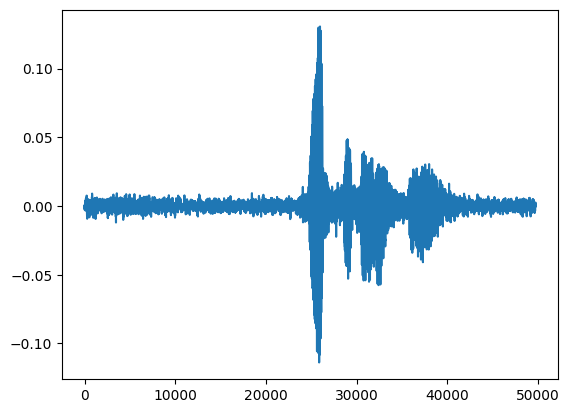

In [8]:
waveform, sample_rate, filename, label, speaker_id = val_set.__getitem__(0)
print("Shape of waveform: {}".format(waveform.size()))
print(f"Sample rate: {sample_rate} Hz, emotion label: {label}")
plt.plot(waveform.t().numpy())

In [9]:
data = IEMOCAP(root=data_dir, 
               # sessions=(1,2,), # use all
               utterance_type='scripted'
              )
all_labels = sorted(list(set(datapoint[3] for datapoint in data)))
print(all_labels)

['ang', 'exc', 'fru', 'hap', 'neu', 'sad']


In [11]:
labels = ['ang', 'neu', 'sad']

def label_to_index(word):
    return torch.tensor(labels.index(word), dtype=torch.int64)
def index_to_label(index):
    return labels[index]
    
data_x = []
data_y = []
for d in data:
    if d[3] in labels:
        data_x.append(d)
        data_y.append(label_to_index(d[3]))

In [12]:
train_set, test_set = train_test_split(
    data_x, test_size=0.2, random_state=42, stratify=data_y)
print("Train: %i" % len(train_set))
print("Test: %i" % len(test_set))

Train: 1519
Test: 380


In [13]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=2):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, sample_rate, _, label, *_ in batch:
        length = len(waveform)
        max_length = sample_rate * max_duration_in_second
        offset = max(0, (length - max_length) // 2)
        tensors += [waveform[offset: length-offset]]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 8

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [42]:
data_improv = IEMOCAP(root=data_dir, 
               # sessions=(1,2,), # use all
               utterance_type='improvised'
              )
all_labels_improv = sorted(list(set(datapoint[3] for datapoint in data_improv)))
print(all_labels_improv)
data_improv_x = []
data_improv_y = []
for d in data_improv:
    if d[3] in labels:
        data_improv_x.append(d)
        data_improv_y.append(label_to_index(d[3]))


['ang', 'exc', 'fru', 'hap', 'neu', 'sad']


In [43]:
improv_test_loader = torch.utils.data.DataLoader(
    data_improv_x,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [19]:
from IConNet.nn.model import M12
from omegaconf import OmegaConf as ocf
from IConNet.visualizer import visualize_model

model_config_path = 'config/model/m12_debug.yaml'
model_config = ocf.load(model_config_path)
print(ocf.to_yaml(model_config))
model = M12(config=model_config,
           n_input=1, n_output=len(labels))
print(model)

print(f'total parameters: {visualize_model.count_parameters(model)}')
print(f'FE parameters: {visualize_model.count_parameters(model.fe_blocks)}')

name: M12_debug
description: FirConv sequential for iemocap
fe:
  n_block: 2
  n_channel:
  - 64
  - 32
  kernel_size:
  - 63
  - 31
  stride:
  - 4
  - 4
  window_k:
  - 5
  - 9
  residual_connection_type: stack
  pooling: false
  filter_type: firwin
  conv_mode: fftconv
  norm_type: LocalResponseNorm
seq:
  n_block: 1
  n_channel: 48
  pooling: max
  use_context: false
  bidirectional: false
cls:
  n_block: 2
  n_hidden_dim:
  - 256
  - 256
  norm_type: LayerNorm

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
         

In [20]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [21]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [22]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                                                                                                                               | 0.00423728813559322/10 [00:00<13:01, 78.17s/it]

Train Epoch: 1 [0/1519 (0%)]	Loss: 1.111794
Mem before-during-after: 22290432 1954428928 25531904


  2%|███                                                                                                                                                                            | 0.17372881355932196/10 [00:11<10:41, 65.25s/it]

Train Epoch: 1 [320/1519 (21%)]	Loss: 0.982140
Mem before-during-after: 25531904 1496595968 25531904


  3%|██████                                                                                                                                                                          | 0.3432203389830503/10 [00:23<10:32, 65.53s/it]

Train Epoch: 1 [640/1519 (42%)]	Loss: 0.875190
Mem before-during-after: 25531904 1730875392 25531904


  5%|█████████                                                                                                                                                                       | 0.5127118644067787/10 [00:34<11:00, 69.65s/it]

Train Epoch: 1 [960/1519 (63%)]	Loss: 0.951158
Mem before-during-after: 25531904 3350993920 25531904


  7%|████████████                                                                                                                                                                    | 0.6822033898305071/10 [00:45<10:55, 70.31s/it]

Train Epoch: 1 [1280/1519 (85%)]	Loss: 0.763638
Mem before-during-after: 25531904 2809326080 25531904


 10%|█████████████████▌                                                                                                                                                              | 0.9999999999999978/10 [01:04<07:09, 47.74s/it]


Test Epoch: 1	Accuracy: 228/376 (60%)



 10%|█████████████████▊                                                                                                                                                               | 1.004237288135591/10 [01:04<07:27, 49.73s/it]

Train Epoch: 2 [0/1519 (0%)]	Loss: 0.758266
Mem before-during-after: 25527808 962918400 25531904


 12%|████████████████████▋                                                                                                                                                           | 1.1737288135593194/10 [01:15<10:05, 68.66s/it]

Train Epoch: 2 [320/1519 (21%)]	Loss: 0.981899
Mem before-during-after: 25531904 2215005184 25531904


 13%|███████████████████████▋                                                                                                                                                        | 1.3432203389830477/10 [01:27<10:16, 71.20s/it]

Train Epoch: 2 [640/1519 (42%)]	Loss: 0.805392
Mem before-during-after: 25531904 2353409024 25531904


 15%|██████████████████████████▊                                                                                                                                                      | 1.512711864406776/10 [01:37<08:06, 57.27s/it]

Train Epoch: 2 [960/1519 (63%)]	Loss: 1.005504
Mem before-during-after: 25531904 959304704 25531904


 17%|█████████████████████████████▌                                                                                                                                                  | 1.6822033898305044/10 [01:49<09:23, 67.71s/it]

Train Epoch: 2 [1280/1519 (85%)]	Loss: 1.045073
Mem before-during-after: 25531904 1323559936 25531904


 20%|███████████████████████████████████▏                                                                                                                                            | 1.9999999999999951/10 [02:06<06:04, 45.56s/it]


Test Epoch: 2	Accuracy: 216/376 (57%)



 20%|███████████████████████████████████▎                                                                                                                                            | 2.0042372881355885/10 [02:07<06:33, 49.20s/it]

Train Epoch: 3 [0/1519 (0%)]	Loss: 0.879816
Mem before-during-after: 25527808 1587600896 25531904


 22%|██████████████████████████████████████▍                                                                                                                                          | 2.173728813559326/10 [02:18<08:59, 68.91s/it]

Train Epoch: 3 [320/1519 (21%)]	Loss: 0.807329
Mem before-during-after: 25531904 2414707712 25531904


 23%|█████████████████████████████████████████▍                                                                                                                                       | 2.343220338983063/10 [02:30<07:57, 62.34s/it]

Train Epoch: 3 [640/1519 (42%)]	Loss: 0.684805
Mem before-during-after: 25531904 1270481920 25531904


 25%|████████████████████████████████████████████▏                                                                                                                                   | 2.5127118644068003/10 [02:40<07:51, 62.98s/it]

Train Epoch: 3 [960/1519 (63%)]	Loss: 1.031382
Mem before-during-after: 25531904 2702573056 25531904


 27%|███████████████████████████████████████████████▏                                                                                                                                | 2.6822033898305375/10 [02:52<08:25, 69.01s/it]

Train Epoch: 3 [1280/1519 (85%)]	Loss: 1.444583
Mem before-during-after: 25531904 787229184 25531904


 30%|█████████████████████████████████████████████████████                                                                                                                            | 3.000000000000045/10 [03:08<05:14, 44.92s/it]


Test Epoch: 3	Accuracy: 223/376 (59%)



 30%|████████████████████████████████████████████████████▊                                                                                                                           | 3.0042372881356383/10 [03:08<05:42, 48.92s/it]

Train Epoch: 4 [0/1519 (0%)]	Loss: 0.771348
Mem before-during-after: 25527808 1400274432 25531904


 32%|███████████████████████████████████████████████████████▊                                                                                                                        | 3.1737288135593755/10 [03:20<07:48, 68.62s/it]

Train Epoch: 4 [320/1519 (21%)]	Loss: 0.786865
Mem before-during-after: 25531904 2267228672 25531904


 33%|███████████████████████████████████████████████████████████▎                                                                                                                     | 3.347457627118706/10 [03:31<05:53, 53.15s/it]

Train Epoch: 4 [640/1519 (42%)]	Loss: 0.689643
Mem before-during-after: 25531904 920134656 25531904


 35%|██████████████████████████████████████████████████████████████▌                                                                                                                   | 3.51271186440685/10 [03:41<06:18, 58.42s/it]

Train Epoch: 4 [960/1519 (63%)]	Loss: 0.564517
Mem before-during-after: 25531904 1215587840 25531904


 37%|████████████████████████████████████████████████████████████████▊                                                                                                               | 3.6822033898305873/10 [03:53<06:15, 59.41s/it]

Train Epoch: 4 [1280/1519 (85%)]	Loss: 1.271572
Mem before-during-after: 25531904 663795200 25531904


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 4.000000000000094/10 [04:10<04:39, 46.65s/it]


Test Epoch: 4	Accuracy: 237/376 (62%)



 40%|██████████████████████████████████████████████████████████████████████▉                                                                                                          | 4.008474576271281/10 [04:10<04:51, 48.57s/it]

Train Epoch: 5 [0/1519 (0%)]	Loss: 0.853211
Mem before-during-after: 25527808 1522691584 25531904


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                       | 4.173728813559425/10 [04:20<06:29, 66.94s/it]

Train Epoch: 5 [320/1519 (21%)]	Loss: 0.541934
Mem before-during-after: 25531904 1950490624 25531904


 43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 4.343220338983162/10 [04:32<05:40, 60.25s/it]

Train Epoch: 5 [640/1519 (42%)]	Loss: 0.723337
Mem before-during-after: 25531904 1048033792 25531904


 45%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 4.512711864406899/10 [04:42<05:27, 59.77s/it]

Train Epoch: 5 [960/1519 (63%)]	Loss: 0.552133
Mem before-during-after: 25531904 1794648576 25531904


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 4.6822033898306366/10 [04:54<06:22, 71.89s/it]

Train Epoch: 5 [1280/1519 (85%)]	Loss: 0.746039
Mem before-during-after: 25531904 1477011968 25531904


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5.000000000000144/10 [05:11<03:49, 45.80s/it]


Test Epoch: 5	Accuracy: 244/376 (64%)



 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5.004237288135737/10 [05:12<06:42, 80.66s/it]

Train Epoch: 6 [0/1519 (0%)]	Loss: 0.555063
Mem before-during-after: 25527808 5116206592 25531904


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 5.173728813559475/10 [05:22<04:53, 60.91s/it]

Train Epoch: 6 [320/1519 (21%)]	Loss: 0.957834
Mem before-during-after: 25531904 1899517440 25531904


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 5.343220338983212/10 [05:33<04:51, 62.51s/it]

Train Epoch: 6 [640/1519 (42%)]	Loss: 1.286625
Mem before-during-after: 25531904 2520845824 25531904


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 5.512711864406949/10 [05:44<05:13, 69.92s/it]

Train Epoch: 6 [960/1519 (63%)]	Loss: 0.810297
Mem before-during-after: 25531904 1201380864 25531904


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 5.682203389830686/10 [05:55<04:48, 66.90s/it]

Train Epoch: 6 [1280/1519 (85%)]	Loss: 0.502637
Mem before-during-after: 25531904 2486158848 25531904


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 6.000000000000194/10 [06:12<02:58, 44.51s/it]


Test Epoch: 6	Accuracy: 242/376 (64%)



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 6.004237288135787/10 [06:12<03:10, 47.62s/it]

Train Epoch: 7 [0/1519 (0%)]	Loss: 1.169956
Mem before-during-after: 25527808 1536057344 25531904


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 6.173728813559524/10 [06:24<04:16, 67.05s/it]

Train Epoch: 7 [320/1519 (21%)]	Loss: 0.858555
Mem before-during-after: 25531904 2415215616 25531904


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 6.347457627118855/10 [06:35<03:25, 56.35s/it]

Train Epoch: 7 [640/1519 (42%)]	Loss: 1.128256
Mem before-during-after: 25531904 645621760 25531904


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 6.512711864406999/10 [06:45<03:48, 65.41s/it]

Train Epoch: 7 [960/1519 (63%)]	Loss: 0.482535
Mem before-during-after: 25531904 1589331968 25531904


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 6.682203389830736/10 [06:56<03:29, 63.26s/it]

Train Epoch: 7 [1280/1519 (85%)]	Loss: 0.668666
Mem before-during-after: 25531904 1943592960 25531904


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 7.000000000000243/10 [07:13<02:15, 45.10s/it]


Test Epoch: 7	Accuracy: 246/376 (65%)



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 7.00847457627143/10 [07:13<02:20, 46.89s/it]

Train Epoch: 8 [0/1519 (0%)]	Loss: 1.225931
Mem before-during-after: 25527808 842033664 25531904


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 7.173728813559574/10 [07:24<03:14, 68.87s/it]

Train Epoch: 8 [320/1519 (21%)]	Loss: 0.671017
Mem before-during-after: 25531904 1869496832 25531904


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 7.343220338983311/10 [07:34<02:34, 58.08s/it]

Train Epoch: 8 [640/1519 (42%)]	Loss: 1.292489
Mem before-during-after: 25531904 897421312 25531904


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 7.5127118644070485/10 [07:45<03:25, 82.61s/it]

Train Epoch: 8 [960/1519 (63%)]	Loss: 0.398775
Mem before-during-after: 25531904 2491710464 25531904


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 7.682203389830786/10 [07:56<02:58, 76.83s/it]

Train Epoch: 8 [1280/1519 (85%)]	Loss: 0.585630
Mem before-during-after: 25531904 1753182720 25531904


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 8.000000000000293/10 [08:13<01:29, 44.91s/it]


Test Epoch: 8	Accuracy: 246/376 (65%)



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 8.004237288135887/10 [08:14<01:36, 48.35s/it]

Train Epoch: 9 [0/1519 (0%)]	Loss: 0.541342
Mem before-during-after: 25527808 1428260864 25531904


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 8.173728813559624/10 [08:25<01:48, 59.35s/it]

Train Epoch: 9 [320/1519 (21%)]	Loss: 0.705404
Mem before-during-after: 25531904 940697600 25531904


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 8.343220338983361/10 [08:35<01:43, 62.17s/it]

Train Epoch: 9 [640/1519 (42%)]	Loss: 0.735621
Mem before-during-after: 25531904 1383398400 25531904


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 8.512711864407098/10 [08:47<01:41, 67.97s/it]

Train Epoch: 9 [960/1519 (63%)]	Loss: 0.691178
Mem before-during-after: 25531904 2201912320 25531904


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8.682203389830836/10 [08:58<01:28, 67.09s/it]

Train Epoch: 9 [1280/1519 (85%)]	Loss: 1.032435
Mem before-during-after: 25531904 958981120 25531904


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 9.000000000000343/10 [09:15<00:45, 45.20s/it]


Test Epoch: 9	Accuracy: 242/376 (64%)



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 9.004237288135936/10 [09:15<00:48, 48.92s/it]

Train Epoch: 10 [0/1519 (0%)]	Loss: 0.380273
Mem before-during-after: 25527808 1725117952 25531904


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 9.173728813559674/10 [09:26<00:56, 68.08s/it]

Train Epoch: 10 [320/1519 (21%)]	Loss: 0.838076
Mem before-during-after: 25531904 1236755456 25531904


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 9.347457627119004/10 [09:37<00:48, 73.72s/it]

Train Epoch: 10 [640/1519 (42%)]	Loss: 0.975491
Mem before-during-after: 25531904 1047096320 25531904


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 9.512711864407148/10 [09:49<00:32, 67.71s/it]

Train Epoch: 10 [960/1519 (63%)]	Loss: 0.737908
Mem before-during-after: 25531904 2322514432 25531904


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 9.682203389830885/10 [10:00<00:21, 68.59s/it]

Train Epoch: 10 [1280/1519 (85%)]	Loss: 0.540519
Mem before-during-after: 25531904 2398301184 25531904


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9.9957627118648/10 [10:16<00:00, 47.70s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10.000000000000393/10 [10:16<00:00, 61.68s/it]


Test Epoch: 10	Accuracy: 246/376 (65%)



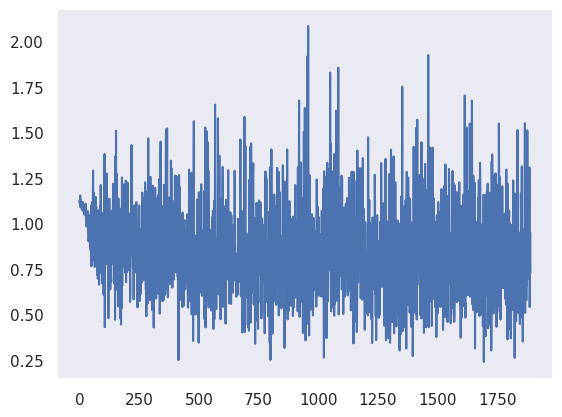

In [24]:
plt.plot(train_losses)

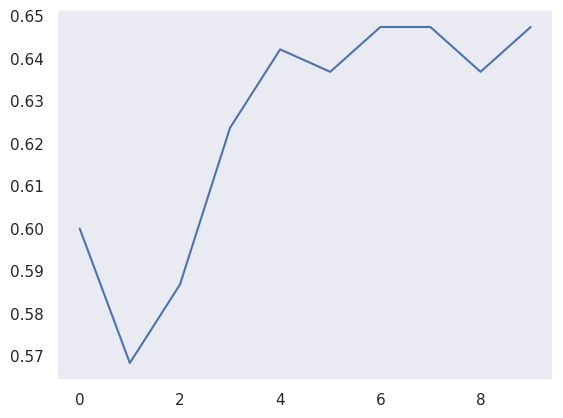

In [23]:
plt.plot(test_accuracy)

In [25]:
model_path = '../iemocap_label3_m12new_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [26]:
model_path_prefix = '../models_iemocap3/iemocap_label3_m12new_best_'
torch.save(model.state_dict(), f'{model_path_prefix}{n_epoch}epoch.pt')

In [44]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [28]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 246/376 (0.6543)
{'acc_detail': tensor([0.7716, 0.7563, 0.3263], device='cuda:0'),
 'acc_unweighted': tensor(0.6181, device='cuda:0'),
 'acc_weighted': tensor(0.6543, device='cuda:0'),
 'f1s': tensor(0.6138, device='cuda:0'),
 'f1s_detail': tensor([0.8039, 0.6040, 0.4336], device='cuda:0'),
 'precision_detail': tensor([0.8389, 0.5028, 0.6458], device='cuda:0'),
 'recall_detail': tensor([0.7716, 0.7563, 0.3263], device='cuda:0'),
 'rocauc': tensor([0.9212, 0.7399, 0.8412], device='cuda:0'),
 'uar': tensor(0.6181, device='cuda:0'),
 'wap': tensor(0.6838, device='cuda:0')}


tensor([[125,  35,   2],
        [ 14,  90,  15],
        [ 10,  54,  31]], device='cuda:0')

In [29]:
n_epoch = 10
n_epoch2 = 340
# train_losses = []
# test_accuracy = []
best_accuracy = min(test_accuracy)
model_path_prefix = '../models_iemocap3/iemocap_label3_m12new_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.000005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.005,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                                                                                                            | 0.00423728813559322/340 [00:00<5:45:01, 60.89s/it]

Train Epoch: 11 [0/1519 (0%)]	Loss: 0.856373
Mem before-during-after: 24545792 748001792 25602560


  0%|                                                                                                                                                                            | 0.17372881355932196/340 [00:12<6:16:33, 66.48s/it]

Train Epoch: 11 [320/1519 (21%)]	Loss: 0.638314
Mem before-during-after: 25602560 1008952320 25602560


  0%|▏                                                                                                                                                                            | 0.3432203389830503/340 [00:23<7:13:06, 76.51s/it]

Train Epoch: 11 [640/1519 (42%)]	Loss: 0.786472
Mem before-during-after: 25602560 2206922752 25602560


  0%|▎                                                                                                                                                                            | 0.5127118644067787/340 [00:35<7:02:08, 74.61s/it]

Train Epoch: 11 [960/1519 (63%)]	Loss: 0.972295
Mem before-during-after: 25602560 1216879616 25602560


  0%|▎                                                                                                                                                                            | 0.6822033898305071/340 [00:47<7:23:32, 78.43s/it]

Train Epoch: 11 [1280/1519 (85%)]	Loss: 0.517302
Mem before-during-after: 25602560 1956078080 25602560


  0%|▌                                                                                                                                                                            | 0.9999999999999978/340 [01:04<4:26:39, 47.19s/it]


Test Epoch: 11	Accuracy: 247/376 (65%)

saved model: ../models_iemocap3/iemocap_label3_m12new_best_11epoch.pt


  0%|▌                                                                                                                                                                             | 1.004237288135591/340 [01:04<4:54:50, 52.19s/it]

Train Epoch: 12 [0/1519 (0%)]	Loss: 0.456841
Mem before-during-after: 25598464 1662135296 25602560


  0%|▌                                                                                                                                                                           | 1.1737288135593194/340 [01:16<9:46:37, 103.88s/it]

Train Epoch: 12 [320/1519 (21%)]	Loss: 0.435677
Mem before-during-after: 25602560 2415286272 25602560


  0%|▋                                                                                                                                                                            | 1.3432203389830477/340 [01:28<5:55:55, 63.06s/it]

Train Epoch: 12 [640/1519 (42%)]	Loss: 0.886000
Mem before-during-after: 25602560 832156672 25602560


  0%|▊                                                                                                                                                                             | 1.512711864406776/340 [01:39<6:27:13, 68.64s/it]

Train Epoch: 12 [960/1519 (63%)]	Loss: 0.770973
Mem before-during-after: 25602560 2162284032 25602560


  0%|▊                                                                                                                                                                            | 1.6822033898305044/340 [01:51<6:06:21, 64.97s/it]

Train Epoch: 12 [1280/1519 (85%)]	Loss: 0.622361
Mem before-during-after: 25602560 1297093632 25602560


  1%|█                                                                                                                                                                            | 1.9999999999999951/340 [02:09<4:31:19, 48.17s/it]


Test Epoch: 12	Accuracy: 243/376 (64%)



  1%|█                                                                                                                                                                            | 2.0042372881355885/340 [02:09<4:48:05, 51.14s/it]

Train Epoch: 13 [0/1519 (0%)]	Loss: 0.782199
Mem before-during-after: 25598464 967694848 25602560


  1%|█                                                                                                                                                                             | 2.173728813559326/340 [02:21<6:49:20, 72.70s/it]

Train Epoch: 13 [320/1519 (21%)]	Loss: 0.868788
Mem before-during-after: 25602560 1997790208 25602560


  1%|█▏                                                                                                                                                                            | 2.343220338983063/340 [02:32<7:07:35, 75.98s/it]

Train Epoch: 13 [640/1519 (42%)]	Loss: 0.432451
Mem before-during-after: 25602560 2324790272 25602560


  1%|█▎                                                                                                                                                                           | 2.5127118644068003/340 [02:44<6:37:05, 70.60s/it]

Train Epoch: 13 [960/1519 (63%)]	Loss: 0.710103
Mem before-during-after: 25602560 1829981184 25602560


  1%|█▎                                                                                                                                                                           | 2.6822033898305375/340 [02:56<5:57:43, 63.63s/it]

Train Epoch: 13 [1280/1519 (85%)]	Loss: 0.947434
Mem before-during-after: 25602560 1238195712 25602560


  1%|█▌                                                                                                                                                                            | 3.000000000000045/340 [03:13<4:32:27, 48.51s/it]


Test Epoch: 13	Accuracy: 253/376 (67%)

saved model: ../models_iemocap3/iemocap_label3_m12new_best_13epoch.pt


  1%|█▌                                                                                                                                                                           | 3.0042372881356383/340 [03:14<5:16:07, 56.28s/it]

Train Epoch: 14 [0/1519 (0%)]	Loss: 0.735276
Mem before-during-after: 25598464 2407013888 25602560


  1%|█▌                                                                                                                                                                           | 3.1737288135593755/340 [03:25<5:58:43, 63.90s/it]

Train Epoch: 14 [320/1519 (21%)]	Loss: 0.947901
Mem before-during-after: 25602560 1240833024 25602560


  1%|█▋                                                                                                                                                                           | 3.3432203389831128/340 [03:36<5:51:00, 62.56s/it]

Train Epoch: 14 [640/1519 (42%)]	Loss: 0.983776
Mem before-during-after: 25602560 1934240768 25602560


  1%|█▊                                                                                                                                                                             | 3.51271186440685/340 [03:49<7:54:21, 84.59s/it]

Train Epoch: 14 [960/1519 (63%)]	Loss: 0.515792
Mem before-during-after: 25602560 2353479680 25602560


  1%|█▊                                                                                                                                                                           | 3.6822033898305873/340 [04:00<6:07:54, 65.64s/it]

Train Epoch: 14 [1280/1519 (85%)]	Loss: 0.768390
Mem before-during-after: 25602560 1110152704 25602560


  1%|██                                                                                                                                                                            | 4.000000000000094/340 [04:18<4:31:28, 48.48s/it]


Test Epoch: 14	Accuracy: 250/376 (66%)



  1%|██                                                                                                                                                                            | 4.004237288135688/340 [04:18<5:04:36, 54.39s/it]

Train Epoch: 15 [0/1519 (0%)]	Loss: 0.813004
Mem before-during-after: 25598464 2195157504 25602560


  1%|██▏                                                                                                                                                                           | 4.173728813559425/340 [04:28<5:38:22, 60.45s/it]

Train Epoch: 15 [320/1519 (21%)]	Loss: 0.779525
Mem before-during-after: 25602560 583841280 25602560


  1%|██▏                                                                                                                                                                           | 4.343220338983162/340 [04:39<7:07:06, 76.35s/it]

Train Epoch: 15 [640/1519 (42%)]	Loss: 0.574861
Mem before-during-after: 25602560 1900042240 25602560


  1%|██▎                                                                                                                                                                           | 4.512711864406899/340 [04:50<6:12:58, 66.70s/it]

Train Epoch: 15 [960/1519 (63%)]	Loss: 0.297987
Mem before-during-after: 25602560 1676139520 25602560


  1%|██▍                                                                                                                                                                          | 4.6822033898306366/340 [05:02<7:20:33, 78.83s/it]

Train Epoch: 15 [1280/1519 (85%)]	Loss: 1.192618
Mem before-during-after: 25602560 858504704 25602560


  1%|██▌                                                                                                                                                                           | 5.000000000000144/340 [05:21<4:35:46, 49.39s/it]


Test Epoch: 15	Accuracy: 243/376 (64%)



  1%|██▌                                                                                                                                                                           | 5.004237288135737/340 [05:21<4:39:06, 49.99s/it]

Train Epoch: 16 [0/1519 (0%)]	Loss: 0.955876
Mem before-during-after: 25598464 780085760 25602560


  2%|██▋                                                                                                                                                                           | 5.173728813559475/340 [05:32<6:12:16, 66.71s/it]

Train Epoch: 16 [320/1519 (21%)]	Loss: 0.940807
Mem before-during-after: 25602560 1186778624 25602560


  2%|██▋                                                                                                                                                                           | 5.343220338983212/340 [05:43<6:27:54, 69.55s/it]

Train Epoch: 16 [640/1519 (42%)]	Loss: 0.847245
Mem before-during-after: 25602560 2672908288 25602560


  2%|██▊                                                                                                                                                                           | 5.512711864406949/340 [05:54<6:13:24, 66.98s/it]

Train Epoch: 16 [960/1519 (63%)]	Loss: 1.737616
Mem before-during-after: 25602560 2506385408 25602560


  2%|██▉                                                                                                                                                                           | 5.682203389830686/340 [06:06<6:09:33, 66.32s/it]

Train Epoch: 16 [1280/1519 (85%)]	Loss: 0.464874
Mem before-during-after: 25602560 2202721280 25602560


  2%|███                                                                                                                                                                           | 6.000000000000194/340 [06:25<4:28:29, 48.23s/it]


Test Epoch: 16	Accuracy: 240/376 (63%)



  2%|███                                                                                                                                                                           | 6.004237288135787/340 [06:25<5:07:50, 55.30s/it]

Train Epoch: 17 [0/1519 (0%)]	Loss: 0.544861
Mem before-during-after: 25598464 1720010240 25602560


  2%|███▏                                                                                                                                                                          | 6.173728813559524/340 [06:37<6:21:09, 68.51s/it]

Train Epoch: 17 [320/1519 (21%)]	Loss: 1.212753
Mem before-during-after: 25602560 2215036416 25602560


  2%|███▏                                                                                                                                                                         | 6.3432203389832615/340 [06:48<6:09:18, 66.41s/it]

Train Epoch: 17 [640/1519 (42%)]	Loss: 1.643159
Mem before-during-after: 25602560 1733632512 25602560


  2%|███▎                                                                                                                                                                          | 6.512711864406999/340 [07:00<7:25:39, 80.18s/it]

Train Epoch: 17 [960/1519 (63%)]	Loss: 0.958658
Mem before-during-after: 25602560 1597080064 25602560


  2%|███▍                                                                                                                                                                          | 6.682203389830736/340 [07:11<6:36:56, 71.45s/it]

Train Epoch: 17 [1280/1519 (85%)]	Loss: 0.631426
Mem before-during-after: 25602560 2027580416 25602560


  2%|███▌                                                                                                                                                                          | 7.000000000000243/340 [07:29<4:37:15, 49.96s/it]


Test Epoch: 17	Accuracy: 236/376 (62%)



  2%|███▌                                                                                                                                                                          | 7.004237288135837/340 [07:29<4:42:40, 50.93s/it]

Train Epoch: 18 [0/1519 (0%)]	Loss: 0.894507
Mem before-during-after: 25598464 876469760 25602560


  2%|███▋                                                                                                                                                                          | 7.173728813559574/340 [07:41<5:57:53, 64.52s/it]

Train Epoch: 18 [320/1519 (21%)]	Loss: 0.574942
Mem before-during-after: 25602560 1200845824 25602560


  2%|███▊                                                                                                                                                                          | 7.343220338983311/340 [07:51<5:39:00, 61.14s/it]

Train Epoch: 18 [640/1519 (42%)]	Loss: 0.675344
Mem before-during-after: 25602560 1403230720 25602560


  2%|███▊                                                                                                                                                                         | 7.5127118644070485/340 [08:04<7:09:05, 77.43s/it]

Train Epoch: 18 [960/1519 (63%)]	Loss: 1.319349
Mem before-during-after: 25602560 2507421696 25602560


  2%|███▉                                                                                                                                                                          | 7.682203389830786/340 [08:14<5:59:02, 64.83s/it]

Train Epoch: 18 [1280/1519 (85%)]	Loss: 0.699953
Mem before-during-after: 25602560 1168526848 25602560


  2%|████                                                                                                                                                                          | 8.000000000000293/340 [08:32<4:29:24, 48.69s/it]


Test Epoch: 18	Accuracy: 237/376 (62%)



  2%|████                                                                                                                                                                          | 8.004237288135887/340 [08:33<5:05:03, 55.13s/it]

Train Epoch: 19 [0/1519 (0%)]	Loss: 0.608923
Mem before-during-after: 25598464 2536360960 25602560


  2%|████▏                                                                                                                                                                         | 8.173728813559624/340 [08:44<6:17:18, 68.22s/it]

Train Epoch: 19 [320/1519 (21%)]	Loss: 0.862729
Mem before-during-after: 25602560 959768064 25602560


  2%|████▎                                                                                                                                                                         | 8.343220338983361/340 [08:55<6:00:39, 65.25s/it]

Train Epoch: 19 [640/1519 (42%)]	Loss: 0.522689
Mem before-during-after: 25602560 1943663616 25602560


  3%|████▎                                                                                                                                                                         | 8.512711864407098/340 [09:06<6:03:18, 65.76s/it]

Train Epoch: 19 [960/1519 (63%)]	Loss: 1.504458
Mem before-during-after: 25602560 1637946880 25602560


  3%|████▍                                                                                                                                                                        | 8.682203389830836/340 [09:18<9:48:10, 106.52s/it]

Train Epoch: 19 [1280/1519 (85%)]	Loss: 0.695932
Mem before-during-after: 25602560 3307108864 25602560


  3%|████▌                                                                                                                                                                         | 9.000000000000343/340 [09:36<4:23:28, 47.76s/it]


Test Epoch: 19	Accuracy: 252/376 (66%)



  3%|████▌                                                                                                                                                                         | 9.004237288135936/340 [09:36<4:30:57, 49.12s/it]

Train Epoch: 20 [0/1519 (0%)]	Loss: 1.252980
Mem before-during-after: 25598464 692333568 25602560


  3%|████▋                                                                                                                                                                         | 9.173728813559674/340 [09:47<5:55:51, 64.54s/it]

Train Epoch: 20 [320/1519 (21%)]	Loss: 0.970095
Mem before-during-after: 25602560 591664640 25602560


  3%|████▊                                                                                                                                                                          | 9.34322033898341/340 [09:59<6:00:30, 65.42s/it]

Train Epoch: 20 [640/1519 (42%)]	Loss: 0.683812
Mem before-during-after: 25602560 1710673920 25602560


  3%|████▊                                                                                                                                                                         | 9.512711864407148/340 [10:11<5:41:43, 62.04s/it]

Train Epoch: 20 [960/1519 (63%)]	Loss: 1.055778
Mem before-during-after: 25602560 929117184 25602560


  3%|████▉                                                                                                                                                                         | 9.682203389830885/340 [10:22<8:43:10, 95.03s/it]

Train Epoch: 20 [1280/1519 (85%)]	Loss: 0.808400
Mem before-during-after: 25602560 1999303680 25602560


  3%|█████                                                                                                                                                                        | 10.000000000000393/340 [10:39<4:18:20, 46.97s/it]


Test Epoch: 20	Accuracy: 256/376 (67%)

saved model: ../models_iemocap3/iemocap_label3_m12new_best_20epoch.pt


  3%|█████                                                                                                                                                                        | 10.004237288135986/340 [10:40<4:38:58, 50.72s/it]

Train Epoch: 21 [0/1519 (0%)]	Loss: 0.579022
Mem before-during-after: 25598464 1600607232 25602560


  3%|█████▏                                                                                                                                                                       | 10.173728813559723/340 [10:50<6:17:29, 68.67s/it]

Train Epoch: 21 [320/1519 (21%)]	Loss: 0.621035
Mem before-during-after: 25602560 1933720064 25602560


  3%|█████▎                                                                                                                                                                        | 10.34322033898346/340 [11:02<6:04:04, 66.26s/it]

Train Epoch: 21 [640/1519 (42%)]	Loss: 1.033694
Mem before-during-after: 25602560 1220567040 25602560


  3%|█████▎                                                                                                                                                                       | 10.512711864407198/340 [11:13<5:30:05, 60.11s/it]

Train Epoch: 21 [960/1519 (63%)]	Loss: 0.975989
Mem before-during-after: 25602560 1052122624 25602560


  3%|█████▍                                                                                                                                                                       | 10.682203389830935/340 [11:26<7:05:17, 77.49s/it]

Train Epoch: 21 [1280/1519 (85%)]	Loss: 0.605574
Mem before-during-after: 25602560 2024569344 25602560


  3%|█████▌                                                                                                                                                                       | 11.000000000000442/340 [11:44<4:22:43, 47.91s/it]


Test Epoch: 21	Accuracy: 248/376 (65%)



  3%|█████▌                                                                                                                                                                       | 11.004237288136036/340 [11:44<4:54:08, 53.64s/it]

Train Epoch: 22 [0/1519 (0%)]	Loss: 1.115549
Mem before-during-after: 25598464 1868089856 25602560


  3%|█████▋                                                                                                                                                                       | 11.173728813559773/340 [11:55<5:23:14, 58.98s/it]

Train Epoch: 22 [320/1519 (21%)]	Loss: 0.960881
Mem before-during-after: 25602560 1313875456 25602560


  3%|█████▊                                                                                                                                                                        | 11.34322033898351/340 [12:06<5:52:07, 64.28s/it]

Train Epoch: 22 [640/1519 (42%)]	Loss: 0.554503
Mem before-during-after: 25602560 988765696 25602560


  3%|█████▊                                                                                                                                                                       | 11.512711864407247/340 [12:17<5:56:11, 65.06s/it]

Train Epoch: 22 [960/1519 (63%)]	Loss: 0.379634
Mem before-during-after: 25602560 1915074048 25602560


  3%|█████▉                                                                                                                                                                       | 11.682203389830985/340 [12:28<8:14:06, 90.30s/it]

Train Epoch: 22 [1280/1519 (85%)]	Loss: 0.493347
Mem before-during-after: 25602560 3296623104 25602560


  4%|██████                                                                                                                                                                       | 12.000000000000492/340 [12:47<4:26:10, 48.69s/it]


Test Epoch: 22	Accuracy: 255/376 (67%)



  4%|██████                                                                                                                                                                       | 12.008474576271679/340 [12:48<4:40:52, 51.38s/it]

Train Epoch: 23 [0/1519 (0%)]	Loss: 0.759981
Mem before-during-after: 25598464 1237266432 25602560


  4%|██████▏                                                                                                                                                                      | 12.173728813559823/340 [12:59<8:00:01, 87.86s/it]

Train Epoch: 23 [320/1519 (21%)]	Loss: 0.888099
Mem before-during-after: 25602560 1202766336 25602560


  4%|██████▎                                                                                                                                                                       | 12.34322033898356/340 [13:11<6:47:22, 74.60s/it]

Train Epoch: 23 [640/1519 (42%)]	Loss: 0.833028
Mem before-during-after: 25602560 865776640 25602560


  4%|██████▎                                                                                                                                                                      | 12.512711864407297/340 [13:22<5:45:26, 63.29s/it]

Train Epoch: 23 [960/1519 (63%)]	Loss: 0.615276
Mem before-during-after: 25602560 1271634432 25602560


  4%|██████▍                                                                                                                                                                      | 12.682203389831034/340 [13:33<5:48:53, 63.95s/it]

Train Epoch: 23 [1280/1519 (85%)]	Loss: 0.680737
Mem before-during-after: 25602560 2128995840 25602560


  4%|██████▌                                                                                                                                                                      | 13.000000000000542/340 [13:51<4:21:46, 48.03s/it]


Test Epoch: 23	Accuracy: 249/376 (66%)



  4%|██████▌                                                                                                                                                                      | 13.004237288136135/340 [13:51<6:11:45, 68.21s/it]

Train Epoch: 24 [0/1519 (0%)]	Loss: 0.410792
Mem before-during-after: 25598464 3615673856 25602560


  4%|██████▋                                                                                                                                                                      | 13.173728813559872/340 [14:03<7:30:35, 82.72s/it]

Train Epoch: 24 [320/1519 (21%)]	Loss: 0.988436
Mem before-during-after: 25602560 2420631552 25602560


  4%|██████▊                                                                                                                                                                       | 13.34322033898361/340 [14:13<6:03:18, 66.73s/it]

Train Epoch: 24 [640/1519 (42%)]	Loss: 0.853183
Mem before-during-after: 25602560 901483008 25602560


  4%|██████▉                                                                                                                                                                      | 13.512711864407347/340 [14:25<6:00:18, 66.22s/it]

Train Epoch: 24 [960/1519 (63%)]	Loss: 0.755449
Mem before-during-after: 25602560 2108397056 25602560


  4%|██████▉                                                                                                                                                                      | 13.682203389831084/340 [14:37<7:06:50, 78.48s/it]

Train Epoch: 24 [1280/1519 (85%)]	Loss: 0.871250
Mem before-during-after: 25602560 2141850112 25602560


  4%|███████                                                                                                                                                                      | 14.000000000000592/340 [14:54<4:16:17, 47.17s/it]


Test Epoch: 24	Accuracy: 244/376 (64%)



  4%|███████▏                                                                                                                                                                     | 14.004237288136185/340 [14:54<4:51:24, 53.64s/it]

Train Epoch: 25 [0/1519 (0%)]	Loss: 0.711623
Mem before-during-after: 25598464 2167016960 25602560


  4%|███████▏                                                                                                                                                                     | 14.173728813559922/340 [15:06<6:34:34, 72.66s/it]

Train Epoch: 25 [320/1519 (21%)]	Loss: 0.366161
Mem before-during-after: 25602560 1952368640 25602560


  4%|███████▎                                                                                                                                                                      | 14.34322033898366/340 [15:18<7:03:04, 77.95s/it]

Train Epoch: 25 [640/1519 (42%)]	Loss: 1.329749
Mem before-during-after: 25602560 2351448064 25602560


  4%|███████▍                                                                                                                                                                     | 14.512711864407397/340 [15:30<8:48:01, 97.34s/it]

Train Epoch: 25 [960/1519 (63%)]	Loss: 0.579023
Mem before-during-after: 25602560 3615575552 25602560


  4%|███████▍                                                                                                                                                                     | 14.682203389831134/340 [15:41<6:17:55, 69.70s/it]

Train Epoch: 25 [1280/1519 (85%)]	Loss: 0.913422
Mem before-during-after: 25602560 2410361856 25602560


  4%|███████▋                                                                                                                                                                     | 15.000000000000641/340 [15:58<4:21:22, 48.25s/it]


Test Epoch: 25	Accuracy: 244/376 (64%)



  4%|███████▋                                                                                                                                                                     | 15.004237288136235/340 [15:58<4:41:38, 52.00s/it]

Train Epoch: 26 [0/1519 (0%)]	Loss: 0.486465
Mem before-during-after: 25598464 1502331392 25602560


  4%|███████▋                                                                                                                                                                     | 15.173728813559972/340 [16:11<5:54:18, 65.45s/it]

Train Epoch: 26 [320/1519 (21%)]	Loss: 0.880159
Mem before-during-after: 25602560 2525854720 25602560


  5%|███████▊                                                                                                                                                                      | 15.34322033898371/340 [16:22<6:22:15, 70.64s/it]

Train Epoch: 26 [640/1519 (42%)]	Loss: 0.572943
Mem before-during-after: 25602560 1476673024 25602560


  5%|███████▉                                                                                                                                                                     | 15.512711864407446/340 [16:34<6:01:15, 66.80s/it]

Train Epoch: 26 [960/1519 (63%)]	Loss: 0.851612
Mem before-during-after: 25602560 1322776576 25602560


  5%|███████▉                                                                                                                                                                     | 15.682203389831184/340 [16:45<5:30:45, 61.19s/it]

Train Epoch: 26 [1280/1519 (85%)]	Loss: 0.749034
Mem before-during-after: 25602560 1001864192 25602560


  5%|████████▏                                                                                                                                                                     | 16.00000000000069/340 [17:02<4:22:45, 48.66s/it]


Test Epoch: 26	Accuracy: 251/376 (66%)



  5%|████████▏                                                                                                                                                                     | 16.00423728813628/340 [17:02<4:36:43, 51.25s/it]

Train Epoch: 27 [0/1519 (0%)]	Loss: 1.231097
Mem before-during-after: 25598464 1074503168 25602560


  5%|████████▏                                                                                                                                                                    | 16.173728813559947/340 [17:13<5:40:02, 63.01s/it]

Train Epoch: 27 [320/1519 (21%)]	Loss: 0.961242
Mem before-during-after: 25602560 1869264896 25602560


  5%|████████▎                                                                                                                                                                    | 16.343220338983613/340 [17:25<6:27:06, 71.76s/it]

Train Epoch: 27 [640/1519 (42%)]	Loss: 0.576955
Mem before-during-after: 25602560 2115924480 25602560


  5%|████████▍                                                                                                                                                                     | 16.51271186440728/340 [17:37<5:49:36, 64.84s/it]

Train Epoch: 27 [960/1519 (63%)]	Loss: 1.273219
Mem before-during-after: 25602560 757193728 25602560


  5%|████████▍                                                                                                                                                                    | 16.682203389830946/340 [17:48<6:26:15, 71.68s/it]

Train Epoch: 27 [1280/1519 (85%)]	Loss: 0.366589
Mem before-during-after: 25602560 2304794112 25602560


  5%|████████▋                                                                                                                                                                     | 17.00000000000032/340 [18:05<4:30:27, 50.24s/it]


Test Epoch: 27	Accuracy: 246/376 (65%)



  5%|████████▋                                                                                                                                                                     | 17.00423728813591/340 [18:06<5:30:49, 61.45s/it]

Train Epoch: 28 [0/1519 (0%)]	Loss: 0.756630
Mem before-during-after: 25598464 3351064576 25602560


  5%|████████▋                                                                                                                                                                    | 17.173728813559578/340 [18:17<5:45:13, 64.16s/it]

Train Epoch: 28 [320/1519 (21%)]	Loss: 0.656794
Mem before-during-after: 25602560 1899342848 25602560


  5%|████████▊                                                                                                                                                                    | 17.343220338983244/340 [18:28<5:36:59, 62.66s/it]

Train Epoch: 28 [640/1519 (42%)]	Loss: 1.001212
Mem before-during-after: 25602560 1295992320 25602560


  5%|████████▉                                                                                                                                                                     | 17.51271186440691/340 [18:39<6:11:02, 69.03s/it]

Train Epoch: 28 [960/1519 (63%)]	Loss: 0.986136
Mem before-during-after: 25602560 1719739392 25602560


  5%|████████▉                                                                                                                                                                    | 17.682203389830576/340 [18:50<6:59:42, 78.13s/it]

Train Epoch: 28 [1280/1519 (85%)]	Loss: 0.460936
Mem before-during-after: 25602560 1068003840 25602560


  5%|█████████▏                                                                                                                                                                    | 17.99999999999995/340 [19:09<4:16:49, 47.85s/it]


Test Epoch: 28	Accuracy: 255/376 (67%)



  5%|█████████▏                                                                                                                                                                   | 18.004237288135542/340 [19:09<4:24:22, 49.26s/it]

Train Epoch: 29 [0/1519 (0%)]	Loss: 0.883879
Mem before-during-after: 25598464 558440448 25602560


  5%|█████████▏                                                                                                                                                                   | 18.173728813559208/340 [19:20<7:07:35, 79.72s/it]

Train Epoch: 29 [320/1519 (21%)]	Loss: 0.959374
Mem before-during-after: 25602560 2490595328 25602560


  5%|█████████▎                                                                                                                                                                   | 18.343220338982874/340 [19:31<6:28:57, 72.55s/it]

Train Epoch: 29 [640/1519 (42%)]	Loss: 1.019165
Mem before-during-after: 25602560 850611200 25602560


  5%|█████████▍                                                                                                                                                                    | 18.51271186440654/340 [19:43<6:07:29, 68.59s/it]

Train Epoch: 29 [960/1519 (63%)]	Loss: 0.759966
Mem before-during-after: 25602560 2323420672 25602560


  5%|█████████▌                                                                                                                                                                   | 18.682203389830207/340 [19:54<5:22:35, 60.24s/it]

Train Epoch: 29 [1280/1519 (85%)]	Loss: 0.760438
Mem before-during-after: 25602560 912377344 25602560


  6%|█████████▋                                                                                                                                                                    | 18.99999999999958/340 [20:12<4:14:05, 47.49s/it]


Test Epoch: 29	Accuracy: 249/376 (66%)



  6%|█████████▋                                                                                                                                                                   | 19.004237288135172/340 [20:12<4:47:38, 53.77s/it]

Train Epoch: 30 [0/1519 (0%)]	Loss: 0.835420
Mem before-during-after: 25598464 2278889472 25602560


  6%|█████████▊                                                                                                                                                                    | 19.17372881355884/340 [20:23<5:41:59, 63.96s/it]

Train Epoch: 30 [320/1519 (21%)]	Loss: 1.175052
Mem before-during-after: 25602560 1216879616 25602560


  6%|█████████▊                                                                                                                                                                   | 19.343220338982505/340 [20:35<6:51:35, 77.01s/it]

Train Epoch: 30 [640/1519 (42%)]	Loss: 0.878595
Mem before-during-after: 25602560 2702643712 25602560


  6%|█████████▉                                                                                                                                                                    | 19.51271186440617/340 [20:46<6:15:44, 70.34s/it]

Train Epoch: 30 [960/1519 (63%)]	Loss: 0.389430
Mem before-during-after: 25602560 1382599168 25602560


  6%|██████████                                                                                                                                                                   | 19.682203389829837/340 [20:57<6:12:28, 69.77s/it]

Train Epoch: 30 [1280/1519 (85%)]	Loss: 0.943655
Mem before-during-after: 25602560 921698304 25602560


  6%|██████████▏                                                                                                                                                                   | 19.99999999999921/340 [21:15<4:14:06, 47.65s/it]


Test Epoch: 30	Accuracy: 244/376 (64%)



  6%|██████████▏                                                                                                                                                                  | 20.004237288134803/340 [21:15<4:43:02, 53.07s/it]

Train Epoch: 31 [0/1519 (0%)]	Loss: 1.025386
Mem before-during-after: 25598464 1800702464 25602560


  6%|██████████▎                                                                                                                                                                   | 20.17372881355847/340 [21:27<6:12:51, 69.95s/it]

Train Epoch: 31 [320/1519 (21%)]	Loss: 0.912644
Mem before-during-after: 25602560 2314460672 25602560


  6%|██████████▎                                                                                                                                                                  | 20.343220338982135/340 [21:38<5:48:15, 65.37s/it]

Train Epoch: 31 [640/1519 (42%)]	Loss: 1.082414
Mem before-during-after: 25602560 1400092160 25602560


  6%|██████████▌                                                                                                                                                                    | 20.5127118644058/340 [21:50<5:37:37, 63.41s/it]

Train Epoch: 31 [960/1519 (63%)]	Loss: 0.638740
Mem before-during-after: 25602560 2025413120 25602560


  6%|██████████▌                                                                                                                                                                  | 20.682203389829468/340 [22:01<5:37:08, 63.35s/it]

Train Epoch: 31 [1280/1519 (85%)]	Loss: 0.476822
Mem before-during-after: 25602560 2206827520 25602560


  6%|██████████▋                                                                                                                                                                  | 20.999999999998842/340 [22:18<4:17:47, 48.49s/it]


Test Epoch: 31	Accuracy: 252/376 (66%)



  6%|██████████▋                                                                                                                                                                  | 21.004237288134433/340 [22:19<4:40:13, 52.71s/it]

Train Epoch: 32 [0/1519 (0%)]	Loss: 0.400316
Mem before-during-after: 25598464 1473550848 25602560


  6%|██████████▉                                                                                                                                                                    | 21.1737288135581/340 [22:30<5:22:06, 60.62s/it]

Train Epoch: 32 [320/1519 (21%)]	Loss: 0.935948
Mem before-during-after: 25602560 716925952 25602560


  6%|██████████▊                                                                                                                                                                  | 21.343220338981766/340 [22:41<6:10:05, 69.68s/it]

Train Epoch: 32 [640/1519 (42%)]	Loss: 1.148787
Mem before-during-after: 25602560 2366574080 25602560


  6%|██████████▉                                                                                                                                                                  | 21.512711864405432/340 [22:53<5:38:38, 63.80s/it]

Train Epoch: 32 [960/1519 (63%)]	Loss: 0.543089
Mem before-during-after: 25602560 1348722688 25602560


  6%|███████████▏                                                                                                                                                                   | 21.6822033898291/340 [23:05<5:43:06, 64.67s/it]

Train Epoch: 32 [1280/1519 (85%)]	Loss: 0.838587
Mem before-during-after: 25602560 1703320576 25602560


  6%|███████████▏                                                                                                                                                                 | 21.999999999998472/340 [23:22<4:16:41, 48.43s/it]


Test Epoch: 32	Accuracy: 228/376 (60%)



  6%|███████████▏                                                                                                                                                                 | 22.004237288134064/340 [23:22<4:40:14, 52.88s/it]

Train Epoch: 33 [0/1519 (0%)]	Loss: 0.472475
Mem before-during-after: 25598464 2030767104 25602560


  7%|███████████▎                                                                                                                                                                 | 22.17372881355773/340 [23:34<9:26:35, 106.96s/it]

Train Epoch: 33 [320/1519 (21%)]	Loss: 0.596943
Mem before-during-after: 25602560 1446795264 25602560


  7%|███████████▎                                                                                                                                                                 | 22.343220338981396/340 [23:46<5:47:12, 65.58s/it]

Train Epoch: 33 [640/1519 (42%)]	Loss: 0.846934
Mem before-during-after: 25602560 1384006656 25602560


  7%|███████████▍                                                                                                                                                                 | 22.512711864405063/340 [23:57<5:38:20, 63.94s/it]

Train Epoch: 33 [960/1519 (63%)]	Loss: 0.626574
Mem before-during-after: 25602560 2312207360 25602560


  7%|███████████▌                                                                                                                                                                  | 22.68220338982873/340 [24:07<6:01:13, 68.30s/it]

Train Epoch: 33 [1280/1519 (85%)]	Loss: 0.947710
Mem before-during-after: 25602560 2536360960 25602560


  7%|███████████▋                                                                                                                                                                 | 22.999999999998103/340 [24:26<4:12:16, 47.75s/it]


Test Epoch: 33	Accuracy: 258/376 (68%)

saved model: ../models_iemocap3/iemocap_label3_m12new_best_33epoch.pt


  7%|███████████▋                                                                                                                                                                 | 23.004237288133695/340 [24:26<4:47:51, 54.48s/it]

Train Epoch: 34 [0/1519 (0%)]	Loss: 0.603058
Mem before-during-after: 25598464 2319989248 25602560


  7%|███████████▊                                                                                                                                                                  | 23.17372881355736/340 [24:37<5:34:20, 63.32s/it]

Train Epoch: 34 [320/1519 (21%)]	Loss: 0.796033
Mem before-during-after: 25602560 1206303232 25602560


  7%|███████████▉                                                                                                                                                                 | 23.343220338981027/340 [24:49<5:33:32, 63.20s/it]

Train Epoch: 34 [640/1519 (42%)]	Loss: 0.693767
Mem before-during-after: 25602560 1056368128 25602560


  7%|███████████▉                                                                                                                                                                 | 23.512711864404693/340 [25:00<5:13:30, 59.44s/it]

Train Epoch: 34 [960/1519 (63%)]	Loss: 1.041770
Mem before-during-after: 25602560 1710673920 25602560


  7%|████████████                                                                                                                                                                  | 23.68220338982836/340 [25:11<5:57:55, 67.89s/it]

Train Epoch: 34 [1280/1519 (85%)]	Loss: 0.430211
Mem before-during-after: 25602560 2571901952 25602560


  7%|████████████▏                                                                                                                                                                | 23.999999999997733/340 [25:29<4:11:41, 47.79s/it]


Test Epoch: 34	Accuracy: 253/376 (67%)



  7%|████████████▏                                                                                                                                                                | 24.004237288133325/340 [25:29<4:41:44, 53.49s/it]

Train Epoch: 35 [0/1519 (0%)]	Loss: 0.620643
Mem before-during-after: 25598464 2279796736 25602560


  7%|████████████▎                                                                                                                                                                 | 24.17372881355699/340 [25:40<5:48:12, 66.15s/it]

Train Epoch: 35 [320/1519 (21%)]	Loss: 0.598820
Mem before-during-after: 25602560 1586786816 25602560


  7%|████████████▍                                                                                                                                                                | 24.343220338980657/340 [25:51<5:50:28, 66.62s/it]

Train Epoch: 35 [640/1519 (42%)]	Loss: 1.103650
Mem before-during-after: 25602560 1669076992 25602560


  7%|████████████▍                                                                                                                                                                | 24.512711864404324/340 [26:03<6:35:28, 75.21s/it]

Train Epoch: 35 [960/1519 (63%)]	Loss: 0.806699
Mem before-during-after: 25602560 1608523264 25602560


  7%|████████████▋                                                                                                                                                                 | 24.68220338982799/340 [26:14<5:28:31, 62.51s/it]

Train Epoch: 35 [1280/1519 (85%)]	Loss: 1.041482
Mem before-during-after: 25602560 2067935232 25602560


  7%|████████████▋                                                                                                                                                                | 24.999999999997364/340 [26:32<4:11:21, 47.88s/it]


Test Epoch: 35	Accuracy: 257/376 (68%)



  7%|████████████▋                                                                                                                                                                | 25.004237288132956/340 [26:32<4:25:41, 50.61s/it]

Train Epoch: 36 [0/1519 (0%)]	Loss: 0.899628
Mem before-during-after: 25598464 1090917376 25602560


  7%|████████████▉                                                                                                                                                                 | 25.17372881355662/340 [26:44<5:56:52, 68.01s/it]

Train Epoch: 36 [320/1519 (21%)]	Loss: 1.582148
Mem before-during-after: 25602560 1609373184 25602560


  7%|████████████▉                                                                                                                                                                | 25.343220338980288/340 [26:56<5:48:11, 66.39s/it]

Train Epoch: 36 [640/1519 (42%)]	Loss: 0.753533
Mem before-during-after: 25602560 1272747520 25602560


  8%|████████████▉                                                                                                                                                                | 25.512711864403954/340 [27:07<5:54:39, 67.66s/it]

Train Epoch: 36 [960/1519 (63%)]	Loss: 1.005984
Mem before-during-after: 25602560 2202824704 25602560


  8%|█████████████▏                                                                                                                                                                | 25.68220338982762/340 [27:18<6:06:55, 70.04s/it]

Train Epoch: 36 [1280/1519 (85%)]	Loss: 1.137203
Mem before-during-after: 25602560 1518000128 25602560


  8%|█████████████▏                                                                                                                                                               | 25.999999999996994/340 [27:36<4:09:58, 47.77s/it]


Test Epoch: 36	Accuracy: 251/376 (66%)



  8%|█████████████▏                                                                                                                                                               | 26.004237288132586/340 [27:36<4:30:12, 51.63s/it]

Train Epoch: 37 [0/1519 (0%)]	Loss: 1.298494
Mem before-during-after: 25598464 1324258816 25602560


  8%|█████████████▎                                                                                                                                                               | 26.173728813556252/340 [27:47<5:36:31, 64.34s/it]

Train Epoch: 37 [320/1519 (21%)]	Loss: 0.851358
Mem before-during-after: 25602560 1323139072 25602560


  8%|█████████████▍                                                                                                                                                                | 26.34322033897992/340 [27:58<5:45:40, 66.12s/it]

Train Epoch: 37 [640/1519 (42%)]	Loss: 0.373474
Mem before-during-after: 25602560 2931802624 25602560


  8%|█████████████▍                                                                                                                                                               | 26.512711864403585/340 [28:10<5:33:17, 63.79s/it]

Train Epoch: 37 [960/1519 (63%)]	Loss: 0.586638
Mem before-during-after: 25602560 1200366080 25602560


  8%|█████████████▋                                                                                                                                                                | 26.68220338982725/340 [28:20<6:11:11, 71.08s/it]

Train Epoch: 37 [1280/1519 (85%)]	Loss: 0.546751
Mem before-during-after: 25602560 2983108608 25602560


  8%|█████████████▋                                                                                                                                                               | 26.999999999996625/340 [28:40<4:12:23, 48.38s/it]


Test Epoch: 37	Accuracy: 246/376 (65%)



  8%|█████████████▋                                                                                                                                                               | 27.004237288132217/340 [28:40<4:33:02, 52.34s/it]

Train Epoch: 38 [0/1519 (0%)]	Loss: 0.457107
Mem before-during-after: 25598464 1760541184 25602560


  8%|█████████████▊                                                                                                                                                               | 27.173728813555883/340 [28:52<5:25:51, 62.50s/it]

Train Epoch: 38 [320/1519 (21%)]	Loss: 0.567235
Mem before-during-after: 25602560 1578668032 25602560


  8%|█████████████▉                                                                                                                                                                | 27.34322033897955/340 [29:04<5:56:10, 68.35s/it]

Train Epoch: 38 [640/1519 (42%)]	Loss: 0.563359
Mem before-during-after: 25602560 2802623488 25602560


  8%|█████████████▉                                                                                                                                                               | 27.512711864403215/340 [29:15<5:55:03, 68.17s/it]

Train Epoch: 38 [960/1519 (63%)]	Loss: 1.004226
Mem before-during-after: 25602560 860430336 25602560


  8%|██████████████▏                                                                                                                                                               | 27.68220338982688/340 [29:27<5:39:41, 65.26s/it]

Train Epoch: 38 [1280/1519 (85%)]	Loss: 0.660643
Mem before-during-after: 25602560 1045668864 25602560


  8%|██████████████▏                                                                                                                                                              | 27.999999999996255/340 [29:45<4:12:02, 48.47s/it]


Test Epoch: 38	Accuracy: 251/376 (66%)



  8%|██████████████▏                                                                                                                                                              | 28.004237288131847/340 [29:45<4:26:19, 51.22s/it]

Train Epoch: 39 [0/1519 (0%)]	Loss: 0.965434
Mem before-during-after: 25598464 1026677248 25602560


  8%|██████████████▎                                                                                                                                                              | 28.173728813555513/340 [29:56<5:36:24, 64.73s/it]

Train Epoch: 39 [320/1519 (21%)]	Loss: 0.869187
Mem before-during-after: 25602560 2491715584 25602560


  8%|██████████████▌                                                                                                                                                               | 28.34322033897918/340 [30:08<6:06:16, 70.52s/it]

Train Epoch: 39 [640/1519 (42%)]	Loss: 0.436662
Mem before-during-after: 25602560 1899588096 25602560


  8%|██████████████▍                                                                                                                                                             | 28.512711864402846/340 [30:19<9:03:32, 104.70s/it]

Train Epoch: 39 [960/1519 (63%)]	Loss: 0.749671
Mem before-during-after: 25602560 2302450688 25602560


  8%|██████████████▌                                                                                                                                                              | 28.682203389826512/340 [30:31<5:34:04, 64.39s/it]

Train Epoch: 39 [1280/1519 (85%)]	Loss: 0.955297
Mem before-during-after: 25602560 829824000 25602560


  9%|██████████████▊                                                                                                                                                              | 28.999999999995886/340 [30:49<4:07:53, 47.83s/it]


Test Epoch: 39	Accuracy: 258/376 (68%)



  9%|██████████████▊                                                                                                                                                              | 29.004237288131478/340 [30:49<4:44:38, 54.92s/it]

Train Epoch: 40 [0/1519 (0%)]	Loss: 0.811244
Mem before-during-after: 25598464 2710057472 25602560


  9%|██████████████▊                                                                                                                                                              | 29.173728813555144/340 [31:01<6:56:39, 80.43s/it]

Train Epoch: 40 [320/1519 (21%)]	Loss: 0.556241
Mem before-during-after: 25602560 1237562880 25602560


  9%|███████████████                                                                                                                                                               | 29.34322033897881/340 [31:12<6:18:12, 73.05s/it]

Train Epoch: 40 [640/1519 (42%)]	Loss: 0.859868
Mem before-during-after: 25602560 2115465728 25602560


  9%|███████████████                                                                                                                                                              | 29.512711864402476/340 [31:24<8:31:46, 98.90s/it]

Train Epoch: 40 [960/1519 (63%)]	Loss: 0.415439
Mem before-during-after: 25602560 2163662848 25602560


  9%|███████████████                                                                                                                                                              | 29.682203389826142/340 [31:36<5:20:14, 61.92s/it]

Train Epoch: 40 [1280/1519 (85%)]	Loss: 0.542398
Mem before-during-after: 25602560 930588672 25602560


  9%|███████████████▎                                                                                                                                                             | 29.999999999995516/340 [31:53<4:22:09, 50.74s/it]


Test Epoch: 40	Accuracy: 253/376 (67%)



  9%|███████████████▎                                                                                                                                                             | 30.004237288131108/340 [31:53<4:48:27, 55.83s/it]

Train Epoch: 41 [0/1519 (0%)]	Loss: 1.356596
Mem before-during-after: 25598464 2130893824 25602560


  9%|███████████████▎                                                                                                                                                             | 30.173728813554774/340 [32:04<6:44:59, 78.43s/it]

Train Epoch: 41 [320/1519 (21%)]	Loss: 0.672534
Mem before-during-after: 25602560 2536360960 25602560


  9%|███████████████▌                                                                                                                                                              | 30.34322033897844/340 [32:15<5:55:21, 68.86s/it]

Train Epoch: 41 [640/1519 (42%)]	Loss: 0.612771
Mem before-during-after: 25602560 2192658944 25602560


  9%|███████████████▌                                                                                                                                                             | 30.512711864402107/340 [32:27<5:17:28, 61.55s/it]

Train Epoch: 41 [960/1519 (63%)]	Loss: 0.450147
Mem before-during-after: 25602560 1350851072 25602560


  9%|███████████████▌                                                                                                                                                             | 30.682203389825773/340 [32:39<7:07:24, 82.91s/it]

Train Epoch: 41 [1280/1519 (85%)]	Loss: 1.079919
Mem before-during-after: 25602560 1273297920 25602560


  9%|███████████████▊                                                                                                                                                             | 30.999999999995147/340 [32:57<4:08:09, 48.18s/it]


Test Epoch: 41	Accuracy: 253/376 (67%)



  9%|███████████████▊                                                                                                                                                              | 31.00423728813074/340 [32:57<4:16:10, 49.74s/it]

Train Epoch: 42 [0/1519 (0%)]	Loss: 0.568386
Mem before-during-after: 25598464 603049472 25602560


  9%|███████████████▊                                                                                                                                                             | 31.173728813554405/340 [33:08<6:13:34, 72.58s/it]

Train Epoch: 42 [320/1519 (21%)]	Loss: 0.819101
Mem before-during-after: 25602560 1876021248 25602560


  9%|████████████████                                                                                                                                                              | 31.34322033897807/340 [33:21<5:59:11, 69.82s/it]

Train Epoch: 42 [640/1519 (42%)]	Loss: 0.431945
Mem before-during-after: 25602560 2295616000 25602560


  9%|████████████████                                                                                                                                                             | 31.512711864401737/340 [33:31<5:16:37, 61.58s/it]

Train Epoch: 42 [960/1519 (63%)]	Loss: 0.983205
Mem before-during-after: 25602560 928814592 25602560


  9%|████████████████                                                                                                                                                             | 31.682203389825403/340 [33:42<5:55:38, 69.21s/it]

Train Epoch: 42 [1280/1519 (85%)]	Loss: 1.136081
Mem before-during-after: 25602560 1382566400 25602560


  9%|████████████████▎                                                                                                                                                            | 31.999999999994778/340 [34:01<4:05:39, 47.86s/it]


Test Epoch: 42	Accuracy: 240/376 (63%)



  9%|████████████████▍                                                                                                                                                             | 32.00423728813037/340 [34:01<4:17:54, 50.24s/it]

Train Epoch: 43 [0/1519 (0%)]	Loss: 1.155142
Mem before-during-after: 25598464 1012037120 25602560


  9%|████████████████▎                                                                                                                                                           | 32.173728813554035/340 [34:14<9:31:38, 111.42s/it]

Train Epoch: 43 [320/1519 (21%)]	Loss: 0.883716
Mem before-during-after: 25602560 2111130624 25602560


 10%|████████████████▋                                                                                                                                                              | 32.3432203389777/340 [34:25<6:09:47, 72.12s/it]

Train Epoch: 43 [640/1519 (42%)]	Loss: 0.748140
Mem before-during-after: 25602560 877662720 25602560


 10%|████████████████▋                                                                                                                                                             | 32.51271186440137/340 [34:36<6:39:26, 77.94s/it]

Train Epoch: 43 [960/1519 (63%)]	Loss: 1.097599
Mem before-during-after: 25602560 919154688 25602560


 10%|████████████████▋                                                                                                                                                            | 32.682203389825034/340 [34:48<6:08:52, 72.02s/it]

Train Epoch: 43 [1280/1519 (85%)]	Loss: 0.837713
Mem before-during-after: 25602560 1605640192 25602560


 10%|████████████████▉                                                                                                                                                             | 32.99999999999441/340 [35:06<4:14:43, 49.78s/it]


Test Epoch: 43	Accuracy: 254/376 (67%)



 10%|█████████████████▏                                                                                                                                                               | 33.00423728813/340 [35:06<4:29:27, 52.66s/it]

Train Epoch: 44 [0/1519 (0%)]	Loss: 0.777140
Mem before-during-after: 25598464 1539213312 25602560


 10%|████████████████▉                                                                                                                                                            | 33.173728813553666/340 [35:17<5:38:42, 66.23s/it]

Train Epoch: 44 [320/1519 (21%)]	Loss: 0.709988
Mem before-during-after: 25602560 1703320576 25602560


 10%|█████████████████                                                                                                                                                             | 33.34322033897733/340 [35:29<5:14:18, 61.50s/it]

Train Epoch: 44 [640/1519 (42%)]	Loss: 0.751509
Mem before-during-after: 25602560 1361255424 25602560


 10%|█████████████████▎                                                                                                                                                              | 33.512711864401/340 [35:40<5:20:53, 62.82s/it]

Train Epoch: 44 [960/1519 (63%)]	Loss: 0.683579
Mem before-during-after: 25602560 1361566208 25602560


 10%|█████████████████▏                                                                                                                                                           | 33.682203389824664/340 [35:53<5:57:19, 69.99s/it]

Train Epoch: 44 [1280/1519 (85%)]	Loss: 0.564168
Mem before-during-after: 25602560 1723698176 25602560


 10%|█████████████████▍                                                                                                                                                            | 33.99999999999404/340 [36:11<4:09:52, 48.99s/it]


Test Epoch: 44	Accuracy: 253/376 (67%)



 10%|█████████████████▍                                                                                                                                                            | 34.00423728812963/340 [36:11<4:46:06, 56.10s/it]

Train Epoch: 45 [0/1519 (0%)]	Loss: 0.462558
Mem before-during-after: 25598464 2279796736 25602560


 10%|█████████████████▍                                                                                                                                                           | 34.173728813553296/340 [36:22<6:20:22, 74.63s/it]

Train Epoch: 45 [320/1519 (21%)]	Loss: 0.603273
Mem before-during-after: 25602560 1669793280 25602560


 10%|█████████████████▌                                                                                                                                                            | 34.34322033897696/340 [36:33<4:58:36, 58.62s/it]

Train Epoch: 45 [640/1519 (42%)]	Loss: 0.635521
Mem before-during-after: 25602560 1209285632 25602560


 10%|█████████████████▋                                                                                                                                                            | 34.51271186440063/340 [36:45<6:01:40, 71.04s/it]

Train Epoch: 45 [960/1519 (63%)]	Loss: 0.656826
Mem before-during-after: 25602560 2207472640 25602560


 10%|█████████████████▋                                                                                                                                                           | 34.682203389824295/340 [36:57<5:23:42, 63.61s/it]

Train Epoch: 45 [1280/1519 (85%)]	Loss: 0.722679
Mem before-during-after: 25602560 929969664 25602560


 10%|█████████████████▉                                                                                                                                                            | 34.99999999999367/340 [37:15<4:02:58, 47.80s/it]


Test Epoch: 45	Accuracy: 249/376 (66%)



 10%|█████████████████▉                                                                                                                                                            | 35.00423728812926/340 [37:15<4:44:19, 55.93s/it]

Train Epoch: 46 [0/1519 (0%)]	Loss: 0.375475
Mem before-during-after: 25598464 3063639552 25602560


 10%|██████████████████                                                                                                                                                            | 35.17372881355293/340 [37:26<5:27:19, 64.43s/it]

Train Epoch: 46 [320/1519 (21%)]	Loss: 0.672030
Mem before-during-after: 25602560 1814321664 25602560


 10%|██████████████████                                                                                                                                                            | 35.34322033897659/340 [37:38<5:43:50, 67.72s/it]

Train Epoch: 46 [640/1519 (42%)]	Loss: 0.788752
Mem before-during-after: 25602560 1101009920 25602560


 10%|██████████████████▏                                                                                                                                                           | 35.51271186440026/340 [37:50<5:41:21, 67.27s/it]

Train Epoch: 46 [960/1519 (63%)]	Loss: 0.945021
Mem before-during-after: 25602560 2192470528 25602560


 10%|██████████████████▏                                                                                                                                                          | 35.682203389823925/340 [38:02<5:52:59, 69.60s/it]

Train Epoch: 46 [1280/1519 (85%)]	Loss: 1.608624
Mem before-during-after: 25602560 931086848 25602560


 11%|██████████████████▌                                                                                                                                                            | 35.9999999999933/340 [38:20<4:05:40, 48.49s/it]


Test Epoch: 46	Accuracy: 251/376 (66%)



 11%|██████████████████▍                                                                                                                                                           | 36.00423728812889/340 [38:20<4:26:40, 52.63s/it]

Train Epoch: 47 [0/1519 (0%)]	Loss: 0.949591
Mem before-during-after: 25598464 1670898688 25602560


 11%|██████████████████▌                                                                                                                                                           | 36.17372881355256/340 [38:31<6:22:49, 75.60s/it]

Train Epoch: 47 [320/1519 (21%)]	Loss: 0.561447
Mem before-during-after: 25602560 2296926720 25602560


 11%|██████████████████▍                                                                                                                                                          | 36.343220338976224/340 [38:44<5:32:10, 65.64s/it]

Train Epoch: 47 [640/1519 (42%)]	Loss: 0.606765
Mem before-during-after: 25602560 2409177088 25602560


 11%|██████████████████▋                                                                                                                                                           | 36.51271186439989/340 [38:55<6:25:13, 76.16s/it]

Train Epoch: 47 [960/1519 (63%)]	Loss: 0.867132
Mem before-during-after: 25602560 1943759360 25602560


 11%|██████████████████▋                                                                                                                                                          | 36.682203389823556/340 [39:06<5:31:57, 65.66s/it]

Train Epoch: 47 [1280/1519 (85%)]	Loss: 0.423537
Mem before-during-after: 25602560 1180400128 25602560


 11%|██████████████████▉                                                                                                                                                           | 36.99999999999293/340 [39:24<4:14:15, 50.35s/it]


Test Epoch: 47	Accuracy: 249/376 (66%)



 11%|██████████████████▉                                                                                                                                                           | 37.00423728812852/340 [39:24<4:19:16, 51.34s/it]

Train Epoch: 48 [0/1519 (0%)]	Loss: 0.592922
Mem before-during-after: 25598464 1062167040 25602560


 11%|███████████████████                                                                                                                                                           | 37.17372881355219/340 [39:36<5:32:27, 65.87s/it]

Train Epoch: 48 [320/1519 (21%)]	Loss: 0.879544
Mem before-during-after: 25602560 676108288 25602560


 11%|███████████████████                                                                                                                                                          | 37.343220338975854/340 [39:47<5:35:11, 66.45s/it]

Train Epoch: 48 [640/1519 (42%)]	Loss: 0.647803
Mem before-during-after: 25602560 1477525504 25602560


 11%|███████████████████▏                                                                                                                                                          | 37.51271186439952/340 [39:59<8:18:27, 98.87s/it]

Train Epoch: 48 [960/1519 (63%)]	Loss: 0.477501
Mem before-during-after: 25602560 3870341120 25602560


 11%|███████████████████▎                                                                                                                                                          | 37.68220338982319/340 [40:11<6:39:15, 79.24s/it]

Train Epoch: 48 [1280/1519 (85%)]	Loss: 0.796340
Mem before-during-after: 25602560 2932123648 25602560


 11%|███████████████████▍                                                                                                                                                          | 37.99999999999256/340 [40:29<3:59:12, 47.52s/it]


Test Epoch: 48	Accuracy: 254/376 (67%)



 11%|███████████████████▍                                                                                                                                                          | 38.00423728812815/340 [40:30<4:24:27, 52.54s/it]

Train Epoch: 49 [0/1519 (0%)]	Loss: 1.218717
Mem before-during-after: 25598464 1401000448 25602560


 11%|███████████████████▌                                                                                                                                                          | 38.17372881355182/340 [40:43<6:12:56, 74.14s/it]

Train Epoch: 49 [320/1519 (21%)]	Loss: 1.005402
Mem before-during-after: 25602560 2066575360 25602560


 11%|███████████████████▌                                                                                                                                                         | 38.343220338975485/340 [40:54<5:46:25, 68.91s/it]

Train Epoch: 49 [640/1519 (42%)]	Loss: 0.610738
Mem before-during-after: 25602560 778886144 25602560


 11%|███████████████████▋                                                                                                                                                          | 38.51271186439915/340 [41:06<6:05:53, 72.82s/it]

Train Epoch: 49 [960/1519 (63%)]	Loss: 1.305734
Mem before-during-after: 25602560 2536360960 25602560


 11%|███████████████████▊                                                                                                                                                          | 38.68220338982282/340 [41:17<5:25:25, 64.80s/it]

Train Epoch: 49 [1280/1519 (85%)]	Loss: 1.050180
Mem before-during-after: 25602560 2491386880 25602560


 11%|███████████████████▉                                                                                                                                                          | 38.99999999999219/340 [41:35<4:01:46, 48.20s/it]


Test Epoch: 49	Accuracy: 257/376 (68%)



 11%|███████████████████▉                                                                                                                                                          | 39.00423728812778/340 [41:36<4:12:44, 50.38s/it]

Train Epoch: 50 [0/1519 (0%)]	Loss: 0.264767
Mem before-during-after: 25598464 1269996032 25602560


 12%|████████████████████                                                                                                                                                          | 39.17372881355145/340 [41:49<6:45:32, 80.89s/it]

Train Epoch: 50 [320/1519 (21%)]	Loss: 0.503265
Mem before-during-after: 25602560 2106379264 25602560


 12%|████████████████████                                                                                                                                                         | 39.343220338975115/340 [42:00<6:13:10, 74.47s/it]

Train Epoch: 50 [640/1519 (42%)]	Loss: 0.508544
Mem before-during-after: 25602560 1964973056 25602560


 12%|████████████████████▏                                                                                                                                                         | 39.51271186439878/340 [42:12<5:16:57, 63.29s/it]

Train Epoch: 50 [960/1519 (63%)]	Loss: 0.711942
Mem before-during-after: 25602560 1314541056 25602560


 12%|████████████████████▎                                                                                                                                                         | 39.68220338982245/340 [42:23<5:15:29, 63.03s/it]

Train Epoch: 50 [1280/1519 (85%)]	Loss: 0.318635
Mem before-during-after: 25602560 1237266432 25602560


 12%|████████████████████▍                                                                                                                                                         | 39.99999999999182/340 [42:41<4:00:29, 48.10s/it]


Test Epoch: 50	Accuracy: 247/376 (65%)



 12%|████████████████████▍                                                                                                                                                         | 40.00423728812741/340 [42:41<4:32:53, 54.58s/it]

Train Epoch: 51 [0/1519 (0%)]	Loss: 0.205921
Mem before-during-after: 25598464 2296238592 25602560


 12%|████████████████████▌                                                                                                                                                         | 40.17372881355108/340 [42:52<5:40:25, 68.12s/it]

Train Epoch: 51 [320/1519 (21%)]	Loss: 0.619695
Mem before-during-after: 25602560 1296279040 25602560


 12%|████████████████████▌                                                                                                                                                        | 40.343220338974746/340 [43:04<5:12:25, 62.56s/it]

Train Epoch: 51 [640/1519 (42%)]	Loss: 0.793242
Mem before-during-after: 25602560 934490624 25602560


 12%|████████████████████▋                                                                                                                                                         | 40.51271186439841/340 [43:15<5:36:13, 67.36s/it]

Train Epoch: 51 [960/1519 (63%)]	Loss: 0.535608
Mem before-during-after: 25602560 1740445696 25602560


 12%|████████████████████▋                                                                                                                                                        | 40.68220338982208/340 [43:27<9:03:22, 108.92s/it]

Train Epoch: 51 [1280/1519 (85%)]	Loss: 0.695189
Mem before-during-after: 25602560 1520924160 25602560


 12%|████████████████████▉                                                                                                                                                         | 40.99999999999145/340 [43:45<3:59:30, 48.06s/it]


Test Epoch: 51	Accuracy: 256/376 (67%)



 12%|████████████████████▊                                                                                                                                                        | 41.004237288127044/340 [43:45<4:13:31, 50.88s/it]

Train Epoch: 52 [0/1519 (0%)]	Loss: 0.782755
Mem before-during-after: 25598464 912369664 25602560


 12%|█████████████████████                                                                                                                                                         | 41.17372881355071/340 [43:56<5:52:04, 70.69s/it]

Train Epoch: 52 [320/1519 (21%)]	Loss: 1.372709
Mem before-during-after: 25602560 2192083456 25602560


 12%|█████████████████████                                                                                                                                                        | 41.343220338974376/340 [44:09<7:54:47, 95.39s/it]

Train Epoch: 52 [640/1519 (42%)]	Loss: 0.802988
Mem before-during-after: 25602560 2164068352 25602560


 12%|█████████████████████▏                                                                                                                                                        | 41.51271186439804/340 [44:20<6:06:13, 73.62s/it]

Train Epoch: 52 [960/1519 (63%)]	Loss: 0.697011
Mem before-during-after: 25602560 1935973376 25602560


 12%|█████████████████████▎                                                                                                                                                        | 41.68220338982171/340 [44:31<5:07:50, 61.92s/it]

Train Epoch: 52 [1280/1519 (85%)]	Loss: 0.405984
Mem before-during-after: 25602560 1215560192 25602560


 12%|█████████████████████▍                                                                                                                                                        | 41.99999999999108/340 [44:50<3:55:10, 47.35s/it]


Test Epoch: 52	Accuracy: 262/376 (69%)

saved model: ../models_iemocap3/iemocap_label3_m12new_best_52epoch.pt


 12%|█████████████████████▎                                                                                                                                                       | 42.004237288126674/340 [44:50<4:15:04, 51.36s/it]

Train Epoch: 53 [0/1519 (0%)]	Loss: 0.611238
Mem before-during-after: 25598464 1636856832 25602560


 12%|█████████████████████▌                                                                                                                                                        | 42.17372881355034/340 [45:01<5:25:17, 65.53s/it]

Train Epoch: 53 [320/1519 (21%)]	Loss: 0.844834
Mem before-during-after: 25602560 1727357440 25602560


 12%|█████████████████████▋                                                                                                                                                        | 42.34322033897401/340 [45:13<6:01:15, 72.82s/it]

Train Epoch: 53 [640/1519 (42%)]	Loss: 0.761426
Mem before-during-after: 25602560 2525256192 25602560


 13%|█████████████████████▊                                                                                                                                                        | 42.51271186439767/340 [45:24<5:06:48, 61.88s/it]

Train Epoch: 53 [960/1519 (63%)]	Loss: 0.552419
Mem before-during-after: 25602560 967378944 25602560


 13%|█████████████████████▊                                                                                                                                                        | 42.68220338982134/340 [45:36<5:23:02, 65.19s/it]

Train Epoch: 53 [1280/1519 (85%)]	Loss: 0.789712
Mem before-during-after: 25602560 1296084992 25602560


 13%|██████████████████████                                                                                                                                                        | 42.99999999999071/340 [45:54<3:59:49, 48.45s/it]


Test Epoch: 53	Accuracy: 248/376 (65%)



 13%|█████████████████████▉                                                                                                                                                       | 43.004237288126305/340 [45:54<4:36:47, 55.92s/it]

Train Epoch: 54 [0/1519 (0%)]	Loss: 0.634477
Mem before-during-after: 25598464 2710057472 25602560


 13%|██████████████████████                                                                                                                                                        | 43.17372881354997/340 [46:06<5:54:17, 71.62s/it]

Train Epoch: 54 [320/1519 (21%)]	Loss: 0.530816
Mem before-during-after: 25602560 1199492608 25602560


 13%|██████████████████████▏                                                                                                                                                       | 43.34322033897364/340 [46:18<5:37:27, 68.25s/it]

Train Epoch: 54 [640/1519 (42%)]	Loss: 0.589601
Mem before-during-after: 25602560 1392719872 25602560


 13%|██████████████████████▍                                                                                                                                                        | 43.5127118643973/340 [46:30<6:49:18, 82.83s/it]

Train Epoch: 54 [960/1519 (63%)]	Loss: 0.832483
Mem before-during-after: 25602560 776643584 25602560


 13%|██████████████████████▎                                                                                                                                                       | 43.68220338982097/340 [46:42<6:04:59, 73.91s/it]

Train Epoch: 54 [1280/1519 (85%)]	Loss: 1.326332
Mem before-during-after: 25602560 2016934400 25602560


 13%|██████████████████████▍                                                                                                                                                      | 43.999999999990344/340 [46:59<3:54:06, 47.45s/it]


Test Epoch: 54	Accuracy: 246/376 (65%)



 13%|██████████████████████▍                                                                                                                                                      | 44.004237288125935/340 [46:59<4:28:40, 54.46s/it]

Train Epoch: 55 [0/1519 (0%)]	Loss: 0.689736
Mem before-during-after: 25598464 2572887040 25602560


 13%|██████████████████████▋                                                                                                                                                        | 44.1737288135496/340 [47:10<5:17:06, 64.32s/it]

Train Epoch: 55 [320/1519 (21%)]	Loss: 0.464830
Mem before-during-after: 25602560 1518387200 25602560


 13%|██████████████████████▋                                                                                                                                                       | 44.34322033897327/340 [47:22<5:12:10, 63.35s/it]

Train Epoch: 55 [640/1519 (42%)]	Loss: 0.573697
Mem before-during-after: 25602560 1403769856 25602560


 13%|██████████████████████▋                                                                                                                                                      | 44.512711864396934/340 [47:35<5:52:52, 71.65s/it]

Train Epoch: 55 [960/1519 (63%)]	Loss: 0.919366
Mem before-during-after: 25602560 1518000128 25602560


 13%|██████████████████████▉                                                                                                                                                        | 44.6822033898206/340 [47:46<5:28:05, 66.66s/it]

Train Epoch: 55 [1280/1519 (85%)]	Loss: 0.915267
Mem before-during-after: 25602560 858271232 25602560


 13%|██████████████████████▉                                                                                                                                                      | 44.999999999989974/340 [48:03<3:56:53, 48.18s/it]


Test Epoch: 55	Accuracy: 246/376 (65%)



 13%|██████████████████████▉                                                                                                                                                      | 45.004237288125566/340 [48:03<4:10:09, 50.88s/it]

Train Epoch: 56 [0/1519 (0%)]	Loss: 1.126853
Mem before-during-after: 25598464 869113344 25602560


 13%|███████████████████████                                                                                                                                                       | 45.17372881354923/340 [48:15<5:01:30, 61.36s/it]

Train Epoch: 56 [320/1519 (21%)]	Loss: 0.842615
Mem before-during-after: 25602560 663865856 25602560


 13%|███████████████████████▎                                                                                                                                                       | 45.3432203389729/340 [48:26<6:03:49, 74.08s/it]

Train Epoch: 56 [640/1519 (42%)]	Loss: 0.618880
Mem before-during-after: 25602560 2024569344 25602560


 13%|███████████████████████▏                                                                                                                                                     | 45.512711864396564/340 [48:38<6:28:23, 79.13s/it]

Train Epoch: 56 [960/1519 (63%)]	Loss: 0.500118
Mem before-during-after: 25602560 1272360448 25602560


 13%|███████████████████████▍                                                                                                                                                      | 45.68220338982023/340 [48:49<5:22:47, 65.80s/it]

Train Epoch: 56 [1280/1519 (85%)]	Loss: 0.655250
Mem before-during-after: 25602560 1660940800 25602560


 14%|███████████████████████▍                                                                                                                                                     | 45.999999999989605/340 [49:07<3:59:47, 48.94s/it]


Test Epoch: 56	Accuracy: 249/376 (66%)



 14%|███████████████████████▍                                                                                                                                                     | 46.004237288125196/340 [49:08<4:59:48, 61.19s/it]

Train Epoch: 57 [0/1519 (0%)]	Loss: 0.449786
Mem before-during-after: 25598464 3296623104 25602560


 14%|███████████████████████▋                                                                                                                                                      | 46.17372881354886/340 [49:19<5:41:31, 69.74s/it]

Train Epoch: 57 [320/1519 (21%)]	Loss: 0.221165
Mem before-during-after: 25602560 2161757696 25602560


 14%|███████████████████████▋                                                                                                                                                      | 46.34322033897253/340 [49:31<5:28:56, 67.21s/it]

Train Epoch: 57 [640/1519 (42%)]	Loss: 0.648362
Mem before-during-after: 25602560 1026677248 25602560


 14%|███████████████████████▋                                                                                                                                                     | 46.512711864396195/340 [49:43<5:16:01, 64.61s/it]

Train Epoch: 57 [960/1519 (63%)]	Loss: 0.665128
Mem before-during-after: 25602560 2274208256 25602560


 14%|███████████████████████▉                                                                                                                                                      | 46.68220338981986/340 [49:55<5:36:31, 68.84s/it]

Train Epoch: 57 [1280/1519 (85%)]	Loss: 0.954046
Mem before-during-after: 25602560 941316608 25602560


 14%|███████████████████████▉                                                                                                                                                     | 46.999999999989235/340 [50:13<3:53:02, 47.72s/it]


Test Epoch: 57	Accuracy: 242/376 (64%)



 14%|████████████████████████                                                                                                                                                      | 47.00423728812483/340 [50:13<4:21:12, 53.49s/it]

Train Epoch: 58 [0/1519 (0%)]	Loss: 0.690930
Mem before-during-after: 25598464 1670898688 25602560


 14%|████████████████████████▏                                                                                                                                                     | 47.17372881354849/340 [50:26<5:10:03, 63.53s/it]

Train Epoch: 58 [320/1519 (21%)]	Loss: 0.594024
Mem before-during-after: 25602560 732165120 25602560


 14%|████████████████████████▏                                                                                                                                                     | 47.34322033897216/340 [50:36<5:35:28, 68.78s/it]

Train Epoch: 58 [640/1519 (42%)]	Loss: 0.861950
Mem before-during-after: 25602560 1676448768 25602560


 14%|████████████████████████▏                                                                                                                                                    | 47.512711864395826/340 [50:48<5:54:26, 72.71s/it]

Train Epoch: 58 [960/1519 (63%)]	Loss: 0.693215
Mem before-during-after: 25602560 718786560 25602560


 14%|████████████████████████▍                                                                                                                                                     | 47.68220338981949/340 [51:01<5:32:30, 68.25s/it]

Train Epoch: 58 [1280/1519 (85%)]	Loss: 0.766223
Mem before-during-after: 25602560 2295616000 25602560


 14%|████████████████████████▍                                                                                                                                                    | 47.999999999988866/340 [51:18<3:50:22, 47.34s/it]


Test Epoch: 58	Accuracy: 249/376 (66%)



 14%|████████████████████████▌                                                                                                                                                     | 48.00423728812446/340 [51:19<4:25:56, 54.65s/it]

Train Epoch: 59 [0/1519 (0%)]	Loss: 0.803105
Mem before-during-after: 25598464 2598936576 25602560


 14%|████████████████████████▌                                                                                                                                                    | 48.173728813548124/340 [51:30<7:27:18, 91.97s/it]

Train Epoch: 59 [320/1519 (21%)]	Loss: 0.411184
Mem before-during-after: 25602560 1933720064 25602560


 14%|████████████████████████▋                                                                                                                                                     | 48.34322033897179/340 [51:42<5:05:07, 62.77s/it]

Train Epoch: 59 [640/1519 (42%)]	Loss: 1.070260
Mem before-during-after: 25602560 1418589184 25602560


 14%|████████████████████████▋                                                                                                                                                    | 48.512711864395456/340 [51:54<6:26:00, 79.46s/it]

Train Epoch: 59 [960/1519 (63%)]	Loss: 0.798337
Mem before-during-after: 25602560 2314696704 25602560


 14%|████████████████████████▉                                                                                                                                                     | 48.68220338981912/340 [52:05<5:30:28, 68.06s/it]

Train Epoch: 59 [1280/1519 (85%)]	Loss: 0.976184
Mem before-during-after: 25602560 1723841536 25602560


 14%|████████████████████████▉                                                                                                                                                    | 48.999999999988496/340 [52:23<4:01:31, 49.80s/it]


Test Epoch: 59	Accuracy: 248/376 (65%)



 14%|█████████████████████████                                                                                                                                                     | 49.00423728812409/340 [52:23<4:33:53, 56.47s/it]

Train Epoch: 60 [0/1519 (0%)]	Loss: 0.514436
Mem before-during-after: 25598464 1801265664 25602560


 14%|█████████████████████████                                                                                                                                                    | 49.173728813547754/340 [52:34<5:54:52, 73.21s/it]

Train Epoch: 60 [320/1519 (21%)]	Loss: 0.652617
Mem before-during-after: 25602560 2507064832 25602560


 15%|█████████████████████████▎                                                                                                                                                    | 49.34322033897142/340 [52:46<5:18:05, 65.66s/it]

Train Epoch: 60 [640/1519 (42%)]	Loss: 0.488052
Mem before-during-after: 25602560 988315136 25602560


 15%|█████████████████████████▎                                                                                                                                                    | 49.51271186439509/340 [52:58<5:51:58, 72.70s/it]

Train Epoch: 60 [960/1519 (63%)]	Loss: 0.965303
Mem before-during-after: 25602560 1660660736 25602560


 15%|█████████████████████████▍                                                                                                                                                    | 49.68220338981875/340 [53:10<5:30:40, 68.34s/it]

Train Epoch: 60 [1280/1519 (85%)]	Loss: 0.493216
Mem before-during-after: 25602560 851961344 25602560


 15%|█████████████████████████▌                                                                                                                                                    | 49.99999999998813/340 [53:28<3:54:23, 48.49s/it]


Test Epoch: 60	Accuracy: 251/376 (66%)



 15%|█████████████████████████▌                                                                                                                                                    | 50.00423728812372/340 [53:28<4:15:23, 52.84s/it]

Train Epoch: 61 [0/1519 (0%)]	Loss: 0.966795
Mem before-during-after: 25598464 1815149568 25602560


 15%|█████████████████████████▌                                                                                                                                                   | 50.173728813547385/340 [53:40<5:26:31, 67.60s/it]

Train Epoch: 61 [320/1519 (21%)]	Loss: 0.635657
Mem before-during-after: 25602560 1759990272 25602560


 15%|█████████████████████████▊                                                                                                                                                    | 50.34322033897105/340 [53:51<5:37:53, 69.99s/it]

Train Epoch: 61 [640/1519 (42%)]	Loss: 0.588724
Mem before-during-after: 25602560 1562824704 25602560


 15%|█████████████████████████▊                                                                                                                                                    | 50.51271186439472/340 [54:02<5:26:49, 67.74s/it]

Train Epoch: 61 [960/1519 (63%)]	Loss: 0.557017
Mem before-during-after: 25602560 991004160 25602560


 15%|█████████████████████████▉                                                                                                                                                    | 50.68220338981838/340 [54:13<5:49:15, 72.43s/it]

Train Epoch: 61 [1280/1519 (85%)]	Loss: 0.671209
Mem before-during-after: 25602560 2106379264 25602560


 15%|██████████████████████████                                                                                                                                                    | 50.99999999998776/340 [54:32<3:49:34, 47.66s/it]


Test Epoch: 61	Accuracy: 252/376 (66%)



 15%|██████████████████████████                                                                                                                                                    | 51.00423728812335/340 [54:32<4:05:38, 51.00s/it]

Train Epoch: 62 [0/1519 (0%)]	Loss: 0.622218
Mem before-during-after: 25598464 1056421376 25602560


 15%|██████████████████████████                                                                                                                                                   | 51.173728813547015/340 [54:44<5:30:33, 68.67s/it]

Train Epoch: 62 [320/1519 (21%)]	Loss: 1.183058
Mem before-during-after: 25602560 2351448064 25602560


 15%|██████████████████████████▎                                                                                                                                                   | 51.34322033897068/340 [54:55<5:35:41, 69.78s/it]

Train Epoch: 62 [640/1519 (42%)]	Loss: 1.174350
Mem before-during-after: 25602560 1029064704 25602560


 15%|██████████████████████████▎                                                                                                                                                   | 51.51271186439435/340 [55:06<5:18:19, 66.21s/it]

Train Epoch: 62 [960/1519 (63%)]	Loss: 0.553486
Mem before-during-after: 25602560 1724736512 25602560


 15%|██████████████████████████▎                                                                                                                                                  | 51.682203389818014/340 [55:19<5:22:19, 67.08s/it]

Train Epoch: 62 [1280/1519 (85%)]	Loss: 0.692910
Mem before-during-after: 25602560 1716128768 25602560


 15%|██████████████████████████▌                                                                                                                                                   | 51.99999999998739/340 [55:37<3:49:37, 47.84s/it]


Test Epoch: 62	Accuracy: 262/376 (69%)



 15%|██████████████████████████▌                                                                                                                                                   | 52.00423728812298/340 [55:37<4:11:57, 52.49s/it]

Train Epoch: 63 [0/1519 (0%)]	Loss: 0.785109
Mem before-during-after: 25598464 1661997568 25602560


 15%|██████████████████████████▌                                                                                                                                                  | 52.173728813546646/340 [55:49<6:20:30, 79.32s/it]

Train Epoch: 63 [320/1519 (21%)]	Loss: 0.664438
Mem before-during-after: 25602560 1480884736 25602560


 15%|██████████████████████████▊                                                                                                                                                   | 52.34322033897031/340 [56:00<5:09:03, 64.47s/it]

Train Epoch: 63 [640/1519 (42%)]	Loss: 0.509920
Mem before-during-after: 25602560 1273365504 25602560


 15%|██████████████████████████▊                                                                                                                                                   | 52.51271186439398/340 [56:11<5:12:36, 65.24s/it]

Train Epoch: 63 [960/1519 (63%)]	Loss: 0.542438
Mem before-during-after: 25602560 564934144 25602560


 15%|██████████████████████████▊                                                                                                                                                  | 52.682203389817644/340 [56:24<6:59:32, 87.61s/it]

Train Epoch: 63 [1280/1519 (85%)]	Loss: 0.879924
Mem before-during-after: 25602560 2491781120 25602560


 16%|███████████████████████████                                                                                                                                                   | 52.99999999998702/340 [56:42<3:45:59, 47.25s/it]


Test Epoch: 63	Accuracy: 249/376 (66%)



 16%|███████████████████████████▏                                                                                                                                                  | 53.00423728812261/340 [56:42<3:59:14, 50.02s/it]

Train Epoch: 64 [0/1519 (0%)]	Loss: 0.691926
Mem before-during-after: 25598464 1012037120 25602560


 16%|███████████████████████████                                                                                                                                                  | 53.173728813546276/340 [56:53<6:25:07, 80.56s/it]

Train Epoch: 64 [320/1519 (21%)]	Loss: 0.653094
Mem before-during-after: 25602560 1934240768 25602560


 16%|███████████████████████████▎                                                                                                                                                  | 53.34322033896994/340 [57:05<5:03:32, 63.53s/it]

Train Epoch: 64 [640/1519 (42%)]	Loss: 0.694916
Mem before-during-after: 25602560 1511492096 25602560


 16%|███████████████████████████▍                                                                                                                                                  | 53.51271186439361/340 [57:16<5:03:40, 63.60s/it]

Train Epoch: 64 [960/1519 (63%)]	Loss: 0.573668
Mem before-during-after: 25602560 1753253376 25602560


 16%|███████████████████████████▎                                                                                                                                                 | 53.682203389817275/340 [57:28<5:25:49, 68.28s/it]

Train Epoch: 64 [1280/1519 (85%)]	Loss: 0.683934
Mem before-during-after: 25602560 1997790208 25602560


 16%|███████████████████████████▋                                                                                                                                                  | 53.99999999998665/340 [57:47<3:49:12, 48.09s/it]


Test Epoch: 64	Accuracy: 259/376 (68%)



 16%|███████████████████████████▋                                                                                                                                                  | 54.00423728812224/340 [57:47<4:19:56, 54.54s/it]

Train Epoch: 65 [0/1519 (0%)]	Loss: 0.720439
Mem before-during-after: 25598464 2215618560 25602560


 16%|███████████████████████████▋                                                                                                                                                  | 54.17372881354591/340 [57:58<5:08:45, 64.81s/it]

Train Epoch: 65 [320/1519 (21%)]	Loss: 0.395837
Mem before-during-after: 25602560 2351448064 25602560


 16%|███████████████████████████▊                                                                                                                                                  | 54.34322033896957/340 [58:10<5:27:40, 68.83s/it]

Train Epoch: 65 [640/1519 (42%)]	Loss: 0.815731
Mem before-during-after: 25602560 1562327552 25602560


 16%|███████████████████████████▋                                                                                                                                                 | 54.51271186439324/340 [58:22<8:31:32, 107.51s/it]

Train Epoch: 65 [960/1519 (63%)]	Loss: 1.113450
Mem before-during-after: 25602560 5116277248 25602560


 16%|███████████████████████████▊                                                                                                                                                 | 54.682203389816905/340 [58:33<5:36:06, 70.68s/it]

Train Epoch: 65 [1280/1519 (85%)]	Loss: 0.563289
Mem before-during-after: 25602560 2283819520 25602560


 16%|████████████████████████████▏                                                                                                                                                 | 54.99999999998628/340 [58:51<3:48:26, 48.09s/it]


Test Epoch: 65	Accuracy: 251/376 (66%)



 16%|████████████████████████████▏                                                                                                                                                 | 55.00423728812187/340 [58:52<4:21:59, 55.16s/it]

Train Epoch: 66 [0/1519 (0%)]	Loss: 0.602598
Mem before-during-after: 25598464 2488726016 25602560


 16%|████████████████████████████▏                                                                                                                                                 | 55.17372881354554/340 [59:03<4:45:27, 60.13s/it]

Train Epoch: 66 [320/1519 (21%)]	Loss: 0.782832
Mem before-during-after: 25602560 809694720 25602560


 16%|████████████████████████████▍                                                                                                                                                  | 55.3432203389692/340 [59:14<6:30:38, 82.34s/it]

Train Epoch: 66 [640/1519 (42%)]	Loss: 0.652765
Mem before-during-after: 25602560 2803028992 25602560


 16%|████████████████████████████▍                                                                                                                                                 | 55.51271186439287/340 [59:26<5:38:32, 71.40s/it]

Train Epoch: 66 [960/1519 (63%)]	Loss: 1.024464
Mem before-during-after: 25602560 1829600256 25602560


 16%|████████████████████████████▏                                                                                                                                               | 55.682203389816536/340 [59:37<7:59:30, 101.19s/it]

Train Epoch: 66 [1280/1519 (85%)]	Loss: 0.753056
Mem before-during-after: 25602560 5115979776 25602560


 16%|████████████████████████████▋                                                                                                                                                 | 55.99999999998591/340 [59:56<3:50:22, 48.67s/it]


Test Epoch: 66	Accuracy: 257/376 (68%)



 16%|████████████████████████████▊                                                                                                                                                  | 56.0042372881215/340 [59:56<4:15:29, 53.98s/it]

Train Epoch: 67 [0/1519 (0%)]	Loss: 0.418375
Mem before-during-after: 25598464 1904015872 25602560


 17%|████████████████████████████▍                                                                                                                                               | 56.17372881354517/340 [1:00:08<5:15:24, 66.68s/it]

Train Epoch: 67 [320/1519 (21%)]	Loss: 0.706181
Mem before-during-after: 25602560 1824728064 25602560


 17%|████████████████████████████▎                                                                                                                                              | 56.343220338968834/340 [1:00:19<5:40:39, 72.06s/it]

Train Epoch: 67 [640/1519 (42%)]	Loss: 0.438997
Mem before-during-after: 25602560 1909977088 25602560


 17%|████████████████████████████▊                                                                                                                                                | 56.5127118643925/340 [1:00:30<5:53:21, 74.79s/it]

Train Epoch: 67 [960/1519 (63%)]	Loss: 0.689062
Mem before-during-after: 25602560 1227077632 25602560


 17%|████████████████████████████▌                                                                                                                                              | 56.682203389816166/340 [1:00:42<5:28:57, 69.67s/it]

Train Epoch: 67 [1280/1519 (85%)]	Loss: 0.839092
Mem before-during-after: 25602560 958144512 25602560


 17%|████████████████████████████▊                                                                                                                                               | 56.99999999998554/340 [1:01:00<3:47:37, 48.26s/it]


Test Epoch: 67	Accuracy: 248/376 (65%)



 17%|████████████████████████████▊                                                                                                                                               | 57.00423728812113/340 [1:01:00<4:06:13, 52.20s/it]

Train Epoch: 68 [0/1519 (0%)]	Loss: 1.060248
Mem before-during-after: 25598464 1401000448 25602560


 17%|█████████████████████████████                                                                                                                                                | 57.1737288135448/340 [1:01:12<5:41:02, 72.35s/it]

Train Epoch: 68 [320/1519 (21%)]	Loss: 0.846594
Mem before-during-after: 25602560 1110152704 25602560


 17%|████████████████████████████▊                                                                                                                                              | 57.343220338968464/340 [1:01:24<5:59:28, 76.31s/it]

Train Epoch: 68 [640/1519 (42%)]	Loss: 0.841986
Mem before-during-after: 25602560 1562268160 25602560


 17%|█████████████████████████████                                                                                                                                               | 57.51271186439213/340 [1:01:36<5:42:40, 72.78s/it]

Train Epoch: 68 [960/1519 (63%)]	Loss: 0.290345
Mem before-during-after: 25602560 2343056384 25602560


 17%|█████████████████████████████▎                                                                                                                                               | 57.6822033898158/340 [1:01:47<5:55:10, 75.49s/it]

Train Epoch: 68 [1280/1519 (85%)]	Loss: 0.781470
Mem before-during-after: 25602560 1890165248 25602560


 17%|█████████████████████████████▎                                                                                                                                              | 57.99999999998517/340 [1:02:05<3:54:33, 49.91s/it]


Test Epoch: 68	Accuracy: 251/376 (66%)



 17%|█████████████████████████████▎                                                                                                                                              | 58.00423728812076/340 [1:02:05<4:18:09, 54.93s/it]

Train Epoch: 69 [0/1519 (0%)]	Loss: 0.772174
Mem before-during-after: 25598464 2204086272 25602560


 17%|█████████████████████████████▍                                                                                                                                              | 58.17372881354443/340 [1:02:16<5:35:59, 71.53s/it]

Train Epoch: 69 [320/1519 (21%)]	Loss: 0.660147
Mem before-during-after: 25602560 1623557120 25602560


 17%|█████████████████████████████▎                                                                                                                                             | 58.343220338968095/340 [1:02:27<5:38:02, 72.01s/it]

Train Epoch: 69 [640/1519 (42%)]	Loss: 0.393295
Mem before-during-after: 25602560 2524609536 25602560


 17%|█████████████████████████████▌                                                                                                                                              | 58.51271186439176/340 [1:02:39<5:44:06, 73.35s/it]

Train Epoch: 69 [960/1519 (63%)]	Loss: 0.681564
Mem before-during-after: 25602560 1703320576 25602560


 17%|█████████████████████████████▋                                                                                                                                              | 58.68220338981543/340 [1:02:50<5:19:55, 68.23s/it]

Train Epoch: 69 [1280/1519 (85%)]	Loss: 1.322275
Mem before-during-after: 25602560 1321750016 25602560


 17%|██████████████████████████████                                                                                                                                               | 58.9999999999848/340 [1:03:08<3:45:02, 48.05s/it]


Test Epoch: 69	Accuracy: 258/376 (68%)



 17%|█████████████████████████████▊                                                                                                                                              | 59.00423728812039/340 [1:03:08<3:54:16, 50.03s/it]

Train Epoch: 70 [0/1519 (0%)]	Loss: 1.185152
Mem before-during-after: 25598464 1168598016 25602560


 17%|█████████████████████████████▉                                                                                                                                              | 59.17372881354406/340 [1:03:19<4:57:32, 63.57s/it]

Train Epoch: 70 [320/1519 (21%)]	Loss: 0.415617
Mem before-during-after: 25602560 1883569664 25602560


 17%|█████████████████████████████▊                                                                                                                                             | 59.343220338967726/340 [1:03:31<5:07:57, 65.84s/it]

Train Epoch: 70 [640/1519 (42%)]	Loss: 0.233450
Mem before-during-after: 25602560 1661888512 25602560


 18%|██████████████████████████████                                                                                                                                              | 59.51271186439139/340 [1:03:42<5:21:46, 68.83s/it]

Train Epoch: 70 [960/1519 (63%)]	Loss: 0.554072
Mem before-during-after: 25602560 1061529600 25602560


 18%|██████████████████████████████▏                                                                                                                                             | 59.68220338981506/340 [1:03:54<5:01:30, 64.54s/it]

Train Epoch: 70 [1280/1519 (85%)]	Loss: 0.963265
Mem before-during-after: 25602560 2214151680 25602560


 18%|██████████████████████████████▎                                                                                                                                             | 59.99999999998443/340 [1:04:12<3:48:34, 48.98s/it]


Test Epoch: 70	Accuracy: 256/376 (67%)



 18%|██████████████████████████████▏                                                                                                                                            | 60.004237288120024/340 [1:04:13<4:02:17, 51.92s/it]

Train Epoch: 71 [0/1519 (0%)]	Loss: 0.545560
Mem before-during-after: 25598464 1502331392 25602560


 18%|██████████████████████████████▍                                                                                                                                             | 60.17372881354369/340 [1:04:25<6:31:31, 83.95s/it]

Train Epoch: 71 [320/1519 (21%)]	Loss: 0.468693
Mem before-during-after: 25602560 1911874048 25602560


 18%|██████████████████████████████▎                                                                                                                                            | 60.343220338967356/340 [1:04:37<6:06:06, 78.55s/it]

Train Epoch: 71 [640/1519 (42%)]	Loss: 0.713724
Mem before-during-after: 25602560 842596352 25602560


 18%|██████████████████████████████▌                                                                                                                                             | 60.51271186439102/340 [1:04:48<5:29:21, 70.71s/it]

Train Epoch: 71 [960/1519 (63%)]	Loss: 0.746676
Mem before-during-after: 25602560 1188347392 25602560


 18%|██████████████████████████████▋                                                                                                                                             | 60.68220338981469/340 [1:04:59<4:55:19, 63.44s/it]

Train Epoch: 71 [1280/1519 (85%)]	Loss: 0.605487
Mem before-during-after: 25602560 1936977408 25602560


 18%|██████████████████████████████▊                                                                                                                                             | 60.99999999998406/340 [1:05:17<3:43:21, 48.03s/it]


Test Epoch: 71	Accuracy: 255/376 (67%)



 18%|██████████████████████████████▋                                                                                                                                            | 61.004237288119654/340 [1:05:17<4:02:44, 52.20s/it]

Train Epoch: 72 [0/1519 (0%)]	Loss: 0.424596
Mem before-during-after: 25598464 1760541184 25602560


 18%|██████████████████████████████▉                                                                                                                                             | 61.17372881354332/340 [1:05:29<5:21:39, 69.22s/it]

Train Epoch: 72 [320/1519 (21%)]	Loss: 0.846342
Mem before-during-after: 25602560 804951040 25602560


 18%|███████████████████████████████                                                                                                                                             | 61.34322033896699/340 [1:05:40<5:10:20, 66.82s/it]

Train Epoch: 72 [640/1519 (42%)]	Loss: 0.526842
Mem before-during-after: 25602560 2343056384 25602560


 18%|███████████████████████████████                                                                                                                                             | 61.51271186439065/340 [1:05:52<5:28:17, 70.73s/it]

Train Epoch: 72 [960/1519 (63%)]	Loss: 0.787155
Mem before-during-after: 25602560 2294419968 25602560


 18%|███████████████████████████████▏                                                                                                                                            | 61.68220338981432/340 [1:06:04<4:41:10, 60.61s/it]

Train Epoch: 72 [1280/1519 (85%)]	Loss: 0.944702
Mem before-during-after: 25602560 973475328 25602560


 18%|███████████████████████████████▎                                                                                                                                            | 61.99999999998369/340 [1:06:22<3:40:35, 47.61s/it]


Test Epoch: 72	Accuracy: 248/376 (65%)



 18%|███████████████████████████████▏                                                                                                                                           | 62.004237288119285/340 [1:06:22<4:06:41, 53.24s/it]

Train Epoch: 73 [0/1519 (0%)]	Loss: 0.229280
Mem before-during-after: 25598464 1964770816 25602560


 18%|███████████████████████████████▍                                                                                                                                            | 62.17372881354295/340 [1:06:34<6:27:23, 83.66s/it]

Train Epoch: 73 [320/1519 (21%)]	Loss: 0.407334
Mem before-during-after: 25602560 1914603008 25602560


 18%|███████████████████████████████▌                                                                                                                                            | 62.34322033896662/340 [1:06:45<4:45:12, 61.63s/it]

Train Epoch: 73 [640/1519 (42%)]	Loss: 0.736611
Mem before-during-after: 25602560 814620672 25602560


 18%|███████████████████████████████▌                                                                                                                                            | 62.51271186439028/340 [1:06:57<6:16:19, 81.37s/it]

Train Epoch: 73 [960/1519 (63%)]	Loss: 0.103739
Mem before-during-after: 25602560 3615673856 25602560


 18%|███████████████████████████████▋                                                                                                                                            | 62.68220338981395/340 [1:07:09<5:01:07, 65.15s/it]

Train Epoch: 73 [1280/1519 (85%)]	Loss: 0.787151
Mem before-during-after: 25602560 1350776832 25602560


 19%|███████████████████████████████▋                                                                                                                                           | 62.999999999983324/340 [1:07:26<3:41:47, 48.04s/it]


Test Epoch: 73	Accuracy: 253/376 (67%)



 19%|███████████████████████████████▋                                                                                                                                           | 63.004237288118915/340 [1:07:26<3:59:52, 51.96s/it]

Train Epoch: 74 [0/1519 (0%)]	Loss: 0.874983
Mem before-during-after: 25598464 1719677440 25602560


 19%|███████████████████████████████▊                                                                                                                                           | 63.17372881354258/340 [1:07:38<8:11:10, 106.46s/it]

Train Epoch: 74 [320/1519 (21%)]	Loss: 0.975712
Mem before-during-after: 25602560 1866607104 25602560


 19%|████████████████████████████████                                                                                                                                            | 63.34322033896625/340 [1:07:49<4:47:01, 62.25s/it]

Train Epoch: 74 [640/1519 (42%)]	Loss: 0.470079
Mem before-during-after: 25602560 1660957184 25602560


 19%|███████████████████████████████▉                                                                                                                                           | 63.512711864389914/340 [1:08:02<6:08:54, 80.06s/it]

Train Epoch: 74 [960/1519 (63%)]	Loss: 0.660294
Mem before-during-after: 25602560 1532267520 25602560


 19%|████████████████████████████████▏                                                                                                                                           | 63.68220338981358/340 [1:08:14<6:58:55, 90.97s/it]

Train Epoch: 74 [1280/1519 (85%)]	Loss: 0.646524
Mem before-during-after: 25602560 2409473024 25602560


 19%|████████████████████████████████▏                                                                                                                                          | 63.999999999982954/340 [1:08:31<3:42:59, 48.48s/it]


Test Epoch: 74	Accuracy: 260/376 (68%)



 19%|████████████████████████████████▍                                                                                                                                           | 64.00423728811855/340 [1:08:31<4:11:36, 54.70s/it]

Train Epoch: 75 [0/1519 (0%)]	Loss: 0.529128
Mem before-during-after: 25598464 2130893824 25602560


 19%|████████████████████████████████▋                                                                                                                                            | 64.1737288135425/340 [1:08:43<5:16:54, 68.94s/it]

Train Epoch: 75 [320/1519 (21%)]	Loss: 0.428616
Mem before-during-after: 25602560 1899619328 25602560


 19%|████████████████████████████████▌                                                                                                                                           | 64.34322033896645/340 [1:08:55<7:06:27, 92.82s/it]

Train Epoch: 75 [640/1519 (42%)]	Loss: 0.614661
Mem before-during-after: 25602560 3870341120 25602560


 19%|████████████████████████████████▊                                                                                                                                            | 64.5127118643904/340 [1:09:06<4:44:53, 62.05s/it]

Train Epoch: 75 [960/1519 (63%)]	Loss: 0.711459
Mem before-during-after: 25602560 1392261120 25602560


 19%|████████████████████████████████▋                                                                                                                                           | 64.68220338981435/340 [1:09:18<4:46:44, 62.49s/it]

Train Epoch: 75 [1280/1519 (85%)]	Loss: 0.832616
Mem before-during-after: 25602560 1188265472 25602560


 19%|████████████████████████████████▉                                                                                                                                           | 64.99999999998425/340 [1:09:35<3:40:54, 48.20s/it]


Test Epoch: 75	Accuracy: 256/376 (67%)



 19%|████████████████████████████████▉                                                                                                                                           | 65.00423728811985/340 [1:09:36<3:54:57, 51.27s/it]

Train Epoch: 76 [0/1519 (0%)]	Loss: 0.464552
Mem before-during-after: 25598464 1446795264 25602560


 19%|█████████████████████████████████▏                                                                                                                                           | 65.1737288135438/340 [1:09:47<6:29:10, 84.97s/it]

Train Epoch: 76 [320/1519 (21%)]	Loss: 0.810403
Mem before-during-after: 25602560 2807126016 25602560


 19%|█████████████████████████████████                                                                                                                                           | 65.34322033896775/340 [1:09:59<5:54:08, 77.36s/it]

Train Epoch: 76 [640/1519 (42%)]	Loss: 0.512303
Mem before-during-after: 25602560 2983108608 25602560


 19%|█████████████████████████████████▎                                                                                                                                           | 65.5127118643917/340 [1:10:11<4:53:06, 64.07s/it]

Train Epoch: 76 [960/1519 (63%)]	Loss: 0.825195
Mem before-during-after: 25602560 1470003200 25602560


 19%|█████████████████████████████████▏                                                                                                                                          | 65.68220338981565/340 [1:10:22<4:56:23, 64.83s/it]

Train Epoch: 76 [1280/1519 (85%)]	Loss: 0.742575
Mem before-during-after: 25602560 1402440704 25602560


 19%|█████████████████████████████████▍                                                                                                                                          | 65.99999999998556/340 [1:10:40<3:47:19, 49.78s/it]


Test Epoch: 76	Accuracy: 254/376 (67%)



 19%|█████████████████████████████████▍                                                                                                                                          | 66.00423728812116/340 [1:10:41<5:54:09, 77.56s/it]

Train Epoch: 77 [0/1519 (0%)]	Loss: 1.184104
Mem before-during-after: 25598464 4298073600 25602560


 19%|█████████████████████████████████▍                                                                                                                                          | 66.17372881354511/340 [1:10:51<4:33:39, 59.96s/it]

Train Epoch: 77 [320/1519 (21%)]	Loss: 0.773716
Mem before-during-after: 25602560 1074623488 25602560


 20%|█████████████████████████████████▌                                                                                                                                          | 66.34322033896906/340 [1:11:03<6:37:43, 87.20s/it]

Train Epoch: 77 [640/1519 (42%)]	Loss: 0.817745
Mem before-during-after: 25602560 1814321664 25602560


 20%|█████████████████████████████████▋                                                                                                                                          | 66.51271186439301/340 [1:11:15<5:21:44, 70.59s/it]

Train Epoch: 77 [960/1519 (63%)]	Loss: 1.147087
Mem before-during-after: 25602560 1637684736 25602560


 20%|█████████████████████████████████▋                                                                                                                                          | 66.68220338981696/340 [1:11:27<6:34:12, 86.54s/it]

Train Epoch: 77 [1280/1519 (85%)]	Loss: 0.442845
Mem before-during-after: 25602560 1077575168 25602560


 20%|█████████████████████████████████▉                                                                                                                                          | 66.99999999998687/340 [1:11:45<3:44:32, 49.35s/it]


Test Epoch: 77	Accuracy: 250/376 (66%)



 20%|█████████████████████████████████▉                                                                                                                                          | 67.00423728812247/340 [1:11:45<4:00:44, 52.91s/it]

Train Epoch: 78 [0/1519 (0%)]	Loss: 1.591619
Mem before-during-after: 25598464 1372108288 25602560


 20%|█████████████████████████████████▉                                                                                                                                          | 67.17372881354642/340 [1:11:56<5:12:52, 68.81s/it]

Train Epoch: 78 [320/1519 (21%)]	Loss: 0.515270
Mem before-during-after: 25602560 1295790080 25602560


 20%|██████████████████████████████████                                                                                                                                          | 67.34322033897037/340 [1:12:10<5:08:38, 67.92s/it]

Train Epoch: 78 [640/1519 (42%)]	Loss: 0.736260
Mem before-during-after: 25602560 801074688 25602560


 20%|██████████████████████████████████▏                                                                                                                                         | 67.51271186439432/340 [1:12:21<6:25:33, 84.90s/it]

Train Epoch: 78 [960/1519 (63%)]	Loss: 0.865262
Mem before-during-after: 25602560 2414778368 25602560


 20%|██████████████████████████████████▏                                                                                                                                         | 67.68220338981827/340 [1:12:32<4:52:52, 64.53s/it]

Train Epoch: 78 [1280/1519 (85%)]	Loss: 0.959168
Mem before-during-after: 25602560 1321750016 25602560


 20%|██████████████████████████████████▍                                                                                                                                         | 67.99999999998818/340 [1:12:50<3:37:56, 48.07s/it]


Test Epoch: 78	Accuracy: 244/376 (64%)



 20%|██████████████████████████████████▍                                                                                                                                         | 68.00423728812378/340 [1:12:50<3:49:10, 50.56s/it]

Train Epoch: 79 [0/1519 (0%)]	Loss: 0.903807
Mem before-during-after: 25598464 1205502976 25602560


 20%|██████████████████████████████████▍                                                                                                                                         | 68.17372881354773/340 [1:13:01<4:50:26, 64.11s/it]

Train Epoch: 79 [320/1519 (21%)]	Loss: 1.264024
Mem before-during-after: 25602560 2491517952 25602560


 20%|██████████████████████████████████▌                                                                                                                                         | 68.34322033897168/340 [1:13:13<5:31:45, 73.27s/it]

Train Epoch: 79 [640/1519 (42%)]	Loss: 0.308097
Mem before-during-after: 25602560 2537147392 25602560


 20%|██████████████████████████████████▋                                                                                                                                         | 68.51271186439563/340 [1:13:25<5:45:19, 76.32s/it]

Train Epoch: 79 [960/1519 (63%)]	Loss: 0.706418
Mem before-during-after: 25602560 1510657536 25602560


 20%|██████████████████████████████████▋                                                                                                                                         | 68.68220338981958/340 [1:13:36<5:15:25, 69.75s/it]

Train Epoch: 79 [1280/1519 (85%)]	Loss: 0.764489
Mem before-during-after: 25602560 1382594048 25602560


 20%|██████████████████████████████████▉                                                                                                                                         | 68.99999999998948/340 [1:13:54<3:39:28, 48.59s/it]


Test Epoch: 79	Accuracy: 257/376 (68%)



 20%|██████████████████████████████████▉                                                                                                                                         | 69.00423728812508/340 [1:13:55<3:57:13, 52.52s/it]

Train Epoch: 80 [0/1519 (0%)]	Loss: 0.429633
Mem before-during-after: 25598464 1284463616 25602560


 20%|██████████████████████████████████▉                                                                                                                                         | 69.17372881354903/340 [1:14:07<4:30:26, 59.92s/it]

Train Epoch: 80 [320/1519 (21%)]	Loss: 1.553050
Mem before-during-after: 25602560 1334225408 25602560


 20%|███████████████████████████████████                                                                                                                                         | 69.34322033897298/340 [1:14:17<4:41:18, 62.36s/it]

Train Epoch: 80 [640/1519 (42%)]	Loss: 1.032823
Mem before-during-after: 25602560 1620951552 25602560


 20%|███████████████████████████████████▏                                                                                                                                        | 69.51271186439693/340 [1:14:30<5:39:40, 75.35s/it]

Train Epoch: 80 [960/1519 (63%)]	Loss: 0.540263
Mem before-during-after: 25602560 1818160640 25602560


 20%|███████████████████████████████████▎                                                                                                                                        | 69.68220338982088/340 [1:14:41<5:38:44, 75.19s/it]

Train Epoch: 80 [1280/1519 (85%)]	Loss: 1.052775
Mem before-during-after: 25602560 2158627328 25602560


 21%|███████████████████████████████████▍                                                                                                                                        | 69.99999999999079/340 [1:15:00<3:38:17, 48.51s/it]


Test Epoch: 80	Accuracy: 248/376 (65%)



 21%|███████████████████████████████████▍                                                                                                                                        | 70.00423728812639/340 [1:15:00<4:04:57, 54.44s/it]

Train Epoch: 81 [0/1519 (0%)]	Loss: 0.504186
Mem before-during-after: 25598464 2112165376 25602560


 21%|███████████████████████████████████▍                                                                                                                                        | 70.17372881355034/340 [1:15:11<5:05:39, 67.97s/it]

Train Epoch: 81 [320/1519 (21%)]	Loss: 0.363483
Mem before-during-after: 25602560 1028557312 25602560


 21%|███████████████████████████████████▌                                                                                                                                        | 70.34322033897429/340 [1:15:23<4:58:24, 66.40s/it]

Train Epoch: 81 [640/1519 (42%)]	Loss: 0.737289
Mem before-during-after: 25602560 1655473664 25602560


 21%|███████████████████████████████████▋                                                                                                                                        | 70.51271186439824/340 [1:15:35<5:24:46, 72.31s/it]

Train Epoch: 81 [960/1519 (63%)]	Loss: 0.480957
Mem before-during-after: 25602560 1733995520 25602560


 21%|███████████████████████████████████▊                                                                                                                                        | 70.68220338982219/340 [1:15:47<5:52:08, 78.45s/it]

Train Epoch: 81 [1280/1519 (85%)]	Loss: 0.330853
Mem before-during-after: 25602560 2672843264 25602560


 21%|████████████████████████████████████▏                                                                                                                                        | 70.9999999999921/340 [1:16:04<3:35:39, 48.10s/it]


Test Epoch: 81	Accuracy: 254/376 (67%)



 21%|████████████████████████████████████▏                                                                                                                                        | 71.0042372881277/340 [1:16:04<4:13:15, 56.49s/it]

Train Epoch: 82 [0/1519 (0%)]	Loss: 0.598042
Mem before-during-after: 25598464 2672843264 25602560


 21%|████████████████████████████████████                                                                                                                                        | 71.17372881355165/340 [1:16:16<4:46:39, 63.98s/it]

Train Epoch: 82 [320/1519 (21%)]	Loss: 0.554096
Mem before-during-after: 25602560 1711587328 25602560


 21%|████████████████████████████████████▎                                                                                                                                        | 71.3432203389756/340 [1:16:28<5:18:49, 71.20s/it]

Train Epoch: 82 [640/1519 (42%)]	Loss: 0.605147
Mem before-during-after: 25602560 1350270976 25602560


 21%|████████████████████████████████████▏                                                                                                                                       | 71.51271186439955/340 [1:16:40<7:03:17, 94.59s/it]

Train Epoch: 82 [960/1519 (63%)]	Loss: 1.497149
Mem before-during-after: 25602560 1581753344 25602560


 21%|████████████████████████████████████▍                                                                                                                                        | 71.6822033898235/340 [1:16:51<4:54:57, 65.96s/it]

Train Epoch: 82 [1280/1519 (85%)]	Loss: 0.544979
Mem before-during-after: 25602560 2676372992 25602560


 21%|████████████████████████████████████▋                                                                                                                                        | 71.9999999999934/340 [1:17:08<3:34:22, 47.99s/it]


Test Epoch: 82	Accuracy: 258/376 (68%)



 21%|████████████████████████████████████▊                                                                                                                                         | 72.004237288129/340 [1:17:09<3:53:05, 52.19s/it]

Train Epoch: 83 [0/1519 (0%)]	Loss: 0.902880
Mem before-during-after: 25598464 1580184576 25602560


 21%|████████████████████████████████████▌                                                                                                                                       | 72.17372881355296/340 [1:17:20<5:22:13, 72.19s/it]

Train Epoch: 83 [320/1519 (21%)]	Loss: 0.922984
Mem before-during-after: 25602560 2801521664 25602560


 21%|████████████████████████████████████▊                                                                                                                                        | 72.3432203389769/340 [1:17:31<5:49:28, 78.34s/it]

Train Epoch: 83 [640/1519 (42%)]	Loss: 0.513672
Mem before-during-after: 25602560 2538945024 25602560


 21%|████████████████████████████████████▋                                                                                                                                       | 72.51271186440086/340 [1:17:43<5:08:20, 69.16s/it]

Train Epoch: 83 [960/1519 (63%)]	Loss: 0.700380
Mem before-during-after: 25602560 2166629376 25602560


 21%|████████████████████████████████████▉                                                                                                                                        | 72.6822033898248/340 [1:17:55<4:57:28, 66.77s/it]

Train Epoch: 83 [1280/1519 (85%)]	Loss: 0.784234
Mem before-during-after: 25602560 2486622720 25602560


 21%|████████████████████████████████████▉                                                                                                                                       | 72.99999999999471/340 [1:18:13<3:32:29, 47.75s/it]


Test Epoch: 83	Accuracy: 253/376 (67%)



 21%|████████████████████████████████████▉                                                                                                                                       | 73.00423728813031/340 [1:18:13<3:54:40, 52.73s/it]

Train Epoch: 84 [0/1519 (0%)]	Loss: 0.692208
Mem before-during-after: 25598464 1720010240 25602560


 22%|█████████████████████████████████████                                                                                                                                       | 73.17372881355426/340 [1:18:24<4:21:36, 58.83s/it]

Train Epoch: 84 [320/1519 (21%)]	Loss: 0.993744
Mem before-during-after: 25602560 1042443776 25602560


 22%|█████████████████████████████████████                                                                                                                                       | 73.34322033897821/340 [1:18:36<4:39:53, 62.98s/it]

Train Epoch: 84 [640/1519 (42%)]	Loss: 0.620467
Mem before-during-after: 25602560 804905984 25602560


 22%|█████████████████████████████████████▏                                                                                                                                      | 73.51271186440216/340 [1:18:48<5:18:43, 71.76s/it]

Train Epoch: 84 [960/1519 (63%)]	Loss: 1.031228
Mem before-during-after: 25602560 2092751360 25602560


 22%|█████████████████████████████████████▎                                                                                                                                      | 73.68220338982611/340 [1:19:00<5:41:41, 76.98s/it]

Train Epoch: 84 [1280/1519 (85%)]	Loss: 0.507705
Mem before-during-after: 25602560 2024794112 25602560


 22%|█████████████████████████████████████▍                                                                                                                                      | 73.99999999999602/340 [1:19:18<3:35:43, 48.66s/it]


Test Epoch: 84	Accuracy: 254/376 (67%)



 22%|█████████████████████████████████████▍                                                                                                                                      | 74.00423728813162/340 [1:19:18<4:09:06, 56.19s/it]

Train Epoch: 85 [0/1519 (0%)]	Loss: 0.354724
Mem before-during-after: 25598464 2672843264 25602560


 22%|█████████████████████████████████████▌                                                                                                                                      | 74.17372881355557/340 [1:19:29<4:45:25, 64.42s/it]

Train Epoch: 85 [320/1519 (21%)]	Loss: 0.809438
Mem before-during-after: 25602560 1883569664 25602560


 22%|█████████████████████████████████████▌                                                                                                                                      | 74.34322033897952/340 [1:19:41<5:27:56, 74.07s/it]

Train Epoch: 85 [640/1519 (42%)]	Loss: 0.837488
Mem before-during-after: 25602560 2201982976 25602560


 22%|█████████████████████████████████████▋                                                                                                                                      | 74.51271186440347/340 [1:19:52<5:06:59, 69.38s/it]

Train Epoch: 85 [960/1519 (63%)]	Loss: 0.673549
Mem before-during-after: 25602560 910209024 25602560


 22%|█████████████████████████████████████▊                                                                                                                                      | 74.68220338982742/340 [1:20:04<5:23:32, 73.17s/it]

Train Epoch: 85 [1280/1519 (85%)]	Loss: 0.855639
Mem before-during-after: 25602560 915059712 25602560


 22%|█████████████████████████████████████▉                                                                                                                                      | 74.99999999999733/340 [1:20:22<3:29:57, 47.54s/it]


Test Epoch: 85	Accuracy: 255/376 (67%)



 22%|█████████████████████████████████████▉                                                                                                                                      | 75.00423728813293/340 [1:20:22<3:53:37, 52.90s/it]

Train Epoch: 86 [0/1519 (0%)]	Loss: 0.600574
Mem before-during-after: 25598464 1958054912 25602560


 22%|██████████████████████████████████████                                                                                                                                      | 75.17372881355688/340 [1:20:34<5:22:51, 73.15s/it]

Train Epoch: 86 [320/1519 (21%)]	Loss: 0.734124
Mem before-during-after: 25602560 2702643712 25602560


 22%|██████████████████████████████████████                                                                                                                                      | 75.34322033898083/340 [1:20:45<4:14:46, 57.76s/it]

Train Epoch: 86 [640/1519 (42%)]	Loss: 0.764031
Mem before-during-after: 25602560 1017646080 25602560


 22%|██████████████████████████████████████▏                                                                                                                                     | 75.51271186440478/340 [1:20:57<5:12:19, 70.85s/it]

Train Epoch: 86 [960/1519 (63%)]	Loss: 1.210823
Mem before-during-after: 25602560 761867264 25602560


 22%|██████████████████████████████████████                                                                                                                                     | 75.68220338982873/340 [1:21:09<8:20:01, 113.50s/it]

Train Epoch: 86 [1280/1519 (85%)]	Loss: 0.858674
Mem before-during-after: 25602560 4294665728 25602560


 22%|██████████████████████████████████████▍                                                                                                                                     | 75.99999999999864/340 [1:21:27<3:29:39, 47.65s/it]


Test Epoch: 86	Accuracy: 251/376 (66%)



 22%|██████████████████████████████████████▍                                                                                                                                     | 76.00423728813423/340 [1:21:27<4:02:54, 55.21s/it]

Train Epoch: 87 [0/1519 (0%)]	Loss: 1.295726
Mem before-during-after: 25598464 2710057472 25602560


 22%|██████████████████████████████████████▌                                                                                                                                     | 76.17372881355818/340 [1:21:39<5:05:11, 69.41s/it]

Train Epoch: 87 [320/1519 (21%)]	Loss: 0.604460
Mem before-during-after: 25602560 1119680512 25602560


 22%|██████████████████████████████████████▌                                                                                                                                     | 76.34322033898214/340 [1:21:50<4:56:01, 67.36s/it]

Train Epoch: 87 [640/1519 (42%)]	Loss: 0.724418
Mem before-during-after: 25602560 2252791296 25602560


 23%|██████████████████████████████████████▋                                                                                                                                     | 76.51271186440609/340 [1:22:01<4:44:31, 64.79s/it]

Train Epoch: 87 [960/1519 (63%)]	Loss: 0.700835
Mem before-during-after: 25602560 829668352 25602560


 23%|██████████████████████████████████████▊                                                                                                                                     | 76.68220338983004/340 [1:22:13<5:14:05, 71.57s/it]

Train Epoch: 87 [1280/1519 (85%)]	Loss: 0.639913
Mem before-during-after: 25602560 1426365440 25602560


 23%|██████████████████████████████████████▉                                                                                                                                     | 76.99999999999994/340 [1:22:31<3:32:30, 48.48s/it]


Test Epoch: 87	Accuracy: 254/376 (67%)



 23%|██████████████████████████████████████▉                                                                                                                                     | 77.00423728813554/340 [1:22:31<3:41:38, 50.57s/it]

Train Epoch: 88 [0/1519 (0%)]	Loss: 0.299017
Mem before-during-after: 25598464 959193088 25602560


 23%|███████████████████████████████████████                                                                                                                                     | 77.17372881355949/340 [1:22:42<6:14:52, 85.58s/it]

Train Epoch: 88 [320/1519 (21%)]	Loss: 0.358431
Mem before-during-after: 25602560 3870341120 25602560


 23%|███████████████████████████████████████▏                                                                                                                                    | 77.34322033898344/340 [1:22:54<5:01:09, 68.79s/it]

Train Epoch: 88 [640/1519 (42%)]	Loss: 0.885490
Mem before-during-after: 25602560 980503040 25602560


 23%|███████████████████████████████████████▍                                                                                                                                     | 77.5127118644074/340 [1:23:05<4:19:25, 59.30s/it]

Train Epoch: 88 [960/1519 (63%)]	Loss: 1.005866
Mem before-during-after: 25602560 942797824 25602560


 23%|███████████████████████████████████████▎                                                                                                                                    | 77.68220338983134/340 [1:23:17<6:23:51, 87.80s/it]

Train Epoch: 88 [1280/1519 (85%)]	Loss: 0.772426
Mem before-during-after: 25602560 1875826688 25602560


 23%|███████████████████████████████████████▍                                                                                                                                    | 78.00000000000125/340 [1:23:35<3:30:11, 48.14s/it]


Test Epoch: 88	Accuracy: 253/376 (67%)



 23%|███████████████████████████████████████▍                                                                                                                                    | 78.00423728813685/340 [1:23:35<3:52:05, 53.15s/it]

Train Epoch: 89 [0/1519 (0%)]	Loss: 0.722100
Mem before-during-after: 25598464 1518231552 25602560


 23%|███████████████████████████████████████▊                                                                                                                                     | 78.1737288135608/340 [1:23:46<5:20:33, 73.46s/it]

Train Epoch: 89 [320/1519 (21%)]	Loss: 0.605622
Mem before-during-after: 25602560 1476377088 25602560


 23%|███████████████████████████████████████▋                                                                                                                                    | 78.34322033898475/340 [1:23:59<5:18:34, 73.05s/it]

Train Epoch: 89 [640/1519 (42%)]	Loss: 0.740496
Mem before-during-after: 25602560 2412761600 25602560


 23%|███████████████████████████████████████▉                                                                                                                                     | 78.5127118644087/340 [1:24:09<4:49:39, 66.46s/it]

Train Epoch: 89 [960/1519 (63%)]	Loss: 0.491783
Mem before-during-after: 25602560 1409443840 25602560


 23%|███████████████████████████████████████▋                                                                                                                                    | 78.55932203390029/340 [1:24:12<4:37:47, 63.75s/it]

data: torch.Size([8, 1, 510560]) => output: torch.Size([8, 3]) | target: torch.Size([8])


Traceback (most recent call last):
  File "/tmp/ipykernel_3883531/1199458062.py", line 12, in train
    output = model(data)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/linh/projects/IConNet/IConNet/nn/model.py", line 157, in forward
    x = self.seq_blocks(x)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/linh/projects/IConNet/IConNet/nn/sequential.py", line 67, in forward
    x, context = self.blocks(
  File

Train Epoch: 89 [1280/1519 (85%)]	Loss: 1.085467
Mem before-during-after: 25602560 1733927424 25602560


 23%|███████████████████████████████████████▉                                                                                                                                    | 78.99576271186696/340 [1:24:39<3:41:04, 50.82s/it]


Test Epoch: 89	Accuracy: 253/376 (67%)



 23%|███████████████████████████████████████▉                                                                                                                                    | 79.00000000000256/340 [1:24:39<3:49:47, 52.83s/it]

Train Epoch: 90 [0/1519 (0%)]	Loss: 0.606074
Mem before-during-after: 25598464 1358678528 25602560


 23%|████████████████████████████████████████                                                                                                                                    | 79.16949152542651/340 [1:24:51<5:11:10, 71.58s/it]

Train Epoch: 90 [320/1519 (21%)]	Loss: 0.753136
Mem before-during-after: 25602560 1510657536 25602560


 23%|████████████████████████████████████████▏                                                                                                                                   | 79.33898305085046/340 [1:25:02<4:19:36, 59.76s/it]

Train Epoch: 90 [640/1519 (42%)]	Loss: 0.546221
Mem before-during-after: 25602560 737913856 25602560


 23%|████████████████████████████████████████▏                                                                                                                                   | 79.50847457627441/340 [1:25:15<4:34:14, 63.17s/it]

Train Epoch: 90 [960/1519 (63%)]	Loss: 0.884157
Mem before-during-after: 25602560 1269996032 25602560


 23%|████████████████████████████████████████▎                                                                                                                                   | 79.67796610169836/340 [1:25:26<4:45:31, 65.81s/it]

Train Epoch: 90 [1280/1519 (85%)]	Loss: 0.505253
Mem before-during-after: 25602560 1015424512 25602560


 24%|████████████████████████████████████████▍                                                                                                                                   | 79.99576271186827/340 [1:25:44<3:31:19, 48.77s/it]


Test Epoch: 90	Accuracy: 247/376 (65%)



 24%|████████████████████████████████████████▍                                                                                                                                   | 80.00000000000387/340 [1:25:44<4:02:42, 56.01s/it]

Train Epoch: 91 [0/1519 (0%)]	Loss: 0.672520
Mem before-during-after: 25598464 2232946176 25602560


 24%|████████████████████████████████████████▌                                                                                                                                   | 80.16949152542782/340 [1:25:56<5:29:07, 76.00s/it]

Train Epoch: 91 [320/1519 (21%)]	Loss: 1.205271
Mem before-during-after: 25602560 846047232 25602560


 24%|████████████████████████████████████████▋                                                                                                                                   | 80.33898305085177/340 [1:26:07<4:56:36, 68.54s/it]

Train Epoch: 91 [640/1519 (42%)]	Loss: 0.630204
Mem before-during-after: 25602560 1930879488 25602560


 24%|████████████████████████████████████████▋                                                                                                                                   | 80.50847457627572/340 [1:26:18<4:56:30, 68.56s/it]

Train Epoch: 91 [960/1519 (63%)]	Loss: 0.650319
Mem before-during-after: 25602560 1522351616 25602560


 24%|████████████████████████████████████████▊                                                                                                                                   | 80.67796610169967/340 [1:26:29<5:00:59, 69.64s/it]

Train Epoch: 91 [1280/1519 (85%)]	Loss: 0.511192
Mem before-during-after: 25602560 2203075584 25602560


 24%|████████████████████████████████████████▉                                                                                                                                   | 80.99576271186957/340 [1:26:48<3:21:36, 46.70s/it]


Test Epoch: 91	Accuracy: 245/376 (64%)



 24%|████████████████████████████████████████▉                                                                                                                                   | 81.00000000000517/340 [1:26:48<3:44:48, 52.08s/it]

Train Epoch: 92 [0/1519 (0%)]	Loss: 0.620062
Mem before-during-after: 25598464 1760541184 25602560


 24%|█████████████████████████████████████████                                                                                                                                   | 81.16949152542912/340 [1:27:00<4:49:09, 67.03s/it]

Train Epoch: 92 [320/1519 (21%)]	Loss: 0.739466
Mem before-during-after: 25602560 1660957184 25602560


 24%|█████████████████████████████████████████▏                                                                                                                                  | 81.33898305085307/340 [1:27:11<5:41:36, 79.24s/it]

Train Epoch: 92 [640/1519 (42%)]	Loss: 0.577191
Mem before-during-after: 25602560 2672889856 25602560


 24%|█████████████████████████████████████████▏                                                                                                                                  | 81.50847457627702/340 [1:27:22<4:52:57, 68.00s/it]

Train Epoch: 92 [960/1519 (63%)]	Loss: 0.728781
Mem before-during-after: 25602560 2365358592 25602560


 24%|█████████████████████████████████████████▎                                                                                                                                  | 81.67796610170097/340 [1:27:34<4:41:00, 65.27s/it]

Train Epoch: 92 [1280/1519 (85%)]	Loss: 0.684045
Mem before-during-after: 25602560 1890165248 25602560


 24%|█████████████████████████████████████████▍                                                                                                                                  | 81.99576271187088/340 [1:27:53<3:26:44, 48.08s/it]


Test Epoch: 92	Accuracy: 251/376 (66%)



 24%|█████████████████████████████████████████▍                                                                                                                                  | 82.00000000000648/340 [1:27:53<3:41:58, 51.62s/it]

Train Epoch: 93 [0/1519 (0%)]	Loss: 0.625638
Mem before-during-after: 25598464 1519558656 25602560


 24%|█████████████████████████████████████████▌                                                                                                                                  | 82.16949152543043/340 [1:28:05<6:20:35, 88.57s/it]

Train Epoch: 93 [320/1519 (21%)]	Loss: 0.845654
Mem before-during-after: 25602560 2028338176 25602560


 24%|█████████████████████████████████████████▋                                                                                                                                  | 82.33898305085438/340 [1:28:16<5:07:43, 71.66s/it]

Train Epoch: 93 [640/1519 (42%)]	Loss: 0.656322
Mem before-during-after: 25602560 2106518528 25602560


 24%|█████████████████████████████████████████▋                                                                                                                                  | 82.50847457627833/340 [1:28:27<5:08:40, 71.92s/it]

Train Epoch: 93 [960/1519 (63%)]	Loss: 0.704818
Mem before-during-after: 25602560 1655042048 25602560


 24%|█████████████████████████████████████████▊                                                                                                                                  | 82.67796610170228/340 [1:28:40<5:52:41, 82.24s/it]

Train Epoch: 93 [1280/1519 (85%)]	Loss: 1.103727
Mem before-during-after: 25602560 1658772992 25602560


 24%|█████████████████████████████████████████▉                                                                                                                                  | 82.99576271187219/340 [1:28:58<3:28:44, 48.73s/it]


Test Epoch: 93	Accuracy: 248/376 (65%)



 24%|█████████████████████████████████████████▉                                                                                                                                  | 83.00000000000779/340 [1:28:58<3:32:16, 49.56s/it]

Train Epoch: 94 [0/1519 (0%)]	Loss: 0.419814
Mem before-during-after: 25598464 620295680 25602560


 24%|██████████████████████████████████████████                                                                                                                                  | 83.16949152543174/340 [1:29:10<4:54:30, 68.80s/it]

Train Epoch: 94 [320/1519 (21%)]	Loss: 1.473714
Mem before-during-after: 25602560 1151222784 25602560


 25%|██████████████████████████████████████████▏                                                                                                                                 | 83.33898305085569/340 [1:29:21<4:30:24, 63.21s/it]

Train Epoch: 94 [640/1519 (42%)]	Loss: 0.584587
Mem before-during-after: 25602560 1237480960 25602560


 25%|██████████████████████████████████████████▏                                                                                                                                 | 83.50847457627964/340 [1:29:32<5:30:37, 77.34s/it]

Train Epoch: 94 [960/1519 (63%)]	Loss: 1.144660
Mem before-during-after: 25602560 2672843264 25602560


 25%|██████████████████████████████████████████▎                                                                                                                                 | 83.67796610170359/340 [1:29:44<5:02:02, 70.70s/it]

Train Epoch: 94 [1280/1519 (85%)]	Loss: 0.836771
Mem before-during-after: 25602560 967602176 25602560


 25%|██████████████████████████████████████████▋                                                                                                                                  | 83.9957627118735/340 [1:30:02<3:28:03, 48.76s/it]


Test Epoch: 94	Accuracy: 251/376 (66%)



 25%|██████████████████████████████████████████▋                                                                                                                                  | 84.0000000000091/340 [1:30:02<3:40:11, 51.61s/it]

Train Epoch: 95 [0/1519 (0%)]	Loss: 0.534206
Mem before-during-after: 25598464 1298175488 25602560


 25%|██████████████████████████████████████████▌                                                                                                                                 | 84.16949152543305/340 [1:30:15<5:45:20, 80.99s/it]

Train Epoch: 95 [320/1519 (21%)]	Loss: 0.694637
Mem before-during-after: 25602560 1935973376 25602560


 25%|███████████████████████████████████████████▏                                                                                                                                  | 84.338983050857/340 [1:30:26<6:26:17, 90.66s/it]

Train Epoch: 95 [640/1519 (42%)]	Loss: 0.722611
Mem before-during-after: 25602560 1899769856 25602560


 25%|██████████████████████████████████████████▊                                                                                                                                 | 84.50847457628095/340 [1:30:38<4:44:27, 66.80s/it]

Train Epoch: 95 [960/1519 (63%)]	Loss: 0.446384
Mem before-during-after: 25602560 1587976704 25602560


 25%|███████████████████████████████████████████                                                                                                                                  | 84.6779661017049/340 [1:30:48<5:09:25, 72.71s/it]

Train Epoch: 95 [1280/1519 (85%)]	Loss: 0.748942
Mem before-during-after: 25602560 1874284032 25602560


 25%|███████████████████████████████████████████▏                                                                                                                                 | 84.9957627118748/340 [1:31:07<3:24:12, 48.05s/it]


Test Epoch: 95	Accuracy: 252/376 (66%)



 25%|███████████████████████████████████████████▎                                                                                                                                 | 85.0000000000104/340 [1:31:07<3:45:47, 53.13s/it]

Train Epoch: 96 [0/1519 (0%)]	Loss: 0.508560
Mem before-during-after: 25598464 1800702464 25602560


 25%|███████████████████████████████████████████                                                                                                                                 | 85.16949152543435/340 [1:31:19<4:39:50, 65.89s/it]

Train Epoch: 96 [320/1519 (21%)]	Loss: 0.374199
Mem before-during-after: 25602560 1603618816 25602560


 25%|███████████████████████████████████████████▍                                                                                                                                 | 85.3389830508583/340 [1:31:30<4:25:19, 62.51s/it]

Train Epoch: 96 [640/1519 (42%)]	Loss: 0.527613
Mem before-during-after: 25602560 1382772224 25602560


 25%|███████████████████████████████████████████▎                                                                                                                                | 85.50847457628225/340 [1:31:42<4:32:16, 64.19s/it]

Train Epoch: 96 [960/1519 (63%)]	Loss: 0.383569
Mem before-during-after: 25602560 1472182784 25602560


 25%|███████████████████████████████████████████▌                                                                                                                                 | 85.6779661017062/340 [1:31:54<5:28:14, 77.44s/it]

Train Epoch: 96 [1280/1519 (85%)]	Loss: 0.973738
Mem before-during-after: 25602560 1113064960 25602560


 25%|███████████████████████████████████████████▌                                                                                                                                | 85.99576271187611/340 [1:32:12<3:28:38, 49.29s/it]


Test Epoch: 96	Accuracy: 249/376 (66%)



 25%|███████████████████████████████████████████▌                                                                                                                                | 86.00000000001171/340 [1:32:12<3:36:19, 51.10s/it]

Train Epoch: 97 [0/1519 (0%)]	Loss: 0.475139
Mem before-during-after: 25598464 951293952 25602560


 25%|███████████████████████████████████████████▌                                                                                                                                | 86.16949152543566/340 [1:32:23<4:37:41, 65.64s/it]

Train Epoch: 97 [320/1519 (21%)]	Loss: 0.576811
Mem before-during-after: 25602560 2931802624 25602560


 25%|███████████████████████████████████████████▋                                                                                                                                | 86.33898305085961/340 [1:32:34<5:21:34, 76.06s/it]

Train Epoch: 97 [640/1519 (42%)]	Loss: 0.639581
Mem before-during-after: 25602560 2536360960 25602560


 25%|███████████████████████████████████████████▊                                                                                                                                | 86.50847457628356/340 [1:32:47<5:54:48, 83.98s/it]

Train Epoch: 97 [960/1519 (63%)]	Loss: 0.546452
Mem before-during-after: 25602560 2572164096 25602560


 25%|███████████████████████████████████████████▊                                                                                                                                | 86.67796610170751/340 [1:32:58<4:34:21, 64.98s/it]

Train Epoch: 97 [1280/1519 (85%)]	Loss: 1.249646
Mem before-during-after: 25602560 743454208 25602560


 26%|████████████████████████████████████████████                                                                                                                                | 86.99576271187742/340 [1:33:16<3:26:30, 48.97s/it]


Test Epoch: 97	Accuracy: 253/376 (67%)



 26%|████████████████████████████████████████████                                                                                                                                | 87.00000000001302/340 [1:33:16<3:54:59, 55.73s/it]

Train Epoch: 98 [0/1519 (0%)]	Loss: 0.341316
Mem before-during-after: 25598464 2320523264 25602560


 26%|████████████████████████████████████████████                                                                                                                                | 87.16949152543697/340 [1:33:29<4:20:40, 61.86s/it]

Train Epoch: 98 [320/1519 (21%)]	Loss: 0.959724
Mem before-during-after: 25602560 970043392 25602560


 26%|████████████████████████████████████████████▏                                                                                                                               | 87.33898305086092/340 [1:33:40<5:35:35, 79.69s/it]

Train Epoch: 98 [640/1519 (42%)]	Loss: 0.840622
Mem before-during-after: 25602560 1321811456 25602560


 26%|████████████████████████████████████████████▎                                                                                                                               | 87.50847457628487/340 [1:33:52<4:41:15, 66.84s/it]

Train Epoch: 98 [960/1519 (63%)]	Loss: 0.403275
Mem before-during-after: 25602560 2296238592 25602560


 26%|████████████████████████████████████████████▎                                                                                                                               | 87.67796610170882/340 [1:34:03<6:26:00, 91.79s/it]

Train Epoch: 98 [1280/1519 (85%)]	Loss: 0.590446
Mem before-during-after: 25602560 1288916992 25602560


 26%|████████████████████████████████████████████▌                                                                                                                               | 87.99576271187873/340 [1:34:21<3:22:37, 48.24s/it]


Test Epoch: 98	Accuracy: 237/376 (62%)



 26%|████████████████████████████████████████████▌                                                                                                                               | 88.00000000001432/340 [1:34:21<3:30:39, 50.16s/it]

Train Epoch: 99 [0/1519 (0%)]	Loss: 1.181990
Mem before-during-after: 25598464 851970560 25602560


 26%|████████████████████████████████████████████▌                                                                                                                               | 88.16949152543827/340 [1:34:33<4:36:19, 65.84s/it]

Train Epoch: 99 [320/1519 (21%)]	Loss: 0.503044
Mem before-during-after: 25602560 1627505152 25602560


 26%|████████████████████████████████████████████▋                                                                                                                               | 88.33898305086223/340 [1:34:45<4:56:29, 70.69s/it]

Train Epoch: 99 [640/1519 (42%)]	Loss: 0.531377
Mem before-during-after: 25602560 2202721280 25602560


 26%|████████████████████████████████████████████▊                                                                                                                               | 88.50847457628618/340 [1:34:56<5:07:28, 73.35s/it]

Train Epoch: 99 [960/1519 (63%)]	Loss: 0.756566
Mem before-during-after: 25602560 1382830080 25602560


 26%|████████████████████████████████████████████▊                                                                                                                               | 88.67796610171013/340 [1:35:07<4:10:58, 59.92s/it]

Train Epoch: 99 [1280/1519 (85%)]	Loss: 0.556539
Mem before-during-after: 25602560 1429959168 25602560


 26%|█████████████████████████████████████████████                                                                                                                               | 88.99576271188003/340 [1:35:25<3:21:45, 48.23s/it]


Test Epoch: 99	Accuracy: 254/376 (67%)



 26%|█████████████████████████████████████████████                                                                                                                               | 89.00000000001563/340 [1:35:25<3:49:57, 54.97s/it]

Train Epoch: 100 [0/1519 (0%)]	Loss: 1.101547
Mem before-during-after: 25598464 2111130624 25602560


 26%|█████████████████████████████████████████████                                                                                                                               | 89.16949152543958/340 [1:35:38<6:42:22, 96.25s/it]

Train Epoch: 100 [320/1519 (21%)]	Loss: 0.642671
Mem before-during-after: 25602560 2295910912 25602560


 26%|█████████████████████████████████████████████▏                                                                                                                              | 89.33898305086353/340 [1:35:49<5:58:52, 85.90s/it]

Train Epoch: 100 [640/1519 (42%)]	Loss: 0.925421
Mem before-during-after: 25602560 1547959296 25602560


 26%|█████████████████████████████████████████████▎                                                                                                                              | 89.50847457628748/340 [1:36:01<4:59:49, 71.82s/it]

Train Epoch: 100 [960/1519 (63%)]	Loss: 0.467843
Mem before-during-after: 25602560 1436482048 25602560


 26%|█████████████████████████████████████████████▎                                                                                                                              | 89.67796610171143/340 [1:36:12<4:27:01, 64.00s/it]

Train Epoch: 100 [1280/1519 (85%)]	Loss: 0.391560
Mem before-during-after: 25602560 1883569664 25602560


 26%|█████████████████████████████████████████████▌                                                                                                                              | 89.99576271188134/340 [1:36:30<3:19:58, 47.99s/it]


Test Epoch: 100	Accuracy: 254/376 (67%)



 26%|█████████████████████████████████████████████▌                                                                                                                              | 90.00000000001694/340 [1:36:30<3:40:51, 53.00s/it]

Train Epoch: 101 [0/1519 (0%)]	Loss: 0.451308
Mem before-during-after: 25598464 1659072512 25602560


 27%|█████████████████████████████████████████████▌                                                                                                                              | 90.16949152544089/340 [1:36:42<4:48:25, 69.27s/it]

Train Epoch: 101 [320/1519 (21%)]	Loss: 0.657925
Mem before-during-after: 25602560 1511302656 25602560


 27%|█████████████████████████████████████████████▋                                                                                                                              | 90.33898305086484/340 [1:36:53<5:07:40, 73.94s/it]

Train Epoch: 101 [640/1519 (42%)]	Loss: 0.736036
Mem before-during-after: 25602560 2405633024 25602560


 27%|█████████████████████████████████████████████▊                                                                                                                              | 90.50847457628879/340 [1:37:06<5:01:46, 72.57s/it]

Train Epoch: 101 [960/1519 (63%)]	Loss: 0.782914
Mem before-during-after: 25602560 1395930112 25602560


 27%|█████████████████████████████████████████████▊                                                                                                                              | 90.67796610171274/340 [1:37:17<4:26:48, 64.21s/it]

Train Epoch: 101 [1280/1519 (85%)]	Loss: 1.311133
Mem before-during-after: 25602560 1875380736 25602560


 27%|██████████████████████████████████████████████                                                                                                                              | 90.99576271188265/340 [1:37:35<3:19:37, 48.10s/it]


Test Epoch: 101	Accuracy: 253/376 (67%)



 27%|██████████████████████████████████████████████                                                                                                                              | 91.00000000001825/340 [1:37:35<3:46:19, 54.54s/it]

Train Epoch: 102 [0/1519 (0%)]	Loss: 0.974715
Mem before-during-after: 25598464 2204086272 25602560


 27%|██████████████████████████████████████████████▍                                                                                                                              | 91.1694915254422/340 [1:37:47<5:04:07, 73.33s/it]

Train Epoch: 102 [320/1519 (21%)]	Loss: 1.016361
Mem before-during-after: 25602560 996067840 25602560


 27%|██████████████████████████████████████████████▏                                                                                                                             | 91.33898305086615/340 [1:37:59<4:31:40, 65.55s/it]

Train Epoch: 102 [640/1519 (42%)]	Loss: 0.812930
Mem before-during-after: 25602560 1041780736 25602560


 27%|██████████████████████████████████████████████▌                                                                                                                              | 91.5084745762901/340 [1:38:11<4:55:17, 71.30s/it]

Train Epoch: 102 [960/1519 (63%)]	Loss: 0.940664
Mem before-during-after: 25602560 2410427392 25602560


 27%|██████████████████████████████████████████████▍                                                                                                                             | 91.67796610171405/340 [1:38:22<3:53:36, 56.44s/it]

Train Epoch: 102 [1280/1519 (85%)]	Loss: 1.394296
Mem before-during-after: 25602560 779670528 25602560


 27%|██████████████████████████████████████████████▌                                                                                                                             | 91.99576271188396/340 [1:38:40<3:17:05, 47.68s/it]


Test Epoch: 102	Accuracy: 252/376 (66%)



 27%|██████████████████████████████████████████████▌                                                                                                                             | 92.00000000001955/340 [1:38:40<3:49:28, 55.52s/it]

Train Epoch: 103 [0/1519 (0%)]	Loss: 1.015582
Mem before-during-after: 25598464 2702643712 25602560


 27%|██████████████████████████████████████████████▉                                                                                                                              | 92.1694915254435/340 [1:38:51<4:22:53, 63.65s/it]

Train Epoch: 103 [320/1519 (21%)]	Loss: 0.632693
Mem before-during-after: 25602560 1379765248 25602560


 27%|██████████████████████████████████████████████▋                                                                                                                             | 92.33898305086745/340 [1:39:02<5:14:32, 76.20s/it]

Train Epoch: 103 [640/1519 (42%)]	Loss: 0.751750
Mem before-during-after: 25602560 3296623104 25602560


 27%|███████████████████████████████████████████████                                                                                                                              | 92.5084745762914/340 [1:39:14<4:35:10, 66.71s/it]

Train Epoch: 103 [960/1519 (63%)]	Loss: 0.487395
Mem before-during-after: 25602560 1516047360 25602560


 27%|██████████████████████████████████████████████▉                                                                                                                             | 92.67796610171536/340 [1:39:25<4:53:08, 71.12s/it]

Train Epoch: 103 [1280/1519 (85%)]	Loss: 0.957080
Mem before-during-after: 25602560 2446898688 25602560


 27%|███████████████████████████████████████████████                                                                                                                             | 92.99576271188526/340 [1:39:45<3:14:20, 47.21s/it]


Test Epoch: 103	Accuracy: 255/376 (67%)



 27%|███████████████████████████████████████████████                                                                                                                             | 93.00000000002086/340 [1:39:45<3:35:48, 52.42s/it]

Train Epoch: 104 [0/1519 (0%)]	Loss: 0.559529
Mem before-during-after: 25598464 1670898688 25602560


 27%|███████████████████████████████████████████████▏                                                                                                                            | 93.16949152544481/340 [1:39:57<4:45:12, 69.33s/it]

Train Epoch: 104 [320/1519 (21%)]	Loss: 0.904125
Mem before-during-after: 25602560 1870720512 25602560


 27%|███████████████████████████████████████████████▏                                                                                                                            | 93.33898305086876/340 [1:40:08<4:17:51, 62.72s/it]

Train Epoch: 104 [640/1519 (42%)]	Loss: 0.816822
Mem before-during-after: 25602560 961706496 25602560


 28%|███████████████████████████████████████████████▎                                                                                                                            | 93.50847457629271/340 [1:40:20<6:50:16, 99.87s/it]

Train Epoch: 104 [960/1519 (63%)]	Loss: 0.833150
Mem before-during-after: 25602560 3871069696 25602560


 28%|███████████████████████████████████████████████▍                                                                                                                            | 93.67796610171666/340 [1:40:32<5:16:22, 77.06s/it]

Train Epoch: 104 [1280/1519 (85%)]	Loss: 0.811102
Mem before-during-after: 25602560 1361683968 25602560


 28%|███████████████████████████████████████████████▌                                                                                                                            | 93.99576271188657/340 [1:40:50<3:18:11, 48.34s/it]


Test Epoch: 104	Accuracy: 247/376 (65%)



 28%|███████████████████████████████████████████████▌                                                                                                                            | 94.00000000002217/340 [1:40:50<3:45:42, 55.05s/it]

Train Epoch: 105 [0/1519 (0%)]	Loss: 0.703837
Mem before-during-after: 25598464 2319989248 25602560


 28%|███████████████████████████████████████████████▋                                                                                                                            | 94.16949152544612/340 [1:41:01<4:37:03, 67.62s/it]

Train Epoch: 105 [320/1519 (21%)]	Loss: 0.598050
Mem before-during-after: 25602560 1406225408 25602560


 28%|███████████████████████████████████████████████▋                                                                                                                            | 94.33898305087007/340 [1:41:13<5:12:55, 76.43s/it]

Train Epoch: 105 [640/1519 (42%)]	Loss: 1.011291
Mem before-during-after: 25602560 1062982144 25602560


 28%|███████████████████████████████████████████████▊                                                                                                                            | 94.50847457629402/340 [1:41:24<4:15:35, 62.47s/it]

Train Epoch: 105 [960/1519 (63%)]	Loss: 0.646605
Mem before-during-after: 25602560 1441010176 25602560


 28%|███████████████████████████████████████████████▉                                                                                                                            | 94.67796610171797/340 [1:41:36<6:04:56, 89.26s/it]

Train Epoch: 105 [1280/1519 (85%)]	Loss: 0.544868
Mem before-during-after: 25602560 1618073088 25602560


 28%|████████████████████████████████████████████████                                                                                                                            | 94.99576271188788/340 [1:41:54<3:18:07, 48.52s/it]


Test Epoch: 105	Accuracy: 250/376 (66%)



 28%|████████████████████████████████████████████████                                                                                                                            | 95.00000000002348/340 [1:41:54<3:51:33, 56.71s/it]

Train Epoch: 106 [0/1519 (0%)]	Loss: 0.526928
Mem before-during-after: 25598464 2536360960 25602560


 28%|████████████████████████████████████████████████▏                                                                                                                           | 95.16949152544743/340 [1:42:06<4:32:44, 66.84s/it]

Train Epoch: 106 [320/1519 (21%)]	Loss: 0.462953
Mem before-during-after: 25602560 1082010624 25602560


 28%|████████████████████████████████████████████████▏                                                                                                                           | 95.33898305087138/340 [1:42:17<4:26:51, 65.44s/it]

Train Epoch: 106 [640/1519 (42%)]	Loss: 0.780034
Mem before-during-after: 25602560 1913881600 25602560


 28%|████████████████████████████████████████████████▎                                                                                                                           | 95.50847457629533/340 [1:42:28<4:09:21, 61.19s/it]

Train Epoch: 106 [960/1519 (63%)]	Loss: 0.640323
Mem before-during-after: 25602560 1304349696 25602560


 28%|████████████████████████████████████████████████▍                                                                                                                           | 95.67796610171928/340 [1:42:40<6:18:16, 92.90s/it]

Train Epoch: 106 [1280/1519 (85%)]	Loss: 0.694366
Mem before-during-after: 25602560 2130707456 25602560


 28%|████████████████████████████████████████████████▌                                                                                                                           | 95.99576271188918/340 [1:42:59<3:16:02, 48.21s/it]


Test Epoch: 106	Accuracy: 251/376 (66%)



 28%|████████████████████████████████████████████████▌                                                                                                                           | 96.00000000002478/340 [1:42:59<5:14:14, 77.27s/it]

Train Epoch: 107 [0/1519 (0%)]	Loss: 1.155445
Mem before-during-after: 25598464 4298073600 25602560


 28%|████████████████████████████████████████████████▋                                                                                                                           | 96.16949152544873/340 [1:43:11<4:42:03, 69.40s/it]

Train Epoch: 107 [320/1519 (21%)]	Loss: 1.189737
Mem before-during-after: 25602560 1490307584 25602560


 28%|████████████████████████████████████████████████▋                                                                                                                           | 96.33898305087268/340 [1:43:23<5:10:21, 76.42s/it]

Train Epoch: 107 [640/1519 (42%)]	Loss: 1.204280
Mem before-during-after: 25602560 2802771456 25602560


 28%|████████████████████████████████████████████████▊                                                                                                                           | 96.50847457629663/340 [1:43:34<4:17:54, 63.55s/it]

Train Epoch: 107 [960/1519 (63%)]	Loss: 0.683634
Mem before-during-after: 25602560 1188514816 25602560


 28%|████████████████████████████████████████████████▉                                                                                                                           | 96.67796610172059/340 [1:43:46<4:27:58, 66.08s/it]

Train Epoch: 107 [1280/1519 (85%)]	Loss: 1.045836
Mem before-during-after: 25602560 1814321664 25602560


 29%|█████████████████████████████████████████████████                                                                                                                           | 96.99576271189049/340 [1:44:03<3:17:17, 48.71s/it]


Test Epoch: 107	Accuracy: 252/376 (66%)



 29%|█████████████████████████████████████████████████                                                                                                                           | 97.00000000002609/340 [1:44:04<3:44:42, 55.48s/it]

Train Epoch: 108 [0/1519 (0%)]	Loss: 0.570167
Mem before-during-after: 25598464 2325620224 25602560


 29%|█████████████████████████████████████████████████▏                                                                                                                          | 97.16949152545004/340 [1:44:16<5:05:28, 75.48s/it]

Train Epoch: 108 [320/1519 (21%)]	Loss: 0.706530
Mem before-during-after: 25602560 2025339392 25602560


 29%|█████████████████████████████████████████████████▏                                                                                                                          | 97.33898305087399/340 [1:44:28<5:08:21, 76.24s/it]

Train Epoch: 108 [640/1519 (42%)]	Loss: 0.619093
Mem before-during-after: 25602560 1349810176 25602560


 29%|█████████████████████████████████████████████████▎                                                                                                                          | 97.50847457629794/340 [1:44:39<4:17:20, 63.67s/it]

Train Epoch: 108 [960/1519 (63%)]	Loss: 1.022461
Mem before-during-after: 25602560 1099680768 25602560


 29%|█████████████████████████████████████████████████▍                                                                                                                          | 97.67796610172189/340 [1:44:50<4:28:59, 66.60s/it]

Train Epoch: 108 [1280/1519 (85%)]	Loss: 0.544646
Mem before-during-after: 25602560 1813177344 25602560


 29%|█████████████████████████████████████████████████▊                                                                                                                           | 97.9957627118918/340 [1:45:08<3:10:20, 47.19s/it]


Test Epoch: 108	Accuracy: 253/376 (67%)



 29%|█████████████████████████████████████████████████▊                                                                                                                           | 98.0000000000274/340 [1:45:08<3:26:22, 51.17s/it]

Train Epoch: 109 [0/1519 (0%)]	Loss: 1.405839
Mem before-during-after: 25598464 951302656 25602560


 29%|█████████████████████████████████████████████████▋                                                                                                                          | 98.16949152545135/340 [1:45:20<4:06:01, 61.04s/it]

Train Epoch: 109 [320/1519 (21%)]	Loss: 1.042725
Mem before-during-after: 25602560 895305728 25602560


 29%|██████████████████████████████████████████████████                                                                                                                           | 98.3389830508753/340 [1:45:33<6:14:48, 93.06s/it]

Train Epoch: 109 [640/1519 (42%)]	Loss: 1.325858
Mem before-during-after: 25602560 3351064576 25602560


 29%|█████████████████████████████████████████████████▊                                                                                                                          | 98.50847457629925/340 [1:45:44<4:51:29, 72.42s/it]

Train Epoch: 109 [960/1519 (63%)]	Loss: 0.552615
Mem before-during-after: 25602560 984260096 25602560


 29%|██████████████████████████████████████████████████▏                                                                                                                          | 98.6779661017232/340 [1:45:56<4:10:26, 62.27s/it]

Train Epoch: 109 [1280/1519 (85%)]	Loss: 1.035979
Mem before-during-after: 25602560 1518521856 25602560


 29%|██████████████████████████████████████████████████                                                                                                                          | 98.99576271189311/340 [1:46:13<3:12:14, 47.86s/it]


Test Epoch: 109	Accuracy: 251/376 (66%)



 29%|██████████████████████████████████████████████████▎                                                                                                                          | 99.0000000000287/340 [1:46:13<3:27:05, 51.56s/it]

Train Epoch: 110 [0/1519 (0%)]	Loss: 0.537460
Mem before-during-after: 25598464 1335339520 25602560


 29%|██████████████████████████████████████████████████▏                                                                                                                         | 99.16949152545266/340 [1:46:25<4:24:53, 66.00s/it]

Train Epoch: 110 [320/1519 (21%)]	Loss: 0.346044
Mem before-during-after: 25602560 2106565632 25602560


 29%|██████████████████████████████████████████████████▌                                                                                                                          | 99.3389830508766/340 [1:46:36<6:08:14, 91.81s/it]

Train Epoch: 110 [640/1519 (42%)]	Loss: 0.693283
Mem before-during-after: 25602560 2672908288 25602560


 29%|██████████████████████████████████████████████████▎                                                                                                                         | 99.50847457630056/340 [1:46:47<4:33:07, 68.14s/it]

Train Epoch: 110 [960/1519 (63%)]	Loss: 0.445428
Mem before-during-after: 25602560 1215106560 25602560


 29%|██████████████████████████████████████████████████▏                                                                                                                        | 99.67796610172451/340 [1:46:58<7:37:55, 114.33s/it]

Train Epoch: 110 [1280/1519 (85%)]	Loss: 0.650314
Mem before-during-after: 25602560 5116277248 25602560


 29%|██████████████████████████████████████████████████▌                                                                                                                         | 99.99576271189441/340 [1:47:17<3:17:32, 49.38s/it]


Test Epoch: 110	Accuracy: 252/376 (66%)



 29%|██████████████████████████████████████████████████▎                                                                                                                        | 100.00000000003001/340 [1:47:17<3:26:52, 51.72s/it]

Train Epoch: 111 [0/1519 (0%)]	Loss: 0.434221
Mem before-during-after: 25598464 1358678528 25602560


 29%|██████████████████████████████████████████████████                                                                                                                        | 100.16949152545396/340 [1:47:30<6:39:53, 100.04s/it]

Train Epoch: 111 [320/1519 (21%)]	Loss: 0.589443
Mem before-during-after: 25602560 1924703232 25602560


 30%|██████████████████████████████████████████████████▍                                                                                                                        | 100.33898305087791/340 [1:47:42<4:16:22, 64.19s/it]

Train Epoch: 111 [640/1519 (42%)]	Loss: 0.990653
Mem before-during-after: 25602560 1602794496 25602560


 30%|██████████████████████████████████████████████████▌                                                                                                                        | 100.50847457630186/340 [1:47:53<4:21:13, 65.45s/it]

Train Epoch: 111 [960/1519 (63%)]	Loss: 0.584750
Mem before-during-after: 25602560 2122544640 25602560


 30%|██████████████████████████████████████████████████▋                                                                                                                        | 100.67796610172581/340 [1:48:04<6:37:57, 99.77s/it]

Train Epoch: 111 [1280/1519 (85%)]	Loss: 1.114600
Mem before-during-after: 25602560 4297221632 25602560


 30%|██████████████████████████████████████████████████▊                                                                                                                        | 100.99576271189572/340 [1:48:22<3:10:39, 47.86s/it]


Test Epoch: 111	Accuracy: 254/376 (67%)



 30%|██████████████████████████████████████████████████▊                                                                                                                        | 101.00000000003132/340 [1:48:22<3:22:02, 50.72s/it]

Train Epoch: 112 [0/1519 (0%)]	Loss: 0.860376
Mem before-during-after: 25598464 1192731648 25602560


 30%|██████████████████████████████████████████████████▉                                                                                                                        | 101.16949152545527/340 [1:48:34<5:23:00, 81.15s/it]

Train Epoch: 112 [320/1519 (21%)]	Loss: 0.826761
Mem before-during-after: 25602560 1240769024 25602560


 30%|██████████████████████████████████████████████████▉                                                                                                                        | 101.33898305087922/340 [1:48:46<4:58:26, 75.03s/it]

Train Epoch: 112 [640/1519 (42%)]	Loss: 1.012623
Mem before-during-after: 25602560 1806463488 25602560


 30%|███████████████████████████████████████████████████                                                                                                                        | 101.50847457630317/340 [1:48:57<4:26:51, 67.14s/it]

Train Epoch: 112 [960/1519 (63%)]	Loss: 0.543112
Mem before-during-after: 25602560 2207407616 25602560


 30%|███████████████████████████████████████████████████▏                                                                                                                       | 101.67796610172712/340 [1:49:08<4:17:25, 64.81s/it]

Train Epoch: 112 [1280/1519 (85%)]	Loss: 0.478919
Mem before-during-after: 25602560 2253084160 25602560


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 101.99576271189703/340 [1:49:26<3:11:27, 48.26s/it]


Test Epoch: 112	Accuracy: 251/376 (66%)



 30%|███████████████████████████████████████████████████▎                                                                                                                       | 102.00000000003263/340 [1:49:26<3:32:33, 53.58s/it]

Train Epoch: 113 [0/1519 (0%)]	Loss: 0.311711
Mem before-during-after: 25598464 1047285760 25602560


 30%|███████████████████████████████████████████████████▍                                                                                                                       | 102.16949152545658/340 [1:49:40<5:54:35, 89.46s/it]

Train Epoch: 113 [320/1519 (21%)]	Loss: 0.782483
Mem before-during-after: 25602560 1438186496 25602560


 30%|███████████████████████████████████████████████████▍                                                                                                                       | 102.33898305088053/340 [1:49:51<4:12:25, 63.73s/it]

Train Epoch: 113 [640/1519 (42%)]	Loss: 0.770978
Mem before-during-after: 25602560 696947200 25602560


 30%|███████████████████████████████████████████████████▌                                                                                                                       | 102.50847457630448/340 [1:50:02<4:10:54, 63.39s/it]

Train Epoch: 113 [960/1519 (63%)]	Loss: 0.694695
Mem before-during-after: 25602560 1361553408 25602560


 30%|███████████████████████████████████████████████████▋                                                                                                                       | 102.67796610172843/340 [1:50:13<4:21:03, 66.00s/it]

Train Epoch: 113 [1280/1519 (85%)]	Loss: 0.208525
Mem before-during-after: 25602560 1201616384 25602560


 30%|███████████████████████████████████████████████████▊                                                                                                                       | 102.99576271189834/340 [1:50:31<3:10:39, 48.27s/it]


Test Epoch: 113	Accuracy: 252/376 (66%)



 30%|███████████████████████████████████████████████████▊                                                                                                                       | 103.00000000003394/340 [1:50:31<3:19:41, 50.56s/it]

Train Epoch: 114 [0/1519 (0%)]	Loss: 0.786340
Mem before-during-after: 25598464 1058453504 25602560


 30%|███████████████████████████████████████████████████▉                                                                                                                       | 103.16949152545789/340 [1:50:44<5:48:53, 88.39s/it]

Train Epoch: 114 [320/1519 (21%)]	Loss: 0.444722
Mem before-during-after: 25602560 2105797632 25602560


 30%|███████████████████████████████████████████████████▉                                                                                                                       | 103.33898305088184/340 [1:50:55<5:35:20, 85.02s/it]

Train Epoch: 114 [640/1519 (42%)]	Loss: 0.600527
Mem before-during-after: 25602560 2932828160 25602560


 30%|████████████████████████████████████████████████████                                                                                                                       | 103.50847457630579/340 [1:51:07<4:29:35, 68.40s/it]

Train Epoch: 114 [960/1519 (63%)]	Loss: 1.074500
Mem before-during-after: 25602560 1078829056 25602560


 30%|████████████████████████████████████████████████████▏                                                                                                                      | 103.67796610172974/340 [1:51:18<4:18:40, 65.68s/it]

Train Epoch: 114 [1280/1519 (85%)]	Loss: 0.989497
Mem before-during-after: 25602560 2108447232 25602560


 31%|████████████████████████████████████████████████████▎                                                                                                                      | 103.99576271189964/340 [1:51:35<3:15:19, 49.66s/it]


Test Epoch: 114	Accuracy: 255/376 (67%)



 31%|████████████████████████████████████████████████████▎                                                                                                                      | 104.00000000003524/340 [1:51:36<3:43:46, 56.89s/it]

Train Epoch: 115 [0/1519 (0%)]	Loss: 0.795823
Mem before-during-after: 25598464 2677421568 25602560


 31%|████████████████████████████████████████████████████▋                                                                                                                       | 104.1694915254592/340 [1:51:47<4:56:46, 75.51s/it]

Train Epoch: 115 [320/1519 (21%)]	Loss: 1.048199
Mem before-during-after: 25602560 2446898688 25602560


 31%|████████████████████████████████████████████████████▍                                                                                                                      | 104.33898305088314/340 [1:52:00<4:40:30, 71.42s/it]

Train Epoch: 115 [640/1519 (42%)]	Loss: 0.828692
Mem before-during-after: 25602560 1470676992 25602560


 31%|████████████████████████████████████████████████████▊                                                                                                                       | 104.5084745763071/340 [1:52:11<4:23:17, 67.08s/it]

Train Epoch: 115 [960/1519 (63%)]	Loss: 0.356397
Mem before-during-after: 25602560 1954835968 25602560


 31%|████████████████████████████████████████████████████▋                                                                                                                      | 104.67796610173104/340 [1:52:23<4:03:51, 62.18s/it]

Train Epoch: 115 [1280/1519 (85%)]	Loss: 1.178223
Mem before-during-after: 25602560 1400405504 25602560


 31%|████████████████████████████████████████████████████▊                                                                                                                      | 104.99576271190095/340 [1:52:40<3:10:03, 48.53s/it]


Test Epoch: 115	Accuracy: 255/376 (67%)



 31%|████████████████████████████████████████████████████▊                                                                                                                      | 105.00000000003655/340 [1:52:41<3:40:19, 56.25s/it]

Train Epoch: 116 [0/1519 (0%)]	Loss: 0.724573
Mem before-during-after: 25598464 2934073344 25602560


 31%|█████████████████████████████████████████████████████▏                                                                                                                      | 105.1694915254605/340 [1:52:52<4:26:47, 68.17s/it]

Train Epoch: 116 [320/1519 (21%)]	Loss: 0.729561
Mem before-during-after: 25602560 1456677376 25602560


 31%|████████████████████████████████████████████████████▉                                                                                                                      | 105.33898305088445/340 [1:53:04<4:26:53, 68.24s/it]

Train Epoch: 116 [640/1519 (42%)]	Loss: 0.144517
Mem before-during-after: 25602560 1189936128 25602560


 31%|█████████████████████████████████████████████████████▎                                                                                                                      | 105.5084745763084/340 [1:53:17<4:49:08, 73.99s/it]

Train Epoch: 116 [960/1519 (63%)]	Loss: 0.777354
Mem before-during-after: 25602560 1124924928 25602560


 31%|█████████████████████████████████████████████████████▏                                                                                                                     | 105.67796610173235/340 [1:53:28<4:07:41, 63.42s/it]

Train Epoch: 116 [1280/1519 (85%)]	Loss: 0.910434
Mem before-during-after: 25602560 728847360 25602560


 31%|█████████████████████████████████████████████████████▎                                                                                                                     | 105.99576271190226/340 [1:53:45<3:08:05, 48.23s/it]


Test Epoch: 116	Accuracy: 248/376 (65%)



 31%|█████████████████████████████████████████████████████▎                                                                                                                     | 106.00000000003786/340 [1:53:46<4:11:36, 64.52s/it]

Train Epoch: 117 [0/1519 (0%)]	Loss: 0.759894
Mem before-during-after: 25598464 2319989248 25602560


 31%|█████████████████████████████████████████████████████▍                                                                                                                     | 106.16949152546181/340 [1:53:57<5:13:55, 80.55s/it]

Train Epoch: 117 [320/1519 (21%)]	Loss: 0.954097
Mem before-during-after: 25602560 3063249920 25602560


 31%|█████████████████████████████████████████████████████▍                                                                                                                     | 106.33898305088576/340 [1:54:09<4:21:16, 67.09s/it]

Train Epoch: 117 [640/1519 (42%)]	Loss: 0.870193
Mem before-during-after: 25602560 1369630208 25602560


 31%|█████████████████████████████████████████████████████▌                                                                                                                     | 106.50847457630971/340 [1:54:20<4:48:42, 74.19s/it]

Train Epoch: 117 [960/1519 (63%)]	Loss: 0.834409
Mem before-during-after: 25602560 1119831552 25602560


 31%|█████████████████████████████████████████████████████▋                                                                                                                     | 106.67796610173366/340 [1:54:31<4:24:11, 67.94s/it]

Train Epoch: 117 [1280/1519 (85%)]	Loss: 0.530288
Mem before-during-after: 25602560 822430208 25602560


 31%|█████████████████████████████████████████████████████▊                                                                                                                     | 106.99576271190357/340 [1:54:50<3:07:14, 48.22s/it]


Test Epoch: 117	Accuracy: 254/376 (67%)



 31%|█████████████████████████████████████████████████████▊                                                                                                                     | 107.00000000003917/340 [1:54:50<3:17:41, 50.91s/it]

Train Epoch: 118 [0/1519 (0%)]	Loss: 0.936702
Mem before-during-after: 25598464 1118828544 25602560


 32%|█████████████████████████████████████████████████████▉                                                                                                                     | 107.16949152546312/340 [1:55:02<4:14:34, 65.60s/it]

Train Epoch: 118 [320/1519 (21%)]	Loss: 0.687396
Mem before-during-after: 25602560 2115559936 25602560


 32%|█████████████████████████████████████████████████████▉                                                                                                                     | 107.33898305088707/340 [1:55:14<5:10:15, 80.01s/it]

Train Epoch: 118 [640/1519 (42%)]	Loss: 0.312385
Mem before-during-after: 25602560 3296623104 25602560


 32%|██████████████████████████████████████████████████████                                                                                                                     | 107.50847457631102/340 [1:55:25<4:48:39, 74.49s/it]

Train Epoch: 118 [960/1519 (63%)]	Loss: 0.720950
Mem before-during-after: 25602560 2610857984 25602560


 32%|██████████████████████████████████████████████████████▏                                                                                                                    | 107.67796610173497/340 [1:55:36<4:43:24, 73.19s/it]

Train Epoch: 118 [1280/1519 (85%)]	Loss: 0.405148
Mem before-during-after: 25602560 2801980416 25602560


 32%|██████████████████████████████████████████████████████▎                                                                                                                    | 107.99576271190487/340 [1:55:54<3:06:23, 48.20s/it]


Test Epoch: 118	Accuracy: 254/376 (67%)



 32%|██████████████████████████████████████████████████████▎                                                                                                                    | 108.00000000004047/340 [1:55:54<3:31:51, 54.79s/it]

Train Epoch: 119 [0/1519 (0%)]	Loss: 0.866504
Mem before-during-after: 25598464 2304721920 25602560


 32%|██████████████████████████████████████████████████████▍                                                                                                                    | 108.16949152546442/340 [1:56:06<4:06:52, 63.89s/it]

Train Epoch: 119 [320/1519 (21%)]	Loss: 0.549446
Mem before-during-after: 25602560 1619805184 25602560


 32%|██████████████████████████████████████████████████████▍                                                                                                                    | 108.33898305088837/340 [1:56:17<4:43:49, 73.51s/it]

Train Epoch: 119 [640/1519 (42%)]	Loss: 0.556564
Mem before-during-after: 25602560 962292224 25602560


 32%|██████████████████████████████████████████████████████▌                                                                                                                    | 108.50847457631232/340 [1:56:29<4:17:59, 66.87s/it]

Train Epoch: 119 [960/1519 (63%)]	Loss: 0.675673
Mem before-during-after: 25602560 1899342848 25602560


 32%|██████████████████████████████████████████████████████▋                                                                                                                    | 108.67796610173627/340 [1:56:41<4:25:49, 68.95s/it]

Train Epoch: 119 [1280/1519 (85%)]	Loss: 0.369620
Mem before-during-after: 25602560 2931802624 25602560


 32%|██████████████████████████████████████████████████████▊                                                                                                                    | 108.99576271190618/340 [1:56:59<3:04:39, 47.96s/it]


Test Epoch: 119	Accuracy: 255/376 (67%)



 32%|██████████████████████████████████████████████████████▊                                                                                                                    | 109.00000000004178/340 [1:56:59<3:37:37, 56.53s/it]

Train Epoch: 120 [0/1519 (0%)]	Loss: 0.398778
Mem before-during-after: 25598464 2811896832 25602560


 32%|██████████████████████████████████████████████████████▉                                                                                                                    | 109.16949152546573/340 [1:57:10<4:18:06, 67.09s/it]

Train Epoch: 120 [320/1519 (21%)]	Loss: 0.890791
Mem before-during-after: 25602560 1442273280 25602560


 32%|██████████████████████████████████████████████████████▉                                                                                                                    | 109.33898305088968/340 [1:57:22<5:05:39, 79.51s/it]

Train Epoch: 120 [640/1519 (42%)]	Loss: 0.557876
Mem before-during-after: 25602560 2507323904 25602560


 32%|███████████████████████████████████████████████████████                                                                                                                    | 109.50847457631363/340 [1:57:33<4:32:04, 70.83s/it]

Train Epoch: 120 [960/1519 (63%)]	Loss: 0.503401
Mem before-during-after: 25602560 2167033344 25602560


 32%|███████████████████████████████████████████████████████▏                                                                                                                   | 109.67796610173758/340 [1:57:45<5:32:08, 86.52s/it]

Train Epoch: 120 [1280/1519 (85%)]	Loss: 0.645247
Mem before-during-after: 25602560 1718637568 25602560


 32%|███████████████████████████████████████████████████████▎                                                                                                                   | 109.99576271190749/340 [1:58:04<3:03:28, 47.86s/it]


Test Epoch: 120	Accuracy: 260/376 (68%)



 32%|███████████████████████████████████████████████████████▎                                                                                                                   | 110.00000000004309/340 [1:58:04<3:30:39, 54.95s/it]

Train Epoch: 121 [0/1519 (0%)]	Loss: 0.944480
Mem before-during-after: 25598464 1651222016 25602560


 32%|███████████████████████████████████████████████████████▍                                                                                                                   | 110.16949152546704/340 [1:58:15<4:05:33, 64.10s/it]

Train Epoch: 121 [320/1519 (21%)]	Loss: 0.720775
Mem before-during-after: 25602560 1205715968 25602560


 32%|███████████████████████████████████████████████████████▍                                                                                                                   | 110.33898305089099/340 [1:58:26<4:18:06, 67.43s/it]

Train Epoch: 121 [640/1519 (42%)]	Loss: 1.530492
Mem before-during-after: 25602560 768342528 25602560


 33%|███████████████████████████████████████████████████████▌                                                                                                                   | 110.50847457631494/340 [1:58:40<6:16:49, 98.52s/it]

Train Epoch: 121 [960/1519 (63%)]	Loss: 0.756690
Mem before-during-after: 25602560 3870873088 25602560


 33%|███████████████████████████████████████████████████████▋                                                                                                                   | 110.67796610173889/340 [1:58:51<3:54:54, 61.46s/it]

Train Epoch: 121 [1280/1519 (85%)]	Loss: 0.459993
Mem before-during-after: 25602560 1188908032 25602560


 33%|████████████████████████████████████████████████████████▏                                                                                                                   | 110.9957627119088/340 [1:59:08<3:02:58, 47.94s/it]


Test Epoch: 121	Accuracy: 258/376 (68%)



 33%|████████████████████████████████████████████████████████▏                                                                                                                   | 111.0000000000444/340 [1:59:09<3:27:09, 54.28s/it]

Train Epoch: 122 [0/1519 (0%)]	Loss: 0.637367
Mem before-during-after: 25598464 2204086272 25602560


 33%|███████████████████████████████████████████████████████▉                                                                                                                   | 111.16949152546835/340 [1:59:20<4:10:25, 65.66s/it]

Train Epoch: 122 [320/1519 (21%)]	Loss: 0.590378
Mem before-during-after: 25602560 1481814016 25602560


 33%|████████████████████████████████████████████████████████▎                                                                                                                   | 111.3389830508923/340 [1:59:32<4:15:21, 67.00s/it]

Train Epoch: 122 [640/1519 (42%)]	Loss: 0.751030
Mem before-during-after: 25602560 1768017920 25602560


 33%|████████████████████████████████████████████████████████                                                                                                                   | 111.50847457631625/340 [1:59:43<4:36:19, 72.56s/it]

Train Epoch: 122 [960/1519 (63%)]	Loss: 0.456079
Mem before-during-after: 25602560 1561573888 25602560


 33%|████████████████████████████████████████████████████████▍                                                                                                                   | 111.6779661017402/340 [1:59:55<4:16:05, 67.30s/it]

Train Epoch: 122 [1280/1519 (85%)]	Loss: 0.348945
Mem before-during-after: 25602560 1442376704 25602560


 33%|████████████████████████████████████████████████████████▋                                                                                                                   | 111.9957627119101/340 [2:00:13<3:00:59, 47.63s/it]


Test Epoch: 122	Accuracy: 251/376 (66%)



 33%|████████████████████████████████████████████████████████▋                                                                                                                   | 112.0000000000457/340 [2:00:14<3:26:53, 54.44s/it]

Train Epoch: 123 [0/1519 (0%)]	Loss: 0.875921
Mem before-during-after: 25598464 2320523264 25602560


 33%|████████████████████████████████████████████████████████▍                                                                                                                  | 112.16949152546965/340 [2:00:25<4:23:27, 69.38s/it]

Train Epoch: 123 [320/1519 (21%)]	Loss: 0.319638
Mem before-during-after: 25602560 1350851072 25602560


 33%|████████████████████████████████████████████████████████▊                                                                                                                   | 112.3389830508936/340 [2:00:36<3:58:08, 62.76s/it]

Train Epoch: 123 [640/1519 (42%)]	Loss: 0.927799
Mem before-during-after: 25602560 979449344 25602560


 33%|████████████████████████████████████████████████████████▌                                                                                                                  | 112.50847457631755/340 [2:00:49<4:58:06, 78.62s/it]

Train Epoch: 123 [960/1519 (63%)]	Loss: 1.206622
Mem before-during-after: 25602560 2366444544 25602560


 33%|█████████████████████████████████████████████████████████                                                                                                                   | 112.6779661017415/340 [2:01:01<4:28:30, 70.87s/it]

Train Epoch: 123 [1280/1519 (85%)]	Loss: 0.930200
Mem before-during-after: 25602560 1467568128 25602560


 33%|████████████████████████████████████████████████████████▊                                                                                                                  | 112.99576271191141/340 [2:01:19<2:59:21, 47.41s/it]


Test Epoch: 123	Accuracy: 252/376 (66%)



 33%|████████████████████████████████████████████████████████▊                                                                                                                  | 113.00000000004701/340 [2:01:19<3:10:03, 50.24s/it]

Train Epoch: 124 [0/1519 (0%)]	Loss: 0.563170
Mem before-during-after: 25598464 1031161856 25602560


 33%|████████████████████████████████████████████████████████▉                                                                                                                  | 113.16949152547096/340 [2:01:30<4:14:15, 67.26s/it]

Train Epoch: 124 [320/1519 (21%)]	Loss: 0.792904
Mem before-during-after: 25602560 864943104 25602560


 33%|█████████████████████████████████████████████████████████                                                                                                                  | 113.33898305089491/340 [2:01:42<4:31:42, 71.93s/it]

Train Epoch: 124 [640/1519 (42%)]	Loss: 0.319162
Mem before-during-after: 25602560 2157792768 25602560


 33%|█████████████████████████████████████████████████████████                                                                                                                  | 113.50847457631886/340 [2:01:53<3:55:53, 62.49s/it]

Train Epoch: 124 [960/1519 (63%)]	Loss: 0.678219
Mem before-during-after: 25602560 1814321664 25602560


 33%|█████████████████████████████████████████████████████████▏                                                                                                                 | 113.67796610174281/340 [2:02:05<4:49:43, 76.81s/it]

Train Epoch: 124 [1280/1519 (85%)]	Loss: 0.485819
Mem before-during-after: 25602560 1295420928 25602560


 34%|█████████████████████████████████████████████████████████▎                                                                                                                 | 113.99576271191272/340 [2:02:23<3:01:37, 48.22s/it]


Test Epoch: 124	Accuracy: 248/376 (65%)



 34%|█████████████████████████████████████████████████████████▎                                                                                                                 | 114.00000000004832/340 [2:02:23<3:13:41, 51.42s/it]

Train Epoch: 125 [0/1519 (0%)]	Loss: 0.591480
Mem before-during-after: 25598464 1382772224 25602560


 34%|█████████████████████████████████████████████████████████▍                                                                                                                 | 114.16949152547227/340 [2:02:35<4:04:50, 65.05s/it]

Train Epoch: 125 [320/1519 (21%)]	Loss: 0.655498
Mem before-during-after: 25602560 1742030336 25602560


 34%|█████████████████████████████████████████████████████████▌                                                                                                                 | 114.33898305089622/340 [2:02:46<4:17:41, 68.52s/it]

Train Epoch: 125 [640/1519 (42%)]	Loss: 0.676655
Mem before-during-after: 25602560 2415286272 25602560


 34%|█████████████████████████████████████████████████████████▌                                                                                                                 | 114.50847457632017/340 [2:02:59<5:26:26, 86.86s/it]

Train Epoch: 125 [960/1519 (63%)]	Loss: 0.278747
Mem before-during-after: 25602560 3296623104 25602560


 34%|█████████████████████████████████████████████████████████▋                                                                                                                 | 114.67796610174412/340 [2:03:10<5:17:29, 84.54s/it]

Train Epoch: 125 [1280/1519 (85%)]	Loss: 0.480097
Mem before-during-after: 25602560 1047459328 25602560


 34%|█████████████████████████████████████████████████████████▊                                                                                                                 | 114.99576271191403/340 [2:03:27<3:03:55, 49.04s/it]


Test Epoch: 125	Accuracy: 251/376 (66%)



 34%|█████████████████████████████████████████████████████████▊                                                                                                                 | 115.00000000004962/340 [2:03:28<3:24:32, 54.55s/it]

Train Epoch: 126 [0/1519 (0%)]	Loss: 0.646020
Mem before-during-after: 25598464 2207448576 25602560


 34%|█████████████████████████████████████████████████████████▉                                                                                                                 | 115.16949152547357/340 [2:03:39<3:59:49, 64.00s/it]

Train Epoch: 126 [320/1519 (21%)]	Loss: 0.844575
Mem before-during-after: 25602560 1581669376 25602560


 34%|██████████████████████████████████████████████████████████                                                                                                                 | 115.33898305089753/340 [2:03:51<4:04:28, 65.29s/it]

Train Epoch: 126 [640/1519 (42%)]	Loss: 0.716588
Mem before-during-after: 25602560 1370746368 25602560


 34%|██████████████████████████████████████████████████████████                                                                                                                 | 115.50847457632148/340 [2:04:03<5:59:19, 96.04s/it]

Train Epoch: 126 [960/1519 (63%)]	Loss: 0.496705
Mem before-during-after: 25602560 928935936 25602560


 34%|██████████████████████████████████████████████████████████▏                                                                                                                | 115.67796610174543/340 [2:04:14<4:31:20, 72.58s/it]

Train Epoch: 126 [1280/1519 (85%)]	Loss: 1.202706
Mem before-during-after: 25602560 2803962880 25602560


 34%|██████████████████████████████████████████████████████████▎                                                                                                                | 115.99576271191533/340 [2:04:32<3:01:29, 48.61s/it]


Test Epoch: 126	Accuracy: 252/376 (66%)



 34%|██████████████████████████████████████████████████████████▎                                                                                                                | 116.00000000005093/340 [2:04:32<3:21:22, 53.94s/it]

Train Epoch: 127 [0/1519 (0%)]	Loss: 0.725673
Mem before-during-after: 25598464 1760541184 25602560


 34%|██████████████████████████████████████████████████████████▍                                                                                                                | 116.16949152547488/340 [2:04:43<4:32:06, 72.94s/it]

Train Epoch: 127 [320/1519 (21%)]	Loss: 0.863954
Mem before-during-after: 25602560 1717045760 25602560


 34%|██████████████████████████████████████████████████████████▌                                                                                                                | 116.33898305089883/340 [2:04:53<4:11:29, 67.47s/it]

Train Epoch: 127 [640/1519 (42%)]	Loss: 0.532080
Mem before-during-after: 25602560 1080699904 25602560


 34%|██████████████████████████████████████████████████████████▌                                                                                                                | 116.50847457632278/340 [2:05:04<4:13:51, 68.15s/it]

Train Epoch: 127 [960/1519 (63%)]	Loss: 0.612788
Mem before-during-after: 25602560 1135090688 25602560


 34%|██████████████████████████████████████████████████████████▋                                                                                                                | 116.67796610174673/340 [2:05:17<4:18:56, 69.57s/it]

Train Epoch: 127 [1280/1519 (85%)]	Loss: 0.408298
Mem before-during-after: 25602560 1523134976 25602560


 34%|██████████████████████████████████████████████████████████▊                                                                                                                | 116.99576271191664/340 [2:05:36<2:56:44, 47.55s/it]


Test Epoch: 127	Accuracy: 249/376 (66%)



 34%|██████████████████████████████████████████████████████████▊                                                                                                                | 117.00000000005224/340 [2:05:36<3:14:32, 52.34s/it]

Train Epoch: 128 [0/1519 (0%)]	Loss: 0.560153
Mem before-during-after: 25598464 1523529216 25602560


 34%|██████████████████████████████████████████████████████████▉                                                                                                                | 117.16949152547619/340 [2:05:48<4:57:10, 80.02s/it]

Train Epoch: 128 [320/1519 (21%)]	Loss: 0.658061
Mem before-during-after: 25602560 2064739328 25602560


 35%|███████████████████████████████████████████████████████████                                                                                                                | 117.33898305090014/340 [2:05:59<4:06:23, 66.39s/it]

Train Epoch: 128 [640/1519 (42%)]	Loss: 1.256334
Mem before-during-after: 25602560 1202309120 25602560


 35%|███████████████████████████████████████████████████████████                                                                                                                | 117.50847457632409/340 [2:06:11<4:45:33, 77.01s/it]

Train Epoch: 128 [960/1519 (63%)]	Loss: 0.798633
Mem before-during-after: 25602560 1446733824 25602560


 35%|███████████████████████████████████████████████████████████▏                                                                                                               | 117.67796610174804/340 [2:06:22<3:46:36, 61.16s/it]

Train Epoch: 128 [1280/1519 (85%)]	Loss: 0.685467
Mem before-during-after: 25602560 1351821824 25602560


 35%|███████████████████████████████████████████████████████████▎                                                                                                               | 117.99576271191795/340 [2:06:41<2:59:57, 48.63s/it]


Test Epoch: 128	Accuracy: 254/376 (67%)



 35%|███████████████████████████████████████████████████████████▎                                                                                                               | 118.00000000005355/340 [2:06:41<3:07:20, 50.63s/it]

Train Epoch: 129 [0/1519 (0%)]	Loss: 0.744181
Mem before-during-after: 25598464 1188908032 25602560


 35%|███████████████████████████████████████████████████████████▊                                                                                                                | 118.1694915254775/340 [2:06:54<4:16:53, 69.48s/it]

Train Epoch: 129 [320/1519 (21%)]	Loss: 0.602639
Mem before-during-after: 25602560 1957389824 25602560


 35%|███████████████████████████████████████████████████████████▌                                                                                                               | 118.33898305090145/340 [2:07:05<4:04:11, 66.10s/it]

Train Epoch: 129 [640/1519 (42%)]	Loss: 0.765605
Mem before-during-after: 25602560 875495936 25602560


 35%|███████████████████████████████████████████████████████████▉                                                                                                                | 118.5084745763254/340 [2:07:17<3:51:02, 62.59s/it]

Train Epoch: 129 [960/1519 (63%)]	Loss: 0.669219
Mem before-during-after: 25602560 1081145344 25602560


 35%|███████████████████████████████████████████████████████████▋                                                                                                               | 118.67796610174935/340 [2:07:28<4:04:15, 66.22s/it]

Train Epoch: 129 [1280/1519 (85%)]	Loss: 0.656438
Mem before-during-after: 25602560 1296279040 25602560


 35%|███████████████████████████████████████████████████████████▊                                                                                                               | 118.99576271191926/340 [2:07:45<2:57:40, 48.24s/it]


Test Epoch: 129	Accuracy: 252/376 (66%)



 35%|███████████████████████████████████████████████████████████▊                                                                                                               | 119.00000000005485/340 [2:07:46<3:06:04, 50.52s/it]

Train Epoch: 130 [0/1519 (0%)]	Loss: 0.792146
Mem before-during-after: 25598464 1192731648 25602560


 35%|████████████████████████████████████████████████████████████▎                                                                                                               | 119.1694915254788/340 [2:07:58<4:36:30, 75.13s/it]

Train Epoch: 130 [320/1519 (21%)]	Loss: 0.286584
Mem before-during-after: 25602560 1753253376 25602560


 35%|████████████████████████████████████████████████████████████                                                                                                               | 119.33898305090275/340 [2:08:09<4:18:56, 70.41s/it]

Train Epoch: 130 [640/1519 (42%)]	Loss: 1.702545
Mem before-during-after: 25602560 896765440 25602560


 35%|████████████████████████████████████████████████████████████▍                                                                                                               | 119.5084745763267/340 [2:08:20<4:31:33, 73.90s/it]

Train Epoch: 130 [960/1519 (63%)]	Loss: 0.745708
Mem before-during-after: 25602560 2490595328 25602560


 35%|████████████████████████████████████████████████████████████▏                                                                                                              | 119.67796610175066/340 [2:08:32<4:18:51, 70.49s/it]

Train Epoch: 130 [1280/1519 (85%)]	Loss: 0.405042
Mem before-during-after: 25602560 2491715584 25602560


 35%|████████████████████████████████████████████████████████████▎                                                                                                              | 119.99576271192056/340 [2:08:50<2:58:01, 48.55s/it]


Test Epoch: 130	Accuracy: 252/376 (66%)



 35%|████████████████████████████████████████████████████████████▎                                                                                                              | 120.00000000005616/340 [2:08:50<3:03:48, 50.13s/it]

Train Epoch: 131 [0/1519 (0%)]	Loss: 0.556346
Mem before-during-after: 25598464 540068352 25602560


 35%|████████████████████████████████████████████████████████████▍                                                                                                              | 120.16949152548011/340 [2:09:02<4:00:16, 65.58s/it]

Train Epoch: 131 [320/1519 (21%)]	Loss: 0.770752
Mem before-during-after: 25602560 2702922240 25602560


 35%|████████████████████████████████████████████████████████████▌                                                                                                              | 120.33898305090406/340 [2:09:13<4:40:36, 76.65s/it]

Train Epoch: 131 [640/1519 (42%)]	Loss: 0.797905
Mem before-during-after: 25602560 2313092096 25602560


 35%|████████████████████████████████████████████████████████████▌                                                                                                              | 120.50847457632801/340 [2:09:25<4:11:29, 68.75s/it]

Train Epoch: 131 [960/1519 (63%)]	Loss: 0.257213
Mem before-during-after: 25602560 1804738560 25602560


 35%|████████████████████████████████████████████████████████████▋                                                                                                              | 120.67796610175196/340 [2:09:37<4:13:19, 69.30s/it]

Train Epoch: 131 [1280/1519 (85%)]	Loss: 0.819320
Mem before-during-after: 25602560 2086395392 25602560


 36%|████████████████████████████████████████████████████████████▊                                                                                                              | 120.99576271192187/340 [2:09:54<2:59:23, 49.15s/it]


Test Epoch: 131	Accuracy: 244/376 (64%)



 36%|████████████████████████████████████████████████████████████▊                                                                                                              | 121.00000000005747/340 [2:09:55<4:42:09, 77.30s/it]

Train Epoch: 132 [0/1519 (0%)]	Loss: 0.387920
Mem before-during-after: 25598464 4298073600 25602560


 36%|████████████████████████████████████████████████████████████▉                                                                                                              | 121.16949152548142/340 [2:10:07<4:20:22, 71.39s/it]

Train Epoch: 132 [320/1519 (21%)]	Loss: 1.341793
Mem before-during-after: 25602560 2168298496 25602560


 36%|█████████████████████████████████████████████████████████████                                                                                                              | 121.33898305090537/340 [2:10:19<4:03:45, 66.89s/it]

Train Epoch: 132 [640/1519 (42%)]	Loss: 0.919239
Mem before-during-after: 25602560 1935234048 25602560


 36%|█████████████████████████████████████████████████████████████                                                                                                              | 121.50847457632932/340 [2:10:31<4:40:17, 76.97s/it]

Train Epoch: 132 [960/1519 (63%)]	Loss: 0.671347
Mem before-during-after: 25602560 2507258880 25602560


 36%|█████████████████████████████████████████████████████████████▏                                                                                                             | 121.67796610175327/340 [2:10:42<4:27:02, 73.39s/it]

Train Epoch: 132 [1280/1519 (85%)]	Loss: 0.697962
Mem before-during-after: 25602560 1913881600 25602560


 36%|█████████████████████████████████████████████████████████████▎                                                                                                             | 121.99576271192318/340 [2:11:00<2:54:15, 47.96s/it]


Test Epoch: 132	Accuracy: 254/376 (67%)



 36%|█████████████████████████████████████████████████████████████▎                                                                                                             | 122.00000000005878/340 [2:11:00<3:15:53, 53.92s/it]

Train Epoch: 133 [0/1519 (0%)]	Loss: 0.381259
Mem before-during-after: 25598464 2278889472 25602560


 36%|█████████████████████████████████████████████████████████████▍                                                                                                             | 122.16949152548273/340 [2:11:11<4:03:00, 66.93s/it]

Train Epoch: 133 [320/1519 (21%)]	Loss: 1.111622
Mem before-during-after: 25602560 2161757696 25602560


 36%|█████████████████████████████████████████████████████████████▌                                                                                                             | 122.33898305090668/340 [2:11:23<4:18:05, 71.15s/it]

Train Epoch: 133 [640/1519 (42%)]	Loss: 0.396292
Mem before-during-after: 25602560 1957126656 25602560


 36%|█████████████████████████████████████████████████████████████▌                                                                                                             | 122.50847457633063/340 [2:11:34<3:57:18, 65.47s/it]

Train Epoch: 133 [960/1519 (63%)]	Loss: 0.636813
Mem before-during-after: 25602560 1322604544 25602560


 36%|█████████████████████████████████████████████████████████████▋                                                                                                             | 122.67796610175458/340 [2:11:47<4:04:17, 67.45s/it]

Train Epoch: 133 [1280/1519 (85%)]	Loss: 0.392065
Mem before-during-after: 25602560 1943764992 25602560


 36%|█████████████████████████████████████████████████████████████▊                                                                                                             | 122.99576271192448/340 [2:12:05<2:50:24, 47.12s/it]


Test Epoch: 133	Accuracy: 250/376 (66%)



 36%|█████████████████████████████████████████████████████████████▊                                                                                                             | 123.00000000006008/340 [2:12:05<3:04:19, 50.97s/it]

Train Epoch: 134 [0/1519 (0%)]	Loss: 0.716912
Mem before-during-after: 25598464 1600607232 25602560


 36%|█████████████████████████████████████████████████████████████▉                                                                                                             | 123.16949152548403/340 [2:12:16<3:55:42, 65.23s/it]

Train Epoch: 134 [320/1519 (21%)]	Loss: 0.481614
Mem before-during-after: 25602560 1263901696 25602560


 36%|██████████████████████████████████████████████████████████████                                                                                                             | 123.33898305090798/340 [2:12:28<3:47:57, 63.13s/it]

Train Epoch: 134 [640/1519 (42%)]	Loss: 0.460202
Mem before-during-after: 25602560 1270067712 25602560


 36%|██████████████████████████████████████████████████████████████                                                                                                             | 123.50847457633193/340 [2:12:40<4:34:35, 76.10s/it]

Train Epoch: 134 [960/1519 (63%)]	Loss: 0.628113
Mem before-during-after: 25602560 2405006336 25602560


 36%|██████████████████████████████████████████████████████████████▏                                                                                                            | 123.67796610175589/340 [2:12:51<3:55:24, 65.29s/it]

Train Epoch: 134 [1280/1519 (85%)]	Loss: 0.786219
Mem before-during-after: 25602560 2154200576 25602560


 36%|██████████████████████████████████████████████████████████████▎                                                                                                            | 123.99576271192579/340 [2:13:09<2:56:28, 49.02s/it]


Test Epoch: 134	Accuracy: 247/376 (65%)



 36%|██████████████████████████████████████████████████████████████▎                                                                                                            | 124.00000000006139/340 [2:13:09<3:07:50, 52.18s/it]

Train Epoch: 135 [0/1519 (0%)]	Loss: 0.731854
Mem before-during-after: 25598464 1518231552 25602560


 37%|██████████████████████████████████████████████████████████████▍                                                                                                            | 124.16949152548534/340 [2:13:22<4:03:02, 67.56s/it]

Train Epoch: 135 [320/1519 (21%)]	Loss: 0.397354
Mem before-during-after: 25602560 1819032576 25602560


 37%|██████████████████████████████████████████████████████████████▌                                                                                                            | 124.33898305090929/340 [2:13:32<3:58:32, 66.36s/it]

Train Epoch: 135 [640/1519 (42%)]	Loss: 0.696749
Mem before-during-after: 25602560 1409363968 25602560


 37%|██████████████████████████████████████████████████████████████▌                                                                                                            | 124.50847457633324/340 [2:13:45<4:58:29, 83.11s/it]

Train Epoch: 135 [960/1519 (63%)]	Loss: 1.125516
Mem before-during-after: 25602560 1185091584 25602560


 37%|██████████████████████████████████████████████████████████████▋                                                                                                            | 124.67796610175719/340 [2:13:56<4:11:25, 70.06s/it]

Train Epoch: 135 [1280/1519 (85%)]	Loss: 0.482975
Mem before-during-after: 25602560 1747632640 25602560


 37%|███████████████████████████████████████████████████████████████▏                                                                                                            | 124.9957627119271/340 [2:14:13<2:52:16, 48.07s/it]


Test Epoch: 135	Accuracy: 254/376 (67%)



 37%|███████████████████████████████████████████████████████████████▏                                                                                                            | 125.0000000000627/340 [2:14:13<3:22:59, 56.65s/it]

Train Epoch: 136 [0/1519 (0%)]	Loss: 0.848327
Mem before-during-after: 25598464 2934073344 25602560


 37%|██████████████████████████████████████████████████████████████▉                                                                                                            | 125.16949152548665/340 [2:14:25<3:42:56, 62.26s/it]

Train Epoch: 136 [320/1519 (21%)]	Loss: 0.808647
Mem before-during-after: 25602560 1004055552 25602560


 37%|███████████████████████████████████████████████████████████████▍                                                                                                            | 125.3389830509106/340 [2:14:37<3:58:07, 66.56s/it]

Train Epoch: 136 [640/1519 (42%)]	Loss: 0.422515
Mem before-during-after: 25602560 1026677248 25602560


 37%|███████████████████████████████████████████████████████████████                                                                                                            | 125.50847457633455/340 [2:14:48<4:32:18, 76.17s/it]

Train Epoch: 136 [960/1519 (63%)]	Loss: 0.382997
Mem before-during-after: 25602560 3190446080 25602560


 37%|███████████████████████████████████████████████████████████████▌                                                                                                            | 125.6779661017585/340 [2:15:00<4:13:55, 71.09s/it]

Train Epoch: 136 [1280/1519 (85%)]	Loss: 0.430839
Mem before-during-after: 25602560 1436248064 25602560


 37%|███████████████████████████████████████████████████████████████▋                                                                                                            | 125.9957627119284/340 [2:15:18<2:53:28, 48.64s/it]


Test Epoch: 136	Accuracy: 250/376 (66%)



 37%|████████████████████████████████████████████████████████████████                                                                                                             | 126.000000000064/340 [2:15:19<5:12:42, 87.68s/it]

Train Epoch: 137 [0/1519 (0%)]	Loss: 0.739442
Mem before-during-after: 25598464 5115979776 25602560


 37%|███████████████████████████████████████████████████████████████▍                                                                                                           | 126.16949152548796/340 [2:15:31<3:58:24, 66.90s/it]

Train Epoch: 137 [320/1519 (21%)]	Loss: 0.647580
Mem before-during-after: 25602560 2092024320 25602560


 37%|███████████████████████████████████████████████████████████████▉                                                                                                            | 126.3389830509119/340 [2:15:42<5:00:28, 84.38s/it]

Train Epoch: 137 [640/1519 (42%)]	Loss: 0.782537
Mem before-during-after: 25602560 2409177088 25602560


 37%|███████████████████████████████████████████████████████████████▋                                                                                                           | 126.50847457633586/340 [2:15:54<4:29:43, 75.80s/it]

Train Epoch: 137 [960/1519 (63%)]	Loss: 0.492138
Mem before-during-after: 25602560 1240864256 25602560


 37%|███████████████████████████████████████████████████████████████▋                                                                                                           | 126.67796610175981/340 [2:16:05<3:48:43, 64.33s/it]

Train Epoch: 137 [1280/1519 (85%)]	Loss: 1.020004
Mem before-during-after: 25602560 928814592 25602560


 37%|███████████████████████████████████████████████████████████████▊                                                                                                           | 126.99576271192971/340 [2:16:23<3:20:54, 56.59s/it]


Test Epoch: 137	Accuracy: 256/376 (67%)



 37%|███████████████████████████████████████████████████████████████▊                                                                                                           | 127.00000000006531/340 [2:16:23<3:31:00, 59.44s/it]

Train Epoch: 138 [0/1519 (0%)]	Loss: 0.605301
Mem before-during-after: 25598464 2112165376 25602560


 37%|███████████████████████████████████████████████████████████████▉                                                                                                           | 127.16949152548926/340 [2:16:35<4:00:51, 67.90s/it]

Train Epoch: 138 [320/1519 (21%)]	Loss: 1.045012
Mem before-during-after: 25602560 1470676992 25602560


 37%|████████████████████████████████████████████████████████████████                                                                                                           | 127.33898305091321/340 [2:16:46<3:57:41, 67.06s/it]

Train Epoch: 138 [640/1519 (42%)]	Loss: 0.466011
Mem before-during-after: 25602560 1323534336 25602560


 38%|████████████████████████████████████████████████████████████████▏                                                                                                          | 127.50847457633716/340 [2:16:59<3:51:37, 65.40s/it]

Train Epoch: 138 [960/1519 (63%)]	Loss: 1.007498
Mem before-during-after: 25602560 1865107968 25602560


 38%|████████████████████████████████████████████████████████████████▏                                                                                                          | 127.67796610176111/340 [2:17:10<3:31:36, 59.80s/it]

Train Epoch: 138 [1280/1519 (85%)]	Loss: 1.416438
Mem before-during-after: 25602560 905163776 25602560


 38%|████████████████████████████████████████████████████████████████▎                                                                                                          | 127.99576271193102/340 [2:17:28<2:59:38, 50.84s/it]


Test Epoch: 138	Accuracy: 254/376 (67%)



 38%|████████████████████████████████████████████████████████████████▍                                                                                                          | 128.00000000006662/340 [2:17:28<3:16:33, 55.63s/it]

Train Epoch: 139 [0/1519 (0%)]	Loss: 0.265639
Mem before-during-after: 25598464 2232946176 25602560


 38%|█████████████████████████████████████████████████████████████████▌                                                                                                            | 128.16949152549/340 [2:17:40<4:22:23, 74.32s/it]

Train Epoch: 139 [320/1519 (21%)]	Loss: 0.710768
Mem before-during-after: 25602560 2674357760 25602560


 38%|████████████████████████████████████████████████████████████████▌                                                                                                          | 128.33898305091338/340 [2:17:51<4:58:36, 84.65s/it]

Train Epoch: 139 [640/1519 (42%)]	Loss: 0.669206
Mem before-during-after: 25602560 3296623104 25602560


 38%|████████████████████████████████████████████████████████████████▋                                                                                                          | 128.50847457633677/340 [2:18:02<4:15:26, 72.47s/it]

Train Epoch: 139 [960/1519 (63%)]	Loss: 1.089878
Mem before-during-after: 25602560 897473536 25602560


 38%|████████████████████████████████████████████████████████████████▋                                                                                                          | 128.67796610176015/340 [2:18:14<3:41:32, 62.90s/it]

Train Epoch: 139 [1280/1519 (85%)]	Loss: 0.745330
Mem before-during-after: 25602560 1046165504 25602560


 38%|█████████████████████████████████████████████████████████████████▋                                                                                                           | 128.995762711929/340 [2:18:32<2:48:27, 47.90s/it]


Test Epoch: 139	Accuracy: 252/376 (66%)



 38%|████████████████████████████████████████████████████████████████▉                                                                                                          | 129.00000000006457/340 [2:18:32<3:05:15, 52.68s/it]

Train Epoch: 140 [0/1519 (0%)]	Loss: 0.816098
Mem before-during-after: 25598464 1801265664 25602560


 38%|████████████████████████████████████████████████████████████████▉                                                                                                          | 129.16949152548796/340 [2:18:43<3:51:37, 65.92s/it]

Train Epoch: 140 [320/1519 (21%)]	Loss: 0.724509
Mem before-during-after: 25602560 2312207360 25602560


 38%|█████████████████████████████████████████████████████████████████                                                                                                          | 129.33898305091134/340 [2:18:56<4:06:25, 70.19s/it]

Train Epoch: 140 [640/1519 (42%)]	Loss: 0.608109
Mem before-during-after: 25602560 1587218944 25602560


 38%|█████████████████████████████████████████████████████████████████▏                                                                                                         | 129.50847457633472/340 [2:19:07<3:59:46, 68.35s/it]

Train Epoch: 140 [960/1519 (63%)]	Loss: 0.295466
Mem before-during-after: 25602560 1965575168 25602560


 38%|█████████████████████████████████████████████████████████████████▌                                                                                                          | 129.6779661017581/340 [2:19:18<4:29:22, 76.85s/it]

Train Epoch: 140 [1280/1519 (85%)]	Loss: 1.010066
Mem before-during-after: 25602560 1719739392 25602560


 38%|█████████████████████████████████████████████████████████████████▍                                                                                                         | 129.99576271192694/340 [2:19:37<2:48:56, 48.27s/it]


Test Epoch: 140	Accuracy: 258/376 (68%)



 38%|█████████████████████████████████████████████████████████████████▍                                                                                                         | 130.00000000006253/340 [2:19:37<3:13:45, 55.36s/it]

Train Epoch: 141 [0/1519 (0%)]	Loss: 0.703842
Mem before-during-after: 25598464 2367823360 25602560


 38%|█████████████████████████████████████████████████████████████████▊                                                                                                          | 130.1694915254859/340 [2:19:49<4:58:51, 85.46s/it]

Train Epoch: 141 [320/1519 (21%)]	Loss: 0.490956
Mem before-during-after: 25602560 3351064576 25602560


 38%|█████████████████████████████████████████████████████████████████▉                                                                                                          | 130.3389830509093/340 [2:20:01<4:35:09, 78.75s/it]

Train Epoch: 141 [640/1519 (42%)]	Loss: 0.561139
Mem before-during-after: 25602560 2092161536 25602560


 38%|█████████████████████████████████████████████████████████████████▋                                                                                                         | 130.50847457633267/340 [2:20:12<3:36:47, 62.09s/it]

Train Epoch: 141 [960/1519 (63%)]	Loss: 0.528733
Mem before-during-after: 25602560 914544640 25602560


 38%|█████████████████████████████████████████████████████████████████▋                                                                                                         | 130.67796610175606/340 [2:20:23<4:00:36, 68.97s/it]

Train Epoch: 141 [1280/1519 (85%)]	Loss: 0.774985
Mem before-during-after: 25602560 2293325312 25602560


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                         | 130.9957627119249/340 [2:20:42<2:49:55, 48.78s/it]


Test Epoch: 141	Accuracy: 254/376 (67%)



 39%|█████████████████████████████████████████████████████████████████▉                                                                                                         | 131.00000000006048/340 [2:20:42<4:06:20, 70.72s/it]

Train Epoch: 142 [0/1519 (0%)]	Loss: 1.130217
Mem before-during-after: 25598464 3870341120 25602560


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                         | 131.16949152548386/340 [2:20:54<3:39:48, 63.15s/it]

Train Epoch: 142 [320/1519 (21%)]	Loss: 0.675668
Mem before-during-after: 25602560 1148276224 25602560


 39%|██████████████████████████████████████████████████████████████████                                                                                                         | 131.33898305090725/340 [2:21:06<4:02:12, 69.65s/it]

Train Epoch: 142 [640/1519 (42%)]	Loss: 0.644758
Mem before-during-after: 25602560 3061271552 25602560


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                        | 131.50847457633063/340 [2:21:16<4:05:41, 70.71s/it]

Train Epoch: 142 [960/1519 (63%)]	Loss: 0.893768
Mem before-during-after: 25602560 1874821120 25602560


 39%|███████████████████████████████████████████████████████████████████                                                                                                          | 131.677966101754/340 [2:21:28<4:42:58, 81.50s/it]

Train Epoch: 142 [1280/1519 (85%)]	Loss: 1.019096
Mem before-during-after: 25602560 1935973376 25602560


 39%|██████████████████████████████████████████████████████████████████▍                                                                                                        | 131.99576271192285/340 [2:21:46<2:43:58, 47.30s/it]


Test Epoch: 142	Accuracy: 251/376 (66%)



 39%|██████████████████████████████████████████████████████████████████▍                                                                                                        | 132.00000000005844/340 [2:21:46<2:53:20, 50.00s/it]

Train Epoch: 143 [0/1519 (0%)]	Loss: 0.913689
Mem before-during-after: 25598464 942011904 25602560


 39%|██████████████████████████████████████████████████████████████████▍                                                                                                        | 132.16949152548182/340 [2:21:57<4:24:53, 76.47s/it]

Train Epoch: 143 [320/1519 (21%)]	Loss: 0.833860
Mem before-during-after: 25602560 1311998464 25602560


 39%|██████████████████████████████████████████████████████████████████▉                                                                                                         | 132.3389830509052/340 [2:22:08<3:41:09, 63.90s/it]

Train Epoch: 143 [640/1519 (42%)]	Loss: 1.050919
Mem before-during-after: 25602560 847961600 25602560


 39%|██████████████████████████████████████████████████████████████████▋                                                                                                        | 132.50847457632858/340 [2:22:19<3:54:09, 67.71s/it]

Train Epoch: 143 [960/1519 (63%)]	Loss: 0.690812
Mem before-during-after: 25602560 1262818816 25602560


 39%|██████████████████████████████████████████████████████████████████▋                                                                                                        | 132.67796610175196/340 [2:22:32<3:53:01, 67.44s/it]

Train Epoch: 143 [1280/1519 (85%)]	Loss: 0.430524
Mem before-during-after: 25602560 1759571456 25602560


 39%|███████████████████████████████████████████████████████████████████▎                                                                                                        | 132.9957627119208/340 [2:22:51<2:47:27, 48.54s/it]


Test Epoch: 143	Accuracy: 251/376 (66%)



 39%|███████████████████████████████████████████████████████████████████▎                                                                                                        | 133.0000000000564/340 [2:22:51<2:55:46, 50.95s/it]

Train Epoch: 144 [0/1519 (0%)]	Loss: 0.672178
Mem before-during-after: 25598464 1150210048 25602560


 39%|██████████████████████████████████████████████████████████████████▉                                                                                                        | 133.16949152547977/340 [2:23:02<3:38:51, 63.49s/it]

Train Epoch: 144 [320/1519 (21%)]	Loss: 0.804871
Mem before-during-after: 25602560 987233792 25602560


 39%|███████████████████████████████████████████████████████████████████                                                                                                        | 133.33898305090315/340 [2:23:14<3:54:27, 68.07s/it]

Train Epoch: 144 [640/1519 (42%)]	Loss: 0.714095
Mem before-during-after: 25602560 1767845888 25602560


 39%|███████████████████████████████████████████████████████████████████▏                                                                                                       | 133.50847457632653/340 [2:23:25<4:12:22, 73.33s/it]

Train Epoch: 144 [960/1519 (63%)]	Loss: 0.486437
Mem before-during-after: 25602560 1490307584 25602560


 39%|███████████████████████████████████████████████████████████████████▏                                                                                                       | 133.67796610174992/340 [2:23:36<4:58:22, 86.77s/it]

Train Epoch: 144 [1280/1519 (85%)]	Loss: 0.710073
Mem before-during-after: 25602560 2214864384 25602560


 39%|███████████████████████████████████████████████████████████████████▍                                                                                                       | 133.99576271191876/340 [2:23:55<2:44:16, 47.85s/it]


Test Epoch: 144	Accuracy: 250/376 (66%)



 39%|███████████████████████████████████████████████████████████████████▍                                                                                                       | 134.00000000005434/340 [2:23:56<4:22:13, 76.38s/it]

Train Epoch: 145 [0/1519 (0%)]	Loss: 0.400541
Mem before-during-after: 25598464 4298073600 25602560


 39%|███████████████████████████████████████████████████████████████████▍                                                                                                       | 134.16949152547772/340 [2:24:07<4:11:35, 73.34s/it]

Train Epoch: 145 [320/1519 (21%)]	Loss: 0.939885
Mem before-during-after: 25602560 2594185216 25602560


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                        | 134.3389830509011/340 [2:24:19<3:59:05, 69.75s/it]

Train Epoch: 145 [640/1519 (42%)]	Loss: 0.526092
Mem before-during-after: 25602560 1660269056 25602560


 40%|████████████████████████████████████████████████████████████████████                                                                                                        | 134.5084745763245/340 [2:24:30<4:37:41, 81.08s/it]

Train Epoch: 145 [960/1519 (63%)]	Loss: 0.801655
Mem before-during-after: 25602560 1716128768 25602560


 40%|███████████████████████████████████████████████████████████████████▋                                                                                                       | 134.67796610174787/340 [2:24:42<3:45:26, 65.88s/it]

Train Epoch: 145 [1280/1519 (85%)]	Loss: 1.106112
Mem before-during-after: 25602560 1269996032 25602560


 40%|████████████████████████████████████████████████████████████████████▎                                                                                                       | 134.9957627119167/340 [2:25:00<2:48:10, 49.22s/it]


Test Epoch: 145	Accuracy: 250/376 (66%)



 40%|████████████████████████████████████████████████████████████████████▎                                                                                                       | 135.0000000000523/340 [2:25:00<3:10:43, 55.82s/it]

Train Epoch: 146 [0/1519 (0%)]	Loss: 0.528060
Mem before-during-after: 25598464 2343970816 25602560


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                       | 135.16949152547568/340 [2:25:11<3:36:32, 63.43s/it]

Train Epoch: 146 [320/1519 (21%)]	Loss: 0.829344
Mem before-during-after: 25602560 1480947712 25602560


 40%|████████████████████████████████████████████████████████████████████                                                                                                       | 135.33898305089906/340 [2:25:23<3:54:18, 68.69s/it]

Train Epoch: 146 [640/1519 (42%)]	Loss: 0.483299
Mem before-during-after: 25602560 1014588928 25602560


 40%|████████████████████████████████████████████████████████████████████▏                                                                                                      | 135.50847457632244/340 [2:25:34<3:34:52, 63.05s/it]

Train Epoch: 146 [960/1519 (63%)]	Loss: 0.575037
Mem before-during-after: 25602560 1187960832 25602560


 40%|████████████████████████████████████████████████████████████████████▏                                                                                                      | 135.67796610174582/340 [2:25:46<3:37:48, 63.96s/it]

Train Epoch: 146 [1280/1519 (85%)]	Loss: 0.378530
Mem before-during-after: 25602560 1080747008 25602560


 40%|████████████████████████████████████████████████████████████████████▍                                                                                                      | 135.99576271191467/340 [2:26:05<2:45:41, 48.73s/it]


Test Epoch: 146	Accuracy: 255/376 (67%)



 40%|████████████████████████████████████████████████████████████████████▍                                                                                                      | 136.00000000005025/340 [2:26:05<3:00:01, 52.95s/it]

Train Epoch: 147 [0/1519 (0%)]	Loss: 0.471159
Mem before-during-after: 25598464 1583602688 25602560


 40%|████████████████████████████████████████████████████████████████████▍                                                                                                      | 136.16949152547363/340 [2:26:16<3:43:44, 65.86s/it]

Train Epoch: 147 [320/1519 (21%)]	Loss: 0.529835
Mem before-during-after: 25602560 1522351616 25602560


 40%|█████████████████████████████████████████████████████████████████████▎                                                                                                       | 136.338983050897/340 [2:26:28<4:09:59, 73.65s/it]

Train Epoch: 147 [640/1519 (42%)]	Loss: 0.532397
Mem before-during-after: 25602560 1767755776 25602560


 40%|█████████████████████████████████████████████████████████████████████                                                                                                       | 136.5084745763204/340 [2:26:40<4:16:16, 75.57s/it]

Train Epoch: 147 [960/1519 (63%)]	Loss: 0.446959
Mem before-during-after: 25602560 2130893824 25602560


 40%|████████████████████████████████████████████████████████████████████▋                                                                                                      | 136.67796610174378/340 [2:26:52<5:20:38, 94.62s/it]

Train Epoch: 147 [1280/1519 (85%)]	Loss: 0.334487
Mem before-during-after: 25602560 3870873088 25602560


 40%|████████████████████████████████████████████████████████████████████▉                                                                                                      | 136.99576271191262/340 [2:27:10<2:43:42, 48.39s/it]


Test Epoch: 147	Accuracy: 256/376 (67%)



 40%|█████████████████████████████████████████████████████████████████████▎                                                                                                      | 137.0000000000482/340 [2:27:10<3:06:56, 55.25s/it]

Train Epoch: 148 [0/1519 (0%)]	Loss: 0.900643
Mem before-during-after: 25598464 2572887040 25602560


 40%|████████████████████████████████████████████████████████████████████▉                                                                                                      | 137.16949152547159/340 [2:27:21<4:00:36, 71.18s/it]

Train Epoch: 148 [320/1519 (21%)]	Loss: 0.887482
Mem before-during-after: 25602560 2214151680 25602560


 40%|█████████████████████████████████████████████████████████████████████                                                                                                      | 137.33898305089497/340 [2:27:32<3:36:24, 64.07s/it]

Train Epoch: 148 [640/1519 (42%)]	Loss: 0.534474
Mem before-during-after: 25602560 600252416 25602560


 40%|█████████████████████████████████████████████████████████████████████▏                                                                                                     | 137.50847457631835/340 [2:27:44<4:59:46, 88.82s/it]

Train Epoch: 148 [960/1519 (63%)]	Loss: 0.934507
Mem before-during-after: 25602560 1596350976 25602560


 40%|█████████████████████████████████████████████████████████████████████▏                                                                                                     | 137.67796610174173/340 [2:27:55<3:27:20, 61.49s/it]

Train Epoch: 148 [1280/1519 (85%)]	Loss: 1.035810
Mem before-during-after: 25602560 1087398912 25602560


 41%|█████████████████████████████████████████████████████████████████████▍                                                                                                     | 137.99576271191057/340 [2:28:15<2:39:29, 47.37s/it]


Test Epoch: 148	Accuracy: 265/376 (70%)

saved model: ../models_iemocap3/iemocap_label3_m12new_best_148epoch.pt


 41%|█████████████████████████████████████████████████████████████████████▍                                                                                                     | 138.00000000004616/340 [2:28:15<3:06:28, 55.39s/it]

Train Epoch: 149 [0/1519 (0%)]	Loss: 0.727274
Mem before-during-after: 25598464 2806884352 25602560


 41%|█████████████████████████████████████████████████████████████████████▍                                                                                                     | 138.16949152546954/340 [2:28:27<3:55:16, 69.94s/it]

Train Epoch: 149 [320/1519 (21%)]	Loss: 0.458956
Mem before-during-after: 25602560 2419628032 25602560


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                     | 138.33898305089292/340 [2:28:37<3:33:51, 63.63s/it]

Train Epoch: 149 [640/1519 (42%)]	Loss: 0.776986
Mem before-during-after: 25602560 942199808 25602560


 41%|██████████████████████████████████████████████████████████████████████                                                                                                      | 138.5084745763163/340 [2:28:49<4:05:17, 73.04s/it]

Train Epoch: 149 [960/1519 (63%)]	Loss: 0.801099
Mem before-during-after: 25602560 716491776 25602560


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                     | 138.67796610173968/340 [2:29:00<3:40:42, 65.78s/it]

Train Epoch: 149 [1280/1519 (85%)]	Loss: 0.472964
Mem before-during-after: 25602560 1909776896 25602560


 41%|█████████████████████████████████████████████████████████████████████▉                                                                                                     | 138.99576271190853/340 [2:29:19<2:40:47, 47.99s/it]


Test Epoch: 149	Accuracy: 254/376 (67%)



 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                     | 139.0000000000441/340 [2:29:19<2:45:23, 49.37s/it]

Train Epoch: 150 [0/1519 (0%)]	Loss: 0.631843
Mem before-during-after: 25598464 936445952 25602560


 41%|██████████████████████████████████████████████████████████████████████▍                                                                                                     | 139.1694915254675/340 [2:29:31<3:21:40, 60.25s/it]

Train Epoch: 150 [320/1519 (21%)]	Loss: 0.506775
Mem before-during-after: 25602560 1110152704 25602560


 41%|██████████████████████████████████████████████████████████████████████                                                                                                     | 139.33898305089087/340 [2:29:42<3:29:41, 62.70s/it]

Train Epoch: 150 [640/1519 (42%)]	Loss: 0.990082
Mem before-during-after: 25602560 941445632 25602560


 41%|██████████████████████████████████████████████████████████████████████▏                                                                                                    | 139.50847457631426/340 [2:29:54<3:37:09, 64.99s/it]

Train Epoch: 150 [960/1519 (63%)]	Loss: 1.294772
Mem before-during-after: 25602560 1269371392 25602560


 41%|██████████████████████████████████████████████████████████████████████▏                                                                                                    | 139.67796610173764/340 [2:30:06<3:44:59, 67.39s/it]

Train Epoch: 150 [1280/1519 (85%)]	Loss: 0.598814
Mem before-during-after: 25602560 1379592192 25602560


 41%|██████████████████████████████████████████████████████████████████████▍                                                                                                    | 139.99576271190648/340 [2:30:24<2:42:28, 48.74s/it]


Test Epoch: 150	Accuracy: 249/376 (66%)



 41%|██████████████████████████████████████████████████████████████████████▍                                                                                                    | 140.00000000004206/340 [2:30:24<3:04:23, 55.32s/it]

Train Epoch: 151 [0/1519 (0%)]	Loss: 0.733435
Mem before-during-after: 25598464 2215618560 25602560


 41%|██████████████████████████████████████████████████████████████████████▍                                                                                                    | 140.16949152546545/340 [2:30:35<3:35:14, 64.63s/it]

Train Epoch: 151 [320/1519 (21%)]	Loss: 0.533472
Mem before-during-after: 25602560 1436318208 25602560


 41%|██████████████████████████████████████████████████████████████████████▌                                                                                                    | 140.33898305088883/340 [2:30:47<3:31:59, 63.70s/it]

Train Epoch: 151 [640/1519 (42%)]	Loss: 0.952125
Mem before-during-after: 25602560 1060041216 25602560


 41%|███████████████████████████████████████████████████████████████████████                                                                                                     | 140.5084745763122/340 [2:30:58<3:36:31, 65.12s/it]

Train Epoch: 151 [960/1519 (63%)]	Loss: 1.157594
Mem before-during-after: 25602560 784763904 25602560


 41%|███████████████████████████████████████████████████████████████████████▏                                                                                                    | 140.6779661017356/340 [2:31:10<3:53:36, 70.32s/it]

Train Epoch: 151 [1280/1519 (85%)]	Loss: 0.585067
Mem before-during-after: 25602560 1636810240 25602560


 41%|██████████████████████████████████████████████████████████████████████▉                                                                                                    | 140.99576271190443/340 [2:31:28<2:41:12, 48.61s/it]


Test Epoch: 151	Accuracy: 252/376 (66%)



 41%|██████████████████████████████████████████████████████████████████████▉                                                                                                    | 141.00000000004002/340 [2:31:28<2:54:45, 52.69s/it]

Train Epoch: 152 [0/1519 (0%)]	Loss: 1.082332
Mem before-during-after: 25598464 1822759424 25602560


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                    | 141.1694915254634/340 [2:31:41<3:42:03, 67.01s/it]

Train Epoch: 152 [320/1519 (21%)]	Loss: 0.793256
Mem before-during-after: 25602560 1359875584 25602560


 42%|███████████████████████████████████████████████████████████████████████                                                                                                    | 141.33898305088678/340 [2:31:53<4:13:20, 76.51s/it]

Train Epoch: 152 [640/1519 (42%)]	Loss: 0.826936
Mem before-during-after: 25602560 2086787584 25602560


 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                   | 141.50847457631016/340 [2:32:04<4:05:41, 74.27s/it]

Train Epoch: 152 [960/1519 (63%)]	Loss: 0.827524
Mem before-during-after: 25602560 1480884736 25602560


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                   | 141.67796610173355/340 [2:32:16<3:23:27, 61.55s/it]

Train Epoch: 152 [1280/1519 (85%)]	Loss: 0.502361
Mem before-during-after: 25602560 1934240768 25602560


 42%|███████████████████████████████████████████████████████████████████████▊                                                                                                    | 141.9957627119024/340 [2:32:33<2:40:48, 48.73s/it]


Test Epoch: 152	Accuracy: 250/376 (66%)



 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                   | 142.00000000003797/340 [2:32:33<2:56:48, 53.58s/it]

Train Epoch: 153 [0/1519 (0%)]	Loss: 0.567504
Mem before-during-after: 25598464 1169558528 25602560


 42%|███████████████████████████████████████████████████████████████████████▌                                                                                                   | 142.16949152546135/340 [2:32:45<3:37:10, 65.87s/it]

Train Epoch: 153 [320/1519 (21%)]	Loss: 0.500512
Mem before-during-after: 25602560 1399410688 25602560


 42%|███████████████████████████████████████████████████████████████████████▌                                                                                                   | 142.33898305088474/340 [2:32:57<3:54:52, 71.29s/it]

Train Epoch: 153 [640/1519 (42%)]	Loss: 0.766561
Mem before-during-after: 25602560 2191252992 25602560


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                   | 142.50847457630812/340 [2:33:09<4:01:41, 73.43s/it]

Train Epoch: 153 [960/1519 (63%)]	Loss: 0.897346
Mem before-during-after: 25602560 1511187456 25602560


 42%|████████████████████████████████████████████████████████████████████████▏                                                                                                   | 142.6779661017315/340 [2:33:20<4:08:39, 75.61s/it]

Train Epoch: 153 [1280/1519 (85%)]	Loss: 0.965877
Mem before-during-after: 25602560 2507335680 25602560


 42%|███████████████████████████████████████████████████████████████████████▉                                                                                                   | 142.99576271190034/340 [2:33:38<2:39:59, 48.73s/it]


Test Epoch: 153	Accuracy: 255/376 (67%)



 42%|███████████████████████████████████████████████████████████████████████▉                                                                                                   | 143.00000000003593/340 [2:33:38<2:50:18, 51.87s/it]

Train Epoch: 154 [0/1519 (0%)]	Loss: 0.630130
Mem before-during-after: 25598464 1202294784 25602560


 42%|████████████████████████████████████████████████████████████████████████▍                                                                                                   | 143.1694915254593/340 [2:33:50<3:27:30, 63.26s/it]

Train Epoch: 154 [320/1519 (21%)]	Loss: 1.152816
Mem before-during-after: 25602560 937736704 25602560


 42%|████████████████████████████████████████████████████████████████████████▌                                                                                                   | 143.3389830508827/340 [2:34:01<4:48:12, 87.93s/it]

Train Epoch: 154 [640/1519 (42%)]	Loss: 0.674454
Mem before-during-after: 25602560 2419329024 25602560


 42%|████████████████████████████████████████████████████████████████████████▏                                                                                                  | 143.50847457630607/340 [2:34:13<3:45:20, 68.81s/it]

Train Epoch: 154 [960/1519 (63%)]	Loss: 1.045925
Mem before-during-after: 25602560 1955687936 25602560


 42%|████████████████████████████████████████████████████████████████████████▎                                                                                                  | 143.67796610172945/340 [2:34:25<3:41:22, 67.66s/it]

Train Epoch: 154 [1280/1519 (85%)]	Loss: 0.691205
Mem before-during-after: 25602560 2415286272 25602560


 42%|████████████████████████████████████████████████████████████████████████▊                                                                                                   | 143.9957627118983/340 [2:34:44<2:38:03, 48.38s/it]


Test Epoch: 154	Accuracy: 255/376 (67%)



 42%|████████████████████████████████████████████████████████████████████████▍                                                                                                  | 144.00000000003388/340 [2:34:44<2:59:10, 54.85s/it]

Train Epoch: 155 [0/1519 (0%)]	Loss: 1.008339
Mem before-during-after: 25598464 1958054912 25602560


 42%|████████████████████████████████████████████████████████████████████████▌                                                                                                  | 144.16949152545726/340 [2:34:56<4:35:32, 84.42s/it]

Train Epoch: 155 [320/1519 (21%)]	Loss: 0.548355
Mem before-during-after: 25602560 1479006208 25602560


 42%|████████████████████████████████████████████████████████████████████████▌                                                                                                  | 144.33898305088064/340 [2:35:07<3:32:37, 65.20s/it]

Train Epoch: 155 [640/1519 (42%)]	Loss: 0.307661
Mem before-during-after: 25602560 1208499200 25602560


 43%|████████████████████████████████████████████████████████████████████████▋                                                                                                  | 144.50847457630402/340 [2:35:19<3:55:06, 72.16s/it]

Train Epoch: 155 [960/1519 (63%)]	Loss: 0.630228
Mem before-during-after: 25602560 1294527488 25602560


 43%|█████████████████████████████████████████████████████████████████████████▏                                                                                                  | 144.6779661017274/340 [2:35:31<3:57:03, 72.82s/it]

Train Epoch: 155 [1280/1519 (85%)]	Loss: 0.424030
Mem before-during-after: 25602560 1669223424 25602560


 43%|████████████████████████████████████████████████████████████████████████▉                                                                                                  | 144.99576271189625/340 [2:35:48<2:35:58, 47.99s/it]


Test Epoch: 155	Accuracy: 256/376 (67%)



 43%|████████████████████████████████████████████████████████████████████████▉                                                                                                  | 145.00000000003183/340 [2:35:49<2:51:12, 52.68s/it]

Train Epoch: 156 [0/1519 (0%)]	Loss: 0.662642
Mem before-during-after: 25598464 1756012544 25602560


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                  | 145.16949152545521/340 [2:36:00<3:53:18, 71.85s/it]

Train Epoch: 156 [320/1519 (21%)]	Loss: 0.949453
Mem before-during-after: 25602560 1913881600 25602560


 43%|█████████████████████████████████████████████████████████████████████████▌                                                                                                  | 145.3389830508786/340 [2:36:13<4:03:23, 75.02s/it]

Train Epoch: 156 [640/1519 (42%)]	Loss: 0.441200
Mem before-during-after: 25602560 2506385408 25602560


 43%|█████████████████████████████████████████████████████████████████████████▏                                                                                                 | 145.50847457630198/340 [2:36:24<3:19:52, 61.66s/it]

Train Epoch: 156 [960/1519 (63%)]	Loss: 0.706713
Mem before-during-after: 25602560 1220456448 25602560


 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                                 | 145.67796610172536/340 [2:36:35<3:26:20, 63.71s/it]

Train Epoch: 156 [1280/1519 (85%)]	Loss: 0.520600
Mem before-during-after: 25602560 1447630848 25602560


 43%|█████████████████████████████████████████████████████████████████████████▊                                                                                                  | 145.9957627118942/340 [2:36:53<2:45:14, 51.10s/it]


Test Epoch: 156	Accuracy: 245/376 (64%)



 43%|█████████████████████████████████████████████████████████████████████████▊                                                                                                  | 146.0000000000298/340 [2:36:53<2:46:57, 51.64s/it]

Train Epoch: 157 [0/1519 (0%)]	Loss: 0.714457
Mem before-during-after: 25598464 946296832 25602560


 43%|█████████████████████████████████████████████████████████████████████████▌                                                                                                 | 146.16949152545317/340 [2:37:04<4:58:36, 92.43s/it]

Train Epoch: 157 [320/1519 (21%)]	Loss: 0.703991
Mem before-during-after: 25602560 2807502848 25602560


 43%|█████████████████████████████████████████████████████████████████████████▌                                                                                                 | 146.33898305087655/340 [2:37:16<4:19:00, 80.24s/it]

Train Epoch: 157 [640/1519 (42%)]	Loss: 0.960559
Mem before-during-after: 25602560 2214151680 25602560


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                 | 146.50847457629993/340 [2:37:27<3:57:50, 73.75s/it]

Train Epoch: 157 [960/1519 (63%)]	Loss: 0.561920
Mem before-during-after: 25602560 3187742720 25602560


 43%|██████████████████████████████████████████████████████████████████████████▏                                                                                                 | 146.6779661017233/340 [2:37:40<4:04:01, 75.74s/it]

Train Epoch: 157 [1280/1519 (85%)]	Loss: 0.390256
Mem before-during-after: 25602560 1090935808 25602560


 43%|█████████████████████████████████████████████████████████████████████████▉                                                                                                 | 146.99576271189216/340 [2:37:57<2:35:21, 48.30s/it]


Test Epoch: 157	Accuracy: 258/376 (68%)



 43%|█████████████████████████████████████████████████████████████████████████▉                                                                                                 | 147.00000000002774/340 [2:37:58<2:47:18, 52.01s/it]

Train Epoch: 158 [0/1519 (0%)]	Loss: 0.867773
Mem before-during-after: 25598464 1185078272 25602560


 43%|██████████████████████████████████████████████████████████████████████████                                                                                                 | 147.16949152545112/340 [2:38:10<3:41:06, 68.80s/it]

Train Epoch: 158 [320/1519 (21%)]	Loss: 0.571078
Mem before-during-after: 25602560 1561573888 25602560


 43%|██████████████████████████████████████████████████████████████████████████▌                                                                                                 | 147.3389830508745/340 [2:38:21<3:24:15, 63.61s/it]

Train Epoch: 158 [640/1519 (42%)]	Loss: 0.402721
Mem before-during-after: 25602560 1957606912 25602560


 43%|██████████████████████████████████████████████████████████████████████████▏                                                                                                | 147.50847457629789/340 [2:38:32<3:56:57, 73.86s/it]

Train Epoch: 158 [960/1519 (63%)]	Loss: 0.585030
Mem before-during-after: 25602560 625201152 25602560


 43%|██████████████████████████████████████████████████████████████████████████▎                                                                                                | 147.67796610172127/340 [2:38:44<3:43:17, 69.66s/it]

Train Epoch: 158 [1280/1519 (85%)]	Loss: 0.778148
Mem before-during-after: 25602560 2419628032 25602560


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                                 | 147.9957627118901/340 [2:39:02<2:35:17, 48.53s/it]


Test Epoch: 158	Accuracy: 257/376 (68%)



 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                                 | 148.0000000000257/340 [2:39:02<2:38:44, 49.61s/it]

Train Epoch: 159 [0/1519 (0%)]	Loss: 0.302775
Mem before-during-after: 25598464 641243136 25602560


 44%|██████████████████████████████████████████████████████████████████████████                                                                                                | 148.16949152544908/340 [2:39:15<5:22:55, 101.00s/it]

Train Epoch: 159 [320/1519 (21%)]	Loss: 0.181066
Mem before-during-after: 25602560 3062660096 25602560


 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                                | 148.33898305087246/340 [2:39:27<3:32:04, 66.39s/it]

Train Epoch: 159 [640/1519 (42%)]	Loss: 0.329373
Mem before-during-after: 25602560 1890606080 25602560


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                                | 148.50847457629584/340 [2:39:37<3:42:54, 69.85s/it]

Train Epoch: 159 [960/1519 (63%)]	Loss: 0.756397
Mem before-during-after: 25602560 934396416 25602560


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                                | 148.67796610171922/340 [2:39:49<3:27:18, 65.01s/it]

Train Epoch: 159 [1280/1519 (85%)]	Loss: 0.689563
Mem before-during-after: 25602560 2536360960 25602560


 44%|██████████████████████████████████████████████████████████████████████████▉                                                                                                | 148.99576271188806/340 [2:40:07<2:32:02, 47.76s/it]


Test Epoch: 159	Accuracy: 253/376 (67%)



 44%|██████████████████████████████████████████████████████████████████████████▉                                                                                                | 149.00000000002365/340 [2:40:07<2:48:58, 53.08s/it]

Train Epoch: 160 [0/1519 (0%)]	Loss: 0.398112
Mem before-during-after: 25598464 1834196992 25602560


 44%|███████████████████████████████████████████████████████████████████████████                                                                                                | 149.16949152544703/340 [2:40:19<4:20:58, 82.05s/it]

Train Epoch: 160 [320/1519 (21%)]	Loss: 0.604632
Mem before-during-after: 25602560 1180006912 25602560


 44%|███████████████████████████████████████████████████████████████████████████▌                                                                                                | 149.3389830508704/340 [2:40:30<3:32:52, 66.99s/it]

Train Epoch: 160 [640/1519 (42%)]	Loss: 0.630946
Mem before-during-after: 25602560 2106076160 25602560


 44%|███████████████████████████████████████████████████████████████████████████▋                                                                                                | 149.5084745762938/340 [2:40:42<3:16:08, 61.78s/it]

Train Epoch: 160 [960/1519 (63%)]	Loss: 1.131088
Mem before-during-after: 25602560 792384512 25602560


 44%|███████████████████████████████████████████████████████████████████████████▎                                                                                               | 149.67796610171717/340 [2:40:53<4:11:25, 79.27s/it]

Train Epoch: 160 [1280/1519 (85%)]	Loss: 0.263462
Mem before-during-after: 25602560 3063633920 25602560


 44%|███████████████████████████████████████████████████████████████████████████▍                                                                                               | 149.99576271188602/340 [2:41:11<2:31:52, 47.96s/it]


Test Epoch: 160	Accuracy: 255/376 (67%)



 44%|███████████████████████████████████████████████████████████████████████████▉                                                                                                | 150.0000000000216/340 [2:41:12<2:49:01, 53.37s/it]

Train Epoch: 161 [0/1519 (0%)]	Loss: 0.905986
Mem before-during-after: 25598464 1884397056 25602560


 44%|███████████████████████████████████████████████████████████████████████████▌                                                                                               | 150.16949152544498/340 [2:41:23<3:26:56, 65.41s/it]

Train Epoch: 161 [320/1519 (21%)]	Loss: 1.105947
Mem before-during-after: 25602560 2028092928 25602560


 44%|███████████████████████████████████████████████████████████████████████████▏                                                                                              | 150.33898305086836/340 [2:41:35<5:32:56, 105.33s/it]

Train Epoch: 161 [640/1519 (42%)]	Loss: 0.602862
Mem before-during-after: 25602560 3351064576 25602560


 44%|███████████████████████████████████████████████████████████████████████████▋                                                                                               | 150.50847457629175/340 [2:41:46<3:35:00, 68.08s/it]

Train Epoch: 161 [960/1519 (63%)]	Loss: 0.714356
Mem before-during-after: 25602560 1668205056 25602560


 44%|███████████████████████████████████████████████████████████████████████████▊                                                                                               | 150.67796610171513/340 [2:41:58<3:17:25, 62.57s/it]

Train Epoch: 161 [1280/1519 (85%)]	Loss: 0.654159
Mem before-during-after: 25602560 924665344 25602560


 44%|███████████████████████████████████████████████████████████████████████████▉                                                                                               | 150.99576271188397/340 [2:42:16<2:28:21, 47.10s/it]


Test Epoch: 161	Accuracy: 253/376 (67%)



 44%|███████████████████████████████████████████████████████████████████████████▉                                                                                               | 151.00000000001955/340 [2:42:16<2:50:39, 54.18s/it]

Train Epoch: 162 [0/1519 (0%)]	Loss: 1.265031
Mem before-during-after: 25598464 2536360960 25602560


 44%|████████████████████████████████████████████████████████████████████████████                                                                                               | 151.16949152544294/340 [2:42:28<3:49:56, 73.06s/it]

Train Epoch: 162 [320/1519 (21%)]	Loss: 0.720740
Mem before-during-after: 25602560 1608201728 25602560


 45%|████████████████████████████████████████████████████████████████████████████                                                                                               | 151.33898305086632/340 [2:42:39<3:41:07, 70.33s/it]

Train Epoch: 162 [640/1519 (42%)]	Loss: 0.843187
Mem before-during-after: 25602560 2447160832 25602560


 45%|████████████████████████████████████████████████████████████████████████████▏                                                                                              | 151.5084745762897/340 [2:42:51<5:20:29, 102.02s/it]

Train Epoch: 162 [960/1519 (63%)]	Loss: 0.234770
Mem before-during-after: 25602560 5116277248 25602560


 45%|████████████████████████████████████████████████████████████████████████████▎                                                                                              | 151.67796610171308/340 [2:43:03<3:29:10, 66.64s/it]

Train Epoch: 162 [1280/1519 (85%)]	Loss: 0.503320
Mem before-during-after: 25602560 1869703168 25602560


 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                              | 151.99576271188192/340 [2:43:21<2:30:13, 47.94s/it]


Test Epoch: 162	Accuracy: 254/376 (67%)



 45%|████████████████████████████████████████████████████████████████████████████▉                                                                                               | 152.0000000000175/340 [2:43:21<2:44:53, 52.62s/it]

Train Epoch: 163 [0/1519 (0%)]	Loss: 0.699056
Mem before-during-after: 25598464 1471494656 25602560


 45%|████████████████████████████████████████████████████████████████████████████▉                                                                                               | 152.1694915254409/340 [2:43:33<3:34:24, 68.49s/it]

Train Epoch: 163 [320/1519 (21%)]	Loss: 0.679559
Mem before-during-after: 25602560 1294527488 25602560


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                              | 152.33898305086427/340 [2:43:46<3:41:47, 70.91s/it]

Train Epoch: 163 [640/1519 (42%)]	Loss: 0.828261
Mem before-during-after: 25602560 2404580352 25602560


 45%|████████████████████████████████████████████████████████████████████████████▋                                                                                              | 152.50847457628765/340 [2:43:57<3:21:47, 64.58s/it]

Train Epoch: 163 [960/1519 (63%)]	Loss: 0.391387
Mem before-during-after: 25602560 1922334208 25602560


 45%|████████████████████████████████████████████████████████████████████████████▊                                                                                              | 152.67796610171104/340 [2:44:09<3:52:30, 74.47s/it]

Train Epoch: 163 [1280/1519 (85%)]	Loss: 0.660693
Mem before-during-after: 25602560 2323445248 25602560


 45%|████████████████████████████████████████████████████████████████████████████▉                                                                                              | 152.99576271187988/340 [2:44:27<2:30:02, 48.14s/it]


Test Epoch: 163	Accuracy: 256/376 (67%)



 45%|████████████████████████████████████████████████████████████████████████████▉                                                                                              | 153.00000000001546/340 [2:44:27<2:41:51, 51.94s/it]

Train Epoch: 164 [0/1519 (0%)]	Loss: 0.645117
Mem before-during-after: 25598464 1394385408 25602560


 45%|█████████████████████████████████████████████████████████████████████████████                                                                                              | 153.16949152543884/340 [2:44:39<3:26:07, 66.20s/it]

Train Epoch: 164 [320/1519 (21%)]	Loss: 0.732171
Mem before-during-after: 25602560 1382566400 25602560


 45%|█████████████████████████████████████████████████████████████████████████████                                                                                              | 153.33898305086223/340 [2:44:50<3:48:09, 73.34s/it]

Train Epoch: 164 [640/1519 (42%)]	Loss: 0.872755
Mem before-during-after: 25602560 2410065920 25602560


 45%|█████████████████████████████████████████████████████████████████████████████▋                                                                                              | 153.5084745762856/340 [2:45:02<3:23:16, 65.40s/it]

Train Epoch: 164 [960/1519 (63%)]	Loss: 0.528072
Mem before-during-after: 25602560 1659585536 25602560


 45%|██████████████████████████████████████████████████████████████████████████████▏                                                                                              | 153.677966101709/340 [2:45:12<3:39:14, 70.60s/it]

Train Epoch: 164 [1280/1519 (85%)]	Loss: 0.919068
Mem before-during-after: 25602560 2130707456 25602560


 45%|█████████████████████████████████████████████████████████████████████████████▍                                                                                             | 153.99576271187783/340 [2:45:32<2:31:22, 48.83s/it]


Test Epoch: 164	Accuracy: 254/376 (67%)



 45%|█████████████████████████████████████████████████████████████████████████████▍                                                                                             | 154.00000000001342/340 [2:45:32<2:35:29, 50.16s/it]

Train Epoch: 165 [0/1519 (0%)]	Loss: 0.694667
Mem before-during-after: 25598464 993641984 25602560


 45%|█████████████████████████████████████████████████████████████████████████████▉                                                                                              | 154.1694915254368/340 [2:45:43<3:32:16, 68.54s/it]

Train Epoch: 165 [320/1519 (21%)]	Loss: 0.278616
Mem before-during-after: 25602560 2571901952 25602560


 45%|█████████████████████████████████████████████████████████████████████████████▌                                                                                             | 154.33898305086018/340 [2:45:55<3:31:07, 68.23s/it]

Train Epoch: 165 [640/1519 (42%)]	Loss: 0.554197
Mem before-during-after: 25602560 1889399296 25602560


 45%|█████████████████████████████████████████████████████████████████████████████▋                                                                                             | 154.50847457628356/340 [2:46:06<3:57:26, 76.80s/it]

Train Epoch: 165 [960/1519 (63%)]	Loss: 0.607146
Mem before-during-after: 25602560 1818160640 25602560


 45%|█████████████████████████████████████████████████████████████████████████████▊                                                                                             | 154.67796610170694/340 [2:46:18<3:58:11, 77.12s/it]

Train Epoch: 165 [1280/1519 (85%)]	Loss: 0.570181
Mem before-during-after: 25602560 2207810560 25602560


 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                             | 154.99576271187578/340 [2:46:36<2:29:30, 48.49s/it]


Test Epoch: 165	Accuracy: 250/376 (66%)



 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                             | 155.00000000001137/340 [2:46:36<2:43:34, 53.05s/it]

Train Epoch: 166 [0/1519 (0%)]	Loss: 0.560453
Mem before-during-after: 25598464 1580184576 25602560


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                             | 155.16949152543475/340 [2:46:47<3:20:06, 64.96s/it]

Train Epoch: 166 [320/1519 (21%)]	Loss: 0.695992
Mem before-during-after: 25602560 1930891264 25602560


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                            | 155.33898305085813/340 [2:46:58<3:10:05, 61.77s/it]

Train Epoch: 166 [640/1519 (42%)]	Loss: 0.570793
Mem before-during-after: 25602560 986299904 25602560


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                            | 155.50847457628151/340 [2:47:10<4:04:52, 79.64s/it]

Train Epoch: 166 [960/1519 (63%)]	Loss: 0.740125
Mem before-during-after: 25602560 1172354048 25602560


 46%|██████████████████████████████████████████████████████████████████████████████▎                                                                                            | 155.6779661017049/340 [2:47:22<6:06:03, 119.16s/it]

Train Epoch: 166 [1280/1519 (85%)]	Loss: 0.378001
Mem before-during-after: 25602560 5116277248 25602560


 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                            | 155.99576271187374/340 [2:47:41<2:24:29, 47.12s/it]


Test Epoch: 166	Accuracy: 247/376 (65%)



 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                            | 156.00000000000932/340 [2:47:41<2:30:13, 48.98s/it]

Train Epoch: 167 [0/1519 (0%)]	Loss: 1.250855
Mem before-during-after: 25598464 993641984 25602560


 46%|███████████████████████████████████████████████████████████████████████████████                                                                                             | 156.1694915254327/340 [2:47:53<3:15:38, 63.86s/it]

Train Epoch: 167 [320/1519 (21%)]	Loss: 0.622939
Mem before-during-after: 25602560 2296001024 25602560


 46%|███████████████████████████████████████████████████████████████████████████████                                                                                             | 156.3389830508561/340 [2:48:04<3:19:36, 65.21s/it]

Train Epoch: 167 [640/1519 (42%)]	Loss: 0.628939
Mem before-during-after: 25602560 1944340992 25602560


 46%|██████████████████████████████████████████████████████████████████████████████▋                                                                                            | 156.50847457627947/340 [2:48:15<3:17:57, 64.73s/it]

Train Epoch: 167 [960/1519 (63%)]	Loss: 0.406114
Mem before-during-after: 25602560 1426365440 25602560


 46%|██████████████████████████████████████████████████████████████████████████████▊                                                                                            | 156.67796610170285/340 [2:48:27<3:24:59, 67.09s/it]

Train Epoch: 167 [1280/1519 (85%)]	Loss: 0.736964
Mem before-during-after: 25602560 2365721088 25602560


 46%|███████████████████████████████████████████████████████████████████████████████▍                                                                                            | 156.9957627118717/340 [2:48:45<2:25:49, 47.81s/it]


Test Epoch: 167	Accuracy: 263/376 (69%)



 46%|██████████████████████████████████████████████████████████████████████████████▉                                                                                            | 157.00000000000728/340 [2:48:45<2:46:24, 54.56s/it]

Train Epoch: 168 [0/1519 (0%)]	Loss: 0.498205
Mem before-during-after: 25598464 2253084160 25602560


 46%|███████████████████████████████████████████████████████████████████████████████                                                                                            | 157.16949152543066/340 [2:48:57<2:59:17, 58.84s/it]

Train Epoch: 168 [320/1519 (21%)]	Loss: 0.635080
Mem before-during-after: 25602560 1134189568 25602560


 46%|███████████████████████████████████████████████████████████████████████████████▏                                                                                           | 157.33898305085404/340 [2:49:08<3:18:39, 65.25s/it]

Train Epoch: 168 [640/1519 (42%)]	Loss: 0.600934
Mem before-during-after: 25602560 1761913856 25602560


 46%|███████████████████████████████████████████████████████████████████████████████▏                                                                                           | 157.50847457627742/340 [2:49:20<3:49:40, 75.51s/it]

Train Epoch: 168 [960/1519 (63%)]	Loss: 0.608836
Mem before-during-after: 25602560 2302036992 25602560


 46%|███████████████████████████████████████████████████████████████████████████████▊                                                                                            | 157.6779661017008/340 [2:49:32<3:35:48, 71.02s/it]

Train Epoch: 168 [1280/1519 (85%)]	Loss: 0.500036
Mem before-during-after: 25602560 856187392 25602560


 46%|███████████████████████████████████████████████████████████████████████████████▍                                                                                           | 157.99576271186965/340 [2:49:50<2:36:47, 51.69s/it]


Test Epoch: 168	Accuracy: 255/376 (67%)



 46%|███████████████████████████████████████████████████████████████████████████████▍                                                                                           | 158.00000000000523/340 [2:49:50<2:47:20, 55.17s/it]

Train Epoch: 169 [0/1519 (0%)]	Loss: 1.051039
Mem before-during-after: 25598464 1727689216 25602560


 47%|████████████████████████████████████████████████████████████████████████████████                                                                                            | 158.1694915254286/340 [2:50:01<3:10:49, 62.97s/it]

Train Epoch: 169 [320/1519 (21%)]	Loss: 0.486539
Mem before-during-after: 25602560 1759161344 25602560


 47%|████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 158.338983050852/340 [2:50:13<3:31:54, 69.99s/it]

Train Epoch: 169 [640/1519 (42%)]	Loss: 0.803651
Mem before-during-after: 25602560 2131940864 25602560


 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                           | 158.50847457627538/340 [2:50:24<4:30:45, 89.51s/it]

Train Epoch: 169 [960/1519 (63%)]	Loss: 0.954713
Mem before-during-after: 25602560 3870341120 25602560


 47%|███████████████████████████████████████████████████████████████████████████████▊                                                                                           | 158.67796610169876/340 [2:50:36<4:54:23, 97.41s/it]

Train Epoch: 169 [1280/1519 (85%)]	Loss: 0.501933
Mem before-during-after: 25602560 1453198848 25602560


 47%|████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 158.9957627118676/340 [2:50:54<2:23:54, 47.70s/it]


Test Epoch: 169	Accuracy: 259/376 (68%)



 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                           | 159.00000000000318/340 [2:50:55<2:38:20, 52.49s/it]

Train Epoch: 170 [0/1519 (0%)]	Loss: 1.244326
Mem before-during-after: 25598464 1868089856 25602560


 47%|████████████████████████████████████████████████████████████████████████████████                                                                                           | 159.16949152542657/340 [2:51:06<3:23:40, 67.58s/it]

Train Epoch: 170 [320/1519 (21%)]	Loss: 0.997552
Mem before-during-after: 25602560 1799279104 25602560


 47%|████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 159.33898305084995/340 [2:51:17<4:21:12, 86.75s/it]

Train Epoch: 170 [640/1519 (42%)]	Loss: 0.400871
Mem before-during-after: 25602560 4297221632 25602560


 47%|████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 159.50847457627333/340 [2:51:29<3:22:06, 67.19s/it]

Train Epoch: 170 [960/1519 (63%)]	Loss: 0.644378
Mem before-during-after: 25602560 2314696704 25602560


 47%|████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 159.6779661016967/340 [2:51:41<3:37:17, 72.30s/it]

Train Epoch: 170 [1280/1519 (85%)]	Loss: 0.982091
Mem before-during-after: 25602560 808452096 25602560


 47%|████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 159.99576271186555/340 [2:51:59<2:25:50, 48.61s/it]


Test Epoch: 170	Accuracy: 251/376 (66%)



 47%|████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 160.00000000000114/340 [2:51:59<2:38:41, 52.90s/it]

Train Epoch: 171 [0/1519 (0%)]	Loss: 0.881673
Mem before-during-after: 25598464 1335339520 25602560


 47%|████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 160.16949152542452/340 [2:52:11<3:33:01, 71.08s/it]

Train Epoch: 171 [320/1519 (21%)]	Loss: 1.400289
Mem before-during-after: 25602560 2263135232 25602560


 47%|█████████████████████████████████████████████████████████████████████████████████                                                                                           | 160.3389830508479/340 [2:52:23<4:43:06, 94.55s/it]

Train Epoch: 171 [640/1519 (42%)]	Loss: 0.412130
Mem before-during-after: 25602560 1401417216 25602560


 47%|████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 160.50847457627128/340 [2:52:35<3:37:07, 72.58s/it]

Train Epoch: 171 [960/1519 (63%)]	Loss: 0.573318
Mem before-during-after: 25602560 1875843584 25602560


 47%|████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 160.67796610169466/340 [2:52:46<3:31:58, 70.93s/it]

Train Epoch: 171 [1280/1519 (85%)]	Loss: 0.785335
Mem before-during-after: 25602560 911852544 25602560


 47%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 160.9957627118635/340 [2:53:04<2:29:18, 50.05s/it]


Test Epoch: 171	Accuracy: 250/376 (66%)



 47%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 160.9999999999991/340 [2:53:04<2:34:41, 51.85s/it]

Train Epoch: 172 [0/1519 (0%)]	Loss: 0.594993
Mem before-during-after: 25598464 1121456128 25602560


 47%|█████████████████████████████████████████████████████████████████████████████████                                                                                          | 161.16949152542247/340 [2:53:15<2:59:46, 60.32s/it]

Train Epoch: 172 [320/1519 (21%)]	Loss: 0.787298
Mem before-during-after: 25602560 1164316672 25602560


 47%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 161.33898305084585/340 [2:53:27<3:50:29, 77.41s/it]

Train Epoch: 172 [640/1519 (42%)]	Loss: 0.549087
Mem before-during-after: 25602560 981030400 25602560


 48%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 161.50847457626924/340 [2:53:39<3:51:42, 77.89s/it]

Train Epoch: 172 [960/1519 (63%)]	Loss: 0.551191
Mem before-during-after: 25602560 2429458432 25602560


 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 161.67796610169262/340 [2:53:51<3:28:29, 70.15s/it]

Train Epoch: 172 [1280/1519 (85%)]	Loss: 0.744336
Mem before-during-after: 25602560 1721908224 25602560


 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 161.99576271186146/340 [2:54:08<2:22:58, 48.19s/it]


Test Epoch: 172	Accuracy: 256/376 (67%)



 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 161.99999999999704/340 [2:54:08<2:39:12, 53.67s/it]

Train Epoch: 173 [0/1519 (0%)]	Loss: 0.743536
Mem before-during-after: 25598464 2112165376 25602560


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 162.16949152542043/340 [2:54:20<4:50:48, 98.12s/it]

Train Epoch: 173 [320/1519 (21%)]	Loss: 0.646427
Mem before-during-after: 25602560 1442827776 25602560


 48%|██████████████████████████████████████████████████████████████████████████████████                                                                                          | 162.3389830508438/340 [2:54:32<3:13:41, 65.41s/it]

Train Epoch: 173 [640/1519 (42%)]	Loss: 1.062211
Mem before-during-after: 25602560 1446914048 25602560


 48%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 162.5084745762672/340 [2:54:44<3:53:19, 78.88s/it]

Train Epoch: 173 [960/1519 (63%)]	Loss: 0.309751
Mem before-during-after: 25602560 1324805632 25602560


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 162.67796610169057/340 [2:54:55<3:00:58, 61.24s/it]

Train Epoch: 173 [1280/1519 (85%)]	Loss: 0.441391
Mem before-during-after: 25602560 665603072 25602560


 48%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 162.9957627118594/340 [2:55:13<2:22:02, 48.15s/it]


Test Epoch: 173	Accuracy: 256/376 (67%)



 48%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 162.999999999995/340 [2:55:13<2:39:17, 53.99s/it]

Train Epoch: 174 [0/1519 (0%)]	Loss: 0.719119
Mem before-during-after: 25598464 1935225856 25602560


 48%|██████████████████████████████████████████████████████████████████████████████████                                                                                         | 163.16949152541838/340 [2:55:25<3:37:03, 73.65s/it]

Train Epoch: 174 [320/1519 (21%)]	Loss: 0.636175
Mem before-during-after: 25602560 1748306944 25602560


 48%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 163.33898305084176/340 [2:55:36<3:18:13, 67.32s/it]

Train Epoch: 174 [640/1519 (42%)]	Loss: 1.043728
Mem before-during-after: 25602560 2702643712 25602560


 48%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 163.50847457626514/340 [2:55:49<4:02:01, 82.28s/it]

Train Epoch: 174 [960/1519 (63%)]	Loss: 1.051414
Mem before-during-after: 25602560 2410361856 25602560


 48%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 163.67796610168853/340 [2:56:00<2:56:43, 60.14s/it]

Train Epoch: 174 [1280/1519 (85%)]	Loss: 0.417373
Mem before-during-after: 25602560 1578286592 25602560


 48%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 163.99576271185737/340 [2:56:18<2:27:21, 50.23s/it]


Test Epoch: 174	Accuracy: 252/376 (66%)



 48%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 163.99999999999295/340 [2:56:18<2:35:30, 53.01s/it]

Train Epoch: 175 [0/1519 (0%)]	Loss: 0.568848
Mem before-during-after: 25598464 1473550848 25602560


 48%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 164.16949152541633/340 [2:56:30<3:03:29, 62.61s/it]

Train Epoch: 175 [320/1519 (21%)]	Loss: 0.484797
Mem before-during-after: 25602560 1866121728 25602560


 48%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 164.33898305083972/340 [2:56:42<3:16:07, 66.99s/it]

Train Epoch: 175 [640/1519 (42%)]	Loss: 1.119921
Mem before-during-after: 25602560 1398436864 25602560


 48%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 164.5084745762631/340 [2:56:53<3:03:06, 62.60s/it]

Train Epoch: 175 [960/1519 (63%)]	Loss: 0.331033
Mem before-during-after: 25602560 859486208 25602560


 48%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 164.67796610168648/340 [2:57:04<2:59:33, 61.45s/it]

Train Epoch: 175 [1280/1519 (85%)]	Loss: 0.950908
Mem before-during-after: 25602560 2302036992 25602560


 49%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 164.99576271185532/340 [2:57:23<2:21:08, 48.39s/it]


Test Epoch: 175	Accuracy: 251/376 (66%)



 49%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 164.9999999999909/340 [2:57:23<2:29:41, 51.32s/it]

Train Epoch: 176 [0/1519 (0%)]	Loss: 1.486042
Mem before-during-after: 25598464 1313941504 25602560


 49%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 165.1694915254143/340 [2:57:35<3:11:32, 65.73s/it]

Train Epoch: 176 [320/1519 (21%)]	Loss: 0.637119
Mem before-during-after: 25602560 1359712256 25602560


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 165.33898305083767/340 [2:57:45<3:11:01, 65.62s/it]

Train Epoch: 176 [640/1519 (42%)]	Loss: 0.282919
Mem before-during-after: 25602560 1909935616 25602560


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 165.50847457626105/340 [2:57:58<4:01:49, 83.15s/it]

Train Epoch: 176 [960/1519 (63%)]	Loss: 0.869279
Mem before-during-after: 25602560 980711936 25602560


 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 165.67796610168443/340 [2:58:10<3:26:04, 70.93s/it]

Train Epoch: 176 [1280/1519 (85%)]	Loss: 0.690230
Mem before-during-after: 25602560 2365721088 25602560


 49%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 165.99576271185327/340 [2:58:29<2:22:54, 49.28s/it]


Test Epoch: 176	Accuracy: 253/376 (67%)



 49%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 165.99999999998886/340 [2:58:29<2:32:30, 52.59s/it]

Train Epoch: 177 [0/1519 (0%)]	Loss: 0.406619
Mem before-during-after: 25598464 1227077632 25602560


 49%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 166.16949152541224/340 [2:58:41<3:34:15, 73.96s/it]

Train Epoch: 177 [320/1519 (21%)]	Loss: 1.299113
Mem before-during-after: 25602560 1703320576 25602560


 49%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 166.33898305083562/340 [2:58:53<3:47:44, 78.68s/it]

Train Epoch: 177 [640/1519 (42%)]	Loss: 0.483769
Mem before-during-after: 25602560 1957038592 25602560


 49%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 166.508474576259/340 [2:59:05<2:50:56, 59.12s/it]

Train Epoch: 177 [960/1519 (63%)]	Loss: 0.759943
Mem before-during-after: 25602560 753896448 25602560


 49%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 166.6779661016824/340 [2:59:16<3:15:56, 67.83s/it]

Train Epoch: 177 [1280/1519 (85%)]	Loss: 0.713577
Mem before-during-after: 25602560 1051978240 25602560


 49%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 166.99576271185123/340 [2:59:33<2:18:59, 48.20s/it]


Test Epoch: 177	Accuracy: 253/376 (67%)



 49%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 166.9999999999868/340 [2:59:33<2:34:55, 53.73s/it]

Train Epoch: 178 [0/1519 (0%)]	Loss: 0.719668
Mem before-during-after: 25598464 1718384128 25602560


 49%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 167.1694915254102/340 [2:59:45<3:53:31, 81.07s/it]

Train Epoch: 178 [320/1519 (21%)]	Loss: 0.939034
Mem before-during-after: 25602560 2802439168 25602560


 49%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 167.33898305083358/340 [2:59:57<3:19:26, 69.31s/it]

Train Epoch: 178 [640/1519 (42%)]	Loss: 0.372485
Mem before-during-after: 25602560 1733641728 25602560


 49%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 167.50847457625696/340 [3:00:08<3:15:24, 67.97s/it]

Train Epoch: 178 [960/1519 (63%)]	Loss: 0.545152
Mem before-during-after: 25602560 1883569664 25602560


 49%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 167.67796610168034/340 [3:00:21<4:30:28, 94.18s/it]

Train Epoch: 178 [1280/1519 (85%)]	Loss: 0.351308
Mem before-during-after: 25602560 1824728064 25602560


 49%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 167.99576271184918/340 [3:00:39<2:20:39, 49.07s/it]


Test Epoch: 178	Accuracy: 256/376 (67%)



 49%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 167.99999999998477/340 [3:00:39<2:39:55, 55.79s/it]

Train Epoch: 179 [0/1519 (0%)]	Loss: 0.676987
Mem before-during-after: 25598464 2526477312 25602560


 49%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 168.16949152540815/340 [3:00:50<3:03:39, 64.13s/it]

Train Epoch: 179 [320/1519 (21%)]	Loss: 1.288260
Mem before-during-after: 25602560 1113064960 25602560


 50%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 168.33898305083153/340 [3:01:02<3:03:33, 64.16s/it]

Train Epoch: 179 [640/1519 (42%)]	Loss: 0.513119
Mem before-during-after: 25602560 1899768320 25602560


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 168.5084745762549/340 [3:01:14<3:54:39, 82.10s/it]

Train Epoch: 179 [960/1519 (63%)]	Loss: 0.529651
Mem before-during-after: 25602560 2412761600 25602560


 50%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 168.6779661016783/340 [3:01:26<3:41:45, 77.66s/it]

Train Epoch: 179 [1280/1519 (85%)]	Loss: 0.814137
Mem before-during-after: 25602560 2491189248 25602560


 50%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 168.99576271184714/340 [3:01:44<2:17:28, 48.23s/it]


Test Epoch: 179	Accuracy: 260/376 (68%)



 50%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 168.99999999998272/340 [3:01:44<2:29:29, 52.45s/it]

Train Epoch: 180 [0/1519 (0%)]	Loss: 0.771351
Mem before-during-after: 25598464 1620262400 25602560


 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 169.1694915254061/340 [3:01:57<3:25:45, 72.27s/it]

Train Epoch: 180 [320/1519 (21%)]	Loss: 0.799016
Mem before-during-after: 25602560 2412947456 25602560


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 169.33898305082948/340 [3:02:08<3:19:42, 70.21s/it]

Train Epoch: 180 [640/1519 (42%)]	Loss: 0.707612
Mem before-during-after: 25602560 2162284032 25602560


 50%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 169.50847457625287/340 [3:02:18<2:50:26, 59.98s/it]

Train Epoch: 180 [960/1519 (63%)]	Loss: 0.593316
Mem before-during-after: 25602560 829404672 25602560


 50%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 169.67796610167625/340 [3:02:31<2:59:36, 63.27s/it]

Train Epoch: 180 [1280/1519 (85%)]	Loss: 0.657134
Mem before-during-after: 25602560 908965888 25602560


 50%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 169.9957627118451/340 [3:02:49<2:17:14, 48.44s/it]


Test Epoch: 180	Accuracy: 259/376 (68%)



 50%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 169.99999999998067/340 [3:02:49<2:31:53, 53.61s/it]

Train Epoch: 181 [0/1519 (0%)]	Loss: 0.471729
Mem before-during-after: 25598464 1904015872 25602560


 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 170.16949152540406/340 [3:03:01<3:26:33, 72.98s/it]

Train Epoch: 181 [320/1519 (21%)]	Loss: 0.583370
Mem before-during-after: 25602560 1207218688 25602560


 50%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 170.33898305082744/340 [3:03:12<3:10:22, 67.33s/it]

Train Epoch: 181 [640/1519 (42%)]	Loss: 0.819621
Mem before-during-after: 25602560 2064313344 25602560


 50%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 170.50847457625082/340 [3:03:23<3:09:12, 66.98s/it]

Train Epoch: 181 [960/1519 (63%)]	Loss: 0.724759
Mem before-during-after: 25602560 1274030592 25602560


 50%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 170.6779661016742/340 [3:03:35<2:50:24, 60.39s/it]

Train Epoch: 181 [1280/1519 (85%)]	Loss: 1.145995
Mem before-during-after: 25602560 1718966272 25602560


 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                     | 170.99576271184304/340 [3:03:53<2:17:04, 48.66s/it]


Test Epoch: 181	Accuracy: 252/376 (66%)



 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                     | 170.99999999997863/340 [3:03:53<2:32:55, 54.29s/it]

Train Epoch: 182 [0/1519 (0%)]	Loss: 0.493088
Mem before-during-after: 25598464 2069158912 25602560


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                      | 171.169491525402/340 [3:04:04<3:13:24, 68.73s/it]

Train Epoch: 182 [320/1519 (21%)]	Loss: 0.840232
Mem before-during-after: 25602560 959080960 25602560


 50%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 171.3389830508254/340 [3:04:16<3:07:14, 66.61s/it]

Train Epoch: 182 [640/1519 (42%)]	Loss: 0.525413
Mem before-during-after: 25602560 1659776000 25602560


 50%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 171.50847457624877/340 [3:04:27<3:36:26, 77.08s/it]

Train Epoch: 182 [960/1519 (63%)]	Loss: 0.888727
Mem before-during-after: 25602560 1934446080 25602560


 50%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 171.68220338980774/340 [3:04:39<2:52:21, 61.44s/it]

Train Epoch: 182 [1280/1519 (85%)]	Loss: 1.364643
Mem before-during-after: 25602560 973095424 25602560


 51%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 171.995762711841/340 [3:04:57<2:13:14, 47.58s/it]


Test Epoch: 182	Accuracy: 262/376 (69%)



 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 171.99999999997658/340 [3:04:58<2:28:22, 52.99s/it]

Train Epoch: 183 [0/1519 (0%)]	Loss: 0.346164
Mem before-during-after: 25598464 1441398272 25602560


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 172.16949152539996/340 [3:05:09<3:17:03, 70.45s/it]

Train Epoch: 183 [320/1519 (21%)]	Loss: 0.642579
Mem before-during-after: 25602560 2405126144 25602560


 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 172.33898305082334/340 [3:05:22<2:50:47, 61.12s/it]

Train Epoch: 183 [640/1519 (42%)]	Loss: 0.874322
Mem before-during-after: 25602560 612476928 25602560


 51%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 172.50847457624673/340 [3:05:33<3:38:57, 78.44s/it]

Train Epoch: 183 [960/1519 (63%)]	Loss: 1.523233
Mem before-during-after: 25602560 1500736512 25602560


 51%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 172.6779661016701/340 [3:05:45<4:08:41, 89.18s/it]

Train Epoch: 183 [1280/1519 (85%)]	Loss: 0.777582
Mem before-during-after: 25602560 3296623104 25602560


 51%|███████████████████████████████████████████████████████████████████████████████████████                                                                                    | 172.99576271183895/340 [3:06:02<2:15:48, 48.79s/it]


Test Epoch: 183	Accuracy: 256/376 (67%)



 51%|███████████████████████████████████████████████████████████████████████████████████████                                                                                    | 172.99999999997453/340 [3:06:03<2:26:50, 52.76s/it]

Train Epoch: 184 [0/1519 (0%)]	Loss: 0.841532
Mem before-during-after: 25598464 1733641728 25602560


 51%|███████████████████████████████████████████████████████████████████████████████████████                                                                                    | 173.16949152539792/340 [3:06:14<2:54:19, 62.69s/it]

Train Epoch: 184 [320/1519 (21%)]	Loss: 0.626776
Mem before-during-after: 25602560 1099328512 25602560


 51%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 173.3389830508213/340 [3:06:25<3:28:26, 75.04s/it]

Train Epoch: 184 [640/1519 (42%)]	Loss: 0.754505
Mem before-during-after: 25602560 2483035136 25602560


 51%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 173.51271186438026/340 [3:06:38<2:48:07, 60.59s/it]

Train Epoch: 184 [960/1519 (63%)]	Loss: 0.372400
Mem before-during-after: 25602560 1013315584 25602560


 51%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 173.67796610166806/340 [3:06:48<3:04:53, 66.70s/it]

Train Epoch: 184 [1280/1519 (85%)]	Loss: 0.490048
Mem before-during-after: 25602560 1295356416 25602560


 51%|████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 173.9957627118369/340 [3:07:07<2:27:43, 53.39s/it]


Test Epoch: 184	Accuracy: 251/376 (66%)



 51%|████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 173.9999999999725/340 [3:07:07<2:28:02, 53.51s/it]

Train Epoch: 185 [0/1519 (0%)]	Loss: 0.996405
Mem before-during-after: 25598464 733489664 25602560


 51%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 174.16949152539587/340 [3:07:19<4:32:12, 98.49s/it]

Train Epoch: 185 [320/1519 (21%)]	Loss: 0.309288
Mem before-during-after: 25602560 2702643712 25602560


 51%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 174.33898305081925/340 [3:07:31<2:49:05, 61.24s/it]

Train Epoch: 185 [640/1519 (42%)]	Loss: 0.484685
Mem before-during-after: 25602560 1361628672 25602560


 51%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 174.50847457624263/340 [3:07:42<3:31:07, 76.55s/it]

Train Epoch: 185 [960/1519 (63%)]	Loss: 0.404180
Mem before-during-after: 25602560 1322768896 25602560


 51%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 174.67796610166602/340 [3:07:54<3:04:03, 66.80s/it]

Train Epoch: 185 [1280/1519 (85%)]	Loss: 0.560995
Mem before-during-after: 25602560 1180006912 25602560


 51%|████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 174.99576271183486/340 [3:08:12<2:12:00, 48.00s/it]


Test Epoch: 185	Accuracy: 250/376 (66%)



 51%|████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 174.99999999997044/340 [3:08:12<2:20:29, 51.09s/it]

Train Epoch: 186 [0/1519 (0%)]	Loss: 0.858167
Mem before-during-after: 25598464 1382772224 25602560


 52%|████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 175.16949152539382/340 [3:08:24<3:04:58, 67.34s/it]

Train Epoch: 186 [320/1519 (21%)]	Loss: 0.999495
Mem before-during-after: 25602560 1799279104 25602560


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 175.3389830508172/340 [3:08:35<2:53:19, 63.16s/it]

Train Epoch: 186 [640/1519 (42%)]	Loss: 0.769245
Mem before-during-after: 25602560 1288164352 25602560


 52%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 175.5084745762406/340 [3:08:47<3:22:57, 74.03s/it]

Train Epoch: 186 [960/1519 (63%)]	Loss: 1.000702
Mem before-during-after: 25602560 1954950144 25602560


 52%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 175.67796610166397/340 [3:08:59<3:15:58, 71.55s/it]

Train Epoch: 186 [1280/1519 (85%)]	Loss: 0.903236
Mem before-during-after: 25602560 1312849408 25602560


 52%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 175.9957627118328/340 [3:09:17<2:12:17, 48.40s/it]


Test Epoch: 186	Accuracy: 255/376 (67%)



 52%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 175.9999999999684/340 [3:09:17<2:24:03, 52.71s/it]

Train Epoch: 187 [0/1519 (0%)]	Loss: 0.616166
Mem before-during-after: 25598464 1520924160 25602560


 52%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 176.16949152539178/340 [3:09:28<2:48:32, 61.73s/it]

Train Epoch: 187 [320/1519 (21%)]	Loss: 1.114903
Mem before-during-after: 25602560 1029440512 25602560


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 176.33898305081516/340 [3:09:41<3:46:12, 82.93s/it]

Train Epoch: 187 [640/1519 (42%)]	Loss: 0.863149
Mem before-during-after: 25602560 1658557952 25602560


 52%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 176.50847457623854/340 [3:09:52<3:24:34, 75.08s/it]

Train Epoch: 187 [960/1519 (63%)]	Loss: 0.820359
Mem before-during-after: 25602560 919281152 25602560


 52%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 176.67796610166192/340 [3:10:03<3:04:16, 67.70s/it]

Train Epoch: 187 [1280/1519 (85%)]	Loss: 0.402615
Mem before-during-after: 25602560 2228358656 25602560


 52%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 176.99576271183076/340 [3:10:21<2:12:16, 48.69s/it]


Test Epoch: 187	Accuracy: 252/376 (66%)



 52%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 176.99999999996635/340 [3:10:22<2:17:14, 50.52s/it]

Train Epoch: 188 [0/1519 (0%)]	Loss: 0.556285
Mem before-during-after: 25598464 756917760 25602560


 52%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 177.16949152538973/340 [3:10:34<3:18:45, 73.24s/it]

Train Epoch: 188 [320/1519 (21%)]	Loss: 0.721056
Mem before-during-after: 25602560 930872320 25602560


 52%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 177.3389830508131/340 [3:10:47<3:44:39, 82.87s/it]

Train Epoch: 188 [640/1519 (42%)]	Loss: 0.494563
Mem before-during-after: 25602560 1461929472 25602560


 52%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 177.5084745762365/340 [3:10:58<3:03:32, 67.78s/it]

Train Epoch: 188 [960/1519 (63%)]	Loss: 0.813859
Mem before-during-after: 25602560 2413608448 25602560


 52%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 177.67796610165988/340 [3:11:10<3:41:45, 81.97s/it]

Train Epoch: 188 [1280/1519 (85%)]	Loss: 0.759048
Mem before-during-after: 25602560 2522633728 25602560


 52%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 177.99576271182872/340 [3:11:27<2:09:51, 48.10s/it]


Test Epoch: 188	Accuracy: 253/376 (67%)



 52%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 177.9999999999643/340 [3:11:27<2:30:40, 55.81s/it]

Train Epoch: 189 [0/1519 (0%)]	Loss: 0.807049
Mem before-during-after: 25598464 2677421568 25602560


 52%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 178.16949152538768/340 [3:11:39<2:48:55, 62.63s/it]

Train Epoch: 189 [320/1519 (21%)]	Loss: 0.268696
Mem before-during-after: 25602560 1535888896 25602560


 52%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 178.33898305081107/340 [3:11:50<2:46:39, 61.85s/it]

Train Epoch: 189 [640/1519 (42%)]	Loss: 0.206746
Mem before-during-after: 25602560 1579002368 25602560


 53%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 178.50847457623445/340 [3:12:02<3:36:43, 80.52s/it]

Train Epoch: 189 [960/1519 (63%)]	Loss: 0.645698
Mem before-during-after: 25602560 2536360960 25602560


 53%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 178.67796610165783/340 [3:12:14<3:06:44, 69.46s/it]

Train Epoch: 189 [1280/1519 (85%)]	Loss: 0.509983
Mem before-during-after: 25602560 1759316992 25602560


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 178.99576271182667/340 [3:12:31<2:11:32, 49.02s/it]


Test Epoch: 189	Accuracy: 258/376 (68%)



 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 178.99999999996226/340 [3:12:32<2:15:45, 50.59s/it]

Train Epoch: 190 [0/1519 (0%)]	Loss: 0.565274
Mem before-during-after: 25598464 785599488 25602560


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 179.16949152538564/340 [3:12:44<3:12:29, 71.81s/it]

Train Epoch: 190 [320/1519 (21%)]	Loss: 0.890520
Mem before-during-after: 25602560 1032384512 25602560


 53%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 179.33898305080902/340 [3:12:56<2:51:50, 64.18s/it]

Train Epoch: 190 [640/1519 (42%)]	Loss: 0.834583
Mem before-during-after: 25602560 1409363968 25602560


 53%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 179.5084745762324/340 [3:13:08<3:11:01, 71.42s/it]

Train Epoch: 190 [960/1519 (63%)]	Loss: 0.764317
Mem before-during-after: 25602560 984548352 25602560


 53%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 179.67796610165578/340 [3:13:18<2:50:29, 63.81s/it]

Train Epoch: 190 [1280/1519 (85%)]	Loss: 0.540214
Mem before-during-after: 25602560 2093007360 25602560


 53%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 179.99576271182463/340 [3:13:36<2:11:12, 49.20s/it]


Test Epoch: 190	Accuracy: 255/376 (67%)



 53%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 180.0042372880958/340 [3:13:37<2:12:58, 49.87s/it]

Train Epoch: 191 [0/1519 (0%)]	Loss: 0.511442
Mem before-during-after: 25598464 1188908032 25602560


 53%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 180.1694915253836/340 [3:13:47<2:59:12, 67.27s/it]

Train Epoch: 191 [320/1519 (21%)]	Loss: 0.998285
Mem before-during-after: 25602560 1209285632 25602560


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 180.33898305080697/340 [3:13:58<2:48:21, 63.27s/it]

Train Epoch: 191 [640/1519 (42%)]	Loss: 1.340718
Mem before-during-after: 25602560 880953344 25602560


 53%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 180.50847457623036/340 [3:14:11<3:03:33, 69.06s/it]

Train Epoch: 191 [960/1519 (63%)]	Loss: 0.337408
Mem before-during-after: 25602560 2093699072 25602560


 53%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 180.67796610165374/340 [3:14:22<2:46:06, 62.55s/it]

Train Epoch: 191 [1280/1519 (85%)]	Loss: 0.764725
Mem before-during-after: 25602560 1502180352 25602560


 53%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                | 180.99576271182258/340 [3:14:41<2:07:38, 48.17s/it]


Test Epoch: 191	Accuracy: 247/376 (65%)



 53%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                | 180.99999999995816/340 [3:14:41<2:25:45, 55.00s/it]

Train Epoch: 192 [0/1519 (0%)]	Loss: 0.952336
Mem before-during-after: 25598464 2598936576 25602560


 53%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                | 181.16949152538155/340 [3:14:52<2:54:13, 65.81s/it]

Train Epoch: 192 [320/1519 (21%)]	Loss: 0.795733
Mem before-during-after: 25602560 2676372992 25602560


 53%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 181.33898305080493/340 [3:15:04<2:51:35, 64.89s/it]

Train Epoch: 192 [640/1519 (42%)]	Loss: 0.593913
Mem before-during-after: 25602560 1092216320 25602560


 53%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 181.5084745762283/340 [3:15:16<2:39:22, 60.34s/it]

Train Epoch: 192 [960/1519 (63%)]	Loss: 0.528401
Mem before-during-after: 25602560 1472182784 25602560


 53%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 181.6779661016517/340 [3:15:28<2:58:51, 67.78s/it]

Train Epoch: 192 [1280/1519 (85%)]	Loss: 0.596573
Mem before-during-after: 25602560 1676596736 25602560


 54%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 181.99576271182053/340 [3:15:46<2:14:02, 50.90s/it]


Test Epoch: 192	Accuracy: 258/376 (68%)



 54%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 181.99999999995612/340 [3:15:46<2:20:50, 53.49s/it]

Train Epoch: 193 [0/1519 (0%)]	Loss: 1.150010
Mem before-during-after: 25598464 1471494656 25602560


 54%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 182.1694915253795/340 [3:15:57<3:18:43, 75.55s/it]

Train Epoch: 193 [320/1519 (21%)]	Loss: 0.376208
Mem before-during-after: 25602560 2508209152 25602560


 54%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 182.33898305080288/340 [3:16:08<4:47:18, 109.34s/it]

Train Epoch: 193 [640/1519 (42%)]	Loss: 0.566887
Mem before-during-after: 25602560 5115979776 25602560


 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 182.50847457622626/340 [3:16:21<3:40:31, 84.02s/it]

Train Epoch: 193 [960/1519 (63%)]	Loss: 0.633094
Mem before-during-after: 25602560 1647351296 25602560


 54%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 182.67796610164964/340 [3:16:32<3:11:26, 73.01s/it]

Train Epoch: 193 [1280/1519 (85%)]	Loss: 0.780199
Mem before-during-after: 25602560 938115072 25602560


 54%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 182.9957627118185/340 [3:16:50<2:05:01, 47.78s/it]


Test Epoch: 193	Accuracy: 254/376 (67%)



 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 182.99999999995407/340 [3:16:51<2:11:15, 50.16s/it]

Train Epoch: 194 [0/1519 (0%)]	Loss: 0.605748
Mem before-during-after: 25598464 1018644480 25602560


 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 183.16949152537745/340 [3:17:02<2:49:07, 64.70s/it]

Train Epoch: 194 [320/1519 (21%)]	Loss: 1.404018
Mem before-during-after: 25602560 796981248 25602560


 54%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 183.33898305080083/340 [3:17:14<2:53:56, 66.62s/it]

Train Epoch: 194 [640/1519 (42%)]	Loss: 0.536138
Mem before-during-after: 25602560 1321811456 25602560


 54%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 183.50847457622422/340 [3:17:25<2:51:04, 65.59s/it]

Train Epoch: 194 [960/1519 (63%)]	Loss: 1.335944
Mem before-during-after: 25602560 1587114496 25602560


 54%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 183.6779661016476/340 [3:17:37<2:50:36, 65.48s/it]

Train Epoch: 194 [1280/1519 (85%)]	Loss: 0.494402
Mem before-during-after: 25602560 1883864576 25602560


 54%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 183.99576271181644/340 [3:17:55<2:04:40, 47.95s/it]


Test Epoch: 194	Accuracy: 256/376 (67%)



 54%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 183.99999999995202/340 [3:17:55<2:11:18, 50.50s/it]

Train Epoch: 195 [0/1519 (0%)]	Loss: 0.875765
Mem before-during-after: 25598464 719048704 25602560


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 184.1694915253754/340 [3:18:07<2:48:29, 64.88s/it]

Train Epoch: 195 [320/1519 (21%)]	Loss: 0.367061
Mem before-during-after: 25602560 1441426432 25602560


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 184.3389830507988/340 [3:18:18<2:51:07, 65.96s/it]

Train Epoch: 195 [640/1519 (42%)]	Loss: 0.532626
Mem before-during-after: 25602560 1657719296 25602560


 54%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 184.50847457622217/340 [3:18:30<3:58:52, 92.17s/it]

Train Epoch: 195 [960/1519 (63%)]	Loss: 0.419089
Mem before-during-after: 25602560 3297645568 25602560


 54%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 184.67796610164555/340 [3:18:42<2:43:02, 62.98s/it]

Train Epoch: 195 [1280/1519 (85%)]	Loss: 0.319583
Mem before-during-after: 25602560 1294527488 25602560


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 184.9957627118144/340 [3:19:00<2:05:56, 48.75s/it]


Test Epoch: 195	Accuracy: 258/376 (68%)



 54%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 184.99999999994998/340 [3:19:00<2:27:49, 57.22s/it]

Train Epoch: 196 [0/1519 (0%)]	Loss: 0.859049
Mem before-during-after: 25598464 2491912192 25602560


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 185.16949152537336/340 [3:19:12<2:52:24, 66.81s/it]

Train Epoch: 196 [320/1519 (21%)]	Loss: 0.724623
Mem before-during-after: 25602560 1741262336 25602560


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 185.33898305079674/340 [3:19:24<3:35:38, 83.66s/it]

Train Epoch: 196 [640/1519 (42%)]	Loss: 0.376190
Mem before-during-after: 25602560 2365358592 25602560


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 185.50847457622012/340 [3:19:35<2:54:35, 67.80s/it]

Train Epoch: 196 [960/1519 (63%)]	Loss: 0.513847
Mem before-during-after: 25602560 2304721920 25602560


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 185.6779661016435/340 [3:19:47<3:07:03, 72.72s/it]

Train Epoch: 196 [1280/1519 (85%)]	Loss: 0.574596
Mem before-during-after: 25602560 2522633728 25602560


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 185.99576271181235/340 [3:20:05<2:02:41, 47.80s/it]


Test Epoch: 196	Accuracy: 246/376 (65%)



 55%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 185.99999999994793/340 [3:20:05<2:16:41, 53.26s/it]

Train Epoch: 197 [0/1519 (0%)]	Loss: 0.571976
Mem before-during-after: 25598464 1904015872 25602560


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 186.1694915253713/340 [3:20:16<2:39:26, 62.19s/it]

Train Epoch: 197 [320/1519 (21%)]	Loss: 0.270945
Mem before-during-after: 25602560 1915367936 25602560


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 186.3389830507947/340 [3:20:28<3:21:27, 78.66s/it]

Train Epoch: 197 [640/1519 (42%)]	Loss: 0.417206
Mem before-during-after: 25602560 1062167040 25602560


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 186.50847457621808/340 [3:20:40<2:44:13, 64.20s/it]

Train Epoch: 197 [960/1519 (63%)]	Loss: 0.655571
Mem before-during-after: 25602560 1477263360 25602560


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 186.67796610164146/340 [3:20:52<3:01:00, 70.84s/it]

Train Epoch: 197 [1280/1519 (85%)]	Loss: 0.774692
Mem before-during-after: 25602560 2351448064 25602560


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 186.9957627118103/340 [3:21:10<2:02:42, 48.12s/it]


Test Epoch: 197	Accuracy: 250/376 (66%)



 55%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 186.99999999994589/340 [3:21:10<2:23:03, 56.10s/it]

Train Epoch: 198 [0/1519 (0%)]	Loss: 0.606637
Mem before-during-after: 25598464 2536360960 25602560


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 187.16949152536927/340 [3:21:21<3:00:13, 70.75s/it]

Train Epoch: 198 [320/1519 (21%)]	Loss: 0.445566
Mem before-during-after: 25602560 1578523136 25602560


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 187.33898305079265/340 [3:21:33<2:55:39, 69.04s/it]

Train Epoch: 198 [640/1519 (42%)]	Loss: 0.621855
Mem before-during-after: 25602560 1864452608 25602560


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 187.50847457621603/340 [3:21:45<2:54:24, 68.62s/it]

Train Epoch: 198 [960/1519 (63%)]	Loss: 1.220275
Mem before-during-after: 25602560 1199919616 25602560


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 187.6779661016394/340 [3:21:57<2:51:00, 67.36s/it]

Train Epoch: 198 [1280/1519 (85%)]	Loss: 0.477620
Mem before-during-after: 25602560 1134820352 25602560


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 187.99576271180825/340 [3:22:15<2:03:19, 48.68s/it]


Test Epoch: 198	Accuracy: 266/376 (70%)

saved model: ../models_iemocap3/iemocap_label3_m12new_best_198epoch.pt


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 187.99999999994384/340 [3:22:15<2:15:48, 53.61s/it]

Train Epoch: 199 [0/1519 (0%)]	Loss: 0.521846
Mem before-during-after: 25598464 1917347328 25602560


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 188.16949152536722/340 [3:22:26<2:43:31, 64.62s/it]

Train Epoch: 199 [320/1519 (21%)]	Loss: 0.682388
Mem before-during-after: 25602560 1606688768 25602560


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 188.3389830507906/340 [3:22:38<3:22:02, 79.93s/it]

Train Epoch: 199 [640/1519 (42%)]	Loss: 0.932747
Mem before-during-after: 25602560 1899342848 25602560


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 188.50847457621398/340 [3:22:50<2:51:11, 67.80s/it]

Train Epoch: 199 [960/1519 (63%)]	Loss: 0.430891
Mem before-during-after: 25602560 1079962624 25602560


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 188.67796610163737/340 [3:23:01<2:39:13, 63.14s/it]

Train Epoch: 199 [1280/1519 (85%)]	Loss: 1.071363
Mem before-during-after: 25602560 2130916864 25602560


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 188.9957627118062/340 [3:23:19<2:03:32, 49.09s/it]


Test Epoch: 199	Accuracy: 255/376 (67%)



 56%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 188.9999999999418/340 [3:23:20<2:07:10, 50.53s/it]

Train Epoch: 200 [0/1519 (0%)]	Loss: 0.882533
Mem before-during-after: 25598464 928814592 25602560


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 189.16949152536517/340 [3:23:31<3:02:58, 72.79s/it]

Train Epoch: 200 [320/1519 (21%)]	Loss: 0.627409
Mem before-during-after: 25602560 2065429504 25602560


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 189.33898305078856/340 [3:23:43<2:39:28, 63.51s/it]

Train Epoch: 200 [640/1519 (42%)]	Loss: 0.653039
Mem before-during-after: 25602560 1228365312 25602560


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 189.50847457621194/340 [3:23:55<3:53:05, 92.93s/it]

Train Epoch: 200 [960/1519 (63%)]	Loss: 0.708744
Mem before-during-after: 25602560 3187742720 25602560


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 189.67796610163532/340 [3:24:06<2:46:36, 66.50s/it]

Train Epoch: 200 [1280/1519 (85%)]	Loss: 0.687366
Mem before-during-after: 25602560 1723452928 25602560


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 189.99576271180416/340 [3:24:24<2:01:14, 48.49s/it]


Test Epoch: 200	Accuracy: 264/376 (69%)



 56%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 189.99999999993975/340 [3:24:24<2:10:01, 52.01s/it]

Train Epoch: 201 [0/1519 (0%)]	Loss: 0.962836
Mem before-during-after: 25598464 1503147008 25602560


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 190.16949152536313/340 [3:24:36<2:31:23, 60.62s/it]

Train Epoch: 201 [320/1519 (21%)]	Loss: 0.741147
Mem before-during-after: 25602560 984040960 25602560


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 190.3389830507865/340 [3:24:49<3:01:15, 72.67s/it]

Train Epoch: 201 [640/1519 (42%)]	Loss: 0.504281
Mem before-during-after: 25602560 1818160640 25602560


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 190.5084745762099/340 [3:25:00<2:41:18, 64.74s/it]

Train Epoch: 201 [960/1519 (63%)]	Loss: 0.759117
Mem before-during-after: 25602560 2130800640 25602560


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 190.67796610163327/340 [3:25:10<2:35:05, 62.32s/it]

Train Epoch: 201 [1280/1519 (85%)]	Loss: 0.669516
Mem before-during-after: 25602560 901682176 25602560


 56%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 190.99576271180212/340 [3:25:29<2:42:43, 65.52s/it]


Test Epoch: 201	Accuracy: 253/376 (67%)



 56%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 190.9999999999377/340 [3:25:30<2:41:00, 64.83s/it]

Train Epoch: 202 [0/1519 (0%)]	Loss: 0.739002
Mem before-during-after: 25598464 1678388736 25602560


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 191.16949152536108/340 [3:25:41<3:51:00, 93.13s/it]

Train Epoch: 202 [320/1519 (21%)]	Loss: 1.056833
Mem before-during-after: 25602560 3187136512 25602560


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 191.33898305078446/340 [3:25:52<2:49:52, 68.56s/it]

Train Epoch: 202 [640/1519 (42%)]	Loss: 0.843812
Mem before-during-after: 25602560 2413608448 25602560


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 191.50847457620785/340 [3:26:04<2:27:21, 59.54s/it]

Train Epoch: 202 [960/1519 (63%)]	Loss: 0.943507
Mem before-during-after: 25602560 1191552000 25602560


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 191.67796610163123/340 [3:26:15<2:52:36, 69.83s/it]

Train Epoch: 202 [1280/1519 (85%)]	Loss: 0.842888
Mem before-during-after: 25602560 819120640 25602560


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 191.99576271180007/340 [3:26:34<1:59:52, 48.60s/it]


Test Epoch: 202	Accuracy: 254/376 (67%)



 56%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 191.99999999993565/340 [3:26:34<2:19:03, 56.38s/it]

Train Epoch: 203 [0/1519 (0%)]	Loss: 0.945215
Mem before-during-after: 25598464 2506385408 25602560


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 192.16949152535904/340 [3:26:45<2:16:40, 55.47s/it]

Train Epoch: 203 [320/1519 (21%)]	Loss: 0.686359
Mem before-during-after: 25602560 979799040 25602560


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 192.33898305078242/340 [3:26:57<2:58:58, 72.72s/it]

Train Epoch: 203 [640/1519 (42%)]	Loss: 0.501403
Mem before-during-after: 25602560 2067315200 25602560


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 192.5084745762058/340 [3:27:10<2:58:13, 72.50s/it]

Train Epoch: 203 [960/1519 (63%)]	Loss: 1.599230
Mem before-during-after: 25602560 1169746944 25602560


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 192.67796610162918/340 [3:27:21<2:59:48, 73.23s/it]

Train Epoch: 203 [1280/1519 (85%)]	Loss: 0.420908
Mem before-during-after: 25602560 1950249984 25602560


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 192.99576271179802/340 [3:27:39<1:56:52, 47.70s/it]


Test Epoch: 203	Accuracy: 255/376 (67%)



 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 192.9999999999336/340 [3:27:39<2:06:59, 51.83s/it]

Train Epoch: 204 [0/1519 (0%)]	Loss: 0.570138
Mem before-during-after: 25598464 1441398272 25602560


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 193.169491525357/340 [3:27:49<2:33:01, 62.53s/it]

Train Epoch: 204 [320/1519 (21%)]	Loss: 0.349839
Mem before-during-after: 25602560 1472866816 25602560


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 193.33898305078037/340 [3:28:02<3:15:00, 79.78s/it]

Train Epoch: 204 [640/1519 (42%)]	Loss: 0.737551
Mem before-during-after: 25602560 2153253376 25602560


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 193.50847457620375/340 [3:28:13<2:40:02, 65.55s/it]

Train Epoch: 204 [960/1519 (63%)]	Loss: 0.846003
Mem before-during-after: 25602560 1294527488 25602560


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 193.67796610162713/340 [3:28:25<3:03:51, 75.39s/it]

Train Epoch: 204 [1280/1519 (85%)]	Loss: 0.774316
Mem before-during-after: 25602560 1481529856 25602560


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 193.99576271179598/340 [3:28:44<1:56:24, 47.84s/it]


Test Epoch: 204	Accuracy: 254/376 (67%)



 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 193.99999999993156/340 [3:28:44<2:14:17, 55.19s/it]

Train Epoch: 205 [0/1519 (0%)]	Loss: 0.746208
Mem before-during-after: 25598464 1749205504 25602560


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 194.16949152535494/340 [3:28:55<2:58:18, 73.36s/it]

Train Epoch: 205 [320/1519 (21%)]	Loss: 1.054262
Mem before-during-after: 25602560 1829600256 25602560


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 194.33898305077832/340 [3:29:07<2:49:20, 69.76s/it]

Train Epoch: 205 [640/1519 (42%)]	Loss: 0.780718
Mem before-during-after: 25602560 1578095104 25602560


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 194.5084745762017/340 [3:29:18<2:56:37, 72.84s/it]

Train Epoch: 205 [960/1519 (63%)]	Loss: 0.742738
Mem before-during-after: 25602560 919154688 25602560


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 194.6779661016251/340 [3:29:30<2:50:52, 70.55s/it]

Train Epoch: 205 [1280/1519 (85%)]	Loss: 0.307358
Mem before-during-after: 25602560 2275247616 25602560


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 194.99576271179393/340 [3:29:48<2:00:50, 50.01s/it]


Test Epoch: 205	Accuracy: 253/376 (67%)



 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 195.0042372880651/340 [3:29:48<2:01:52, 50.43s/it]

Train Epoch: 206 [0/1519 (0%)]	Loss: 0.668788
Mem before-during-after: 25598464 1192731648 25602560


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 195.1694915253529/340 [3:29:59<2:29:28, 61.93s/it]

Train Epoch: 206 [320/1519 (21%)]	Loss: 0.645868
Mem before-during-after: 25602560 1296845824 25602560


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 195.33898305077628/340 [3:30:11<2:33:34, 63.70s/it]

Train Epoch: 206 [640/1519 (42%)]	Loss: 0.542455
Mem before-during-after: 25602560 1562824704 25602560


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 195.50847457619966/340 [3:30:23<2:31:52, 63.07s/it]

Train Epoch: 206 [960/1519 (63%)]	Loss: 0.705617
Mem before-during-after: 25602560 895580672 25602560


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 195.67796610162304/340 [3:30:34<2:33:15, 63.72s/it]

Train Epoch: 206 [1280/1519 (85%)]	Loss: 0.457824
Mem before-during-after: 25602560 2086642176 25602560


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 195.99576271179188/340 [3:30:53<1:58:46, 49.49s/it]


Test Epoch: 206	Accuracy: 254/376 (67%)



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 195.99999999992747/340 [3:30:53<2:04:59, 52.08s/it]

Train Epoch: 207 [0/1519 (0%)]	Loss: 0.537598
Mem before-during-after: 25598464 1459036672 25602560


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 196.16949152535085/340 [3:31:05<3:15:11, 81.43s/it]

Train Epoch: 207 [320/1519 (21%)]	Loss: 0.605160
Mem before-during-after: 25602560 1214816768 25602560


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 196.33898305077423/340 [3:31:16<2:47:49, 70.09s/it]

Train Epoch: 207 [640/1519 (42%)]	Loss: 1.004149
Mem before-during-after: 25602560 2351448064 25602560


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 196.5084745761976/340 [3:31:28<2:30:28, 62.92s/it]

Train Epoch: 207 [960/1519 (63%)]	Loss: 1.183852
Mem before-during-after: 25602560 924235264 25602560


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 196.677966101621/340 [3:31:39<2:25:29, 60.91s/it]

Train Epoch: 207 [1280/1519 (85%)]	Loss: 1.111499
Mem before-during-after: 25602560 959808512 25602560


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 196.99576271178984/340 [3:31:57<1:56:36, 48.93s/it]


Test Epoch: 207	Accuracy: 252/376 (66%)



 58%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 196.99999999992542/340 [3:31:58<2:04:15, 52.13s/it]

Train Epoch: 208 [0/1519 (0%)]	Loss: 0.553575
Mem before-during-after: 25598464 1494759936 25602560


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 197.1694915253488/340 [3:32:09<2:38:00, 66.37s/it]

Train Epoch: 208 [320/1519 (21%)]	Loss: 1.141424
Mem before-during-after: 25602560 941570560 25602560


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 197.33898305077219/340 [3:32:21<2:32:15, 64.03s/it]

Train Epoch: 208 [640/1519 (42%)]	Loss: 0.530638
Mem before-during-after: 25602560 1900571136 25602560


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 197.50847457619557/340 [3:32:33<3:11:50, 80.78s/it]

Train Epoch: 208 [960/1519 (63%)]	Loss: 0.626901
Mem before-during-after: 25602560 1477263360 25602560


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 197.67796610161895/340 [3:32:45<3:20:52, 84.69s/it]

Train Epoch: 208 [1280/1519 (85%)]	Loss: 1.356249
Mem before-during-after: 25602560 2536176640 25602560


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 197.9957627117878/340 [3:33:02<1:54:57, 48.57s/it]


Test Epoch: 208	Accuracy: 256/376 (67%)



 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 197.99999999992338/340 [3:33:02<2:09:17, 54.63s/it]

Train Epoch: 209 [0/1519 (0%)]	Loss: 0.426583
Mem before-during-after: 25598464 2123593728 25602560


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 198.16949152534676/340 [3:33:15<2:44:12, 69.47s/it]

Train Epoch: 209 [320/1519 (21%)]	Loss: 0.420637
Mem before-during-after: 25602560 2677304832 25602560


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 198.33898305077014/340 [3:33:27<2:36:18, 66.20s/it]

Train Epoch: 209 [640/1519 (42%)]	Loss: 1.050230
Mem before-during-after: 25602560 987848192 25602560


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 198.50847457619352/340 [3:33:38<2:33:47, 65.21s/it]

Train Epoch: 209 [960/1519 (63%)]	Loss: 0.763692
Mem before-during-after: 25602560 1199096832 25602560


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 198.6779661016169/340 [3:33:49<2:37:47, 66.99s/it]

Train Epoch: 209 [1280/1519 (85%)]	Loss: 0.482277
Mem before-during-after: 25602560 2296427520 25602560


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 198.99576271178574/340 [3:34:07<1:52:52, 48.03s/it]


Test Epoch: 209	Accuracy: 256/376 (67%)



 59%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 198.99999999992133/340 [3:34:08<3:26:41, 87.95s/it]

Train Epoch: 210 [0/1519 (0%)]	Loss: 0.403273
Mem before-during-after: 25598464 5115979776 25602560


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 199.1694915253447/340 [3:34:20<3:03:56, 78.37s/it]

Train Epoch: 210 [320/1519 (21%)]	Loss: 0.737746
Mem before-during-after: 25602560 1051978240 25602560


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 199.3389830507681/340 [3:34:31<2:41:23, 68.84s/it]

Train Epoch: 210 [640/1519 (42%)]	Loss: 0.605682
Mem before-during-after: 25602560 3190446080 25602560


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 199.50847457619147/340 [3:34:42<2:54:46, 74.64s/it]

Train Epoch: 210 [960/1519 (63%)]	Loss: 0.837692
Mem before-during-after: 25602560 2108397056 25602560


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 199.67796610161486/340 [3:34:54<3:10:43, 81.55s/it]

Train Epoch: 210 [1280/1519 (85%)]	Loss: 0.793503
Mem before-during-after: 25602560 1426365440 25602560


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 199.9957627117837/340 [3:35:12<1:54:02, 48.87s/it]


Test Epoch: 210	Accuracy: 252/376 (66%)



 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 199.99999999991928/340 [3:35:13<3:01:08, 77.63s/it]

Train Epoch: 211 [0/1519 (0%)]	Loss: 0.816103
Mem before-during-after: 25598464 4298073600 25602560


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 200.16949152534266/340 [3:35:24<2:28:18, 63.64s/it]

Train Epoch: 211 [320/1519 (21%)]	Loss: 1.042322
Mem before-during-after: 25602560 769242624 25602560


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 200.33898305076605/340 [3:35:35<2:47:35, 72.00s/it]

Train Epoch: 211 [640/1519 (42%)]	Loss: 1.169004
Mem before-during-after: 25602560 2506385408 25602560


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 200.50847457618943/340 [3:35:47<2:42:52, 70.06s/it]

Train Epoch: 211 [960/1519 (63%)]	Loss: 0.485853
Mem before-during-after: 25602560 1350919168 25602560


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 200.6779661016128/340 [3:35:58<2:57:37, 76.50s/it]

Train Epoch: 211 [1280/1519 (85%)]	Loss: 0.276402
Mem before-during-after: 25602560 1747632640 25602560


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 200.99576271178165/340 [3:36:16<1:50:33, 47.72s/it]


Test Epoch: 211	Accuracy: 256/376 (67%)



 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 200.99999999991724/340 [3:36:17<2:00:32, 52.03s/it]

Train Epoch: 212 [0/1519 (0%)]	Loss: 0.599573
Mem before-during-after: 25598464 1583602688 25602560


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 201.16949152534062/340 [3:36:28<2:42:46, 70.35s/it]

Train Epoch: 212 [320/1519 (21%)]	Loss: 0.732772
Mem before-during-after: 25602560 2275732480 25602560


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 201.338983050764/340 [3:36:40<2:24:18, 62.45s/it]

Train Epoch: 212 [640/1519 (42%)]	Loss: 0.684017
Mem before-during-after: 25602560 1733995520 25602560


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 201.50847457618738/340 [3:36:51<2:16:56, 59.33s/it]

Train Epoch: 212 [960/1519 (63%)]	Loss: 0.956761
Mem before-during-after: 25602560 928551424 25602560


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 201.67796610161076/340 [3:37:03<2:48:54, 73.26s/it]

Train Epoch: 212 [1280/1519 (85%)]	Loss: 0.682813
Mem before-during-after: 25602560 1181169664 25602560


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 201.9957627117796/340 [3:37:22<1:50:55, 48.23s/it]


Test Epoch: 212	Accuracy: 251/376 (66%)



 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 201.9999999999152/340 [3:37:22<2:02:30, 53.26s/it]

Train Epoch: 213 [0/1519 (0%)]	Loss: 0.723453
Mem before-during-after: 25598464 1834196992 25602560


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 202.16949152533857/340 [3:37:34<2:53:17, 75.44s/it]

Train Epoch: 213 [320/1519 (21%)]	Loss: 0.650266
Mem before-during-after: 25602560 810244608 25602560


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 202.33898305076195/340 [3:37:46<2:11:31, 57.32s/it]

Train Epoch: 213 [640/1519 (42%)]	Loss: 0.367456
Mem before-during-after: 25602560 688446976 25602560


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 202.50847457618534/340 [3:37:57<2:25:27, 63.48s/it]

Train Epoch: 213 [960/1519 (63%)]	Loss: 1.008104
Mem before-during-after: 25602560 1935973376 25602560


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 202.67796610160872/340 [3:38:08<2:53:18, 75.72s/it]

Train Epoch: 213 [1280/1519 (85%)]	Loss: 0.441397
Mem before-during-after: 25602560 2494789632 25602560


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 202.99576271177756/340 [3:38:26<1:52:07, 49.10s/it]


Test Epoch: 213	Accuracy: 254/376 (67%)



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 202.99999999991314/340 [3:38:26<1:58:27, 51.88s/it]

Train Epoch: 214 [0/1519 (0%)]	Loss: 0.901583
Mem before-during-after: 25598464 1100349440 25602560


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 203.16949152533653/340 [3:38:39<2:48:45, 74.00s/it]

Train Epoch: 214 [320/1519 (21%)]	Loss: 0.812428
Mem before-during-after: 25602560 1727707136 25602560


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 203.3389830507599/340 [3:38:50<2:30:01, 65.87s/it]

Train Epoch: 214 [640/1519 (42%)]	Loss: 0.717514
Mem before-during-after: 25602560 1477681152 25602560


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 203.5084745761833/340 [3:39:01<2:36:21, 68.73s/it]

Train Epoch: 214 [960/1519 (63%)]	Loss: 0.949616
Mem before-during-after: 25602560 1660697088 25602560


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 203.67796610160667/340 [3:39:13<2:33:59, 67.78s/it]

Train Epoch: 214 [1280/1519 (85%)]	Loss: 0.443260
Mem before-during-after: 25602560 699959808 25602560


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 203.9957627117755/340 [3:39:30<1:48:10, 47.72s/it]


Test Epoch: 214	Accuracy: 258/376 (68%)



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 204.00423728804668/340 [3:39:31<1:51:04, 49.00s/it]

Train Epoch: 215 [0/1519 (0%)]	Loss: 0.589613
Mem before-during-after: 25598464 1209285632 25602560


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 204.16949152533448/340 [3:39:42<3:58:35, 105.39s/it]

Train Epoch: 215 [320/1519 (21%)]	Loss: 0.357793
Mem before-during-after: 25602560 2488726016 25602560


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 204.33898305075786/340 [3:39:53<2:49:59, 75.19s/it]

Train Epoch: 215 [640/1519 (42%)]	Loss: 0.577697
Mem before-during-after: 25602560 1618073088 25602560


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 204.50847457618124/340 [3:40:05<2:20:26, 62.19s/it]

Train Epoch: 215 [960/1519 (63%)]	Loss: 1.116982
Mem before-during-after: 25602560 1019510272 25602560


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 204.67796610160462/340 [3:40:16<2:35:54, 69.13s/it]

Train Epoch: 215 [1280/1519 (85%)]	Loss: 0.741904
Mem before-during-after: 25602560 2490595328 25602560


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 204.99576271177347/340 [3:40:34<1:51:34, 49.59s/it]


Test Epoch: 215	Accuracy: 252/376 (66%)



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 204.99999999990905/340 [3:40:34<1:59:07, 52.95s/it]

Train Epoch: 216 [0/1519 (0%)]	Loss: 0.452735
Mem before-during-after: 25598464 1629408768 25602560


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 205.16949152533243/340 [3:40:46<2:50:29, 75.87s/it]

Train Epoch: 216 [320/1519 (21%)]	Loss: 0.311374
Mem before-during-after: 25602560 2322535936 25602560


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 205.33898305075581/340 [3:40:58<2:26:24, 65.23s/it]

Train Epoch: 216 [640/1519 (42%)]	Loss: 0.254560
Mem before-during-after: 25602560 1733936640 25602560


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 205.5084745761792/340 [3:41:09<2:43:58, 73.15s/it]

Train Epoch: 216 [960/1519 (63%)]	Loss: 1.164082
Mem before-during-after: 25602560 2572164096 25602560


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 205.67796610160258/340 [3:41:20<2:43:17, 72.94s/it]

Train Epoch: 216 [1280/1519 (85%)]	Loss: 0.491545
Mem before-during-after: 25602560 1936479744 25602560


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 205.99576271177142/340 [3:41:38<1:48:34, 48.62s/it]


Test Epoch: 216	Accuracy: 253/376 (67%)



 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 205.999999999907/340 [3:41:38<2:37:42, 70.61s/it]

Train Epoch: 217 [0/1519 (0%)]	Loss: 0.668229
Mem before-during-after: 25598464 3870341120 25602560


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 206.1694915253304/340 [3:41:50<2:32:18, 68.28s/it]

Train Epoch: 217 [320/1519 (21%)]	Loss: 0.456928
Mem before-during-after: 25602560 1426365440 25602560


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 206.33898305075377/340 [3:42:02<2:22:16, 63.87s/it]

Train Epoch: 217 [640/1519 (42%)]	Loss: 0.315726
Mem before-during-after: 25602560 1804546048 25602560


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 206.50847457617715/340 [3:42:12<2:21:58, 63.81s/it]

Train Epoch: 217 [960/1519 (63%)]	Loss: 0.699336
Mem before-during-after: 25602560 1126028288 25602560


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 206.67796610160053/340 [3:42:25<2:36:16, 70.33s/it]

Train Epoch: 217 [1280/1519 (85%)]	Loss: 1.399733
Mem before-during-after: 25602560 2216936960 25602560


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 206.99576271176937/340 [3:42:43<1:48:07, 48.78s/it]


Test Epoch: 217	Accuracy: 249/376 (66%)



 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 206.99999999990496/340 [3:42:44<1:55:12, 51.97s/it]

Train Epoch: 218 [0/1519 (0%)]	Loss: 0.517855
Mem before-during-after: 25598464 1026677248 25602560


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 207.16949152532834/340 [3:42:54<2:22:02, 64.16s/it]

Train Epoch: 218 [320/1519 (21%)]	Loss: 0.785237
Mem before-during-after: 25602560 843168256 25602560


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 207.33898305075172/340 [3:43:08<2:49:28, 76.65s/it]

Train Epoch: 218 [640/1519 (42%)]	Loss: 0.243006
Mem before-during-after: 25602560 1914603008 25602560


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 207.5084745761751/340 [3:43:19<2:15:43, 61.46s/it]

Train Epoch: 218 [960/1519 (63%)]	Loss: 0.453806
Mem before-during-after: 25602560 810978816 25602560


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 207.67796610159849/340 [3:43:30<2:52:22, 78.17s/it]

Train Epoch: 218 [1280/1519 (85%)]	Loss: 0.357913
Mem before-during-after: 25602560 3193690112 25602560


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 207.99576271176733/340 [3:43:49<1:48:34, 49.35s/it]


Test Epoch: 218	Accuracy: 254/376 (67%)



 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 207.9999999999029/340 [3:43:49<1:52:35, 51.18s/it]

Train Epoch: 219 [0/1519 (0%)]	Loss: 0.586690
Mem before-during-after: 25598464 1012037120 25602560


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 208.1694915253263/340 [3:44:00<2:38:52, 72.31s/it]

Train Epoch: 219 [320/1519 (21%)]	Loss: 0.669427
Mem before-during-after: 25602560 2092024320 25602560


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 208.33898305074968/340 [3:44:11<2:32:50, 69.65s/it]

Train Epoch: 219 [640/1519 (42%)]	Loss: 0.742278
Mem before-during-after: 25602560 1799279104 25602560


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 208.50847457617306/340 [3:44:23<2:23:33, 65.50s/it]

Train Epoch: 219 [960/1519 (63%)]	Loss: 0.647881
Mem before-during-after: 25602560 856947200 25602560


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 208.67796610159644/340 [3:44:36<2:39:33, 72.90s/it]

Train Epoch: 219 [1280/1519 (85%)]	Loss: 1.129368
Mem before-during-after: 25602560 1080093696 25602560


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 208.99576271176528/340 [3:44:54<1:46:32, 48.79s/it]


Test Epoch: 219	Accuracy: 248/376 (65%)



 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 208.99999999990087/340 [3:44:54<2:00:46, 55.32s/it]

Train Epoch: 220 [0/1519 (0%)]	Loss: 0.591042
Mem before-during-after: 25598464 2598936576 25602560


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 209.16949152532425/340 [3:45:06<2:15:35, 62.18s/it]

Train Epoch: 220 [320/1519 (21%)]	Loss: 0.497642
Mem before-during-after: 25602560 1324805632 25602560


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 209.33898305074763/340 [3:45:17<3:10:49, 87.63s/it]

Train Epoch: 220 [640/1519 (42%)]	Loss: 0.737087
Mem before-during-after: 25602560 3871331840 25602560


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 209.508474576171/340 [3:45:29<2:19:55, 64.33s/it]

Train Epoch: 220 [960/1519 (63%)]	Loss: 0.432970
Mem before-during-after: 25602560 1446539264 25602560


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 209.6779661015944/340 [3:45:41<2:25:00, 66.76s/it]

Train Epoch: 220 [1280/1519 (85%)]	Loss: 0.639542
Mem before-during-after: 25602560 1914603008 25602560


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 209.99576271176323/340 [3:45:58<1:46:40, 49.24s/it]


Test Epoch: 220	Accuracy: 248/376 (65%)



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 209.99999999989882/340 [3:45:59<1:55:15, 53.20s/it]

Train Epoch: 221 [0/1519 (0%)]	Loss: 0.734618
Mem before-during-after: 25598464 1563838976 25602560


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 210.1694915253222/340 [3:46:10<2:34:01, 71.18s/it]

Train Epoch: 221 [320/1519 (21%)]	Loss: 0.776809
Mem before-during-after: 25602560 1500496384 25602560


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 210.33898305074558/340 [3:46:21<2:37:25, 72.85s/it]

Train Epoch: 221 [640/1519 (42%)]	Loss: 0.975458
Mem before-during-after: 25602560 1866547712 25602560


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 210.50847457616896/340 [3:46:34<3:06:04, 86.22s/it]

Train Epoch: 221 [960/1519 (63%)]	Loss: 1.142778
Mem before-during-after: 25602560 3350489600 25602560


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 210.67796610159235/340 [3:46:45<2:16:03, 63.12s/it]

Train Epoch: 221 [1280/1519 (85%)]	Loss: 0.505157
Mem before-during-after: 25602560 2276075008 25602560


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 210.9957627117612/340 [3:47:03<1:53:34, 52.82s/it]


Test Epoch: 221	Accuracy: 261/376 (69%)



 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 210.99999999989677/340 [3:47:04<2:08:10, 59.62s/it]

Train Epoch: 222 [0/1519 (0%)]	Loss: 1.153525
Mem before-during-after: 25598464 2253084160 25602560


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 211.16949152532015/340 [3:47:15<2:20:21, 65.37s/it]

Train Epoch: 222 [320/1519 (21%)]	Loss: 0.368884
Mem before-during-after: 25602560 1804378112 25602560


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 211.33898305074354/340 [3:47:28<2:41:08, 75.15s/it]

Train Epoch: 222 [640/1519 (42%)]	Loss: 0.711064
Mem before-during-after: 25602560 1518867456 25602560


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 211.50847457616692/340 [3:47:38<2:40:10, 74.80s/it]

Train Epoch: 222 [960/1519 (63%)]	Loss: 0.360038
Mem before-during-after: 25602560 2166673920 25602560


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 211.6779661015903/340 [3:47:49<2:20:28, 65.68s/it]

Train Epoch: 222 [1280/1519 (85%)]	Loss: 0.758730
Mem before-during-after: 25602560 2185059840 25602560


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 211.99576271175914/340 [3:48:08<1:43:31, 48.53s/it]


Test Epoch: 222	Accuracy: 256/376 (67%)



 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 211.99999999989473/340 [3:48:08<1:48:34, 50.89s/it]

Train Epoch: 223 [0/1519 (0%)]	Loss: 0.968610
Mem before-during-after: 25598464 1205502976 25602560


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 212.1694915253181/340 [3:48:19<2:19:38, 65.55s/it]

Train Epoch: 223 [320/1519 (21%)]	Loss: 0.452558
Mem before-during-after: 25602560 1690301440 25602560


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 212.3389830507415/340 [3:48:31<2:16:02, 63.94s/it]

Train Epoch: 223 [640/1519 (42%)]	Loss: 0.560693
Mem before-during-after: 25602560 988241408 25602560


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 212.50847457616487/340 [3:48:42<2:21:28, 66.58s/it]

Train Epoch: 223 [960/1519 (63%)]	Loss: 0.778401
Mem before-during-after: 25602560 2106797056 25602560


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 212.67796610158825/340 [3:48:54<2:29:34, 70.49s/it]

Train Epoch: 223 [1280/1519 (85%)]	Loss: 1.051454
Mem before-during-after: 25602560 1111512576 25602560


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 212.9957627117571/340 [3:49:12<1:43:01, 48.67s/it]


Test Epoch: 223	Accuracy: 258/376 (68%)



 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 212.99999999989268/340 [3:49:12<2:00:54, 57.12s/it]

Train Epoch: 224 [0/1519 (0%)]	Loss: 0.887178
Mem before-during-after: 25598464 2702643712 25602560


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 213.16949152531606/340 [3:49:23<2:19:52, 66.17s/it]

Train Epoch: 224 [320/1519 (21%)]	Loss: 1.027166
Mem before-during-after: 25602560 1294682112 25602560


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 213.33898305073944/340 [3:49:34<2:25:27, 68.90s/it]

Train Epoch: 224 [640/1519 (42%)]	Loss: 0.183286
Mem before-during-after: 25602560 1964838400 25602560


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 213.50847457616283/340 [3:49:46<2:39:17, 75.56s/it]

Train Epoch: 224 [960/1519 (63%)]	Loss: 1.326904
Mem before-during-after: 25602560 959324160 25602560


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 213.6779661015862/340 [3:49:58<2:35:57, 74.08s/it]

Train Epoch: 224 [1280/1519 (85%)]	Loss: 0.638569
Mem before-during-after: 25602560 2409177088 25602560


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 213.99576271175505/340 [3:50:17<1:41:22, 48.27s/it]


Test Epoch: 224	Accuracy: 255/376 (67%)



 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 213.99999999989063/340 [3:50:17<1:54:49, 54.68s/it]

Train Epoch: 225 [0/1519 (0%)]	Loss: 0.541176
Mem before-during-after: 25598464 2296238592 25602560


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 214.16949152531402/340 [3:50:28<2:26:35, 69.90s/it]

Train Epoch: 225 [320/1519 (21%)]	Loss: 0.491356
Mem before-during-after: 25602560 1163464704 25602560


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 214.3389830507374/340 [3:50:39<2:22:55, 68.24s/it]

Train Epoch: 225 [640/1519 (42%)]	Loss: 1.393462
Mem before-during-after: 25602560 985490432 25602560


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 214.50847457616078/340 [3:50:51<2:16:21, 65.20s/it]

Train Epoch: 225 [960/1519 (63%)]	Loss: 1.237669
Mem before-during-after: 25602560 1216879616 25602560


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 214.67796610158416/340 [3:51:03<2:25:24, 69.62s/it]

Train Epoch: 225 [1280/1519 (85%)]	Loss: 0.919819
Mem before-during-after: 25602560 1728327680 25602560


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 214.995762711753/340 [3:51:21<1:41:07, 48.54s/it]


Test Epoch: 225	Accuracy: 258/376 (68%)



 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 214.9999999998886/340 [3:51:21<1:56:17, 55.82s/it]

Train Epoch: 226 [0/1519 (0%)]	Loss: 0.857768
Mem before-during-after: 25598464 2672843264 25602560


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 215.16949152531197/340 [3:51:33<2:17:46, 66.22s/it]

Train Epoch: 226 [320/1519 (21%)]	Loss: 0.571295
Mem before-during-after: 25602560 2506385408 25602560


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 215.33898305073535/340 [3:51:45<2:53:27, 83.49s/it]

Train Epoch: 226 [640/1519 (42%)]	Loss: 0.965759
Mem before-during-after: 25602560 1935225856 25602560


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 215.50847457615873/340 [3:51:57<2:24:21, 69.58s/it]

Train Epoch: 226 [960/1519 (63%)]	Loss: 0.598002
Mem before-during-after: 25602560 1399646720 25602560


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 215.67796610158211/340 [3:52:09<2:20:12, 67.67s/it]

Train Epoch: 226 [1280/1519 (85%)]	Loss: 0.280480
Mem before-during-after: 25602560 1781024768 25602560


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 215.99576271175096/340 [3:52:27<1:41:06, 48.92s/it]


Test Epoch: 226	Accuracy: 254/376 (67%)



 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 215.99999999988654/340 [3:52:27<1:48:04, 52.30s/it]

Train Epoch: 227 [0/1519 (0%)]	Loss: 0.499349
Mem before-during-after: 25598464 1520924160 25602560


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 216.16949152530992/340 [3:52:38<2:07:23, 61.72s/it]

Train Epoch: 227 [320/1519 (21%)]	Loss: 0.761061
Mem before-during-after: 25602560 1013315584 25602560


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 216.3389830507333/340 [3:52:50<2:18:18, 67.11s/it]

Train Epoch: 227 [640/1519 (42%)]	Loss: 0.632644
Mem before-during-after: 25602560 1660918784 25602560


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 216.5084745761567/340 [3:53:02<2:53:17, 84.20s/it]

Train Epoch: 227 [960/1519 (63%)]	Loss: 0.972705
Mem before-during-after: 25602560 2702643712 25602560


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 216.67796610158007/340 [3:53:14<2:15:24, 65.88s/it]

Train Epoch: 227 [1280/1519 (85%)]	Loss: 0.998968
Mem before-during-after: 25602560 958765056 25602560


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 216.9957627117489/340 [3:53:32<1:40:52, 49.21s/it]


Test Epoch: 227	Accuracy: 252/376 (66%)



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 216.9999999998845/340 [3:53:32<2:39:22, 77.74s/it]

Train Epoch: 228 [0/1519 (0%)]	Loss: 0.492771
Mem before-during-after: 25598464 4298073600 25602560


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 217.16949152530788/340 [3:53:43<2:50:14, 83.16s/it]

Train Epoch: 228 [320/1519 (21%)]	Loss: 0.679687
Mem before-during-after: 25602560 2593157120 25602560


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 217.33898305073126/340 [3:53:55<2:16:42, 66.87s/it]

Train Epoch: 228 [640/1519 (42%)]	Loss: 0.383321
Mem before-during-after: 25602560 2413608448 25602560


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 217.50847457615464/340 [3:54:07<2:31:38, 74.28s/it]

Train Epoch: 228 [960/1519 (63%)]	Loss: 0.871251
Mem before-during-after: 25602560 2274257920 25602560


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 217.67796610157802/340 [3:54:19<2:34:46, 75.92s/it]

Train Epoch: 228 [1280/1519 (85%)]	Loss: 0.739276
Mem before-during-after: 25602560 2295616000 25602560


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 217.99576271174686/340 [3:54:37<1:37:26, 47.92s/it]


Test Epoch: 228	Accuracy: 258/376 (68%)



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 217.99999999988245/340 [3:54:37<1:43:30, 50.91s/it]

Train Epoch: 229 [0/1519 (0%)]	Loss: 0.264867
Mem before-during-after: 25598464 1026677248 25602560


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 218.16949152530583/340 [3:54:48<2:14:33, 66.27s/it]

Train Epoch: 229 [320/1519 (21%)]	Loss: 0.591498
Mem before-during-after: 25602560 1382830080 25602560


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 218.3389830507292/340 [3:55:00<2:17:27, 67.79s/it]

Train Epoch: 229 [640/1519 (42%)]	Loss: 0.908496
Mem before-during-after: 25602560 1354516992 25602560


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 218.5084745761526/340 [3:55:12<2:30:28, 74.31s/it]

Train Epoch: 229 [960/1519 (63%)]	Loss: 0.303971
Mem before-during-after: 25602560 2536176640 25602560


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 218.67796610157598/340 [3:55:23<2:07:26, 63.03s/it]

Train Epoch: 229 [1280/1519 (85%)]	Loss: 0.565183
Mem before-during-after: 25602560 1189626880 25602560


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 218.99576271174482/340 [3:55:41<1:37:34, 48.38s/it]


Test Epoch: 229	Accuracy: 255/376 (67%)



 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 218.9999999998804/340 [3:55:41<1:51:50, 55.46s/it]

Train Epoch: 230 [0/1519 (0%)]	Loss: 0.770670
Mem before-during-after: 25598464 2419628032 25602560


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 219.16949152530378/340 [3:55:52<2:05:45, 62.45s/it]

Train Epoch: 230 [320/1519 (21%)]	Loss: 0.577230
Mem before-during-after: 25602560 1237804544 25602560


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 219.33898305072717/340 [3:56:03<2:22:21, 70.79s/it]

Train Epoch: 230 [640/1519 (42%)]	Loss: 0.445529
Mem before-during-after: 25602560 1627505152 25602560


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 219.50847457615055/340 [3:56:14<2:54:16, 86.78s/it]

Train Epoch: 230 [960/1519 (63%)]	Loss: 0.676251
Mem before-during-after: 25602560 1174369280 25602560


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 219.67796610157393/340 [3:56:27<2:11:58, 65.81s/it]

Train Epoch: 230 [1280/1519 (85%)]	Loss: 0.746227
Mem before-during-after: 25602560 1314541056 25602560


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 219.99576271174277/340 [3:56:45<1:36:56, 48.47s/it]


Test Epoch: 230	Accuracy: 252/376 (66%)



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 219.99999999987836/340 [3:56:45<1:49:55, 54.96s/it]

Train Epoch: 231 [0/1519 (0%)]	Loss: 0.692327
Mem before-during-after: 25598464 1999303680 25602560


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 220.16949152530174/340 [3:56:57<2:24:02, 72.12s/it]

Train Epoch: 231 [320/1519 (21%)]	Loss: 0.682607
Mem before-during-after: 25602560 2191045120 25602560


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 220.33898305072512/340 [3:57:09<2:31:42, 76.07s/it]

Train Epoch: 231 [640/1519 (42%)]	Loss: 1.180167
Mem before-during-after: 25602560 1511187456 25602560


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 220.5084745761485/340 [3:57:20<2:13:10, 66.87s/it]

Train Epoch: 231 [960/1519 (63%)]	Loss: 1.430027
Mem before-during-after: 25602560 809943552 25602560


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 220.67796610157188/340 [3:57:32<2:14:52, 67.82s/it]

Train Epoch: 231 [1280/1519 (85%)]	Loss: 0.486694
Mem before-during-after: 25602560 1904079360 25602560


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 220.99576271174072/340 [3:57:50<1:40:41, 50.77s/it]


Test Epoch: 231	Accuracy: 255/376 (67%)



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 220.9999999998763/340 [3:57:50<1:50:40, 55.80s/it]

Train Epoch: 232 [0/1519 (0%)]	Loss: 0.574987
Mem before-during-after: 25598464 2195157504 25602560


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 221.1694915252997/340 [3:58:01<2:03:39, 62.44s/it]

Train Epoch: 232 [320/1519 (21%)]	Loss: 0.640071
Mem before-during-after: 25602560 744348160 25602560


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 221.33898305072307/340 [3:58:14<2:04:58, 63.19s/it]

Train Epoch: 232 [640/1519 (42%)]	Loss: 0.448565
Mem before-during-after: 25602560 1433270272 25602560


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 221.50847457614645/340 [3:58:25<2:14:47, 68.26s/it]

Train Epoch: 232 [960/1519 (63%)]	Loss: 0.723434
Mem before-during-after: 25602560 1313150976 25602560


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 221.67796610156984/340 [3:58:37<3:02:48, 92.70s/it]

Train Epoch: 232 [1280/1519 (85%)]	Loss: 0.967028
Mem before-during-after: 25602560 2931180032 25602560


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 221.99576271173868/340 [3:58:55<1:38:14, 49.95s/it]


Test Epoch: 232	Accuracy: 259/376 (68%)



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 221.99999999987426/340 [3:58:55<1:48:02, 54.94s/it]

Train Epoch: 233 [0/1519 (0%)]	Loss: 0.432780
Mem before-during-after: 25598464 2078921216 25602560


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 222.16949152529764/340 [3:59:06<2:07:25, 64.89s/it]

Train Epoch: 233 [320/1519 (21%)]	Loss: 0.498552
Mem before-during-after: 25602560 2122544640 25602560


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 222.33898305072103/340 [3:59:18<2:54:14, 88.85s/it]

Train Epoch: 233 [640/1519 (42%)]	Loss: 0.643906
Mem before-during-after: 25602560 1012037120 25602560


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 222.5084745761444/340 [3:59:30<2:05:52, 64.28s/it]

Train Epoch: 233 [960/1519 (63%)]	Loss: 0.584916
Mem before-during-after: 25602560 1490270720 25602560


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 222.6779661015678/340 [3:59:41<2:12:30, 67.77s/it]

Train Epoch: 233 [1280/1519 (85%)]	Loss: 0.619754
Mem before-during-after: 25602560 1380531712 25602560


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 222.99576271173663/340 [4:00:00<1:35:02, 48.74s/it]


Test Epoch: 233	Accuracy: 257/376 (68%)



 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 222.99999999987222/340 [4:00:00<1:42:33, 52.59s/it]

Train Epoch: 234 [0/1519 (0%)]	Loss: 1.017937
Mem before-during-after: 25598464 1441389056 25602560


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 223.1694915252956/340 [4:00:12<2:01:10, 62.23s/it]

Train Epoch: 234 [320/1519 (21%)]	Loss: 0.889492
Mem before-during-after: 25602560 1210157056 25602560


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 223.33898305071898/340 [4:00:23<2:26:33, 75.37s/it]

Train Epoch: 234 [640/1519 (42%)]	Loss: 0.498762
Mem before-during-after: 25602560 1649054208 25602560


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 223.50847457614236/340 [4:00:36<2:13:09, 68.59s/it]

Train Epoch: 234 [960/1519 (63%)]	Loss: 1.244442
Mem before-during-after: 25602560 977829888 25602560


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 223.67796610156574/340 [4:00:47<1:57:10, 60.44s/it]

Train Epoch: 234 [1280/1519 (85%)]	Loss: 0.874769
Mem before-during-after: 25602560 1122439168 25602560


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 223.99576271173459/340 [4:01:04<1:31:29, 47.32s/it]


Test Epoch: 234	Accuracy: 257/376 (68%)



 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 223.99999999987017/340 [4:01:04<1:35:40, 49.48s/it]

Train Epoch: 235 [0/1519 (0%)]	Loss: 0.711731
Mem before-during-after: 25598464 845552640 25602560


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 224.16949152529355/340 [4:01:15<2:08:32, 66.58s/it]

Train Epoch: 235 [320/1519 (21%)]	Loss: 1.048847
Mem before-during-after: 25602560 1193427456 25602560


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 224.33898305071693/340 [4:01:27<2:01:57, 63.27s/it]

Train Epoch: 235 [640/1519 (42%)]	Loss: 0.456484
Mem before-during-after: 25602560 1522978304 25602560


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 224.50847457614032/340 [4:01:39<1:57:41, 61.14s/it]

Train Epoch: 235 [960/1519 (63%)]	Loss: 1.040045
Mem before-during-after: 25602560 1383265792 25602560


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 224.6779661015637/340 [4:01:50<2:17:42, 71.65s/it]

Train Epoch: 235 [1280/1519 (85%)]	Loss: 0.893228
Mem before-during-after: 25602560 2389900288 25602560


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 224.99576271173254/340 [4:02:10<1:32:30, 48.26s/it]


Test Epoch: 235	Accuracy: 259/376 (68%)



 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 224.99999999986812/340 [4:02:10<1:37:08, 50.69s/it]

Train Epoch: 236 [0/1519 (0%)]	Loss: 0.529358
Mem before-during-after: 25598464 919589376 25602560


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 225.1694915252915/340 [4:02:21<2:26:01, 76.30s/it]

Train Epoch: 236 [320/1519 (21%)]	Loss: 0.507838
Mem before-during-after: 25602560 2593157120 25602560


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 225.3389830507149/340 [4:02:33<2:37:40, 82.51s/it]

Train Epoch: 236 [640/1519 (42%)]	Loss: 0.311266
Mem before-during-after: 25602560 1669076992 25602560


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 225.50847457613827/340 [4:02:45<2:33:11, 80.28s/it]

Train Epoch: 236 [960/1519 (63%)]	Loss: 0.716831
Mem before-during-after: 25602560 1581669376 25602560


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 225.67796610156165/340 [4:02:57<2:11:06, 68.81s/it]

Train Epoch: 236 [1280/1519 (85%)]	Loss: 0.518388
Mem before-during-after: 25602560 1620468224 25602560


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 225.9957627117305/340 [4:03:14<1:31:59, 48.42s/it]


Test Epoch: 236	Accuracy: 254/376 (67%)



 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 225.99999999986608/340 [4:03:14<1:39:44, 52.50s/it]

Train Epoch: 237 [0/1519 (0%)]	Loss: 0.782307
Mem before-during-after: 25598464 1662135296 25602560


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 226.16949152528946/340 [4:03:27<2:22:26, 75.08s/it]

Train Epoch: 237 [320/1519 (21%)]	Loss: 0.472656
Mem before-during-after: 25602560 1503140864 25602560


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 226.33898305071284/340 [4:03:38<2:08:51, 68.03s/it]

Train Epoch: 237 [640/1519 (42%)]	Loss: 0.756264
Mem before-during-after: 25602560 1794719232 25602560


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 226.50847457613622/340 [4:03:51<2:12:28, 70.04s/it]

Train Epoch: 237 [960/1519 (63%)]	Loss: 0.934964
Mem before-during-after: 25602560 1578428928 25602560


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 226.6779661015596/340 [4:04:01<2:07:33, 67.54s/it]

Train Epoch: 237 [1280/1519 (85%)]	Loss: 0.595199
Mem before-during-after: 25602560 2405043200 25602560


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 226.99576271172845/340 [4:04:19<1:30:59, 48.31s/it]


Test Epoch: 237	Accuracy: 259/376 (68%)



 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 226.99999999986403/340 [4:04:19<1:45:34, 56.06s/it]

Train Epoch: 238 [0/1519 (0%)]	Loss: 0.372156
Mem before-during-after: 25598464 2491912192 25602560


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 227.1694915252874/340 [4:04:31<2:01:58, 64.86s/it]

Train Epoch: 238 [320/1519 (21%)]	Loss: 0.214177
Mem before-during-after: 25602560 1399646720 25602560


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 227.3389830507108/340 [4:04:42<2:05:42, 66.95s/it]

Train Epoch: 238 [640/1519 (42%)]	Loss: 0.583015
Mem before-during-after: 25602560 2405715968 25602560


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 227.50847457613418/340 [4:04:53<2:11:54, 70.36s/it]

Train Epoch: 238 [960/1519 (63%)]	Loss: 0.501554
Mem before-during-after: 25602560 1172354048 25602560


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 227.67796610155756/340 [4:05:06<2:17:51, 73.64s/it]

Train Epoch: 238 [1280/1519 (85%)]	Loss: 0.822357
Mem before-during-after: 25602560 1740445696 25602560


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 227.9957627117264/340 [4:05:24<1:32:07, 49.35s/it]


Test Epoch: 238	Accuracy: 252/376 (66%)



 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 227.99999999986198/340 [4:05:24<1:34:37, 50.69s/it]

Train Epoch: 239 [0/1519 (0%)]	Loss: 0.961461
Mem before-during-after: 25598464 742572032 25602560


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 228.16949152528537/340 [4:05:35<2:05:26, 67.30s/it]

Train Epoch: 239 [320/1519 (21%)]	Loss: 0.586960
Mem before-during-after: 25602560 1014199296 25602560


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 228.33898305070875/340 [4:05:46<1:55:19, 61.97s/it]

Train Epoch: 239 [640/1519 (42%)]	Loss: 0.952607
Mem before-during-after: 25602560 913432064 25602560


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 228.50847457613213/340 [4:05:57<2:06:24, 68.03s/it]

Train Epoch: 239 [960/1519 (63%)]	Loss: 0.287870
Mem before-during-after: 25602560 2312207360 25602560


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 228.6779661015555/340 [4:06:10<2:02:22, 65.96s/it]

Train Epoch: 239 [1280/1519 (85%)]	Loss: 0.507214
Mem before-during-after: 25602560 2415286272 25602560


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 228.99576271172435/340 [4:06:28<1:28:21, 47.76s/it]


Test Epoch: 239	Accuracy: 262/376 (69%)



 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 228.99999999985994/340 [4:06:28<1:41:29, 54.86s/it]

Train Epoch: 240 [0/1519 (0%)]	Loss: 0.986934
Mem before-during-after: 25598464 2506385408 25602560


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 229.16949152528332/340 [4:06:40<2:17:32, 74.46s/it]

Train Epoch: 240 [320/1519 (21%)]	Loss: 0.952045
Mem before-during-after: 25602560 2931802624 25602560


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 229.3389830507067/340 [4:06:51<1:51:24, 60.40s/it]

Train Epoch: 240 [640/1519 (42%)]	Loss: 1.206646
Mem before-during-after: 25602560 932051456 25602560


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 229.50847457613008/340 [4:07:03<2:01:22, 65.91s/it]

Train Epoch: 240 [960/1519 (63%)]	Loss: 0.528754
Mem before-during-after: 25602560 1180400128 25602560


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 229.67796610155347/340 [4:07:14<2:12:08, 71.87s/it]

Train Epoch: 240 [1280/1519 (85%)]	Loss: 0.986983
Mem before-during-after: 25602560 2353479680 25602560


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 229.9957627117223/340 [4:07:33<1:29:35, 48.86s/it]


Test Epoch: 240	Accuracy: 254/376 (67%)



 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 229.9999999998579/340 [4:07:33<1:39:17, 54.16s/it]

Train Epoch: 241 [0/1519 (0%)]	Loss: 0.837077
Mem before-during-after: 25598464 1999303680 25602560


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 230.16949152528127/340 [4:07:44<1:48:57, 59.53s/it]

Train Epoch: 241 [320/1519 (21%)]	Loss: 0.692269
Mem before-during-after: 25602560 1069904384 25602560


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 230.33898305070466/340 [4:07:56<2:03:40, 67.67s/it]

Train Epoch: 241 [640/1519 (42%)]	Loss: 0.682867
Mem before-during-after: 25602560 866332160 25602560


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 230.50847457612804/340 [4:08:08<2:00:22, 65.96s/it]

Train Epoch: 241 [960/1519 (63%)]	Loss: 0.697808
Mem before-during-after: 25602560 1041476096 25602560


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 230.67796610155142/340 [4:08:20<2:10:48, 71.79s/it]

Train Epoch: 241 [1280/1519 (85%)]	Loss: 0.785344
Mem before-during-after: 25602560 929776640 25602560


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 230.99576271172026/340 [4:08:38<1:28:36, 48.77s/it]


Test Epoch: 241	Accuracy: 261/376 (69%)



 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 230.99999999985585/340 [4:08:38<1:36:03, 52.88s/it]

Train Epoch: 242 [0/1519 (0%)]	Loss: 0.536812
Mem before-during-after: 25598464 1536128000 25602560


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 231.16949152527923/340 [4:08:49<1:57:23, 64.72s/it]

Train Epoch: 242 [320/1519 (21%)]	Loss: 0.482801
Mem before-during-after: 25602560 1660310016 25602560


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 231.3389830507026/340 [4:09:02<2:02:31, 67.66s/it]

Train Epoch: 242 [640/1519 (42%)]	Loss: 0.989635
Mem before-during-after: 25602560 1741389824 25602560


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 231.508474576126/340 [4:09:14<1:51:14, 61.53s/it]

Train Epoch: 242 [960/1519 (63%)]	Loss: 0.234116
Mem before-during-after: 25602560 793695232 25602560


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 231.67796610154937/340 [4:09:26<2:27:35, 81.75s/it]

Train Epoch: 242 [1280/1519 (85%)]	Loss: 0.698657
Mem before-during-after: 25602560 986447360 25602560


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 231.9957627117182/340 [4:09:43<1:28:00, 48.89s/it]


Test Epoch: 242	Accuracy: 260/376 (68%)



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 231.9999999998538/340 [4:09:44<1:55:16, 64.04s/it]

Train Epoch: 243 [0/1519 (0%)]	Loss: 0.630213
Mem before-during-after: 25598464 1768989184 25602560


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 232.16949152527718/340 [4:09:56<2:22:37, 79.36s/it]

Train Epoch: 243 [320/1519 (21%)]	Loss: 0.731531
Mem before-during-after: 25602560 1237266432 25602560


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 232.33898305070056/340 [4:10:08<2:01:14, 67.57s/it]

Train Epoch: 243 [640/1519 (42%)]	Loss: 0.915453
Mem before-during-after: 25602560 1186848256 25602560


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 232.50847457612394/340 [4:10:19<2:09:33, 72.32s/it]

Train Epoch: 243 [960/1519 (63%)]	Loss: 0.408009
Mem before-during-after: 25602560 2492280832 25602560


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 232.67796610154733/340 [4:10:31<2:14:10, 75.02s/it]

Train Epoch: 243 [1280/1519 (85%)]	Loss: 0.653858
Mem before-during-after: 25602560 1472182784 25602560


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 232.99576271171617/340 [4:10:48<1:27:37, 49.13s/it]


Test Epoch: 243	Accuracy: 257/376 (68%)



 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 232.99999999985175/340 [4:10:49<1:43:19, 57.94s/it]

Train Epoch: 244 [0/1519 (0%)]	Loss: 1.552959
Mem before-during-after: 25598464 2702643712 25602560


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 233.16949152527513/340 [4:11:01<1:59:22, 67.05s/it]

Train Epoch: 244 [320/1519 (21%)]	Loss: 0.788907
Mem before-during-after: 25602560 1914603008 25602560


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 233.33898305069852/340 [4:11:13<2:05:13, 70.44s/it]

Train Epoch: 244 [640/1519 (42%)]	Loss: 1.420952
Mem before-during-after: 25602560 1944570880 25602560


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 233.5084745761219/340 [4:11:24<1:53:18, 63.84s/it]

Train Epoch: 244 [960/1519 (63%)]	Loss: 0.732971
Mem before-during-after: 25602560 2492099584 25602560


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 233.67796610154528/340 [4:11:35<2:02:14, 68.98s/it]

Train Epoch: 244 [1280/1519 (85%)]	Loss: 0.868797
Mem before-during-after: 25602560 1577737728 25602560


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 233.99576271171412/340 [4:11:53<1:25:25, 48.35s/it]


Test Epoch: 244	Accuracy: 261/376 (69%)



 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 233.9999999998497/340 [4:11:53<1:37:57, 55.45s/it]

Train Epoch: 245 [0/1519 (0%)]	Loss: 1.137252
Mem before-during-after: 25598464 2526477312 25602560


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 234.1694915252731/340 [4:12:05<2:15:47, 76.98s/it]

Train Epoch: 245 [320/1519 (21%)]	Loss: 0.345069
Mem before-during-after: 25602560 2340962304 25602560


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 234.33898305069647/340 [4:12:18<2:04:28, 70.68s/it]

Train Epoch: 245 [640/1519 (42%)]	Loss: 0.710202
Mem before-during-after: 25602560 1360624640 25602560


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 234.50847457611985/340 [4:12:29<1:55:15, 65.56s/it]

Train Epoch: 245 [960/1519 (63%)]	Loss: 0.895449
Mem before-during-after: 25602560 1402917888 25602560


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 234.67796610154323/340 [4:12:40<1:54:26, 65.20s/it]

Train Epoch: 245 [1280/1519 (85%)]	Loss: 0.601279
Mem before-during-after: 25602560 1596588544 25602560


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 234.99576271171208/340 [4:12:58<1:25:22, 48.78s/it]


Test Epoch: 245	Accuracy: 259/376 (68%)



 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 234.99999999984766/340 [4:12:58<1:30:11, 51.54s/it]

Train Epoch: 246 [0/1519 (0%)]	Loss: 0.655610
Mem before-during-after: 25598464 1305029632 25602560


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 235.16949152527104/340 [4:13:09<1:54:57, 65.80s/it]

Train Epoch: 246 [320/1519 (21%)]	Loss: 0.339431
Mem before-during-after: 25602560 1490307584 25602560


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 235.33898305069442/340 [4:13:21<2:12:47, 76.12s/it]

Train Epoch: 246 [640/1519 (42%)]	Loss: 0.424200
Mem before-during-after: 25602560 1814568448 25602560


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 235.5084745761178/340 [4:13:32<1:59:33, 68.65s/it]

Train Epoch: 246 [960/1519 (63%)]	Loss: 1.208646
Mem before-during-after: 25602560 931346944 25602560


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 235.6779661015412/340 [4:13:44<1:47:09, 61.64s/it]

Train Epoch: 246 [1280/1519 (85%)]	Loss: 0.808166
Mem before-during-after: 25602560 1047166976 25602560


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 235.99576271171003/340 [4:14:02<1:24:59, 49.03s/it]


Test Epoch: 246	Accuracy: 251/376 (66%)



 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 235.9999999998456/340 [4:14:03<1:35:45, 55.24s/it]

Train Epoch: 247 [0/1519 (0%)]	Loss: 0.910491
Mem before-during-after: 25598464 1725188608 25602560


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 236.169491525269/340 [4:14:14<2:08:10, 74.07s/it]

Train Epoch: 247 [320/1519 (21%)]	Loss: 0.724828
Mem before-during-after: 25602560 1890165248 25602560


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 236.33898305069238/340 [4:14:26<2:14:53, 78.08s/it]

Train Epoch: 247 [640/1519 (42%)]	Loss: 0.486797
Mem before-during-after: 25602560 2076318720 25602560


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 236.50847457611576/340 [4:14:38<1:54:56, 66.63s/it]

Train Epoch: 247 [960/1519 (63%)]	Loss: 0.586520
Mem before-during-after: 25602560 1617019392 25602560


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 236.67796610153914/340 [4:14:50<2:09:16, 75.08s/it]

Train Epoch: 247 [1280/1519 (85%)]	Loss: 0.743605
Mem before-during-after: 25602560 2983108608 25602560


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 236.99576271170798/340 [4:15:08<1:23:25, 48.59s/it]


Test Epoch: 247	Accuracy: 255/376 (67%)



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 236.99999999984357/340 [4:15:08<1:26:46, 50.55s/it]

Train Epoch: 248 [0/1519 (0%)]	Loss: 0.659336
Mem before-during-after: 25598464 1119680512 25602560


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 237.16949152526695/340 [4:15:20<1:48:52, 63.53s/it]

Train Epoch: 248 [320/1519 (21%)]	Loss: 0.492074
Mem before-during-after: 25602560 2296072192 25602560


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 237.33898305069033/340 [4:15:31<2:02:30, 71.60s/it]

Train Epoch: 248 [640/1519 (42%)]	Loss: 0.690742
Mem before-during-after: 25602560 2412761600 25602560


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 237.5084745761137/340 [4:15:42<1:50:30, 64.69s/it]

Train Epoch: 248 [960/1519 (63%)]	Loss: 0.513798
Mem before-during-after: 25602560 1005027328 25602560


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 237.6779661015371/340 [4:15:55<1:54:50, 67.34s/it]

Train Epoch: 248 [1280/1519 (85%)]	Loss: 0.904648
Mem before-during-after: 25602560 936950272 25602560


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 237.99576271170594/340 [4:16:13<1:25:01, 50.01s/it]


Test Epoch: 248	Accuracy: 261/376 (69%)



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 237.99999999984152/340 [4:16:13<1:28:47, 52.23s/it]

Train Epoch: 249 [0/1519 (0%)]	Loss: 0.447416
Mem before-during-after: 25598464 1199629824 25602560


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 238.1694915252649/340 [4:16:26<2:26:23, 86.26s/it]

Train Epoch: 249 [320/1519 (21%)]	Loss: 0.794967
Mem before-during-after: 25602560 2028463104 25602560


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 238.33898305068828/340 [4:16:37<1:44:12, 61.50s/it]

Train Epoch: 249 [640/1519 (42%)]	Loss: 0.947340
Mem before-during-after: 25602560 913710592 25602560


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 238.50847457611167/340 [4:16:49<1:53:02, 66.83s/it]

Train Epoch: 249 [960/1519 (63%)]	Loss: 0.442956
Mem before-during-after: 25602560 1295313408 25602560


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 238.67796610153505/340 [4:17:01<2:00:55, 71.61s/it]

Train Epoch: 249 [1280/1519 (85%)]	Loss: 0.511890
Mem before-during-after: 25602560 842064384 25602560


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 238.9957627117039/340 [4:17:18<1:21:17, 48.29s/it]


Test Epoch: 249	Accuracy: 255/376 (67%)



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 238.99999999983947/340 [4:17:18<1:25:06, 50.56s/it]

Train Epoch: 250 [0/1519 (0%)]	Loss: 0.962566
Mem before-during-after: 25598464 1079962624 25602560


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 239.16949152526286/340 [4:17:30<1:50:09, 65.55s/it]

Train Epoch: 250 [320/1519 (21%)]	Loss: 0.708720
Mem before-during-after: 25602560 1579018240 25602560


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 239.33898305068624/340 [4:17:42<2:14:58, 80.45s/it]

Train Epoch: 250 [640/1519 (42%)]	Loss: 0.369798
Mem before-during-after: 25602560 2322929152 25602560


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 239.50847457610962/340 [4:17:53<1:53:45, 67.92s/it]

Train Epoch: 250 [960/1519 (63%)]	Loss: 0.847171
Mem before-during-after: 25602560 2215253504 25602560


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 239.677966101533/340 [4:18:05<2:21:14, 84.47s/it]

Train Epoch: 250 [1280/1519 (85%)]	Loss: 0.868016
Mem before-during-after: 25602560 999968768 25602560


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 239.99576271170184/340 [4:18:23<1:19:17, 47.58s/it]


Test Epoch: 250	Accuracy: 253/376 (67%)



 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 239.99999999983743/340 [4:18:23<1:31:47, 55.07s/it]

Train Epoch: 251 [0/1519 (0%)]	Loss: 0.459774
Mem before-during-after: 25598464 2195157504 25602560


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 240.1694915252608/340 [4:18:34<2:03:14, 74.07s/it]

Train Epoch: 251 [320/1519 (21%)]	Loss: 0.833946
Mem before-during-after: 25602560 2293518848 25602560


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 240.3389830506842/340 [4:18:47<1:57:38, 70.82s/it]

Train Epoch: 251 [640/1519 (42%)]	Loss: 0.867975
Mem before-during-after: 25602560 1586786816 25602560


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 240.50847457610757/340 [4:18:59<2:02:50, 74.08s/it]

Train Epoch: 251 [960/1519 (63%)]	Loss: 0.253538
Mem before-during-after: 25602560 2304721920 25602560


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 240.67796610153096/340 [4:19:10<1:55:03, 69.51s/it]

Train Epoch: 251 [1280/1519 (85%)]	Loss: 0.603018
Mem before-during-after: 25602560 1767875072 25602560


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 240.9957627116998/340 [4:19:28<1:22:21, 49.91s/it]


Test Epoch: 251	Accuracy: 252/376 (66%)



 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 240.99999999983538/340 [4:19:28<1:27:24, 52.98s/it]

Train Epoch: 252 [0/1519 (0%)]	Loss: 0.751834
Mem before-during-after: 25598464 1549602816 25602560


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 241.16949152525876/340 [4:19:39<1:51:27, 67.67s/it]

Train Epoch: 252 [320/1519 (21%)]	Loss: 0.672242
Mem before-during-after: 25602560 1518000128 25602560


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 241.33898305068215/340 [4:19:51<1:40:28, 61.11s/it]

Train Epoch: 252 [640/1519 (42%)]	Loss: 0.449961
Mem before-during-after: 25602560 850912768 25602560


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 241.50847457610553/340 [4:20:03<1:48:35, 66.16s/it]

Train Epoch: 252 [960/1519 (63%)]	Loss: 1.539835
Mem before-during-after: 25602560 1587407872 25602560


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 241.6779661015289/340 [4:20:14<2:00:37, 73.61s/it]

Train Epoch: 252 [1280/1519 (85%)]	Loss: 0.390939
Mem before-during-after: 25602560 1658772992 25602560


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 241.99576271169775/340 [4:20:34<1:19:26, 48.63s/it]


Test Epoch: 252	Accuracy: 257/376 (68%)



 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 241.99999999983334/340 [4:20:34<1:37:28, 59.68s/it]

Train Epoch: 253 [0/1519 (0%)]	Loss: 0.903561
Mem before-during-after: 25598464 2016417280 25602560


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 242.16949152525672/340 [4:20:46<1:56:41, 71.57s/it]

Train Epoch: 253 [320/1519 (21%)]	Loss: 0.216882
Mem before-during-after: 25602560 2161757696 25602560


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 242.3389830506801/340 [4:20:58<1:51:11, 68.31s/it]

Train Epoch: 253 [640/1519 (42%)]	Loss: 0.490067
Mem before-during-after: 25602560 693156864 25602560


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 242.50847457610348/340 [4:21:10<2:20:40, 86.57s/it]

Train Epoch: 253 [960/1519 (63%)]	Loss: 0.414955
Mem before-during-after: 25602560 2484756992 25602560


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 242.67796610152686/340 [4:21:22<1:46:59, 65.96s/it]

Train Epoch: 253 [1280/1519 (85%)]	Loss: 1.005882
Mem before-during-after: 25602560 952294400 25602560


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 242.9957627116957/340 [4:21:39<1:18:00, 48.25s/it]


Test Epoch: 253	Accuracy: 254/376 (67%)



 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 242.9999999998313/340 [4:21:39<1:25:22, 52.81s/it]

Train Epoch: 254 [0/1519 (0%)]	Loss: 0.583720
Mem before-during-after: 25598464 1933720064 25602560


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 243.16949152525467/340 [4:21:50<1:51:44, 69.24s/it]

Train Epoch: 254 [320/1519 (21%)]	Loss: 1.184819
Mem before-during-after: 25602560 1113966080 25602560


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 243.33898305067805/340 [4:22:02<1:38:32, 61.16s/it]

Train Epoch: 254 [640/1519 (42%)]	Loss: 0.586021
Mem before-during-after: 25602560 935782400 25602560


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 243.50847457610143/340 [4:22:15<1:46:28, 66.21s/it]

Train Epoch: 254 [960/1519 (63%)]	Loss: 0.865715
Mem before-during-after: 25602560 886413824 25602560


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 243.67796610152482/340 [4:22:27<1:50:11, 68.64s/it]

Train Epoch: 254 [1280/1519 (85%)]	Loss: 0.601834
Mem before-during-after: 25602560 2413381632 25602560


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 243.99576271169366/340 [4:22:44<1:21:20, 50.84s/it]


Test Epoch: 254	Accuracy: 252/376 (66%)



 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 243.99999999982924/340 [4:22:45<2:23:12, 89.51s/it]

Train Epoch: 255 [0/1519 (0%)]	Loss: 0.655591
Mem before-during-after: 25598464 5115979776 25602560


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 244.16949152525262/340 [4:22:57<1:41:11, 63.35s/it]

Train Epoch: 255 [320/1519 (21%)]	Loss: 0.361408
Mem before-during-after: 25602560 1189301248 25602560


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 244.338983050676/340 [4:23:09<1:47:39, 67.52s/it]

Train Epoch: 255 [640/1519 (42%)]	Loss: 0.732384
Mem before-during-after: 25602560 1971613184 25602560


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 244.5084745760994/340 [4:23:20<1:41:31, 63.79s/it]

Train Epoch: 255 [960/1519 (63%)]	Loss: 0.788114
Mem before-during-after: 25602560 900279808 25602560


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 244.67796610152277/340 [4:23:32<1:58:25, 74.54s/it]

Train Epoch: 255 [1280/1519 (85%)]	Loss: 0.762262
Mem before-during-after: 25602560 1048300544 25602560


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 244.9957627116916/340 [4:23:49<1:18:37, 49.66s/it]


Test Epoch: 255	Accuracy: 257/376 (68%)



 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 244.9999999998272/340 [4:23:49<1:25:31, 54.01s/it]

Train Epoch: 256 [0/1519 (0%)]	Loss: 1.019733
Mem before-during-after: 25598464 1768989184 25602560


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 245.16949152525058/340 [4:24:01<1:36:28, 61.04s/it]

Train Epoch: 256 [320/1519 (21%)]	Loss: 0.712971
Mem before-during-after: 25602560 910247936 25602560


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 245.33898305067396/340 [4:24:12<2:01:44, 77.16s/it]

Train Epoch: 256 [640/1519 (42%)]	Loss: 0.488199
Mem before-during-after: 25602560 2486229504 25602560


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 245.50847457609734/340 [4:24:25<1:50:54, 70.42s/it]

Train Epoch: 256 [960/1519 (63%)]	Loss: 1.098283
Mem before-during-after: 25602560 859856896 25602560


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 245.67796610152072/340 [4:24:36<1:49:39, 69.75s/it]

Train Epoch: 256 [1280/1519 (85%)]	Loss: 0.960155
Mem before-during-after: 25602560 1283881984 25602560


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 245.99576271168957/340 [4:24:54<1:15:06, 47.94s/it]


Test Epoch: 256	Accuracy: 250/376 (66%)



 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 245.99999999982515/340 [4:24:55<1:22:24, 52.60s/it]

Train Epoch: 257 [0/1519 (0%)]	Loss: 0.746558
Mem before-during-after: 25598464 1620792832 25602560


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 246.16949152524853/340 [4:25:06<1:50:55, 70.93s/it]

Train Epoch: 257 [320/1519 (21%)]	Loss: 0.342090
Mem before-during-after: 25602560 1934240768 25602560


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 246.3389830506719/340 [4:25:18<1:51:04, 71.16s/it]

Train Epoch: 257 [640/1519 (42%)]	Loss: 0.298318
Mem before-during-after: 25602560 2201982976 25602560


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 246.5084745760953/340 [4:25:30<1:34:54, 60.91s/it]

Train Epoch: 257 [960/1519 (63%)]	Loss: 0.612802
Mem before-during-after: 25602560 911501312 25602560


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 246.67796610151868/340 [4:25:42<1:55:55, 74.53s/it]

Train Epoch: 257 [1280/1519 (85%)]	Loss: 0.794426
Mem before-during-after: 25602560 1406284800 25602560


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 246.99576271168752/340 [4:26:00<1:15:17, 48.58s/it]


Test Epoch: 257	Accuracy: 255/376 (67%)



 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 246.9999999998231/340 [4:26:00<1:23:55, 54.15s/it]

Train Epoch: 258 [0/1519 (0%)]	Loss: 0.461977
Mem before-during-after: 25598464 2078921216 25602560


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 247.16949152524649/340 [4:26:12<1:42:28, 66.23s/it]

Train Epoch: 258 [320/1519 (21%)]	Loss: 0.624625
Mem before-during-after: 25602560 2597226496 25602560


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 247.33898305066987/340 [4:26:24<2:20:11, 90.77s/it]

Train Epoch: 258 [640/1519 (42%)]	Loss: 0.887376
Mem before-during-after: 25602560 2407310336 25602560


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 247.50847457609325/340 [4:26:35<1:38:58, 64.21s/it]

Train Epoch: 258 [960/1519 (63%)]	Loss: 0.390540
Mem before-during-after: 25602560 968002560 25602560


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 247.67796610151663/340 [4:26:47<2:14:38, 87.51s/it]

Train Epoch: 258 [1280/1519 (85%)]	Loss: 0.881328
Mem before-during-after: 25602560 1655042048 25602560


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 247.99576271168547/340 [4:27:04<1:14:13, 48.41s/it]


Test Epoch: 258	Accuracy: 252/376 (66%)



 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 247.99999999982106/340 [4:27:05<1:21:45, 53.32s/it]

Train Epoch: 259 [0/1519 (0%)]	Loss: 0.474198
Mem before-during-after: 25598464 1311665664 25602560


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 248.16949152524444/340 [4:27:16<1:40:56, 65.95s/it]

Train Epoch: 259 [320/1519 (21%)]	Loss: 0.399090
Mem before-during-after: 25602560 1717996032 25602560


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 248.33898305066782/340 [4:27:28<2:01:24, 79.48s/it]

Train Epoch: 259 [640/1519 (42%)]	Loss: 0.942501
Mem before-during-after: 25602560 2710057472 25602560


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 248.5084745760912/340 [4:27:40<1:51:36, 73.19s/it]

Train Epoch: 259 [960/1519 (63%)]	Loss: 0.718503
Mem before-during-after: 25602560 1930629120 25602560


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 248.67796610151458/340 [4:27:52<1:47:29, 70.63s/it]

Train Epoch: 259 [1280/1519 (85%)]	Loss: 1.520718
Mem before-during-after: 25602560 1314606592 25602560


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 248.99576271168343/340 [4:28:10<1:12:50, 48.02s/it]


Test Epoch: 259	Accuracy: 250/376 (66%)



 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 248.999999999819/340 [4:28:10<1:18:44, 51.92s/it]

Train Epoch: 260 [0/1519 (0%)]	Loss: 0.327773
Mem before-during-after: 25598464 1629408768 25602560


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 249.1694915252424/340 [4:28:21<1:41:26, 67.01s/it]

Train Epoch: 260 [320/1519 (21%)]	Loss: 0.314007
Mem before-during-after: 25602560 1650286080 25602560


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 249.34322033880136/340 [4:28:34<1:51:22, 73.71s/it]

Train Epoch: 260 [640/1519 (42%)]	Loss: 0.894989
Mem before-during-after: 25602560 801716736 25602560


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 249.50847457608916/340 [4:28:45<1:39:52, 66.22s/it]

Train Epoch: 260 [960/1519 (63%)]	Loss: 0.473452
Mem before-during-after: 25602560 1490856448 25602560


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 249.67796610151254/340 [4:28:57<1:44:39, 69.52s/it]

Train Epoch: 260 [1280/1519 (85%)]	Loss: 0.526226
Mem before-during-after: 25602560 987072512 25602560


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 249.99576271168138/340 [4:29:14<1:12:49, 48.55s/it]


Test Epoch: 260	Accuracy: 257/376 (68%)



 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 249.99999999981696/340 [4:29:15<1:15:07, 50.08s/it]

Train Epoch: 261 [0/1519 (0%)]	Loss: 2.054429
Mem before-during-after: 25598464 807972864 25602560


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 250.16949152524035/340 [4:29:27<1:32:26, 61.74s/it]

Train Epoch: 261 [320/1519 (21%)]	Loss: 0.598804
Mem before-during-after: 25602560 676543488 25602560


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 250.33898305066373/340 [4:29:38<1:41:46, 68.11s/it]

Train Epoch: 261 [640/1519 (42%)]	Loss: 0.952663
Mem before-during-after: 25602560 1890165248 25602560


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 250.5084745760871/340 [4:29:49<1:49:35, 73.48s/it]

Train Epoch: 261 [960/1519 (63%)]	Loss: 1.220945
Mem before-during-after: 25602560 792504832 25602560


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 250.6779661015105/340 [4:30:02<1:48:13, 72.70s/it]

Train Epoch: 261 [1280/1519 (85%)]	Loss: 0.825818
Mem before-during-after: 25602560 1294527488 25602560


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 250.99576271167933/340 [4:30:19<1:11:14, 48.02s/it]


Test Epoch: 261	Accuracy: 260/376 (68%)



 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 250.99999999981492/340 [4:30:19<1:16:28, 51.55s/it]

Train Epoch: 262 [0/1519 (0%)]	Loss: 1.410714
Mem before-during-after: 25598464 1518231552 25602560


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 251.1694915252383/340 [4:30:31<1:58:13, 79.86s/it]

Train Epoch: 262 [320/1519 (21%)]	Loss: 0.731413
Mem before-during-after: 25602560 1127817728 25602560


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 251.33898305066168/340 [4:30:43<1:46:35, 72.13s/it]

Train Epoch: 262 [640/1519 (42%)]	Loss: 0.450022
Mem before-during-after: 25602560 800799232 25602560


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 251.50847457608506/340 [4:30:55<1:32:16, 62.56s/it]

Train Epoch: 262 [960/1519 (63%)]	Loss: 0.817472
Mem before-during-after: 25602560 1432222720 25602560


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 251.67796610150845/340 [4:31:07<1:41:39, 69.06s/it]

Train Epoch: 262 [1280/1519 (85%)]	Loss: 0.536401
Mem before-during-after: 25602560 985490432 25602560


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 251.9957627116773/340 [4:31:24<1:10:42, 48.21s/it]


Test Epoch: 262	Accuracy: 260/376 (68%)



 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 251.99999999981287/340 [4:31:24<1:22:24, 56.19s/it]

Train Epoch: 263 [0/1519 (0%)]	Loss: 0.454543
Mem before-during-after: 25598464 2811896832 25602560


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 252.16949152523625/340 [4:31:36<1:38:08, 67.04s/it]

Train Epoch: 263 [320/1519 (21%)]	Loss: 0.417307
Mem before-during-after: 25602560 987979264 25602560


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 252.33898305065964/340 [4:31:47<1:49:58, 75.27s/it]

Train Epoch: 263 [640/1519 (42%)]	Loss: 0.968115
Mem before-during-after: 25602560 1472509952 25602560


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 252.50847457608302/340 [4:32:00<1:40:40, 69.04s/it]

Train Epoch: 263 [960/1519 (63%)]	Loss: 0.295930
Mem before-during-after: 25602560 2316279808 25602560


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 252.6779661015064/340 [4:32:11<1:31:41, 63.00s/it]

Train Epoch: 263 [1280/1519 (85%)]	Loss: 0.593725
Mem before-during-after: 25602560 1427135488 25602560


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 252.99576271167524/340 [4:32:29<1:10:19, 48.50s/it]


Test Epoch: 263	Accuracy: 257/376 (68%)



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 252.99999999981083/340 [4:32:30<1:27:32, 60.37s/it]

Train Epoch: 264 [0/1519 (0%)]	Loss: 0.223193
Mem before-during-after: 25598464 3194336256 25602560


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 253.1694915252342/340 [4:32:41<1:51:27, 77.02s/it]

Train Epoch: 264 [320/1519 (21%)]	Loss: 0.721760
Mem before-during-after: 25602560 2487546368 25602560


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 253.3389830506576/340 [4:32:52<1:47:30, 74.44s/it]

Train Epoch: 264 [640/1519 (42%)]	Loss: 0.879898
Mem before-during-after: 25602560 2803373056 25602560


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 253.50847457608097/340 [4:33:04<2:00:49, 83.82s/it]

Train Epoch: 264 [960/1519 (63%)]	Loss: 0.762996
Mem before-during-after: 25602560 2931180032 25602560


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 253.67796610150435/340 [4:33:15<1:38:32, 68.49s/it]

Train Epoch: 264 [1280/1519 (85%)]	Loss: 1.118237
Mem before-during-after: 25602560 958601216 25602560


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 253.9957627116732/340 [4:33:34<1:12:38, 50.67s/it]


Test Epoch: 264	Accuracy: 248/376 (65%)



 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 253.99999999980878/340 [4:33:34<1:19:02, 55.14s/it]

Train Epoch: 265 [0/1519 (0%)]	Loss: 1.086027
Mem before-during-after: 25598464 2031078912 25602560


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 254.16949152523216/340 [4:33:45<1:40:52, 70.51s/it]

Train Epoch: 265 [320/1519 (21%)]	Loss: 0.348444
Mem before-during-after: 25602560 1081370624 25602560


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 254.33898305065554/340 [4:33:56<1:39:05, 69.41s/it]

Train Epoch: 265 [640/1519 (42%)]	Loss: 0.518124
Mem before-during-after: 25602560 2067440128 25602560


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 254.50847457607892/340 [4:34:09<1:46:29, 74.74s/it]

Train Epoch: 265 [960/1519 (63%)]	Loss: 0.825549
Mem before-during-after: 25602560 1303931904 25602560


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 254.6779661015023/340 [4:34:21<1:55:14, 81.04s/it]

Train Epoch: 265 [1280/1519 (85%)]	Loss: 0.632547
Mem before-during-after: 25602560 2296533504 25602560


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 254.99576271167115/340 [4:34:39<1:09:11, 48.84s/it]


Test Epoch: 265	Accuracy: 262/376 (69%)



 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 254.99999999980673/340 [4:34:39<1:11:43, 50.63s/it]

Train Epoch: 266 [0/1519 (0%)]	Loss: 0.537859
Mem before-during-after: 25598464 1189936128 25602560


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 255.16949152523011/340 [4:34:50<1:33:19, 66.00s/it]

Train Epoch: 266 [320/1519 (21%)]	Loss: 0.694160
Mem before-during-after: 25602560 1723452928 25602560


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 255.3389830506535/340 [4:35:01<1:27:57, 62.33s/it]

Train Epoch: 266 [640/1519 (42%)]	Loss: 0.710480
Mem before-during-after: 25602560 1535888896 25602560


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 255.50847457607688/340 [4:35:13<1:45:29, 74.91s/it]

Train Epoch: 266 [960/1519 (63%)]	Loss: 0.700429
Mem before-during-after: 25602560 1873563136 25602560


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 255.67796610150026/340 [4:35:26<1:51:09, 79.09s/it]

Train Epoch: 266 [1280/1519 (85%)]	Loss: 0.811604
Mem before-during-after: 25602560 2411574272 25602560


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 255.9957627116691/340 [4:35:44<1:08:01, 48.59s/it]


Test Epoch: 266	Accuracy: 256/376 (67%)



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 255.9999999998047/340 [4:35:44<1:11:04, 50.76s/it]

Train Epoch: 267 [0/1519 (0%)]	Loss: 0.671077
Mem before-during-after: 25598464 1172354048 25602560


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 256.16949152522807/340 [4:35:55<2:07:24, 91.19s/it]

Train Epoch: 267 [320/1519 (21%)]	Loss: 0.797061
Mem before-during-after: 25602560 2490595328 25602560


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 256.33898305065145/340 [4:36:08<1:47:12, 76.88s/it]

Train Epoch: 267 [640/1519 (42%)]	Loss: 1.215522
Mem before-during-after: 25602560 1964022784 25602560


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 256.50847457607483/340 [4:36:20<1:37:43, 70.22s/it]

Train Epoch: 267 [960/1519 (63%)]	Loss: 1.386915
Mem before-during-after: 25602560 1616294400 25602560


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 256.6779661014982/340 [4:36:31<1:38:55, 71.23s/it]

Train Epoch: 267 [1280/1519 (85%)]	Loss: 0.554155
Mem before-during-after: 25602560 1635286016 25602560


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 256.99576271166706/340 [4:36:48<1:08:16, 49.36s/it]


Test Epoch: 267	Accuracy: 251/376 (66%)



 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 256.99999999980264/340 [4:36:49<1:09:36, 50.32s/it]

Train Epoch: 268 [0/1519 (0%)]	Loss: 1.265193
Mem before-during-after: 25598464 842104320 25602560


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 257.169491525226/340 [4:37:00<1:43:16, 74.81s/it]

Train Epoch: 268 [320/1519 (21%)]	Loss: 0.340401
Mem before-during-after: 25602560 1079962624 25602560


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 257.3389830506494/340 [4:37:12<1:33:30, 67.87s/it]

Train Epoch: 268 [640/1519 (42%)]	Loss: 1.019695
Mem before-during-after: 25602560 2106590720 25602560


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 257.5084745760728/340 [4:37:24<1:37:12, 70.71s/it]

Train Epoch: 268 [960/1519 (63%)]	Loss: 0.379968
Mem before-during-after: 25602560 1723747840 25602560


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 257.67796610149617/340 [4:37:36<2:15:24, 98.69s/it]

Train Epoch: 268 [1280/1519 (85%)]	Loss: 0.368813
Mem before-during-after: 25602560 1500496384 25602560


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 257.995762711665/340 [4:37:54<1:06:33, 48.70s/it]


Test Epoch: 268	Accuracy: 256/376 (67%)



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 257.9999999998006/340 [4:37:54<1:15:55, 55.56s/it]

Train Epoch: 269 [0/1519 (0%)]	Loss: 0.682448
Mem before-during-after: 25598464 2413544960 25602560


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 258.169491525224/340 [4:38:07<1:30:26, 66.31s/it]

Train Epoch: 269 [320/1519 (21%)]	Loss: 1.175302
Mem before-during-after: 25602560 1294527488 25602560


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 258.33898305064736/340 [4:38:18<1:37:40, 71.77s/it]

Train Epoch: 269 [640/1519 (42%)]	Loss: 0.494431
Mem before-during-after: 25602560 2273230848 25602560


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 258.50847457607074/340 [4:38:29<1:29:30, 65.90s/it]

Train Epoch: 269 [960/1519 (63%)]	Loss: 0.412268
Mem before-during-after: 25602560 2295616000 25602560


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 258.6779661014941/340 [4:38:40<1:24:42, 62.50s/it]

Train Epoch: 269 [1280/1519 (85%)]	Loss: 1.100993
Mem before-during-after: 25602560 771093504 25602560


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 258.99576271166296/340 [4:38:59<1:05:35, 48.58s/it]


Test Epoch: 269	Accuracy: 249/376 (66%)



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 258.99999999979855/340 [4:38:59<1:43:45, 76.86s/it]

Train Epoch: 270 [0/1519 (0%)]	Loss: 0.444980
Mem before-during-after: 25598464 4298073600 25602560


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 259.16949152522193/340 [4:39:10<1:20:03, 59.43s/it]

Train Epoch: 270 [320/1519 (21%)]	Loss: 0.913082
Mem before-during-after: 25602560 810067456 25602560


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 259.3389830506453/340 [4:39:22<1:27:49, 65.33s/it]

Train Epoch: 270 [640/1519 (42%)]	Loss: 0.482981
Mem before-during-after: 25602560 2166363648 25602560


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 259.5084745760687/340 [4:39:33<1:26:34, 64.53s/it]

Train Epoch: 270 [960/1519 (63%)]	Loss: 0.338660
Mem before-during-after: 25602560 1189842432 25602560


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 259.6779661014921/340 [4:39:45<1:27:17, 65.20s/it]

Train Epoch: 270 [1280/1519 (85%)]	Loss: 1.062753
Mem before-during-after: 25602560 1167780864 25602560


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 259.9957627116609/340 [4:40:03<1:06:55, 50.19s/it]


Test Epoch: 270	Accuracy: 254/376 (67%)



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 259.9999999997965/340 [4:40:03<1:08:05, 51.06s/it]

Train Epoch: 271 [0/1519 (0%)]	Loss: 0.935993
Mem before-during-after: 25598464 878703104 25602560


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 260.1694915252199/340 [4:40:14<1:22:49, 62.26s/it]

Train Epoch: 271 [320/1519 (21%)]	Loss: 0.577853
Mem before-during-after: 25602560 1163464704 25602560


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 260.33898305064326/340 [4:40:26<1:25:13, 64.19s/it]

Train Epoch: 271 [640/1519 (42%)]	Loss: 0.817519
Mem before-during-after: 25602560 1661066240 25602560


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 260.50847457606665/340 [4:40:38<1:32:59, 70.19s/it]

Train Epoch: 271 [960/1519 (63%)]	Loss: 0.461972
Mem before-during-after: 25602560 1013578752 25602560


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 260.67796610149003/340 [4:40:49<1:29:17, 67.54s/it]

Train Epoch: 271 [1280/1519 (85%)]	Loss: 0.708626
Mem before-during-after: 25602560 1051470848 25602560


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 260.99576271165887/340 [4:41:08<1:04:34, 49.05s/it]


Test Epoch: 271	Accuracy: 254/376 (67%)



 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 260.99999999979445/340 [4:41:08<1:20:27, 61.10s/it]

Train Epoch: 272 [0/1519 (0%)]	Loss: 0.446621
Mem before-during-after: 25598464 3194336256 25602560


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 261.16949152521784/340 [4:41:19<1:35:17, 72.53s/it]

Train Epoch: 272 [320/1519 (21%)]	Loss: 0.591406
Mem before-during-after: 25602560 2310994944 25602560


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 261.3389830506412/340 [4:41:31<1:45:42, 80.63s/it]

Train Epoch: 272 [640/1519 (42%)]	Loss: 0.799821
Mem before-during-after: 25602560 1727291904 25602560


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 261.5084745760646/340 [4:41:44<1:27:14, 66.69s/it]

Train Epoch: 272 [960/1519 (63%)]	Loss: 0.555874
Mem before-during-after: 25602560 1805046784 25602560


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 261.677966101488/340 [4:41:56<1:23:20, 63.85s/it]

Train Epoch: 272 [1280/1519 (85%)]	Loss: 0.986748
Mem before-during-after: 25602560 674177024 25602560


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 261.9957627116568/340 [4:42:13<1:02:49, 48.33s/it]


Test Epoch: 272	Accuracy: 254/376 (67%)



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 261.9999999997924/340 [4:42:13<1:09:57, 53.81s/it]

Train Epoch: 273 [0/1519 (0%)]	Loss: 0.423329
Mem before-during-after: 25598464 1966194688 25602560


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 262.1694915252158/340 [4:42:25<1:24:16, 64.97s/it]

Train Epoch: 273 [320/1519 (21%)]	Loss: 0.488282
Mem before-during-after: 25602560 1508257792 25602560


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 262.3389830506392/340 [4:42:36<1:30:49, 70.17s/it]

Train Epoch: 273 [640/1519 (42%)]	Loss: 0.354232
Mem before-during-after: 25602560 1804738560 25602560


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 262.50847457606255/340 [4:42:48<1:25:18, 66.05s/it]

Train Epoch: 273 [960/1519 (63%)]	Loss: 0.636177
Mem before-during-after: 25602560 1580643328 25602560


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 262.67796610148594/340 [4:43:00<1:42:12, 79.31s/it]

Train Epoch: 273 [1280/1519 (85%)]	Loss: 0.374915
Mem before-during-after: 25602560 1899588096 25602560


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 262.9957627116548/340 [4:43:19<1:06:11, 51.57s/it]


Test Epoch: 273	Accuracy: 260/376 (68%)



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 262.99999999979036/340 [4:43:19<1:08:43, 53.55s/it]

Train Epoch: 274 [0/1519 (0%)]	Loss: 0.805979
Mem before-during-after: 25598464 1062167040 25602560


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 263.16949152521374/340 [4:43:30<1:31:00, 71.08s/it]

Train Epoch: 274 [320/1519 (21%)]	Loss: 0.805176
Mem before-during-after: 25602560 2594271232 25602560


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 263.3389830506371/340 [4:43:42<1:30:23, 70.74s/it]

Train Epoch: 274 [640/1519 (42%)]	Loss: 0.499727
Mem before-during-after: 25602560 1596420096 25602560


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 263.5084745760605/340 [4:43:54<1:49:36, 85.98s/it]

Train Epoch: 274 [960/1519 (63%)]	Loss: 0.364494
Mem before-during-after: 25602560 3296623104 25602560


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 263.6779661014839/340 [4:44:05<1:26:32, 68.03s/it]

Train Epoch: 274 [1280/1519 (85%)]	Loss: 0.306382
Mem before-during-after: 25602560 1956798976 25602560


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 263.99576271165273/340 [4:44:23<1:01:16, 48.37s/it]


Test Epoch: 274	Accuracy: 249/376 (66%)



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 263.9999999997883/340 [4:44:23<1:05:26, 51.67s/it]

Train Epoch: 275 [0/1519 (0%)]	Loss: 0.271517
Mem before-during-after: 25598464 1205502976 25602560


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 264.1694915252117/340 [4:44:35<1:21:31, 64.50s/it]

Train Epoch: 275 [320/1519 (21%)]	Loss: 0.230626
Mem before-during-after: 25602560 2025961472 25602560


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 264.3389830506351/340 [4:44:47<1:40:54, 80.02s/it]

Train Epoch: 275 [640/1519 (42%)]	Loss: 0.775004
Mem before-during-after: 25602560 2303029760 25602560


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 264.50847457605846/340 [4:44:58<1:29:34, 71.19s/it]

Train Epoch: 275 [960/1519 (63%)]	Loss: 0.184549
Mem before-during-after: 25602560 1477263360 25602560


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 264.67796610148184/340 [4:45:11<1:29:13, 71.07s/it]

Train Epoch: 275 [1280/1519 (85%)]	Loss: 0.835424
Mem before-during-after: 25602560 1445768704 25602560


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 264.9957627116507/340 [4:45:28<1:01:22, 49.10s/it]


Test Epoch: 275	Accuracy: 259/376 (68%)



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 264.99999999978627/340 [4:45:28<1:07:45, 54.21s/it]

Train Epoch: 276 [0/1519 (0%)]	Loss: 0.467393
Mem before-during-after: 25598464 1827298304 25602560


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 265.16949152520965/340 [4:45:40<1:23:02, 66.58s/it]

Train Epoch: 276 [320/1519 (21%)]	Loss: 0.342592
Mem before-during-after: 25602560 1943663616 25602560


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 265.33898305063303/340 [4:45:51<1:29:45, 72.13s/it]

Train Epoch: 276 [640/1519 (42%)]	Loss: 0.481302
Mem before-during-after: 25602560 2983570432 25602560


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 265.5084745760564/340 [4:46:03<1:56:19, 93.70s/it]

Train Epoch: 276 [960/1519 (63%)]	Loss: 0.440295
Mem before-during-after: 25602560 3615510016 25602560


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 265.6779661014798/340 [4:46:15<1:36:01, 77.52s/it]

Train Epoch: 276 [1280/1519 (85%)]	Loss: 0.619142
Mem before-during-after: 25602560 1814321664 25602560


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 265.99576271164864/340 [4:46:33<1:00:28, 49.03s/it]


Test Epoch: 276	Accuracy: 259/376 (68%)



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 265.9999999997842/340 [4:46:33<1:02:43, 50.86s/it]

Train Epoch: 277 [0/1519 (0%)]	Loss: 0.719034
Mem before-during-after: 25598464 798968832 25602560


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 266.1694915252076/340 [4:46:45<1:56:28, 94.65s/it]

Train Epoch: 277 [320/1519 (21%)]	Loss: 1.094742
Mem before-during-after: 25602560 900929536 25602560


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 266.338983050631/340 [4:46:57<1:36:13, 78.37s/it]

Train Epoch: 277 [640/1519 (42%)]	Loss: 0.657159
Mem before-during-after: 25602560 1472182784 25602560


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 266.50847457605437/340 [4:47:08<1:18:57, 64.46s/it]

Train Epoch: 277 [960/1519 (63%)]	Loss: 1.073485
Mem before-during-after: 25602560 1818160640 25602560


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 266.67796610147775/340 [4:47:20<1:29:14, 73.02s/it]

Train Epoch: 277 [1280/1519 (85%)]	Loss: 0.918854
Mem before-during-after: 25602560 2117296128 25602560


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 266.9957627116466/340 [4:47:37<58:47, 48.32s/it]


Test Epoch: 277	Accuracy: 251/376 (66%)



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 266.9999999997822/340 [4:47:38<1:09:34, 57.18s/it]

Train Epoch: 278 [0/1519 (0%)]	Loss: 1.111752
Mem before-during-after: 25598464 2934073344 25602560


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 267.16949152520556/340 [4:47:49<1:19:45, 65.71s/it]

Train Epoch: 278 [320/1519 (21%)]	Loss: 0.819863
Mem before-during-after: 25602560 1710725120 25602560


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 267.33898305062894/340 [4:48:00<1:07:43, 55.93s/it]

Train Epoch: 278 [640/1519 (42%)]	Loss: 0.423471
Mem before-during-after: 25602560 699787264 25602560


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 267.5084745760523/340 [4:48:12<1:22:59, 68.69s/it]

Train Epoch: 278 [960/1519 (63%)]	Loss: 0.786137
Mem before-during-after: 25602560 2800931840 25602560


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 267.6779661014757/340 [4:48:23<1:21:04, 67.26s/it]

Train Epoch: 278 [1280/1519 (85%)]	Loss: 1.025066
Mem before-during-after: 25602560 2152438272 25602560


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 267.99576271164455/340 [4:48:42<59:26, 49.53s/it]


Test Epoch: 278	Accuracy: 251/376 (66%)



 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 267.99999999978013/340 [4:48:42<1:03:30, 52.92s/it]

Train Epoch: 279 [0/1519 (0%)]	Loss: 0.901731
Mem before-during-after: 25598464 1522762240 25602560


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 268.1694915252035/340 [4:48:54<1:20:28, 67.22s/it]

Train Epoch: 279 [320/1519 (21%)]	Loss: 0.592635
Mem before-during-after: 25602560 1382915072 25602560


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 268.3389830506269/340 [4:49:06<1:20:35, 67.48s/it]

Train Epoch: 279 [640/1519 (42%)]	Loss: 0.527150
Mem before-during-after: 25602560 1537639936 25602560


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 268.5084745760503/340 [4:49:17<1:37:03, 81.46s/it]

Train Epoch: 279 [960/1519 (63%)]	Loss: 0.249653
Mem before-during-after: 25602560 1814916608 25602560


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 268.67796610147366/340 [4:49:29<1:40:04, 84.19s/it]

Train Epoch: 279 [1280/1519 (85%)]	Loss: 0.211710
Mem before-during-after: 25602560 3189839872 25602560


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 268.9957627116425/340 [4:49:47<58:10, 49.15s/it]


Test Epoch: 279	Accuracy: 258/376 (68%)



 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 268.9999999997781/340 [4:49:47<1:02:36, 52.91s/it]

Train Epoch: 280 [0/1519 (0%)]	Loss: 0.797121
Mem before-during-after: 25598464 1518231552 25602560


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 269.16949152520147/340 [4:49:58<1:13:57, 62.64s/it]

Train Epoch: 280 [320/1519 (21%)]	Loss: 0.723087
Mem before-during-after: 25602560 1324814336 25602560


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 269.33898305062485/340 [4:50:10<1:26:10, 73.18s/it]

Train Epoch: 280 [640/1519 (42%)]	Loss: 0.453808
Mem before-during-after: 25602560 2415286272 25602560


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 269.50847457604823/340 [4:50:22<1:29:33, 76.23s/it]

Train Epoch: 280 [960/1519 (63%)]	Loss: 0.772839
Mem before-during-after: 25602560 2536360960 25602560


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 269.6779661014716/340 [4:50:34<1:36:38, 82.45s/it]

Train Epoch: 280 [1280/1519 (85%)]	Loss: 0.758068
Mem before-during-after: 25602560 1605640192 25602560


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 269.99576271164045/340 [4:50:52<56:10, 48.15s/it]


Test Epoch: 280	Accuracy: 251/376 (66%)



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 269.99999999977604/340 [4:50:52<1:01:51, 53.02s/it]

Train Epoch: 281 [0/1519 (0%)]	Loss: 0.469181
Mem before-during-after: 25598464 1536128000 25602560


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 270.1694915251994/340 [4:51:03<1:14:08, 63.70s/it]

Train Epoch: 281 [320/1519 (21%)]	Loss: 0.375884
Mem before-during-after: 25602560 1964295168 25602560


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 270.3389830506228/340 [4:51:15<1:15:25, 64.97s/it]

Train Epoch: 281 [640/1519 (42%)]	Loss: 0.522556
Mem before-during-after: 25602560 1262818816 25602560


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 270.5084745760462/340 [4:51:27<1:25:22, 73.72s/it]

Train Epoch: 281 [960/1519 (63%)]	Loss: 0.875116
Mem before-during-after: 25602560 1677564416 25602560


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 270.67796610146956/340 [4:51:39<1:25:38, 74.13s/it]

Train Epoch: 281 [1280/1519 (85%)]	Loss: 0.513492
Mem before-during-after: 25602560 2251895808 25602560


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 270.9957627116384/340 [4:51:57<55:45, 48.48s/it]


Test Epoch: 281	Accuracy: 260/376 (68%)



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 270.999999999774/340 [4:51:57<1:02:48, 54.62s/it]

Train Epoch: 282 [0/1519 (0%)]	Loss: 0.654485
Mem before-during-after: 25598464 2343970816 25602560


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 271.1694915251974/340 [4:52:09<1:13:24, 63.98s/it]

Train Epoch: 282 [320/1519 (21%)]	Loss: 1.096809
Mem before-during-after: 25602560 1501737984 25602560


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 271.33898305062075/340 [4:52:20<1:19:27, 69.44s/it]

Train Epoch: 282 [640/1519 (42%)]	Loss: 0.868198
Mem before-during-after: 25602560 2096448000 25602560


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 271.50847457604414/340 [4:52:31<1:20:34, 70.58s/it]

Train Epoch: 282 [960/1519 (63%)]	Loss: 0.435908
Mem before-during-after: 25602560 1519340544 25602560


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 271.6779661014675/340 [4:52:44<1:10:15, 61.70s/it]

Train Epoch: 282 [1280/1519 (85%)]	Loss: 0.586956
Mem before-during-after: 25602560 899470848 25602560


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 271.99576271163636/340 [4:53:01<54:18, 47.91s/it]


Test Epoch: 282	Accuracy: 254/376 (67%)



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 271.99999999977194/340 [4:53:02<59:53, 52.85s/it]

Train Epoch: 283 [0/1519 (0%)]	Loss: 0.483750
Mem before-during-after: 25598464 1620792832 25602560


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 272.1694915251953/340 [4:53:13<1:07:31, 59.73s/it]

Train Epoch: 283 [320/1519 (21%)]	Loss: 0.706124
Mem before-during-after: 25602560 662937600 25602560


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 272.3389830506187/340 [4:53:25<1:24:05, 74.57s/it]

Train Epoch: 283 [640/1519 (42%)]	Loss: 0.760143
Mem before-during-after: 25602560 1875380736 25602560


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 272.5084745760421/340 [4:53:38<2:00:55, 107.51s/it]

Train Epoch: 283 [960/1519 (63%)]	Loss: 0.211581
Mem before-during-after: 25602560 2798818304 25602560


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 272.6779661014655/340 [4:53:50<1:16:44, 68.40s/it]

Train Epoch: 283 [1280/1519 (85%)]	Loss: 0.575502
Mem before-during-after: 25602560 1723698176 25602560


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 272.9957627116343/340 [4:54:07<55:13, 49.46s/it]


Test Epoch: 283	Accuracy: 256/376 (67%)



 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 272.9999999997699/340 [4:54:07<58:23, 52.30s/it]

Train Epoch: 284 [0/1519 (0%)]	Loss: 0.677185
Mem before-during-after: 25598464 1227077632 25602560


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 273.17372881332886/340 [4:54:19<1:11:02, 63.79s/it]

Train Epoch: 284 [320/1519 (21%)]	Loss: 0.854184
Mem before-during-after: 25602560 814021632 25602560


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 273.33898305061666/340 [4:54:31<1:27:42, 78.94s/it]

Train Epoch: 284 [640/1519 (42%)]	Loss: 0.411801
Mem before-during-after: 25602560 1800965632 25602560


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 273.50847457604004/340 [4:54:42<1:19:00, 71.29s/it]

Train Epoch: 284 [960/1519 (63%)]	Loss: 0.486357
Mem before-during-after: 25602560 1178715648 25602560


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 273.6779661014634/340 [4:54:54<1:13:19, 66.33s/it]

Train Epoch: 284 [1280/1519 (85%)]	Loss: 0.530139
Mem before-during-after: 25602560 1727357440 25602560


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 273.99576271163227/340 [4:55:12<52:44, 47.94s/it]


Test Epoch: 284	Accuracy: 260/376 (68%)



 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 273.99999999976785/340 [4:55:12<59:01, 53.66s/it]

Train Epoch: 285 [0/1519 (0%)]	Loss: 0.424045
Mem before-during-after: 25598464 2086913536 25602560


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 274.16949152519123/340 [4:55:24<1:08:28, 62.40s/it]

Train Epoch: 285 [320/1519 (21%)]	Loss: 0.168878
Mem before-during-after: 25602560 862384128 25602560


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 274.3389830506146/340 [4:55:35<1:12:05, 65.88s/it]

Train Epoch: 285 [640/1519 (42%)]	Loss: 0.632054
Mem before-during-after: 25602560 2062567424 25602560


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 274.508474576038/340 [4:55:46<1:22:49, 75.88s/it]

Train Epoch: 285 [960/1519 (63%)]	Loss: 1.218460
Mem before-during-after: 25602560 2595254272 25602560


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 274.6779661014614/340 [4:55:58<1:27:19, 80.22s/it]

Train Epoch: 285 [1280/1519 (85%)]	Loss: 0.472237
Mem before-during-after: 25602560 3615673856 25602560


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 274.9957627116302/340 [4:56:16<51:59, 47.99s/it]


Test Epoch: 285	Accuracy: 257/376 (68%)



 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 274.9999999997658/340 [4:56:16<59:22, 54.81s/it]

Train Epoch: 286 [0/1519 (0%)]	Loss: 0.498522
Mem before-during-after: 25598464 1958417408 25602560


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 275.1694915251892/340 [4:56:28<1:16:48, 71.09s/it]

Train Epoch: 286 [320/1519 (21%)]	Loss: 0.587803
Mem before-during-after: 25602560 2447922688 25602560


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 275.33898305061257/340 [4:56:39<1:10:50, 65.73s/it]

Train Epoch: 286 [640/1519 (42%)]	Loss: 0.305904
Mem before-during-after: 25602560 1382830080 25602560


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 275.50847457603595/340 [4:56:50<1:11:36, 66.63s/it]

Train Epoch: 286 [960/1519 (63%)]	Loss: 0.642137
Mem before-during-after: 25602560 769127936 25602560


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 275.67796610145933/340 [4:57:03<1:19:07, 73.81s/it]

Train Epoch: 286 [1280/1519 (85%)]	Loss: 0.660718
Mem before-during-after: 25602560 919334912 25602560


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 275.9957627116282/340 [4:57:20<50:02, 46.92s/it]


Test Epoch: 286	Accuracy: 257/376 (68%)



 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 275.99999999976376/340 [4:57:21<55:51, 52.37s/it]

Train Epoch: 287 [0/1519 (0%)]	Loss: 0.421798
Mem before-during-after: 25598464 1661997568 25602560


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 276.16949152518714/340 [4:57:33<1:15:48, 71.26s/it]

Train Epoch: 287 [320/1519 (21%)]	Loss: 0.434137
Mem before-during-after: 25602560 1446458880 25602560


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 276.3389830506105/340 [4:57:45<1:02:34, 58.98s/it]

Train Epoch: 287 [640/1519 (42%)]	Loss: 0.734894
Mem before-during-after: 25602560 988700160 25602560


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 276.5084745760339/340 [4:57:56<1:19:46, 75.39s/it]

Train Epoch: 287 [960/1519 (63%)]	Loss: 0.951215
Mem before-during-after: 25602560 610027520 25602560


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 276.6779661014573/340 [4:58:07<1:18:22, 74.27s/it]

Train Epoch: 287 [1280/1519 (85%)]	Loss: 0.642166
Mem before-during-after: 25602560 1456677376 25602560


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 276.9957627116261/340 [4:58:26<51:37, 49.16s/it]


Test Epoch: 287	Accuracy: 258/376 (68%)



 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 276.9999999997617/340 [4:58:26<52:46, 50.27s/it]

Train Epoch: 288 [0/1519 (0%)]	Loss: 1.098584
Mem before-during-after: 25598464 729926656 25602560


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 277.1694915251851/340 [4:58:38<1:11:07, 67.92s/it]

Train Epoch: 288 [320/1519 (21%)]	Loss: 0.345363
Mem before-during-after: 25602560 1754109440 25602560


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 277.3389830506085/340 [4:58:51<1:53:11, 108.38s/it]

Train Epoch: 288 [640/1519 (42%)]	Loss: 0.443459
Mem before-during-after: 25602560 1827087360 25602560


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 277.50847457603186/340 [4:59:02<1:04:09, 61.60s/it]

Train Epoch: 288 [960/1519 (63%)]	Loss: 0.846555
Mem before-during-after: 25602560 963174912 25602560


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 277.67796610145524/340 [4:59:14<1:21:12, 78.18s/it]

Train Epoch: 288 [1280/1519 (85%)]	Loss: 0.824638
Mem before-during-after: 25602560 1477304320 25602560


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 277.9957627116241/340 [4:59:31<50:44, 49.09s/it]


Test Epoch: 288	Accuracy: 261/376 (69%)



 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 277.99999999975967/340 [4:59:31<54:52, 53.10s/it]

Train Epoch: 289 [0/1519 (0%)]	Loss: 1.102257
Mem before-during-after: 25598464 1678388736 25602560


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 278.16949152518305/340 [4:59:43<1:06:45, 64.79s/it]

Train Epoch: 289 [320/1519 (21%)]	Loss: 0.255674
Mem before-during-after: 25602560 1383385600 25602560


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 278.33898305060643/340 [4:59:55<1:18:26, 76.32s/it]

Train Epoch: 289 [640/1519 (42%)]	Loss: 0.563217
Mem before-during-after: 25602560 2409439232 25602560


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 278.5084745760298/340 [5:00:06<1:05:47, 64.19s/it]

Train Epoch: 289 [960/1519 (63%)]	Loss: 0.357957
Mem before-during-after: 25602560 842807808 25602560


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 278.6779661014532/340 [5:00:17<1:27:48, 85.91s/it]

Train Epoch: 289 [1280/1519 (85%)]	Loss: 0.967626
Mem before-during-after: 25602560 2933450752 25602560


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 278.99576271162204/340 [5:00:36<49:23, 48.58s/it]


Test Epoch: 289	Accuracy: 249/376 (66%)



 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 278.9999999997576/340 [5:00:36<53:40, 52.79s/it]

Train Epoch: 290 [0/1519 (0%)]	Loss: 0.746160
Mem before-during-after: 25598464 1473550848 25602560


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 279.169491525181/340 [5:00:48<1:13:48, 72.80s/it]

Train Epoch: 290 [320/1519 (21%)]	Loss: 0.758836
Mem before-during-after: 25602560 2413608448 25602560


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 279.3389830506044/340 [5:00:59<1:07:31, 66.79s/it]

Train Epoch: 290 [640/1519 (42%)]	Loss: 0.569011
Mem before-during-after: 25602560 1053367808 25602560


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 279.50847457602777/340 [5:01:11<1:16:05, 75.47s/it]

Train Epoch: 290 [960/1519 (63%)]	Loss: 0.434804
Mem before-during-after: 25602560 1929525760 25602560


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 279.67796610145115/340 [5:01:22<1:06:29, 66.14s/it]

Train Epoch: 290 [1280/1519 (85%)]	Loss: 0.475039
Mem before-during-after: 25602560 1879845888 25602560


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 279.99576271162/340 [5:01:41<49:14, 49.24s/it]


Test Epoch: 290	Accuracy: 254/376 (67%)



 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 279.9999999997556/340 [5:01:41<54:19, 54.32s/it]

Train Epoch: 291 [0/1519 (0%)]	Loss: 0.852278
Mem before-during-after: 25598464 1933720064 25602560


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 280.16949152517896/340 [5:01:53<1:07:11, 67.38s/it]

Train Epoch: 291 [320/1519 (21%)]	Loss: 0.237274
Mem before-during-after: 25602560 1209957376 25602560


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 280.33898305060234/340 [5:02:04<58:04, 58.41s/it]

Train Epoch: 291 [640/1519 (42%)]	Loss: 0.684953
Mem before-during-after: 25602560 644785664 25602560


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 280.5084745760257/340 [5:02:16<1:22:29, 83.20s/it]

Train Epoch: 291 [960/1519 (63%)]	Loss: 0.617070
Mem before-during-after: 25602560 1519185920 25602560


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 280.6779661014491/340 [5:02:28<1:02:06, 62.81s/it]

Train Epoch: 291 [1280/1519 (85%)]	Loss: 0.987383
Mem before-during-after: 25602560 693419008 25602560


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 280.99576271161794/340 [5:02:46<47:52, 48.69s/it]


Test Epoch: 291	Accuracy: 265/376 (70%)



 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 280.9999999997535/340 [5:02:46<52:51, 53.75s/it]

Train Epoch: 292 [0/1519 (0%)]	Loss: 0.570501
Mem before-during-after: 25598464 1768989184 25602560


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 281.1694915251769/340 [5:02:57<1:06:32, 67.87s/it]

Train Epoch: 292 [320/1519 (21%)]	Loss: 0.528507
Mem before-during-after: 25602560 1304998912 25602560


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 281.3389830506003/340 [5:03:08<1:06:42, 68.24s/it]

Train Epoch: 292 [640/1519 (42%)]	Loss: 0.695293
Mem before-during-after: 25602560 878244352 25602560


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 281.5084745760237/340 [5:03:20<1:03:05, 64.72s/it]

Train Epoch: 292 [960/1519 (63%)]	Loss: 0.266929
Mem before-during-after: 25602560 676185088 25602560


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 281.67796610144705/340 [5:03:32<1:07:06, 69.04s/it]

Train Epoch: 292 [1280/1519 (85%)]	Loss: 0.511869
Mem before-during-after: 25602560 1188908032 25602560


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 281.9957627116159/340 [5:03:51<48:00, 49.66s/it]


Test Epoch: 292	Accuracy: 260/376 (68%)



 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 281.9999999997515/340 [5:03:51<53:39, 55.51s/it]

Train Epoch: 293 [0/1519 (0%)]	Loss: 1.002935
Mem before-during-after: 25598464 2325620224 25602560


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 282.16949152517486/340 [5:04:03<1:06:48, 69.31s/it]

Train Epoch: 293 [320/1519 (21%)]	Loss: 0.946290
Mem before-during-after: 25602560 1289049088 25602560


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 282.33898305059824/340 [5:04:15<1:08:07, 70.89s/it]

Train Epoch: 293 [640/1519 (42%)]	Loss: 0.759848
Mem before-during-after: 25602560 2275235328 25602560


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 282.5084745760216/340 [5:04:27<1:10:21, 73.44s/it]

Train Epoch: 293 [960/1519 (63%)]	Loss: 0.515604
Mem before-during-after: 25602560 1201957888 25602560


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 282.677966101445/340 [5:04:38<1:00:22, 63.20s/it]

Train Epoch: 293 [1280/1519 (85%)]	Loss: 0.982404
Mem before-during-after: 25602560 997942784 25602560


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 282.99576271161385/340 [5:04:56<46:01, 48.44s/it]


Test Epoch: 293	Accuracy: 263/376 (69%)



 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 282.99999999974943/340 [5:04:56<51:55, 54.66s/it]

Train Epoch: 294 [0/1519 (0%)]	Loss: 0.743673
Mem before-during-after: 25598464 2410887168 25602560


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 283.1694915251728/340 [5:05:08<1:04:51, 68.47s/it]

Train Epoch: 294 [320/1519 (21%)]	Loss: 0.919482
Mem before-during-after: 25602560 1038830080 25602560


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 283.3389830505962/340 [5:05:20<1:10:06, 74.23s/it]

Train Epoch: 294 [640/1519 (42%)]	Loss: 0.710786
Mem before-during-after: 25602560 2672843264 25602560


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 283.5084745760196/340 [5:05:32<1:06:26, 70.57s/it]

Train Epoch: 294 [960/1519 (63%)]	Loss: 0.350296
Mem before-during-after: 25602560 1965739008 25602560


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 283.67796610144296/340 [5:05:43<1:00:45, 64.72s/it]

Train Epoch: 294 [1280/1519 (85%)]	Loss: 0.673202
Mem before-during-after: 25602560 1598462464 25602560


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 283.9957627116118/340 [5:06:01<46:13, 49.53s/it]


Test Epoch: 294	Accuracy: 253/376 (67%)



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 283.9999999997474/340 [5:06:01<49:43, 53.28s/it]

Train Epoch: 295 [0/1519 (0%)]	Loss: 0.885831
Mem before-during-after: 25598464 1600607232 25602560


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 284.16949152517077/340 [5:06:13<1:38:29, 105.85s/it]

Train Epoch: 295 [320/1519 (21%)]	Loss: 0.872376
Mem before-during-after: 25602560 1958835712 25602560


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 284.33898305059415/340 [5:06:24<59:06, 63.71s/it]

Train Epoch: 295 [640/1519 (42%)]	Loss: 0.817273
Mem before-during-after: 25602560 981658112 25602560


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 284.50847457601753/340 [5:06:35<1:02:47, 67.89s/it]

Train Epoch: 295 [960/1519 (63%)]	Loss: 0.511660
Mem before-during-after: 25602560 2092024320 25602560


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 284.6779661014409/340 [5:06:48<1:09:42, 75.60s/it]

Train Epoch: 295 [1280/1519 (85%)]	Loss: 0.728915
Mem before-during-after: 25602560 2161757696 25602560


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 284.99576271160976/340 [5:07:05<45:43, 49.88s/it]


Test Epoch: 295	Accuracy: 253/376 (67%)



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 284.99999999974534/340 [5:07:06<47:07, 51.40s/it]

Train Epoch: 296 [0/1519 (0%)]	Loss: 0.880797
Mem before-during-after: 25598464 938530816 25602560


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 285.1694915251687/340 [5:07:17<1:11:55, 78.71s/it]

Train Epoch: 296 [320/1519 (21%)]	Loss: 0.496998
Mem before-during-after: 25602560 1294527488 25602560


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 285.3389830505921/340 [5:07:28<1:08:07, 74.78s/it]

Train Epoch: 296 [640/1519 (42%)]	Loss: 0.578798
Mem before-during-after: 25602560 958392320 25602560


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 285.5084745760155/340 [5:07:40<1:03:42, 70.15s/it]

Train Epoch: 296 [960/1519 (63%)]	Loss: 0.352834
Mem before-during-after: 25602560 2676914176 25602560


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 285.67796610143887/340 [5:07:52<1:18:32, 86.75s/it]

Train Epoch: 296 [1280/1519 (85%)]	Loss: 1.027481
Mem before-during-after: 25602560 2296205824 25602560


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 285.9957627116077/340 [5:08:10<43:50, 48.71s/it]


Test Epoch: 296	Accuracy: 251/376 (66%)



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 285.9999999997433/340 [5:08:10<50:46, 56.42s/it]

Train Epoch: 297 [0/1519 (0%)]	Loss: 0.801945
Mem before-during-after: 25598464 2710057472 25602560


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 286.1694915251667/340 [5:08:22<56:10, 62.61s/it]

Train Epoch: 297 [320/1519 (21%)]	Loss: 0.724588
Mem before-during-after: 25602560 904383488 25602560


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 286.33898305059006/340 [5:08:33<59:08, 66.12s/it]

Train Epoch: 297 [640/1519 (42%)]	Loss: 0.980416
Mem before-during-after: 25602560 1193720832 25602560


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 286.50847457601344/340 [5:08:45<1:04:33, 72.42s/it]

Train Epoch: 297 [960/1519 (63%)]	Loss: 0.607656
Mem before-during-after: 25602560 2206827520 25602560


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 286.6779661014368/340 [5:08:56<57:30, 64.71s/it]

Train Epoch: 297 [1280/1519 (85%)]	Loss: 0.197685
Mem before-during-after: 25602560 1633796608 25602560


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 286.99576271160566/340 [5:09:15<43:51, 49.64s/it]


Test Epoch: 297	Accuracy: 258/376 (68%)



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 286.99999999974125/340 [5:09:15<49:07, 55.61s/it]

Train Epoch: 298 [0/1519 (0%)]	Loss: 0.507079
Mem before-during-after: 25598464 2070425600 25602560


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 287.16949152516463/340 [5:09:28<1:30:26, 102.72s/it]

Train Epoch: 298 [320/1519 (21%)]	Loss: 0.618340
Mem before-during-after: 25602560 4297221632 25602560


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 287.338983050588/340 [5:09:39<54:18, 61.87s/it]

Train Epoch: 298 [640/1519 (42%)]	Loss: 0.872206
Mem before-during-after: 25602560 1135064576 25602560


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 287.5084745760114/340 [5:09:51<1:01:10, 69.93s/it]

Train Epoch: 298 [960/1519 (63%)]	Loss: 1.076485
Mem before-during-after: 25602560 1502095872 25602560


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 287.6779661014348/340 [5:10:03<58:36, 67.20s/it]

Train Epoch: 298 [1280/1519 (85%)]	Loss: 0.663406
Mem before-during-after: 25602560 1350776832 25602560


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 287.9957627116036/340 [5:10:20<42:34, 49.13s/it]


Test Epoch: 298	Accuracy: 263/376 (69%)



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 287.9999999997392/340 [5:10:20<46:24, 53.56s/it]

Train Epoch: 299 [0/1519 (0%)]	Loss: 0.571651
Mem before-during-after: 25598464 1725188608 25602560


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 288.1694915251626/340 [5:10:32<1:12:41, 84.15s/it]

Train Epoch: 299 [320/1519 (21%)]	Loss: 0.775639
Mem before-during-after: 25602560 2983108608 25602560


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 288.33898305058597/340 [5:10:43<57:41, 67.00s/it]

Train Epoch: 299 [640/1519 (42%)]	Loss: 1.131241
Mem before-during-after: 25602560 1727291904 25602560


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 288.50847457600935/340 [5:10:55<54:33, 63.57s/it]

Train Epoch: 299 [960/1519 (63%)]	Loss: 0.491831
Mem before-during-after: 25602560 781702656 25602560


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 288.67796610143273/340 [5:11:07<1:01:29, 71.89s/it]

Train Epoch: 299 [1280/1519 (85%)]	Loss: 1.187137
Mem before-during-after: 25602560 1446528512 25602560


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 288.99576271160157/340 [5:11:25<44:34, 52.45s/it]


Test Epoch: 299	Accuracy: 253/376 (67%)



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 288.99999999973716/340 [5:11:25<47:53, 56.34s/it]

Train Epoch: 300 [0/1519 (0%)]	Loss: 0.992795
Mem before-during-after: 25598464 1872111616 25602560


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 289.16949152516054/340 [5:11:38<1:06:24, 78.39s/it]

Train Epoch: 300 [320/1519 (21%)]	Loss: 0.639903
Mem before-during-after: 25602560 2296427520 25602560


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 289.3389830505839/340 [5:11:49<51:33, 61.07s/it]

Train Epoch: 300 [640/1519 (42%)]	Loss: 0.413585
Mem before-during-after: 25602560 1899342848 25602560


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 289.5084745760073/340 [5:12:00<1:04:43, 76.92s/it]

Train Epoch: 300 [960/1519 (63%)]	Loss: 0.806137
Mem before-during-after: 25602560 1669404672 25602560


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 289.6779661014307/340 [5:12:12<54:55, 65.49s/it]

Train Epoch: 300 [1280/1519 (85%)]	Loss: 0.895250
Mem before-during-after: 25602560 1866658816 25602560


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 289.9957627115995/340 [5:12:30<41:08, 49.36s/it]


Test Epoch: 300	Accuracy: 255/376 (67%)



 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 289.9999999997351/340 [5:12:30<42:14, 50.70s/it]

Train Epoch: 301 [0/1519 (0%)]	Loss: 1.115390
Mem before-during-after: 25598464 771043840 25602560


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 290.1694915251585/340 [5:12:43<1:04:06, 77.19s/it]

Train Epoch: 301 [320/1519 (21%)]	Loss: 0.253442
Mem before-during-after: 25602560 1915524096 25602560


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 290.3389830505819/340 [5:12:54<59:20, 71.70s/it]

Train Epoch: 301 [640/1519 (42%)]	Loss: 0.301382
Mem before-during-after: 25602560 2207121408 25602560


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 290.50847457600526/340 [5:13:06<1:05:21, 79.24s/it]

Train Epoch: 301 [960/1519 (63%)]	Loss: 0.718962
Mem before-during-after: 25602560 1039793152 25602560


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 290.67796610142864/340 [5:13:17<50:44, 61.72s/it]

Train Epoch: 301 [1280/1519 (85%)]	Loss: 0.286776
Mem before-during-after: 25602560 1595696640 25602560


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 290.9957627115975/340 [5:13:35<40:31, 49.61s/it]


Test Epoch: 301	Accuracy: 258/376 (68%)



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 290.99999999973306/340 [5:13:35<43:24, 53.14s/it]

Train Epoch: 302 [0/1519 (0%)]	Loss: 0.726335
Mem before-during-after: 25598464 1451649024 25602560


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 291.16949152515645/340 [5:13:48<1:09:49, 85.80s/it]

Train Epoch: 302 [320/1519 (21%)]	Loss: 1.076587
Mem before-during-after: 25602560 1110021632 25602560


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 291.3389830505798/340 [5:14:00<1:06:16, 81.73s/it]

Train Epoch: 302 [640/1519 (42%)]	Loss: 0.388233
Mem before-during-after: 25602560 2406243328 25602560


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 291.5084745760032/340 [5:14:11<1:02:17, 77.08s/it]

Train Epoch: 302 [960/1519 (63%)]	Loss: 0.439512
Mem before-during-after: 25602560 3296623104 25602560


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 291.6779661014266/340 [5:14:22<1:01:19, 76.15s/it]

Train Epoch: 302 [1280/1519 (85%)]	Loss: 0.885123
Mem before-during-after: 25602560 1659776000 25602560


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 291.99576271159543/340 [5:14:40<39:15, 49.08s/it]


Test Epoch: 302	Accuracy: 257/376 (68%)



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 291.999999999731/340 [5:14:41<42:55, 53.66s/it]

Train Epoch: 303 [0/1519 (0%)]	Loss: 0.935406
Mem before-during-after: 25598464 1482461696 25602560


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 292.1694915251544/340 [5:14:52<52:04, 65.33s/it]

Train Epoch: 303 [320/1519 (21%)]	Loss: 0.530574
Mem before-during-after: 25602560 1889746944 25602560


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 292.3389830505778/340 [5:15:03<51:00, 64.22s/it]

Train Epoch: 303 [640/1519 (42%)]	Loss: 0.332925
Mem before-during-after: 25602560 1829600256 25602560


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 292.50847457600116/340 [5:15:15<53:19, 67.38s/it]

Train Epoch: 303 [960/1519 (63%)]	Loss: 0.518738
Mem before-during-after: 25602560 2161757696 25602560


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 292.67796610142454/340 [5:15:26<54:08, 68.65s/it]

Train Epoch: 303 [1280/1519 (85%)]	Loss: 0.991549
Mem before-during-after: 25602560 2215101952 25602560


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 292.9957627115934/340 [5:15:45<38:43, 49.43s/it]


Test Epoch: 303	Accuracy: 259/376 (68%)



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 292.99999999972897/340 [5:15:46<41:40, 53.19s/it]

Train Epoch: 304 [0/1519 (0%)]	Loss: 1.167316
Mem before-during-after: 25598464 1477953024 25602560


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 293.16949152515235/340 [5:15:57<1:01:20, 78.60s/it]

Train Epoch: 304 [320/1519 (21%)]	Loss: 0.771548
Mem before-during-after: 25602560 2202721280 25602560


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 293.33898305057573/340 [5:16:08<55:27, 71.32s/it]

Train Epoch: 304 [640/1519 (42%)]	Loss: 0.533952
Mem before-during-after: 25602560 2077534720 25602560


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 293.5084745759991/340 [5:16:20<52:43, 68.05s/it]

Train Epoch: 304 [960/1519 (63%)]	Loss: 0.424971
Mem before-during-after: 25602560 1032109568 25602560


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 293.6779661014225/340 [5:16:33<1:24:50, 109.89s/it]

Train Epoch: 304 [1280/1519 (85%)]	Loss: 0.273589
Mem before-during-after: 25602560 5116277248 25602560


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 293.99576271159134/340 [5:16:51<37:30, 48.91s/it]


Test Epoch: 304	Accuracy: 256/376 (67%)



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 293.9999999997269/340 [5:16:51<43:27, 56.69s/it]

Train Epoch: 305 [0/1519 (0%)]	Loss: 0.582140
Mem before-during-after: 25598464 2672843264 25602560


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 294.1694915251503/340 [5:17:03<50:00, 65.48s/it]

Train Epoch: 305 [320/1519 (21%)]	Loss: 0.344745
Mem before-during-after: 25602560 1930891264 25602560


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 294.3389830505737/340 [5:17:15<52:34, 69.08s/it]

Train Epoch: 305 [640/1519 (42%)]	Loss: 0.475145
Mem before-during-after: 25602560 1148817920 25602560


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 294.50847457599707/340 [5:17:27<55:27, 73.14s/it]

Train Epoch: 305 [960/1519 (63%)]	Loss: 0.628583
Mem before-during-after: 25602560 1511187456 25602560


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 294.67796610142045/340 [5:17:38<53:18, 70.56s/it]

Train Epoch: 305 [1280/1519 (85%)]	Loss: 0.450918
Mem before-during-after: 25602560 1522351616 25602560


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 294.9957627115893/340 [5:17:57<36:04, 48.09s/it]


Test Epoch: 305	Accuracy: 254/376 (67%)



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 294.9999999997249/340 [5:17:57<39:22, 52.50s/it]

Train Epoch: 306 [0/1519 (0%)]	Loss: 0.737627
Mem before-during-after: 25598464 1549602816 25602560


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 295.16949152514826/340 [5:18:09<57:09, 76.50s/it]

Train Epoch: 306 [320/1519 (21%)]	Loss: 0.724796
Mem before-during-after: 25602560 2351448064 25602560


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 295.33898305057164/340 [5:18:19<48:35, 65.27s/it]

Train Epoch: 306 [640/1519 (42%)]	Loss: 0.487428
Mem before-during-after: 25602560 2115559936 25602560


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 295.508474575995/340 [5:18:32<1:07:45, 91.38s/it]

Train Epoch: 306 [960/1519 (63%)]	Loss: 0.729917
Mem before-during-after: 25602560 1716128768 25602560


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 295.6779661014184/340 [5:18:44<1:08:47, 93.13s/it]

Train Epoch: 306 [1280/1519 (85%)]	Loss: 0.353262
Mem before-during-after: 25602560 3871528448 25602560


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 295.99576271158725/340 [5:19:02<36:57, 50.39s/it]


Test Epoch: 306	Accuracy: 261/376 (69%)



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 295.99999999972283/340 [5:19:02<39:31, 53.91s/it]

Train Epoch: 307 [0/1519 (0%)]	Loss: 0.608512
Mem before-during-after: 25598464 1324258816 25602560


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 296.1694915251462/340 [5:19:14<49:59, 68.44s/it]

Train Epoch: 307 [320/1519 (21%)]	Loss: 0.323781
Mem before-during-after: 25602560 2207121408 25602560


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 296.3389830505696/340 [5:19:27<59:36, 81.91s/it]

Train Epoch: 307 [640/1519 (42%)]	Loss: 0.815975
Mem before-during-after: 25602560 909619200 25602560


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 296.508474575993/340 [5:19:37<49:08, 67.79s/it]

Train Epoch: 307 [960/1519 (63%)]	Loss: 0.296796
Mem before-during-after: 25602560 1001910784 25602560


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 296.67796610141636/340 [5:19:49<54:07, 74.96s/it]

Train Epoch: 307 [1280/1519 (85%)]	Loss: 0.740019
Mem before-during-after: 25602560 2984026112 25602560


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 296.9957627115852/340 [5:20:06<35:10, 49.07s/it]


Test Epoch: 307	Accuracy: 246/376 (65%)



 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 296.9999999997208/340 [5:20:06<37:13, 51.95s/it]

Train Epoch: 308 [0/1519 (0%)]	Loss: 0.698187
Mem before-during-after: 25598464 1400345088 25602560


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 297.16949152514417/340 [5:20:19<52:50, 74.02s/it]

Train Epoch: 308 [320/1519 (21%)]	Loss: 0.403211
Mem before-during-after: 25602560 2024569344 25602560


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 297.33898305056755/340 [5:20:31<56:18, 79.20s/it]

Train Epoch: 308 [640/1519 (42%)]	Loss: 0.534029
Mem before-during-after: 25602560 1864780288 25602560


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 297.50847457599093/340 [5:20:42<46:32, 65.72s/it]

Train Epoch: 308 [960/1519 (63%)]	Loss: 0.454786
Mem before-during-after: 25602560 1304727552 25602560


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 297.6779661014143/340 [5:20:53<57:38, 81.72s/it]

Train Epoch: 308 [1280/1519 (85%)]	Loss: 0.375756
Mem before-during-after: 25602560 1501983744 25602560


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 297.99576271158315/340 [5:21:11<33:55, 48.46s/it]


Test Epoch: 308	Accuracy: 252/376 (66%)



 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 297.99999999971874/340 [5:21:12<39:01, 55.74s/it]

Train Epoch: 309 [0/1519 (0%)]	Loss: 0.864046
Mem before-during-after: 25598464 2702643712 25602560


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 298.1694915251421/340 [5:21:23<40:33, 58.17s/it]

Train Epoch: 309 [320/1519 (21%)]	Loss: 1.069379
Mem before-during-after: 25602560 819554816 25602560


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 298.3389830505655/340 [5:21:36<1:00:27, 87.06s/it]

Train Epoch: 309 [640/1519 (42%)]	Loss: 0.370654
Mem before-during-after: 25602560 3061434880 25602560


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 298.5084745759889/340 [5:21:47<53:43, 77.70s/it]

Train Epoch: 309 [960/1519 (63%)]	Loss: 0.452768
Mem before-during-after: 25602560 1800053760 25602560


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 298.67796610141227/340 [5:21:58<47:20, 68.74s/it]

Train Epoch: 309 [1280/1519 (85%)]	Loss: 0.351493
Mem before-during-after: 25602560 1723950080 25602560


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 298.9957627115811/340 [5:22:16<33:28, 48.99s/it]


Test Epoch: 309	Accuracy: 245/376 (64%)



 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 298.9999999997167/340 [5:22:17<1:00:09, 88.04s/it]

Train Epoch: 310 [0/1519 (0%)]	Loss: 1.057123
Mem before-during-after: 25598464 5115979776 25602560


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 299.1694915251401/340 [5:22:29<40:54, 60.13s/it]

Train Epoch: 310 [320/1519 (21%)]	Loss: 0.464067
Mem before-during-after: 25602560 1214086656 25602560


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 299.33898305056346/340 [5:22:40<49:21, 72.82s/it]

Train Epoch: 310 [640/1519 (42%)]	Loss: 1.176181
Mem before-during-after: 25602560 3063053312 25602560


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 299.50847457598684/340 [5:22:51<56:10, 83.24s/it]

Train Epoch: 310 [960/1519 (63%)]	Loss: 1.161203
Mem before-during-after: 25602560 2296084480 25602560


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 299.6779661014102/340 [5:23:04<59:52, 89.09s/it]

Train Epoch: 310 [1280/1519 (85%)]	Loss: 0.500107
Mem before-during-after: 25602560 2303770112 25602560


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 299.99576271157906/340 [5:23:22<34:31, 51.77s/it]


Test Epoch: 310	Accuracy: 260/376 (68%)



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 299.99999999971465/340 [5:23:22<37:20, 56.00s/it]

Train Epoch: 311 [0/1519 (0%)]	Loss: 0.618627
Mem before-during-after: 25598464 1662135296 25602560


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 300.169491525138/340 [5:23:33<45:29, 68.52s/it]

Train Epoch: 311 [320/1519 (21%)]	Loss: 0.601147
Mem before-during-after: 25602560 1767755776 25602560


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 300.3389830505614/340 [5:23:44<46:54, 70.95s/it]

Train Epoch: 311 [640/1519 (42%)]	Loss: 0.767112
Mem before-during-after: 25602560 1880329728 25602560


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 300.5084745759848/340 [5:23:56<52:24, 79.63s/it]

Train Epoch: 311 [960/1519 (63%)]	Loss: 0.515798
Mem before-during-after: 25602560 2672843264 25602560


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 300.6779661014082/340 [5:24:08<51:13, 78.17s/it]

Train Epoch: 311 [1280/1519 (85%)]	Loss: 1.197379
Mem before-during-after: 25602560 2302036992 25602560


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 300.995762711577/340 [5:24:27<31:20, 48.21s/it]


Test Epoch: 311	Accuracy: 256/376 (67%)



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 300.9999999997126/340 [5:24:27<34:49, 53.57s/it]

Train Epoch: 312 [0/1519 (0%)]	Loss: 0.377260
Mem before-during-after: 25598464 1930629120 25602560


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 301.169491525136/340 [5:24:39<50:03, 77.34s/it]

Train Epoch: 312 [320/1519 (21%)]	Loss: 0.373033
Mem before-during-after: 25602560 1547936256 25602560


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 301.33898305055936/340 [5:24:51<50:06, 77.76s/it]

Train Epoch: 312 [640/1519 (42%)]	Loss: 0.594863
Mem before-during-after: 25602560 915835904 25602560


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 301.50847457598275/340 [5:25:03<59:57, 93.46s/it]

Train Epoch: 312 [960/1519 (63%)]	Loss: 0.793912
Mem before-during-after: 25602560 2086395392 25602560


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 301.6779661014061/340 [5:25:14<43:48, 68.59s/it]

Train Epoch: 312 [1280/1519 (85%)]	Loss: 0.333869
Mem before-during-after: 25602560 2366245888 25602560


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 301.99576271157497/340 [5:25:32<31:26, 49.63s/it]


Test Epoch: 312	Accuracy: 261/376 (69%)



 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 301.99999999971055/340 [5:25:32<33:56, 53.59s/it]

Train Epoch: 313 [0/1519 (0%)]	Loss: 0.973179
Mem before-during-after: 25598464 1662464512 25602560


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 302.16949152513394/340 [5:25:45<44:26, 70.49s/it]

Train Epoch: 313 [320/1519 (21%)]	Loss: 0.648288
Mem before-during-after: 25602560 1199755264 25602560


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 302.3389830505573/340 [5:25:56<41:04, 65.45s/it]

Train Epoch: 313 [640/1519 (42%)]	Loss: 0.792306
Mem before-during-after: 25602560 1935225856 25602560


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 302.5084745759807/340 [5:26:08<47:44, 76.40s/it]

Train Epoch: 313 [960/1519 (63%)]	Loss: 0.286789
Mem before-during-after: 25602560 1634909696 25602560


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 302.6779661014041/340 [5:26:19<41:19, 66.44s/it]

Train Epoch: 313 [1280/1519 (85%)]	Loss: 0.874644
Mem before-during-after: 25602560 1198863872 25602560


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 302.9957627115729/340 [5:26:37<30:25, 49.34s/it]


Test Epoch: 313	Accuracy: 256/376 (67%)



 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 302.9999999997085/340 [5:26:37<34:59, 56.75s/it]

Train Epoch: 314 [0/1519 (0%)]	Loss: 0.668142
Mem before-during-after: 25598464 2710057472 25602560


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 303.1694915251319/340 [5:26:49<41:08, 67.03s/it]

Train Epoch: 314 [320/1519 (21%)]	Loss: 0.408159
Mem before-during-after: 25602560 896748544 25602560


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 303.33898305055527/340 [5:27:00<40:16, 65.92s/it]

Train Epoch: 314 [640/1519 (42%)]	Loss: 0.591240
Mem before-during-after: 25602560 1723698176 25602560


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 303.50847457597865/340 [5:27:12<42:26, 69.78s/it]

Train Epoch: 314 [960/1519 (63%)]	Loss: 0.318431
Mem before-during-after: 25602560 1914603008 25602560


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 303.67796610140203/340 [5:27:23<41:42, 68.90s/it]

Train Epoch: 314 [1280/1519 (85%)]	Loss: 0.700120
Mem before-during-after: 25602560 1747632640 25602560


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 303.9957627115709/340 [5:27:41<29:18, 48.84s/it]


Test Epoch: 314	Accuracy: 265/376 (70%)



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 303.99999999970646/340 [5:27:42<31:51, 53.10s/it]

Train Epoch: 315 [0/1519 (0%)]	Loss: 0.269384
Mem before-during-after: 25598464 1523529216 25602560


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 304.16949152512984/340 [5:27:53<40:01, 67.03s/it]

Train Epoch: 315 [320/1519 (21%)]	Loss: 0.458396
Mem before-during-after: 25602560 1477263360 25602560


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 304.3389830505532/340 [5:28:04<41:10, 69.27s/it]

Train Epoch: 315 [640/1519 (42%)]	Loss: 0.700424
Mem before-during-after: 25602560 2409316352 25602560


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 304.5084745759766/340 [5:28:16<37:49, 63.94s/it]

Train Epoch: 315 [960/1519 (63%)]	Loss: 0.323803
Mem before-during-after: 25602560 1669194240 25602560


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 304.6779661014/340 [5:28:28<56:10, 95.43s/it]

Train Epoch: 315 [1280/1519 (85%)]	Loss: 0.330763
Mem before-during-after: 25602560 2122544640 25602560


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 304.99576271156883/340 [5:28:45<28:19, 48.56s/it]


Test Epoch: 315	Accuracy: 257/376 (68%)



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 304.9999999997044/340 [5:28:46<32:01, 54.90s/it]

Train Epoch: 316 [0/1519 (0%)]	Loss: 0.714550
Mem before-during-after: 25598464 2123593728 25602560


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 305.1694915251278/340 [5:28:57<50:16, 86.60s/it]

Train Epoch: 316 [320/1519 (21%)]	Loss: 1.023266
Mem before-during-after: 25602560 2544565248 25602560


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 305.3389830505512/340 [5:29:10<40:39, 70.39s/it]

Train Epoch: 316 [640/1519 (42%)]	Loss: 0.530183
Mem before-during-after: 25602560 1180820992 25602560


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 305.50847457597456/340 [5:29:22<39:16, 68.32s/it]

Train Epoch: 316 [960/1519 (63%)]	Loss: 0.665006
Mem before-during-after: 25602560 1861714432 25602560


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 305.67796610139794/340 [5:29:34<35:32, 62.14s/it]

Train Epoch: 316 [1280/1519 (85%)]	Loss: 0.692974
Mem before-during-after: 25602560 809817600 25602560


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 305.9957627115668/340 [5:29:51<27:34, 48.65s/it]


Test Epoch: 316	Accuracy: 260/376 (68%)



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 305.99999999970237/340 [5:29:52<31:42, 55.95s/it]

Train Epoch: 317 [0/1519 (0%)]	Loss: 0.552765
Mem before-during-after: 25598464 2598936576 25602560


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 306.16949152512575/340 [5:30:04<43:58, 78.00s/it]

Train Epoch: 317 [320/1519 (21%)]	Loss: 0.582052
Mem before-during-after: 25602560 2433321472 25602560


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 306.33898305054913/340 [5:30:15<36:51, 65.71s/it]

Train Epoch: 317 [640/1519 (42%)]	Loss: 0.637424
Mem before-during-after: 25602560 1181347840 25602560


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 306.5084745759725/340 [5:30:27<37:26, 67.06s/it]

Train Epoch: 317 [960/1519 (63%)]	Loss: 0.832042
Mem before-during-after: 25602560 733800448 25602560


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 306.6779661013959/340 [5:30:38<42:14, 76.07s/it]

Train Epoch: 317 [1280/1519 (85%)]	Loss: 0.596440
Mem before-during-after: 25602560 1727584256 25602560


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 306.99576271156474/340 [5:30:57<26:42, 48.56s/it]


Test Epoch: 317	Accuracy: 258/376 (68%)



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 306.9999999997003/340 [5:30:57<30:50, 56.08s/it]

Train Epoch: 318 [0/1519 (0%)]	Loss: 0.835728
Mem before-during-after: 25598464 2293615104 25602560


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 307.1694915251237/340 [5:31:09<35:50, 65.50s/it]

Train Epoch: 318 [320/1519 (21%)]	Loss: 0.967847
Mem before-during-after: 25602560 1240434176 25602560


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 307.3389830505471/340 [5:31:21<36:54, 67.80s/it]

Train Epoch: 318 [640/1519 (42%)]	Loss: 0.603002
Mem before-during-after: 25602560 1382566400 25602560


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 307.50847457597047/340 [5:31:32<33:18, 61.51s/it]

Train Epoch: 318 [960/1519 (63%)]	Loss: 0.289966
Mem before-during-after: 25602560 1296469504 25602560


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 307.67796610139385/340 [5:31:43<35:48, 66.47s/it]

Train Epoch: 318 [1280/1519 (85%)]	Loss: 0.514725
Mem before-during-after: 25602560 1359980544 25602560


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 307.9957627115627/340 [5:32:01<26:05, 48.91s/it]


Test Epoch: 318	Accuracy: 265/376 (70%)



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 307.9999999996983/340 [5:32:01<29:02, 54.46s/it]

Train Epoch: 319 [0/1519 (0%)]	Loss: 0.518600
Mem before-during-after: 25598464 1890165248 25602560


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 308.1059322030879/340 [5:32:08<34:02, 64.04s/it]

data: torch.Size([8, 1, 510560]) => output: torch.Size([8, 3]) | target: torch.Size([8])


Traceback (most recent call last):
  File "/tmp/ipykernel_3883531/1199458062.py", line 12, in train
    output = model(data)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/linh/projects/IConNet/IConNet/nn/model.py", line 157, in forward
    x = self.seq_blocks(x)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/linh/projects/IConNet/IConNet/nn/sequential.py", line 67, in forward
    x, context = self.blocks(
  File

Train Epoch: 319 [320/1519 (21%)]	Loss: 1.284313
Mem before-during-after: 25602560 1868822528 25602560


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 308.33474576240945/340 [5:32:24<40:45, 77.23s/it]

Train Epoch: 319 [640/1519 (42%)]	Loss: 0.789093
Mem before-during-after: 25602560 1289792512 25602560


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 308.50423728783284/340 [5:32:37<42:04, 80.15s/it]

Train Epoch: 319 [960/1519 (63%)]	Loss: 0.746850
Mem before-during-after: 25602560 2522290176 25602560


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 308.6737288132562/340 [5:32:48<34:26, 65.98s/it]

Train Epoch: 319 [1280/1519 (85%)]	Loss: 0.560381
Mem before-during-after: 25602560 1668205056 25602560


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 308.99152542342506/340 [5:33:06<25:16, 48.92s/it]


Test Epoch: 319	Accuracy: 252/376 (66%)



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 308.99576271156064/340 [5:33:06<25:58, 50.26s/it]

Train Epoch: 320 [0/1519 (0%)]	Loss: 0.713519
Mem before-during-after: 25598464 802703872 25602560


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 309.165254236984/340 [5:33:17<34:10, 66.49s/it]

Train Epoch: 320 [320/1519 (21%)]	Loss: 0.637353
Mem before-during-after: 25602560 1080882176 25602560


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 309.3347457624074/340 [5:33:29<33:53, 66.30s/it]

Train Epoch: 320 [640/1519 (42%)]	Loss: 0.518864
Mem before-during-after: 25602560 1147960832 25602560


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 309.5042372878308/340 [5:33:41<35:58, 70.77s/it]

Train Epoch: 320 [960/1519 (63%)]	Loss: 0.859977
Mem before-during-after: 25602560 2028145664 25602560


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 309.6737288132542/340 [5:33:52<31:47, 62.88s/it]

Train Epoch: 320 [1280/1519 (85%)]	Loss: 0.772801
Mem before-during-after: 25602560 1110152704 25602560


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 309.991525423423/340 [5:34:11<24:21, 48.72s/it]


Test Epoch: 320	Accuracy: 259/376 (68%)



 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 309.9957627115586/340 [5:34:11<26:12, 52.40s/it]

Train Epoch: 321 [0/1519 (0%)]	Loss: 0.913922
Mem before-during-after: 25598464 1441389056 25602560


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 310.165254236982/340 [5:34:22<33:41, 67.75s/it]

Train Epoch: 321 [320/1519 (21%)]	Loss: 0.329273
Mem before-during-after: 25602560 1659539968 25602560


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 310.33474576240536/340 [5:34:33<32:23, 65.50s/it]

Train Epoch: 321 [640/1519 (42%)]	Loss: 0.532401
Mem before-during-after: 25602560 1125231104 25602560


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 310.50423728782874/340 [5:34:47<57:18, 116.58s/it]

Train Epoch: 321 [960/1519 (63%)]	Loss: 1.009859
Mem before-during-after: 25602560 2420455424 25602560


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 310.6737288132521/340 [5:34:58<30:56, 63.32s/it]

Train Epoch: 321 [1280/1519 (85%)]	Loss: 0.965748
Mem before-during-after: 25602560 1150981120 25602560


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 310.99152542342097/340 [5:35:16<23:15, 48.10s/it]


Test Epoch: 321	Accuracy: 252/376 (66%)



 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 310.99576271155655/340 [5:35:16<25:46, 53.31s/it]

Train Epoch: 322 [0/1519 (0%)]	Loss: 0.318837
Mem before-during-after: 25598464 1877648384 25602560


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 311.16525423697993/340 [5:35:27<31:04, 64.65s/it]

Train Epoch: 322 [320/1519 (21%)]	Loss: 1.062590
Mem before-during-after: 25602560 940546048 25602560


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 311.3347457624033/340 [5:35:40<31:39, 66.28s/it]

Train Epoch: 322 [640/1519 (42%)]	Loss: 0.569522
Mem before-during-after: 25602560 1051978240 25602560


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 311.5042372878267/340 [5:35:51<31:44, 66.85s/it]

Train Epoch: 322 [960/1519 (63%)]	Loss: 0.496872
Mem before-during-after: 25602560 967821312 25602560


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 311.6737288132501/340 [5:36:02<34:23, 72.84s/it]

Train Epoch: 322 [1280/1519 (85%)]	Loss: 0.486326
Mem before-during-after: 25602560 2316134400 25602560


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 311.9915254234189/340 [5:36:21<23:00, 49.29s/it]


Test Epoch: 322	Accuracy: 250/376 (66%)



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 311.9957627115545/340 [5:36:21<24:01, 51.49s/it]

Train Epoch: 323 [0/1519 (0%)]	Loss: 0.810885
Mem before-during-after: 25598464 978333184 25602560


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 312.1652542369779/340 [5:36:32<30:15, 65.21s/it]

Train Epoch: 323 [320/1519 (21%)]	Loss: 0.654439
Mem before-during-after: 25602560 1348768256 25602560


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 312.33474576240127/340 [5:36:43<31:57, 69.33s/it]

Train Epoch: 323 [640/1519 (42%)]	Loss: 0.455014
Mem before-during-after: 25602560 2340676608 25602560


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 312.50423728782465/340 [5:36:55<42:23, 92.52s/it]

Train Epoch: 323 [960/1519 (63%)]	Loss: 0.407717
Mem before-during-after: 25602560 2109904384 25602560


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 312.67372881324803/340 [5:37:07<36:19, 79.75s/it]

Train Epoch: 323 [1280/1519 (85%)]	Loss: 0.348666
Mem before-during-after: 25602560 2809066496 25602560


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 312.9915254234169/340 [5:37:25<21:39, 48.10s/it]


Test Epoch: 323	Accuracy: 255/376 (67%)



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 312.99576271155246/340 [5:37:25<24:45, 54.99s/it]

Train Epoch: 324 [0/1519 (0%)]	Loss: 0.234452
Mem before-during-after: 25598464 1502331392 25602560


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 313.16525423697584/340 [5:37:38<33:06, 74.04s/it]

Train Epoch: 324 [320/1519 (21%)]	Loss: 0.703716
Mem before-during-after: 25602560 1829600256 25602560


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 313.3347457623992/340 [5:37:48<29:16, 65.86s/it]

Train Epoch: 324 [640/1519 (42%)]	Loss: 0.319210
Mem before-during-after: 25602560 1911857664 25602560


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 313.5042372878226/340 [5:37:59<31:56, 72.31s/it]

Train Epoch: 324 [960/1519 (63%)]	Loss: 0.289593
Mem before-during-after: 25602560 2291551232 25602560


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 313.673728813246/340 [5:38:11<30:34, 69.67s/it]

Train Epoch: 324 [1280/1519 (85%)]	Loss: 0.470806
Mem before-during-after: 25602560 1676139520 25602560


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 313.9915254234148/340 [5:38:29<20:41, 47.73s/it]


Test Epoch: 324	Accuracy: 258/376 (68%)



 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 313.9957627115504/340 [5:38:30<24:21, 56.18s/it]

Train Epoch: 325 [0/1519 (0%)]	Loss: 0.416184
Mem before-during-after: 25598464 2303373312 25602560


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 314.1652542369738/340 [5:38:42<33:31, 77.87s/it]

Train Epoch: 325 [320/1519 (21%)]	Loss: 0.548936
Mem before-during-after: 25602560 2522823680 25602560


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 314.3347457623972/340 [5:38:53<27:44, 64.87s/it]

Train Epoch: 325 [640/1519 (42%)]	Loss: 0.828383
Mem before-during-after: 25602560 1351274496 25602560


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 314.50423728782056/340 [5:39:06<28:48, 67.79s/it]

Train Epoch: 325 [960/1519 (63%)]	Loss: 0.602049
Mem before-during-after: 25602560 1518778368 25602560


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 314.67372881324394/340 [5:39:17<29:27, 69.78s/it]

Train Epoch: 325 [1280/1519 (85%)]	Loss: 0.330519
Mem before-during-after: 25602560 781111808 25602560


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 314.9915254234128/340 [5:39:34<19:54, 47.77s/it]


Test Epoch: 325	Accuracy: 255/376 (67%)



 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 314.99576271154837/340 [5:39:34<21:32, 51.71s/it]

Train Epoch: 326 [0/1519 (0%)]	Loss: 0.453510
Mem before-during-after: 25598464 1437252608 25602560


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 315.16525423697175/340 [5:39:46<27:46, 67.12s/it]

Train Epoch: 326 [320/1519 (21%)]	Loss: 0.525611
Mem before-during-after: 25602560 1952211456 25602560


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 315.33474576239513/340 [5:39:58<30:00, 73.01s/it]

Train Epoch: 326 [640/1519 (42%)]	Loss: 0.778806
Mem before-during-after: 25602560 1214086656 25602560


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 315.5042372878185/340 [5:40:09<29:08, 71.37s/it]

Train Epoch: 326 [960/1519 (63%)]	Loss: 0.273413
Mem before-during-after: 25602560 2413608448 25602560


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 315.6737288132419/340 [5:40:21<28:07, 69.37s/it]

Train Epoch: 326 [1280/1519 (85%)]	Loss: 0.553367
Mem before-during-after: 25602560 1899588096 25602560


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 315.99152542341074/340 [5:40:39<19:33, 48.88s/it]


Test Epoch: 326	Accuracy: 252/376 (66%)



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 315.9957627115463/340 [5:40:39<20:16, 50.66s/it]

Train Epoch: 327 [0/1519 (0%)]	Loss: 0.548414
Mem before-during-after: 25598464 1119689728 25602560


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 316.1652542369697/340 [5:40:51<26:30, 66.75s/it]

Train Epoch: 327 [320/1519 (21%)]	Loss: 0.905641
Mem before-during-after: 25602560 2202543104 25602560


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 316.3347457623931/340 [5:41:04<26:35, 67.43s/it]

Train Epoch: 327 [640/1519 (42%)]	Loss: 0.572773
Mem before-during-after: 25602560 1711104512 25602560


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 316.50423728781647/340 [5:41:15<25:30, 65.14s/it]

Train Epoch: 327 [960/1519 (63%)]	Loss: 0.478880
Mem before-during-after: 25602560 1059436544 25602560


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 316.67372881323985/340 [5:41:26<28:38, 73.66s/it]

Train Epoch: 327 [1280/1519 (85%)]	Loss: 0.884932
Mem before-during-after: 25602560 1274985984 25602560


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 316.9915254234087/340 [5:41:44<18:41, 48.74s/it]


Test Epoch: 327	Accuracy: 253/376 (67%)



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 316.9957627115443/340 [5:41:45<20:09, 52.58s/it]

Train Epoch: 328 [0/1519 (0%)]	Loss: 0.425693
Mem before-during-after: 25598464 1383153152 25602560


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 317.16525423696766/340 [5:41:57<25:05, 65.94s/it]

Train Epoch: 328 [320/1519 (21%)]	Loss: 0.783228
Mem before-during-after: 25602560 1185799168 25602560


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 317.33474576239104/340 [5:42:08<28:49, 76.31s/it]

Train Epoch: 328 [640/1519 (42%)]	Loss: 0.344547
Mem before-during-after: 25602560 2491386880 25602560


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 317.5042372878144/340 [5:42:20<23:25, 62.49s/it]

Train Epoch: 328 [960/1519 (63%)]	Loss: 0.491227
Mem before-during-after: 25602560 1288164352 25602560


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 317.6737288132378/340 [5:42:32<24:31, 65.89s/it]

Train Epoch: 328 [1280/1519 (85%)]	Loss: 0.369203
Mem before-during-after: 25602560 1518077952 25602560


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 317.99152542340664/340 [5:42:49<17:57, 48.98s/it]


Test Epoch: 328	Accuracy: 258/376 (68%)



 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 317.9957627115422/340 [5:42:50<21:09, 57.68s/it]

Train Epoch: 329 [0/1519 (0%)]	Loss: 0.304789
Mem before-during-after: 25598464 3063639552 25602560


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 318.1652542369656/340 [5:43:01<26:26, 72.66s/it]

Train Epoch: 329 [320/1519 (21%)]	Loss: 0.356794
Mem before-during-after: 25602560 2410296320 25602560


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 318.334745762389/340 [5:43:12<27:37, 76.49s/it]

Train Epoch: 329 [640/1519 (42%)]	Loss: 1.226542
Mem before-during-after: 25602560 2983108608 25602560


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 318.5042372878124/340 [5:43:24<31:36, 88.23s/it]

Train Epoch: 329 [960/1519 (63%)]	Loss: 0.859694
Mem before-during-after: 25602560 1620198400 25602560


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 318.67372881323575/340 [5:43:36<22:22, 62.96s/it]

Train Epoch: 329 [1280/1519 (85%)]	Loss: 0.844518
Mem before-during-after: 25602560 1273579520 25602560


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 318.9915254234046/340 [5:43:55<16:51, 48.16s/it]


Test Epoch: 329	Accuracy: 263/376 (69%)



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 318.9957627115402/340 [5:43:55<18:48, 53.74s/it]

Train Epoch: 330 [0/1519 (0%)]	Loss: 1.024867
Mem before-during-after: 25598464 1804990464 25602560


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 319.16525423696356/340 [5:44:07<20:26, 58.88s/it]

Train Epoch: 330 [320/1519 (21%)]	Loss: 0.509968
Mem before-during-after: 25602560 1080093696 25602560


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 319.33474576238694/340 [5:44:19<26:56, 78.21s/it]

Train Epoch: 330 [640/1519 (42%)]	Loss: 0.159251
Mem before-during-after: 25602560 3296623104 25602560


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 319.5042372878103/340 [5:44:29<22:18, 65.30s/it]

Train Epoch: 330 [960/1519 (63%)]	Loss: 0.692744
Mem before-during-after: 25602560 1590670336 25602560


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 319.6737288132337/340 [5:44:41<25:41, 75.85s/it]

Train Epoch: 330 [1280/1519 (85%)]	Loss: 0.555951
Mem before-during-after: 25602560 2416101888 25602560


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 319.99152542340255/340 [5:44:59<16:14, 48.69s/it]


Test Epoch: 330	Accuracy: 257/376 (68%)



 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 319.99576271153813/340 [5:44:59<18:23, 55.18s/it]

Train Epoch: 331 [0/1519 (0%)]	Loss: 0.459170
Mem before-during-after: 25598464 2296238592 25602560


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 320.1652542369615/340 [5:45:11<23:42, 71.72s/it]

Train Epoch: 331 [320/1519 (21%)]	Loss: 0.384241
Mem before-during-after: 25602560 1910151168 25602560


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 320.3347457623849/340 [5:45:23<32:24, 98.87s/it]

Train Epoch: 331 [640/1519 (42%)]	Loss: 0.777881
Mem before-during-after: 25602560 1262818816 25602560


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 320.5042372878083/340 [5:45:35<22:18, 68.65s/it]

Train Epoch: 331 [960/1519 (63%)]	Loss: 1.048538
Mem before-during-after: 25602560 984958464 25602560


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 320.67372881323166/340 [5:45:46<23:11, 72.03s/it]

Train Epoch: 331 [1280/1519 (85%)]	Loss: 0.238397
Mem before-during-after: 25602560 2206827520 25602560


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 320.9915254234005/340 [5:46:04<15:17, 48.25s/it]


Test Epoch: 331	Accuracy: 255/376 (67%)



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 320.9957627115361/340 [5:46:04<16:26, 51.91s/it]

Train Epoch: 332 [0/1519 (0%)]	Loss: 1.374875
Mem before-during-after: 25598464 1563838976 25602560


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 321.16525423695947/340 [5:46:15<21:41, 69.08s/it]

Train Epoch: 332 [320/1519 (21%)]	Loss: 0.730956
Mem before-during-after: 25602560 2035969024 25602560


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 321.33474576238285/340 [5:46:27<23:41, 76.14s/it]

Train Epoch: 332 [640/1519 (42%)]	Loss: 0.650337
Mem before-during-after: 25602560 2572033024 25602560


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 321.50423728780623/340 [5:46:38<19:59, 64.84s/it]

Train Epoch: 332 [960/1519 (63%)]	Loss: 0.998421
Mem before-during-after: 25602560 2065241088 25602560


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 321.6737288132296/340 [5:46:50<18:56, 62.01s/it]

Train Epoch: 332 [1280/1519 (85%)]	Loss: 0.530066
Mem before-during-after: 25602560 1091961856 25602560


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 321.99152542339846/340 [5:47:09<14:46, 49.21s/it]


Test Epoch: 332	Accuracy: 250/376 (66%)



 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 321.99576271153404/340 [5:47:09<23:17, 77.62s/it]

Train Epoch: 333 [0/1519 (0%)]	Loss: 0.808653
Mem before-during-after: 25598464 4298073600 25602560


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 322.1652542369574/340 [5:47:21<25:30, 85.83s/it]

Train Epoch: 333 [320/1519 (21%)]	Loss: 0.494055
Mem before-during-after: 25602560 1724408832 25602560


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 322.3347457623808/340 [5:47:32<20:50, 70.80s/it]

Train Epoch: 333 [640/1519 (42%)]	Loss: 0.786588
Mem before-during-after: 25602560 677500416 25602560


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 322.5042372878042/340 [5:47:44<20:43, 71.05s/it]

Train Epoch: 333 [960/1519 (63%)]	Loss: 0.236311
Mem before-during-after: 25602560 2304721920 25602560


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 322.67372881322757/340 [5:47:56<21:07, 73.16s/it]

Train Epoch: 333 [1280/1519 (85%)]	Loss: 0.929248
Mem before-during-after: 25602560 2413608448 25602560


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 322.9915254233964/340 [5:48:14<14:04, 49.64s/it]


Test Epoch: 333	Accuracy: 259/376 (68%)



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 322.995762711532/340 [5:48:14<15:33, 54.91s/it]

Train Epoch: 334 [0/1519 (0%)]	Loss: 0.738723
Mem before-during-after: 25598464 2029145088 25602560


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 323.1652542369554/340 [5:48:25<19:30, 69.53s/it]

Train Epoch: 334 [320/1519 (21%)]	Loss: 0.578602
Mem before-during-after: 25602560 2316240384 25602560


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 323.33474576237876/340 [5:48:37<30:48, 110.93s/it]

Train Epoch: 334 [640/1519 (42%)]	Loss: 0.402008
Mem before-during-after: 25602560 4297221632 25602560


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 323.50423728780214/340 [5:48:50<31:53, 115.99s/it]

Train Epoch: 334 [960/1519 (63%)]	Loss: 1.363106
Mem before-during-after: 25602560 5115979776 25602560


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 323.6737288132255/340 [5:49:02<20:20, 74.74s/it]

Train Epoch: 334 [1280/1519 (85%)]	Loss: 0.393403
Mem before-during-after: 25602560 2161757696 25602560


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 323.99152542339436/340 [5:49:19<13:02, 48.88s/it]


Test Epoch: 334	Accuracy: 250/376 (66%)



 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 323.99576271152995/340 [5:49:20<14:54, 55.87s/it]

Train Epoch: 335 [0/1519 (0%)]	Loss: 0.866889
Mem before-during-after: 25598464 1494759936 25602560


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 324.16525423695333/340 [5:49:31<19:20, 73.29s/it]

Train Epoch: 335 [320/1519 (21%)]	Loss: 1.451532
Mem before-during-after: 25602560 981178368 25602560


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 324.3347457623767/340 [5:49:42<25:11, 96.47s/it]

Train Epoch: 335 [640/1519 (42%)]	Loss: 0.794396
Mem before-during-after: 25602560 3351064576 25602560


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 324.5042372878001/340 [5:49:54<17:52, 69.23s/it]

Train Epoch: 335 [960/1519 (63%)]	Loss: 0.499165
Mem before-during-after: 25602560 1536557056 25602560


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 324.6737288132235/340 [5:50:05<16:46, 65.69s/it]

Train Epoch: 335 [1280/1519 (85%)]	Loss: 0.931380
Mem before-during-after: 25602560 1910526464 25602560


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 324.9915254233923/340 [5:50:24<12:01, 48.06s/it]


Test Epoch: 335	Accuracy: 262/376 (69%)



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 324.9957627115279/340 [5:50:24<14:13, 56.92s/it]

Train Epoch: 336 [0/1519 (0%)]	Loss: 0.447090
Mem before-during-after: 25598464 3063639552 25602560


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 325.1652542369513/340 [5:50:36<15:57, 64.52s/it]

Train Epoch: 336 [320/1519 (21%)]	Loss: 0.782815
Mem before-during-after: 25602560 1869264896 25602560


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 325.33474576237467/340 [5:50:48<19:53, 81.42s/it]

Train Epoch: 336 [640/1519 (42%)]	Loss: 0.868584
Mem before-during-after: 25602560 1668351488 25602560


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 325.50423728779805/340 [5:51:00<14:51, 61.48s/it]

Train Epoch: 336 [960/1519 (63%)]	Loss: 0.972362
Mem before-during-after: 25602560 695988736 25602560


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 325.67372881322143/340 [5:51:11<14:54, 62.41s/it]

Train Epoch: 336 [1280/1519 (85%)]	Loss: 0.435662
Mem before-during-after: 25602560 967108608 25602560


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 325.99152542339027/340 [5:51:29<11:28, 49.12s/it]


Test Epoch: 336	Accuracy: 260/376 (68%)



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 325.99576271152586/340 [5:51:30<13:12, 56.62s/it]

Train Epoch: 337 [0/1519 (0%)]	Loss: 0.414190
Mem before-during-after: 25598464 2811896832 25602560


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 326.16525423694924/340 [5:51:41<17:21, 75.31s/it]

Train Epoch: 337 [320/1519 (21%)]	Loss: 1.394108
Mem before-during-after: 25602560 783737856 25602560


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 326.3347457623726/340 [5:51:53<14:31, 63.78s/it]

Train Epoch: 337 [640/1519 (42%)]	Loss: 0.520141
Mem before-during-after: 25602560 996242944 25602560


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 326.504237287796/340 [5:52:05<14:45, 65.62s/it]

Train Epoch: 337 [960/1519 (63%)]	Loss: 0.498771
Mem before-during-after: 25602560 1062609408 25602560


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 326.6737288132194/340 [5:52:16<14:32, 65.46s/it]

Train Epoch: 337 [1280/1519 (85%)]	Loss: 0.415227
Mem before-during-after: 25602560 2202721280 25602560


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 326.9915254233882/340 [5:52:34<10:34, 48.75s/it]


Test Epoch: 337	Accuracy: 259/376 (68%)



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 326.9957627115238/340 [5:52:34<11:05, 51.16s/it]

Train Epoch: 338 [0/1519 (0%)]	Loss: 1.048683
Mem before-during-after: 25598464 878703104 25602560


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 327.1652542369472/340 [5:52:46<14:40, 68.62s/it]

Train Epoch: 338 [320/1519 (21%)]	Loss: 0.677828
Mem before-during-after: 25602560 1461410304 25602560


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 327.3347457623706/340 [5:52:57<13:56, 66.05s/it]

Train Epoch: 338 [640/1519 (42%)]	Loss: 0.958820
Mem before-during-after: 25602560 1723950080 25602560


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 327.50423728779396/340 [5:53:09<15:36, 74.92s/it]

Train Epoch: 338 [960/1519 (63%)]	Loss: 0.552766
Mem before-during-after: 25602560 1200759296 25602560


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 327.67372881321734/340 [5:53:21<14:00, 68.20s/it]

Train Epoch: 338 [1280/1519 (85%)]	Loss: 0.717814
Mem before-during-after: 25602560 1799279104 25602560


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 327.9915254233862/340 [5:53:39<09:30, 47.48s/it]


Test Epoch: 338	Accuracy: 264/376 (69%)



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 327.99576271152176/340 [5:53:39<10:20, 51.73s/it]

Train Epoch: 339 [0/1519 (0%)]	Loss: 1.528374
Mem before-during-after: 25598464 1000603648 25602560


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 328.16525423694515/340 [5:53:50<12:46, 64.78s/it]

Train Epoch: 339 [320/1519 (21%)]	Loss: 0.267405
Mem before-during-after: 25602560 855060992 25602560


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 328.3347457623685/340 [5:54:02<12:25, 63.91s/it]

Train Epoch: 339 [640/1519 (42%)]	Loss: 0.530567
Mem before-during-after: 25602560 1005005824 25602560


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 328.5042372877919/340 [5:54:14<13:09, 68.64s/it]

Train Epoch: 339 [960/1519 (63%)]	Loss: 0.369606
Mem before-during-after: 25602560 1350776832 25602560


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 328.6737288132153/340 [5:54:27<16:13, 85.97s/it]

Train Epoch: 339 [1280/1519 (85%)]	Loss: 0.469183
Mem before-during-after: 25602560 1561310208 25602560


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 328.99152542338413/340 [5:54:44<08:55, 48.67s/it]


Test Epoch: 339	Accuracy: 258/376 (68%)



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 328.9957627115197/340 [5:54:44<10:02, 54.78s/it]

Train Epoch: 340 [0/1519 (0%)]	Loss: 0.650308
Mem before-during-after: 25598464 1958417408 25602560


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 329.1652542369431/340 [5:54:56<14:03, 77.81s/it]

Train Epoch: 340 [320/1519 (21%)]	Loss: 0.858412
Mem before-during-after: 25602560 1147822592 25602560


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 329.3347457623665/340 [5:55:07<13:01, 73.24s/it]

Train Epoch: 340 [640/1519 (42%)]	Loss: 0.583983
Mem before-during-after: 25602560 1227077632 25602560


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 329.50423728778986/340 [5:55:19<11:28, 65.55s/it]

Train Epoch: 340 [960/1519 (63%)]	Loss: 0.616529
Mem before-during-after: 25602560 1935973376 25602560


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 329.67372881321324/340 [5:55:31<11:49, 68.72s/it]

Train Epoch: 340 [1280/1519 (85%)]	Loss: 0.884341
Mem before-during-after: 25602560 1690039296 25602560


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 329.9915254233821/340 [5:55:50<08:07, 48.69s/it]


Test Epoch: 340	Accuracy: 263/376 (69%)



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 329.99576271151767/340 [5:55:50<08:55, 53.54s/it]

Train Epoch: 341 [0/1519 (0%)]	Loss: 0.662529
Mem before-during-after: 25598464 1358678528 25602560


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 330.16525423694105/340 [5:56:01<10:23, 63.42s/it]

Train Epoch: 341 [320/1519 (21%)]	Loss: 0.966774
Mem before-during-after: 25602560 846324224 25602560


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 330.33474576236443/340 [5:56:12<09:18, 57.80s/it]

Train Epoch: 341 [640/1519 (42%)]	Loss: 0.473659
Mem before-during-after: 25602560 797341184 25602560


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 330.5042372877878/340 [5:56:24<10:53, 68.84s/it]

Train Epoch: 341 [960/1519 (63%)]	Loss: 0.375377
Mem before-during-after: 25602560 1909776896 25602560


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 330.6737288132112/340 [5:56:35<11:07, 71.58s/it]

Train Epoch: 341 [1280/1519 (85%)]	Loss: 1.051729
Mem before-during-after: 25602560 2313092096 25602560


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 330.99152542338004/340 [5:56:54<07:15, 48.31s/it]


Test Epoch: 341	Accuracy: 252/376 (66%)



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 330.9957627115156/340 [5:56:54<08:20, 55.63s/it]

Train Epoch: 342 [0/1519 (0%)]	Loss: 1.008865
Mem before-during-after: 25598464 2677421568 25602560


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 331.165254236939/340 [5:57:05<11:18, 76.85s/it]

Train Epoch: 342 [320/1519 (21%)]	Loss: 1.130743
Mem before-during-after: 25602560 2075476480 25602560


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 331.3347457623624/340 [5:57:17<09:33, 66.18s/it]

Train Epoch: 342 [640/1519 (42%)]	Loss: 0.607239
Mem before-during-after: 25602560 1609319424 25602560


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 331.50423728778577/340 [5:57:28<09:39, 68.21s/it]

Train Epoch: 342 [960/1519 (63%)]	Loss: 0.457129
Mem before-during-after: 25602560 1724769280 25602560


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 331.67372881320915/340 [5:57:41<10:22, 74.81s/it]

Train Epoch: 342 [1280/1519 (85%)]	Loss: 0.997925
Mem before-during-after: 25602560 1323958784 25602560


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 331.991525423378/340 [5:57:59<06:31, 48.87s/it]


Test Epoch: 342	Accuracy: 260/376 (68%)



 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 331.9957627115136/340 [5:57:59<07:01, 52.61s/it]

Train Epoch: 343 [0/1519 (0%)]	Loss: 0.414414
Mem before-during-after: 25598464 1536128000 25602560


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 332.16525423693696/340 [5:58:10<08:06, 62.04s/it]

Train Epoch: 343 [320/1519 (21%)]	Loss: 0.546191
Mem before-during-after: 25602560 644385792 25602560


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 332.33474576236034/340 [5:58:22<08:23, 65.67s/it]

Train Epoch: 343 [640/1519 (42%)]	Loss: 0.516800
Mem before-during-after: 25602560 940768256 25602560


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 332.5042372877837/340 [5:58:34<08:56, 71.55s/it]

Train Epoch: 343 [960/1519 (63%)]	Loss: 0.578793
Mem before-during-after: 25602560 2252744192 25602560


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 332.6737288132071/340 [5:58:46<09:14, 75.74s/it]

Train Epoch: 343 [1280/1519 (85%)]	Loss: 0.925357
Mem before-during-after: 25602560 2302450688 25602560


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 332.99152542337595/340 [5:59:04<05:41, 48.70s/it]


Test Epoch: 343	Accuracy: 260/376 (68%)



 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 332.99576271151153/340 [5:59:04<06:16, 53.77s/it]

Train Epoch: 344 [0/1519 (0%)]	Loss: 0.577404
Mem before-during-after: 25598464 1935225856 25602560


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 333.1652542369349/340 [5:59:16<08:07, 71.37s/it]

Train Epoch: 344 [320/1519 (21%)]	Loss: 1.036720
Mem before-during-after: 25602560 1598628352 25602560


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 333.3347457623583/340 [5:59:26<07:14, 65.18s/it]

Train Epoch: 344 [640/1519 (42%)]	Loss: 1.097274
Mem before-during-after: 25602560 911933440 25602560


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 333.5042372877817/340 [5:59:38<10:51, 100.32s/it]

Train Epoch: 344 [960/1519 (63%)]	Loss: 0.911298
Mem before-during-after: 25602560 1661492736 25602560


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 333.67372881320506/340 [5:59:50<06:32, 62.04s/it]

Train Epoch: 344 [1280/1519 (85%)]	Loss: 1.048280
Mem before-during-after: 25602560 1690375168 25602560


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 333.9915254233739/340 [6:00:09<05:04, 50.62s/it]


Test Epoch: 344	Accuracy: 262/376 (69%)



 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 333.9957627115095/340 [6:00:09<05:34, 55.75s/it]

Train Epoch: 345 [0/1519 (0%)]	Loss: 0.599997
Mem before-during-after: 25598464 2278889472 25602560


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 334.16525423693287/340 [6:00:20<09:14, 94.96s/it]

Train Epoch: 345 [320/1519 (21%)]	Loss: 0.354532
Mem before-during-after: 25602560 3296623104 25602560


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 334.33474576235625/340 [6:00:33<07:03, 74.84s/it]

Train Epoch: 345 [640/1519 (42%)]	Loss: 0.732540
Mem before-during-after: 25602560 1450001408 25602560


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 334.50423728777963/340 [6:00:44<06:54, 75.50s/it]

Train Epoch: 345 [960/1519 (63%)]	Loss: 0.318056
Mem before-during-after: 25602560 1899588096 25602560


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 334.673728813203/340 [6:00:56<05:51, 66.04s/it]

Train Epoch: 345 [1280/1519 (85%)]	Loss: 0.328640
Mem before-during-after: 25602560 1027864064 25602560


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 334.99152542337185/340 [6:01:14<04:04, 48.88s/it]


Test Epoch: 345	Accuracy: 249/376 (66%)



 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 334.99576271150744/340 [6:01:14<04:35, 55.08s/it]

Train Epoch: 346 [0/1519 (0%)]	Loss: 0.696205
Mem before-during-after: 25598464 2086913536 25602560


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 335.1652542369308/340 [6:01:26<07:09, 88.85s/it]

Train Epoch: 346 [320/1519 (21%)]	Loss: 0.450925
Mem before-during-after: 25602560 997843968 25602560


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 335.3347457623542/340 [6:01:38<05:38, 72.49s/it]

Train Epoch: 346 [640/1519 (42%)]	Loss: 0.944332
Mem before-during-after: 25602560 719057920 25602560


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 335.5042372877776/340 [6:01:49<04:51, 64.76s/it]

Train Epoch: 346 [960/1519 (63%)]	Loss: 0.888783
Mem before-during-after: 25602560 1703320576 25602560


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 335.67372881320097/340 [6:02:01<04:36, 63.94s/it]

Train Epoch: 346 [1280/1519 (85%)]	Loss: 1.003700
Mem before-during-after: 25602560 804361216 25602560


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 335.9915254233698/340 [6:02:19<03:12, 48.14s/it]


Test Epoch: 346	Accuracy: 259/376 (68%)



 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 335.9957627115054/340 [6:02:20<03:30, 52.52s/it]

Train Epoch: 347 [0/1519 (0%)]	Loss: 1.249619
Mem before-during-after: 25598464 1608233472 25602560


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 336.1652542369288/340 [6:02:33<07:17, 113.97s/it]

Train Epoch: 347 [320/1519 (21%)]	Loss: 0.287711
Mem before-during-after: 25602560 2111936000 25602560


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 336.33474576235216/340 [6:02:44<04:44, 77.61s/it]

Train Epoch: 347 [640/1519 (42%)]	Loss: 0.463335
Mem before-during-after: 25602560 2122544640 25602560


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 336.50423728777554/340 [6:02:55<03:48, 65.46s/it]

Train Epoch: 347 [960/1519 (63%)]	Loss: 0.865140
Mem before-during-after: 25602560 1825734656 25602560


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 336.6737288131989/340 [6:03:07<04:21, 78.70s/it]

Train Epoch: 347 [1280/1519 (85%)]	Loss: 0.453413
Mem before-during-after: 25602560 2344870912 25602560


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 336.99152542336776/340 [6:03:24<02:28, 49.25s/it]


Test Epoch: 347	Accuracy: 259/376 (68%)



 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 336.99576271150335/340 [6:03:25<02:47, 55.69s/it]

Train Epoch: 348 [0/1519 (0%)]	Loss: 0.474288
Mem before-during-after: 25598464 2016417280 25602560


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 337.1652542369267/340 [6:03:36<03:12, 67.75s/it]

Train Epoch: 348 [320/1519 (21%)]	Loss: 0.882111
Mem before-during-after: 25602560 1724615680 25602560


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 337.3347457623501/340 [6:03:48<02:50, 63.88s/it]

Train Epoch: 348 [640/1519 (42%)]	Loss: 0.458053
Mem before-during-after: 25602560 941554688 25602560


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 337.5042372877735/340 [6:03:59<02:29, 59.71s/it]

Train Epoch: 348 [960/1519 (63%)]	Loss: 0.276728
Mem before-during-after: 25602560 911501312 25602560


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 337.6737288131969/340 [6:04:12<04:21, 112.62s/it]

Train Epoch: 348 [1280/1519 (85%)]	Loss: 0.669602
Mem before-during-after: 25602560 4297221632 25602560


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 337.9915254233657/340 [6:04:30<01:37, 48.65s/it]


Test Epoch: 348	Accuracy: 263/376 (69%)



 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 337.9957627115013/340 [6:04:30<01:46, 52.99s/it]

Train Epoch: 349 [0/1519 (0%)]	Loss: 0.504978
Mem before-during-after: 25598464 1380530176 25602560


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 338.1652542369247/340 [6:04:41<02:03, 67.05s/it]

Train Epoch: 349 [320/1519 (21%)]	Loss: 0.281123
Mem before-during-after: 25602560 2321874432 25602560


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 338.33474576234806/340 [6:04:53<01:51, 67.17s/it]

Train Epoch: 349 [640/1519 (42%)]	Loss: 0.376445
Mem before-during-after: 25602560 1440896512 25602560


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 338.50423728777145/340 [6:05:05<01:44, 69.67s/it]

Train Epoch: 349 [960/1519 (63%)]	Loss: 0.583581
Mem before-during-after: 25602560 1215106560 25602560


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 338.6737288131948/340 [6:05:17<01:30, 68.60s/it]

Train Epoch: 349 [1280/1519 (85%)]	Loss: 0.812310
Mem before-during-after: 25602560 1118726144 25602560


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 338.99152542336367/340 [6:05:35<00:49, 49.00s/it]


Test Epoch: 349	Accuracy: 258/376 (68%)



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 338.99576271149925/340 [6:05:35<00:51, 51.17s/it]

Train Epoch: 350 [0/1519 (0%)]	Loss: 0.764150
Mem before-during-after: 25598464 1077575168 25602560


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 339.16525423692264/340 [6:05:46<00:55, 66.33s/it]

Train Epoch: 350 [320/1519 (21%)]	Loss: 0.552046
Mem before-during-after: 25602560 1753253376 25602560


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 339.334745762346/340 [6:05:58<00:51, 76.88s/it]

Train Epoch: 350 [640/1519 (42%)]	Loss: 0.312133
Mem before-during-after: 25602560 1214086656 25602560


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 339.5042372877694/340 [6:06:09<00:32, 65.50s/it]

Train Epoch: 350 [960/1519 (63%)]	Loss: 0.836296
Mem before-during-after: 25602560 1517243392 25602560


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 339.6737288131928/340 [6:06:21<00:22, 70.08s/it]

Train Epoch: 350 [1280/1519 (85%)]	Loss: 0.730406
Mem before-during-after: 25602560 1519595008 25602560


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 339.9915254233616/340 [6:06:40<00:00, 64.71s/it]


Test Epoch: 350	Accuracy: 261/376 (69%)



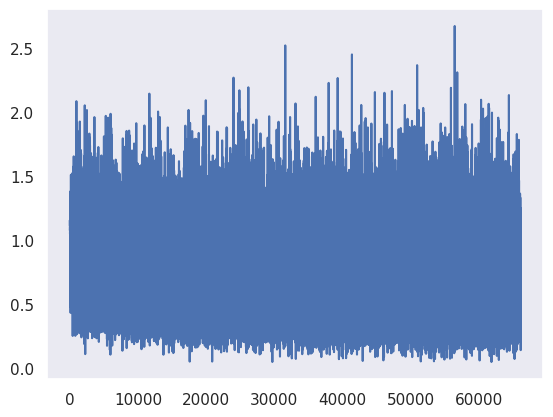

In [30]:
plt.plot(train_losses)

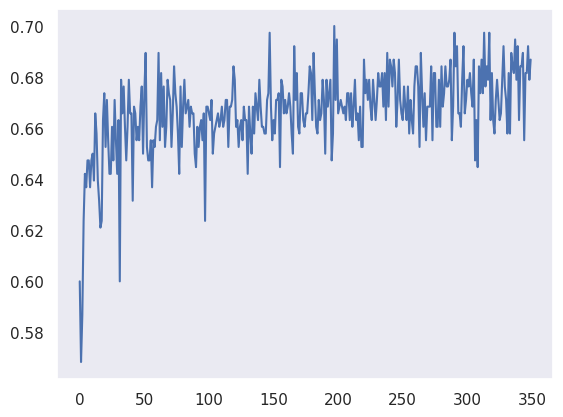

In [31]:
plt.plot(test_accuracy)

In [32]:
best_accuracy

0.7

In [45]:
test_accuracy[-1]

0.6868421052631579

In [33]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 261/376 (0.6941)
{'acc_detail': tensor([0.7716, 0.6303, 0.6421], device='cuda:0'),
 'acc_unweighted': tensor(0.6813, device='cuda:0'),
 'acc_weighted': tensor(0.6941, device='cuda:0'),
 'f1s': tensor(0.6815, device='cuda:0'),
 'f1s_detail': tensor([0.8333, 0.5792, 0.6321], device='cuda:0'),
 'precision_detail': tensor([0.9058, 0.5357, 0.6224], device='cuda:0'),
 'recall_detail': tensor([0.7716, 0.6303, 0.6421], device='cuda:0'),
 'rocauc': tensor([0.9396, 0.7692, 0.8758], device='cuda:0'),
 'uar': tensor(0.6813, device='cuda:0'),
 'wap': tensor(0.7171, device='cuda:0')}


tensor([[125,  32,   5],
        [ 12,  75,  32],
        [  1,  33,  61]], device='cuda:0')

In [41]:
sum([0.8333*sum([125,  32,   5]), 0.5792*sum([ 12,  75,  32]), 0.6321*sum([  1,  33,  61])])/sum(np.array([[125,  32,   5],
        [ 12,  75,  32],
        [  1,  33,  61]]).flatten())

0.7020449468085107

In [47]:
metrics3, confusion_matrix3 = report_metrics(
    model, labels=labels, device=device, 
    test_loader=improv_test_loader)
pprint(metrics3.compute())
confusion_matrix3.compute()

Correct: 1127/1992 (0.5658)
{'acc_detail': tensor([0.8789, 0.4046, 0.7072], device='cuda:0'),
 'acc_unweighted': tensor(0.6636, device='cuda:0'),
 'acc_weighted': tensor(0.5658, device='cuda:0'),
 'f1s': tensor(0.5712, device='cuda:0'),
 'f1s_detail': tensor([0.5779, 0.5157, 0.6200], device='cuda:0'),
 'precision_detail': tensor([0.4305, 0.7111, 0.5520], device='cuda:0'),
 'recall_detail': tensor([0.8789, 0.4046, 0.7072], device='cuda:0'),
 'rocauc': tensor([0.9221, 0.6399, 0.7976], device='cuda:0'),
 'uar': tensor(0.6636, device='cuda:0'),
 'wap': tensor(0.6218, device='cuda:0')}


tensor([[254,  25,  10],
        [313, 443, 339],
        [ 23, 155, 430]], device='cuda:0')

In [50]:
model.to("cpu")

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [51]:
best_epoch = 198
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
best_model = M12(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [53]:
best_model.to(device)

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [54]:
metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
pprint(metrics_best.compute())
confusion_matrix_best.compute()

Correct: 266/376 (0.7074)
{'acc_detail': tensor([0.8272, 0.7143, 0.4947], device='cuda:0'),
 'acc_unweighted': tensor(0.6787, device='cuda:0'),
 'acc_weighted': tensor(0.7074, device='cuda:0'),
 'f1s': tensor(0.6836, device='cuda:0'),
 'f1s_detail': tensor([0.8428, 0.6204, 0.5875], device='cuda:0'),
 'precision_detail': tensor([0.8590, 0.5484, 0.7231], device='cuda:0'),
 'recall_detail': tensor([0.8272, 0.7143, 0.4947], device='cuda:0'),
 'rocauc': tensor([0.9421, 0.7669, 0.8693], device='cuda:0'),
 'uar': tensor(0.6787, device='cuda:0'),
 'wap': tensor(0.7263, device='cuda:0')}


tensor([[134,  26,   2],
        [ 18,  85,  16],
        [  4,  44,  47]], device='cuda:0')

In [55]:
metrics_best_improv, confusion_matrix_best_improv = report_metrics(
    best_model, labels=labels, device=device, test_loader=improv_test_loader)
pprint(metrics_best_improv.compute())
confusion_matrix_best_improv.compute()

Correct: 1049/1992 (0.5266)
{'acc_detail': tensor([0.8927, 0.4493, 0.4918], device='cuda:0'),
 'acc_unweighted': tensor(0.6113, device='cuda:0'),
 'acc_weighted': tensor(0.5266, device='cuda:0'),
 'f1s': tensor(0.5289, device='cuda:0'),
 'f1s_detail': tensor([0.5460, 0.5215, 0.5191], device='cuda:0'),
 'precision_detail': tensor([0.3933, 0.6212, 0.5496], device='cuda:0'),
 'recall_detail': tensor([0.8927, 0.4493, 0.4918], device='cuda:0'),
 'rocauc': tensor([0.9236, 0.5898, 0.7953], device='cuda:0'),
 'uar': tensor(0.6113, device='cuda:0'),
 'wap': tensor(0.5663, device='cuda:0')}


tensor([[258,  23,   8],
        [366, 492, 237],
        [ 32, 277, 299]], device='cuda:0')

In [56]:
best_model.to('cpu')

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [57]:
model

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [18]:
# del model
# gc.collect()

0